# Testing EEGNet model on dataset

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import mne
import random
import pickle

from braindecode.models import Deep4Net
from braindecode.classifier import EEGClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from pycrostates.cluster import ModKMeans
from pycrostates.preprocessing import extract_gfp_peaks
from pycrostates.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    dunn_score,
    davies_bouldin_score,
)




# change directory go into Notebooks folder
if os.path.basename(os.getcwd()) != 'Notebooks':
    if os.path.basename(os.getcwd()) == 'lib':
        os.chdir(os.path.join(os.getcwd(), '..', 'Notebooks'))
    else:
        os.chdir(os.path.join(os.getcwd(), 'Notebooks'))
else:
    # if already in Notebooks folder, do nothing
    pass

from lib import my_functions as mf
from lib.my_models import MicroSNet, MultiModalClassifier

# Loading all data

In [2]:
df_info = pd.read_csv('../Data/data_info.csv')
df_info.head()

subject  n_trials  n_open  n_rest  n_close
0        0       400     100     200      100
1        1       340      85     170       85
2        2       340      85     170       85
3        3       340      85     170       85
4        4       380      95     190       95

In [7]:
data_path = '../Data/'
output_path = '../Output/ica_rest_all/'
do_all = False
n_subjects = 50
subject_list = list(range(n_subjects))
all_data_, all_y_ = mf.load_all_data(subjects_list=None, do_all=do_all)


In [21]:
data_path = '../Data/'
output_path = '../Output/ica_rest_all/'
do_all = False
n_subjects = 50
subject_list = list(range(n_subjects))
all_data, all_y = mf.load_all_data(subjects_list=None, do_all=do_all)


In [7]:
len(all_data), len(all_y)
len(all_data_), len(all_y_)

(1, 1)

## Testing model untrained
### Initiating model

In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)


### Test untrained model on 1 data

In [ ]:
from braindecode.models import Deep4Net
from braindecode.classifier import EEGClassifier
import torch
import torch.nn as nn

# Parameters
n_channels = all_data[0].shape[2]
input_window_samples = all_data[0].shape[3]
n_classes = len(torch.unique(torch.tensor(all_y[0])))

# Build model
deep_model = Deep4Net(
    n_chans=n_channels,
    n_classes=n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto'
)
deep_model = deep_model.to('cuda' if torch.cuda.is_available() else 'cpu')
# Wrap with EEGClassifier
model = EEGClassifier(
    deep_model,
    criterion=nn.NLLLoss(),
    optimizer=torch.optim.Adam,
    optimizer__lr=1e-3,
    train_split=None,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Prepare data
x = torch.tensor(all_data[0], dtype=torch.float32).squeeze(1)  # (n_trials, n_channels, timepoints)
y_true = torch.tensor(all_y[0], dtype=torch.long)              # (n_trials,)

# Move input to model's device
x = x.to(model.device)
y_true = y_true.to(model.device)

# Inference
model.initialize()  # Initialize the model parameters

with torch.no_grad():
    predictions = model.predict(x)               # (n_trials,)
    probabilities = model.predict_proba(x)       # (n_trials, n_classes)

# Accuracy
accuracy = (predictions == y_true.cpu()).float().mean().item()

print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 45.25%


## Train model on dataset
### Splitting data

In [ ]:
# Assuming:
# all_data[0]: (n_trials, 1, n_electrodes, timepoints)
# all_y: (1, n_trials) or (n_trials,)
from sklearn.model_selection import train_test_split
x = torch.tensor(all_data[0], dtype=torch.float32).squeeze(1)  # shape: (n_trials, n_electrodes, timepoints)
y = torch.tensor(all_y[0], dtype=torch.long)

# Split 80% train_val and 20% test
x_trainval, x_test, y_trainval, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

# Split train_val into 75% train and 25% val → final:
# Train: 60%, Val: 20%, Test: 20%
x_train, x_val, y_train, y_val = train_test_split(
    x_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

print(f"Train size: {len(x_train)}")
print(f"Val size: {len(x_val)}")
print(f"Test size: {len(x_test)}")

Train size: 240
Val size: 80
Test size: 80


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)


### Initiating model

In [ ]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(42)
model = Deep4Net(
    n_chans=x.shape[1],        # 1 (channel dim)
    n_classes=len(torch.unique(y)),
    input_window_samples=x.shape[2],
    final_conv_length='auto'
).to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


### Training model

In [ ]:
import torch.nn.functional as F

# Set model to training mode
device = model.device
net = model.module  # core Deep4Net
net.to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.NLLLoss()

num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # === Train ===
    net.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = net(batch_x)  # use core model
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_x.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()
        train_total += batch_y.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # === Validation ===
    net.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = net(batch_x)
            loss = criterion(outputs, batch_y)

            val_loss += loss.item() * batch_x.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == batch_y).sum().item()
            val_total += batch_y.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/50: Train Loss: 1.3393, Train Acc: 44.58%, Val Loss: 0.9086, Val Acc: 58.75%
Epoch 2/50: Train Loss: 1.0599, Train Acc: 57.92%, Val Loss: 0.9675, Val Acc: 55.00%
Epoch 3/50: Train Loss: 0.9034, Train Acc: 61.67%, Val Loss: 1.0880, Val Acc: 51.25%
Epoch 4/50: Train Loss: 0.8677, Train Acc: 65.00%, Val Loss: 1.3502, Val Acc: 48.75%
Epoch 5/50: Train Loss: 0.6885, Train Acc: 69.17%, Val Loss: 1.3532, Val Acc: 46.25%
Epoch 6/50: Train Loss: 0.7470, Train Acc: 70.83%, Val Loss: 1.5433, Val Acc: 47.50%
Epoch 7/50: Train Loss: 0.6278, Train Acc: 71.67%, Val Loss: 1.5378, Val Acc: 46.25%
Epoch 8/50: Train Loss: 0.6035, Train Acc: 75.42%, Val Loss: 1.5447, Val Acc: 46.25%
Epoch 9/50: Train Loss: 0.5286, Train Acc: 77.50%, Val Loss: 1.5611, Val Acc: 47.50%
Epoch 10/50: Train Loss: 0.5287, Train Acc: 77.92%, Val Loss: 1.3256, Val Acc: 48.75%
Epoch 11/50: Train Loss: 0.3967, Train Acc: 84.17%, Val Loss: 1.3913, Val Acc: 47.50%
Epoch 12/50: Train Loss: 0.3981, Train Acc: 82.08%, Val Loss: 1

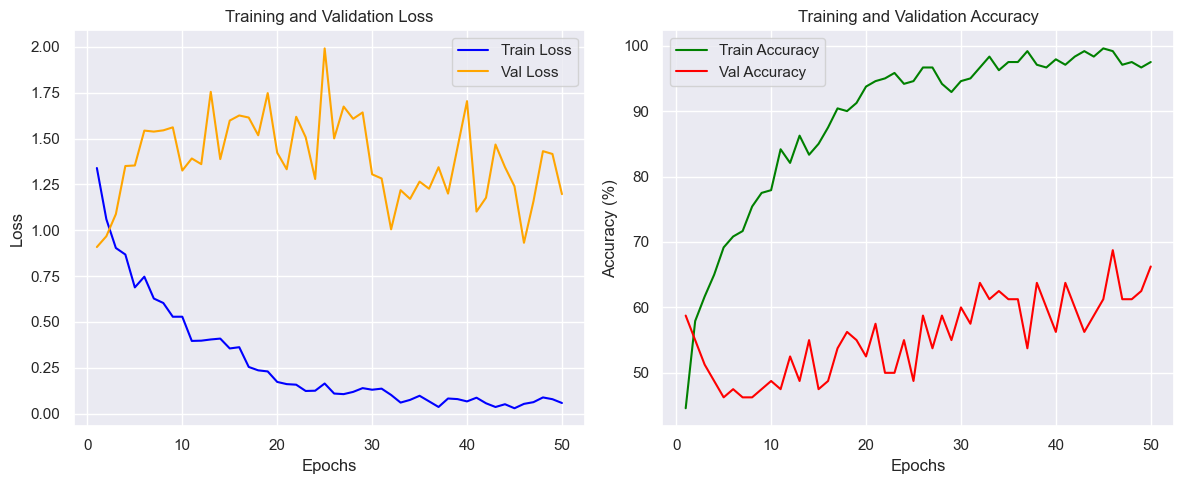

In [ ]:
# plot training and validation loss and accuracy
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Val Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy', color='green')
    plt.plot(epochs, val_accs, label='Val Accuracy', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Collect training history
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

### Testing model

In [ ]:
# Access the raw Deep4Net from EEGClassifier
net = model.module
net.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = net(batch_x)  # use model.module here
        preds = outputs.argmax(dim=1)
        test_correct += (preds == batch_y).sum().item()
        test_total += batch_y.size(0)

test_acc = test_correct / test_total * 100
print(f"✅ Test accuracy: {test_acc:.2f}%")


✅ Test accuracy: 68.75%


# Looking for all subjects
## Initiating model

In [ ]:
from braindecode.models import Deep4Net
from braindecode.classifier import EEGClassifier
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
import random

# ---------- Seed & Device ----------
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Results Storage ----------
all_train_accuracies = []
all_train_losses = []
all_test_accuracies = []
all_val_accuracies = []
all_val_losses = []
all_models = []

# ---------- Loop Through Subjects ----------
for id in range(n_subjects):
    print(f"\n▶ Training Subject {id}")

    x = torch.tensor(all_data[id], dtype=torch.float32).squeeze(1)  # (n_trials, n_channels, timepoints)
    y = torch.tensor(all_y[id], dtype=torch.long)

    # ---------- Data Splitting ----------
    x_trainval, x_test, y_trainval, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y)

    x_train, x_val, y_train, y_val = train_test_split(
        x_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

    # ---------- DataLoaders ----------
    batch_size = 32
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

    # ---------- Model ----------
    base_model = Deep4Net(
        n_chans=x.shape[1],
        n_classes=len(torch.unique(y)),
        input_window_samples=x.shape[2],
        final_conv_length='auto'
    )

    model = EEGClassifier(
        base_model,
        criterion=nn.NLLLoss(),
        optimizer=torch.optim.Adam,
        optimizer__lr=1e-3,
        train_split=None,
        device=device
    )

    net = model.module.to(device)  # core Deep4Net
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

    # ---------- Training ----------
    num_epochs = 50
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        net.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = net(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_x.size(0)
            preds = outputs.argmax(dim=1)
            train_correct += (preds == batch_y).sum().item()
            train_total += batch_y.size(0)

        train_loss /= train_total
        train_acc = train_correct / train_total * 100
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # ---------- Validation ----------
        net.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = net(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_x.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == batch_y).sum().item()
                val_total += batch_y.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total * 100
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1:02d}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    # ---------- Test ----------
    net.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = net(batch_x)
            preds = outputs.argmax(dim=1)
            test_correct += (preds == batch_y).sum().item()
            test_total += batch_y.size(0)

    test_acc = test_correct / test_total * 100
    print(f"✅ Subject {id} Test Accuracy: {test_acc:.2f}%")

    # ---------- Save Results ----------
    all_train_accuracies.append(train_accuracies)
    all_train_losses.append(train_losses)
    all_test_accuracies.append(test_acc)
    all_val_accuracies.append(val_accuracies)
    all_val_losses.append(val_losses)
    all_models.append(model)



▶ Training Subject 0


c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.3665, Acc: 45.00% | Val Loss: 0.9584, Acc: 53.75%
Epoch 02/50 | Train Loss: 1.0361, Acc: 59.58% | Val Loss: 1.1851, Acc: 46.25%
Epoch 03/50 | Train Loss: 1.0699, Acc: 56.25% | Val Loss: 1.1572, Acc: 51.25%
Epoch 04/50 | Train Loss: 0.8459, Acc: 68.33% | Val Loss: 1.2185, Acc: 48.75%
Epoch 05/50 | Train Loss: 0.8630, Acc: 65.42% | Val Loss: 1.3798, Acc: 50.00%
Epoch 06/50 | Train Loss: 0.7586, Acc: 68.33% | Val Loss: 1.6676, Acc: 42.50%
Epoch 07/50 | Train Loss: 0.7195, Acc: 68.75% | Val Loss: 1.5804, Acc: 45.00%
Epoch 08/50 | Train Loss: 0.6556, Acc: 76.67% | Val Loss: 1.6654, Acc: 45.00%
Epoch 09/50 | Train Loss: 0.5532, Acc: 77.92% | Val Loss: 1.5803, Acc: 42.50%
Epoch 10/50 | Train Loss: 0.5078, Acc: 80.42% | Val Loss: 1.9263, Acc: 42.50%
Epoch 11/50 | Train Loss: 0.3978, Acc: 83.75% | Val Loss: 1.9660, Acc: 43.75%
Epoch 12/50 | Train Loss: 0.4670, Acc: 82.08% | Val Loss: 2.0843, Acc: 42.50%
Epoch 13/50 | Train Loss: 0.3014, Acc: 87.50% | Val Loss: 1.6834

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.5190, Acc: 37.75% | Val Loss: 1.1882, Acc: 45.59%
Epoch 02/50 | Train Loss: 1.1500, Acc: 50.00% | Val Loss: 0.9553, Acc: 55.88%
Epoch 03/50 | Train Loss: 0.9082, Acc: 62.75% | Val Loss: 1.2782, Acc: 45.59%
Epoch 04/50 | Train Loss: 1.0428, Acc: 60.78% | Val Loss: 1.4198, Acc: 42.65%
Epoch 05/50 | Train Loss: 0.8071, Acc: 67.65% | Val Loss: 1.5934, Acc: 32.35%
Epoch 06/50 | Train Loss: 0.8440, Acc: 68.63% | Val Loss: 1.6792, Acc: 45.59%
Epoch 07/50 | Train Loss: 0.7290, Acc: 72.55% | Val Loss: 1.5321, Acc: 36.76%
Epoch 08/50 | Train Loss: 0.6511, Acc: 75.49% | Val Loss: 1.6301, Acc: 35.29%
Epoch 09/50 | Train Loss: 0.6466, Acc: 75.98% | Val Loss: 1.6507, Acc: 38.24%
Epoch 10/50 | Train Loss: 0.7085, Acc: 74.02% | Val Loss: 1.8591, Acc: 32.35%
Epoch 11/50 | Train Loss: 0.5452, Acc: 79.90% | Val Loss: 1.6775, Acc: 39.71%
Epoch 12/50 | Train Loss: 0.6052, Acc: 81.37% | Val Loss: 1.8226, Acc: 41.18%
Epoch 13/50 | Train Loss: 0.4435, Acc: 81.86% | Val Loss: 1.8237

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.1892, Acc: 45.59% | Val Loss: 1.4596, Acc: 57.35%
Epoch 02/50 | Train Loss: 0.6885, Acc: 69.12% | Val Loss: 1.8830, Acc: 58.82%
Epoch 03/50 | Train Loss: 0.6938, Acc: 71.08% | Val Loss: 1.9014, Acc: 52.94%
Epoch 04/50 | Train Loss: 0.6107, Acc: 77.94% | Val Loss: 1.9856, Acc: 48.53%
Epoch 05/50 | Train Loss: 0.5354, Acc: 77.45% | Val Loss: 1.9391, Acc: 44.12%
Epoch 06/50 | Train Loss: 0.4277, Acc: 83.82% | Val Loss: 1.8243, Acc: 42.65%
Epoch 07/50 | Train Loss: 0.5060, Acc: 78.43% | Val Loss: 2.0244, Acc: 41.18%
Epoch 08/50 | Train Loss: 0.4608, Acc: 78.92% | Val Loss: 2.0739, Acc: 41.18%
Epoch 09/50 | Train Loss: 0.4275, Acc: 84.80% | Val Loss: 2.2790, Acc: 39.71%
Epoch 10/50 | Train Loss: 0.3720, Acc: 85.29% | Val Loss: 2.0387, Acc: 39.71%
Epoch 11/50 | Train Loss: 0.3178, Acc: 86.27% | Val Loss: 2.4046, Acc: 39.71%
Epoch 12/50 | Train Loss: 0.3202, Acc: 86.27% | Val Loss: 2.1431, Acc: 44.12%
Epoch 13/50 | Train Loss: 0.3692, Acc: 82.35% | Val Loss: 2.2615

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.5569, Acc: 41.67% | Val Loss: 1.4267, Acc: 26.47%
Epoch 02/50 | Train Loss: 1.4147, Acc: 45.10% | Val Loss: 1.1249, Acc: 50.00%
Epoch 03/50 | Train Loss: 1.2691, Acc: 52.45% | Val Loss: 1.2274, Acc: 47.06%
Epoch 04/50 | Train Loss: 1.0443, Acc: 58.33% | Val Loss: 1.0128, Acc: 57.35%
Epoch 05/50 | Train Loss: 0.9532, Acc: 57.84% | Val Loss: 1.1157, Acc: 54.41%
Epoch 06/50 | Train Loss: 1.0511, Acc: 57.84% | Val Loss: 0.9319, Acc: 60.29%
Epoch 07/50 | Train Loss: 0.7138, Acc: 69.61% | Val Loss: 0.9588, Acc: 54.41%
Epoch 08/50 | Train Loss: 0.6700, Acc: 70.10% | Val Loss: 1.3002, Acc: 54.41%
Epoch 09/50 | Train Loss: 0.6924, Acc: 70.59% | Val Loss: 1.1651, Acc: 52.94%
Epoch 10/50 | Train Loss: 0.6048, Acc: 74.02% | Val Loss: 1.1712, Acc: 54.41%
Epoch 11/50 | Train Loss: 0.5593, Acc: 75.98% | Val Loss: 1.1244, Acc: 54.41%
Epoch 12/50 | Train Loss: 0.5180, Acc: 78.43% | Val Loss: 1.2205, Acc: 55.88%
Epoch 13/50 | Train Loss: 0.4764, Acc: 77.45% | Val Loss: 1.1272

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.2750, Acc: 45.61% | Val Loss: 1.4592, Acc: 39.47%
Epoch 02/50 | Train Loss: 1.1903, Acc: 51.32% | Val Loss: 1.9346, Acc: 36.84%
Epoch 03/50 | Train Loss: 0.9545, Acc: 60.53% | Val Loss: 2.2321, Acc: 27.63%
Epoch 04/50 | Train Loss: 0.9310, Acc: 57.89% | Val Loss: 2.1715, Acc: 31.58%
Epoch 05/50 | Train Loss: 0.8766, Acc: 63.60% | Val Loss: 2.1479, Acc: 27.63%
Epoch 06/50 | Train Loss: 0.8765, Acc: 67.11% | Val Loss: 1.3675, Acc: 38.16%
Epoch 07/50 | Train Loss: 0.8487, Acc: 64.91% | Val Loss: 1.4072, Acc: 44.74%
Epoch 08/50 | Train Loss: 0.6112, Acc: 71.93% | Val Loss: 1.7156, Acc: 38.16%
Epoch 09/50 | Train Loss: 0.6235, Acc: 75.00% | Val Loss: 1.5792, Acc: 40.79%
Epoch 10/50 | Train Loss: 0.5650, Acc: 76.75% | Val Loss: 1.4569, Acc: 39.47%
Epoch 11/50 | Train Loss: 0.5322, Acc: 81.14% | Val Loss: 1.3559, Acc: 43.42%
Epoch 12/50 | Train Loss: 0.4941, Acc: 77.63% | Val Loss: 1.3140, Acc: 40.79%
Epoch 13/50 | Train Loss: 0.5222, Acc: 81.58% | Val Loss: 1.2579

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.7300, Acc: 39.22% | Val Loss: 1.2891, Acc: 33.82%
Epoch 02/50 | Train Loss: 1.6014, Acc: 36.27% | Val Loss: 1.1007, Acc: 50.00%
Epoch 03/50 | Train Loss: 1.1545, Acc: 58.82% | Val Loss: 1.9583, Acc: 27.94%
Epoch 04/50 | Train Loss: 1.1051, Acc: 53.92% | Val Loss: 1.9708, Acc: 29.41%
Epoch 05/50 | Train Loss: 1.0175, Acc: 57.84% | Val Loss: 1.6033, Acc: 32.35%
Epoch 06/50 | Train Loss: 0.8526, Acc: 68.63% | Val Loss: 2.3396, Acc: 26.47%
Epoch 07/50 | Train Loss: 0.7332, Acc: 71.08% | Val Loss: 2.4988, Acc: 25.00%
Epoch 08/50 | Train Loss: 0.6978, Acc: 72.55% | Val Loss: 2.3369, Acc: 27.94%
Epoch 09/50 | Train Loss: 0.6532, Acc: 73.04% | Val Loss: 2.5340, Acc: 27.94%
Epoch 10/50 | Train Loss: 0.6654, Acc: 75.49% | Val Loss: 2.7582, Acc: 29.41%
Epoch 11/50 | Train Loss: 0.4929, Acc: 82.84% | Val Loss: 1.9721, Acc: 33.82%
Epoch 12/50 | Train Loss: 0.3598, Acc: 85.78% | Val Loss: 2.5174, Acc: 30.88%
Epoch 13/50 | Train Loss: 0.3967, Acc: 81.86% | Val Loss: 2.4988

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.1648, Acc: 51.67% | Val Loss: 0.8499, Acc: 61.25%
Epoch 02/50 | Train Loss: 0.9193, Acc: 59.58% | Val Loss: 0.7121, Acc: 71.25%
Epoch 03/50 | Train Loss: 0.6515, Acc: 73.75% | Val Loss: 1.3736, Acc: 57.50%
Epoch 04/50 | Train Loss: 0.4790, Acc: 82.08% | Val Loss: 1.8117, Acc: 47.50%
Epoch 05/50 | Train Loss: 0.3936, Acc: 86.25% | Val Loss: 2.0050, Acc: 48.75%
Epoch 06/50 | Train Loss: 0.2372, Acc: 87.92% | Val Loss: 1.7644, Acc: 50.00%
Epoch 07/50 | Train Loss: 0.1715, Acc: 94.58% | Val Loss: 1.5871, Acc: 53.75%
Epoch 08/50 | Train Loss: 0.2364, Acc: 91.25% | Val Loss: 1.6018, Acc: 58.75%
Epoch 09/50 | Train Loss: 0.1413, Acc: 95.00% | Val Loss: 1.6322, Acc: 55.00%
Epoch 10/50 | Train Loss: 0.1232, Acc: 95.42% | Val Loss: 1.6703, Acc: 48.75%
Epoch 11/50 | Train Loss: 0.0913, Acc: 95.42% | Val Loss: 1.3515, Acc: 60.00%
Epoch 12/50 | Train Loss: 0.1158, Acc: 95.00% | Val Loss: 1.2607, Acc: 63.75%
Epoch 13/50 | Train Loss: 0.1209, Acc: 94.58% | Val Loss: 1.6643

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.3483, Acc: 48.53% | Val Loss: 1.2591, Acc: 39.71%
Epoch 02/50 | Train Loss: 1.1778, Acc: 50.98% | Val Loss: 1.1692, Acc: 55.88%
Epoch 03/50 | Train Loss: 1.1630, Acc: 62.75% | Val Loss: 1.2537, Acc: 52.94%
Epoch 04/50 | Train Loss: 0.9039, Acc: 62.25% | Val Loss: 1.0556, Acc: 55.88%
Epoch 05/50 | Train Loss: 0.8293, Acc: 64.71% | Val Loss: 1.0783, Acc: 55.88%
Epoch 06/50 | Train Loss: 0.7662, Acc: 70.59% | Val Loss: 1.2304, Acc: 50.00%
Epoch 07/50 | Train Loss: 0.6874, Acc: 70.10% | Val Loss: 1.4251, Acc: 48.53%
Epoch 08/50 | Train Loss: 0.6503, Acc: 73.53% | Val Loss: 1.3197, Acc: 45.59%
Epoch 09/50 | Train Loss: 0.5563, Acc: 76.96% | Val Loss: 1.2274, Acc: 48.53%
Epoch 10/50 | Train Loss: 0.5870, Acc: 74.51% | Val Loss: 1.3871, Acc: 50.00%
Epoch 11/50 | Train Loss: 0.4652, Acc: 79.90% | Val Loss: 1.2331, Acc: 57.35%
Epoch 12/50 | Train Loss: 0.4957, Acc: 77.45% | Val Loss: 1.4953, Acc: 51.47%
Epoch 13/50 | Train Loss: 0.4126, Acc: 82.84% | Val Loss: 1.2058

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.5713, Acc: 41.20% | Val Loss: 1.0232, Acc: 47.22%
Epoch 02/50 | Train Loss: 1.3177, Acc: 42.59% | Val Loss: 0.9945, Acc: 56.94%
Epoch 03/50 | Train Loss: 1.1136, Acc: 54.17% | Val Loss: 1.0958, Acc: 45.83%
Epoch 04/50 | Train Loss: 0.9898, Acc: 60.19% | Val Loss: 1.1118, Acc: 45.83%
Epoch 05/50 | Train Loss: 0.8945, Acc: 63.43% | Val Loss: 0.9431, Acc: 48.61%
Epoch 06/50 | Train Loss: 0.8008, Acc: 64.35% | Val Loss: 1.0952, Acc: 54.17%
Epoch 07/50 | Train Loss: 0.8091, Acc: 70.83% | Val Loss: 1.0999, Acc: 51.39%
Epoch 08/50 | Train Loss: 0.9081, Acc: 64.35% | Val Loss: 1.0501, Acc: 51.39%
Epoch 09/50 | Train Loss: 0.6444, Acc: 72.22% | Val Loss: 1.4189, Acc: 54.17%
Epoch 10/50 | Train Loss: 0.5396, Acc: 79.17% | Val Loss: 1.4352, Acc: 48.61%
Epoch 11/50 | Train Loss: 0.3876, Acc: 83.33% | Val Loss: 1.5004, Acc: 44.44%
Epoch 12/50 | Train Loss: 0.4383, Acc: 81.02% | Val Loss: 1.2363, Acc: 59.72%
Epoch 13/50 | Train Loss: 0.4226, Acc: 79.63% | Val Loss: 1.2435

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.3699, Acc: 40.74% | Val Loss: 1.1107, Acc: 40.28%
Epoch 02/50 | Train Loss: 1.0345, Acc: 54.63% | Val Loss: 0.7810, Acc: 61.11%
Epoch 03/50 | Train Loss: 0.9301, Acc: 61.57% | Val Loss: 0.6875, Acc: 66.67%
Epoch 04/50 | Train Loss: 0.7431, Acc: 66.20% | Val Loss: 0.5763, Acc: 76.39%
Epoch 05/50 | Train Loss: 0.5716, Acc: 73.15% | Val Loss: 0.5199, Acc: 76.39%
Epoch 06/50 | Train Loss: 0.5678, Acc: 75.00% | Val Loss: 0.5800, Acc: 75.00%
Epoch 07/50 | Train Loss: 0.3600, Acc: 86.57% | Val Loss: 0.4730, Acc: 80.56%
Epoch 08/50 | Train Loss: 0.3012, Acc: 88.43% | Val Loss: 0.5498, Acc: 79.17%
Epoch 09/50 | Train Loss: 0.2643, Acc: 92.13% | Val Loss: 0.5443, Acc: 80.56%
Epoch 10/50 | Train Loss: 0.2592, Acc: 91.20% | Val Loss: 0.4377, Acc: 83.33%
Epoch 11/50 | Train Loss: 0.2192, Acc: 91.20% | Val Loss: 0.4283, Acc: 86.11%
Epoch 12/50 | Train Loss: 0.1099, Acc: 95.83% | Val Loss: 0.5425, Acc: 81.94%
Epoch 13/50 | Train Loss: 0.1077, Acc: 95.83% | Val Loss: 0.4496

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.4731, Acc: 38.33% | Val Loss: 0.8425, Acc: 60.00%
Epoch 02/50 | Train Loss: 1.0428, Acc: 52.08% | Val Loss: 0.8739, Acc: 55.00%
Epoch 03/50 | Train Loss: 0.8234, Acc: 63.33% | Val Loss: 0.8433, Acc: 62.50%
Epoch 04/50 | Train Loss: 0.7450, Acc: 71.25% | Val Loss: 1.4248, Acc: 42.50%
Epoch 05/50 | Train Loss: 0.6954, Acc: 71.25% | Val Loss: 1.7939, Acc: 41.25%
Epoch 06/50 | Train Loss: 0.5630, Acc: 74.17% | Val Loss: 1.9016, Acc: 33.75%
Epoch 07/50 | Train Loss: 0.4969, Acc: 77.92% | Val Loss: 1.8447, Acc: 35.00%
Epoch 08/50 | Train Loss: 0.4961, Acc: 75.00% | Val Loss: 1.8768, Acc: 36.25%
Epoch 09/50 | Train Loss: 0.3685, Acc: 83.33% | Val Loss: 1.7395, Acc: 38.75%
Epoch 10/50 | Train Loss: 0.4254, Acc: 83.75% | Val Loss: 1.6519, Acc: 43.75%
Epoch 11/50 | Train Loss: 0.3792, Acc: 84.17% | Val Loss: 1.4932, Acc: 50.00%
Epoch 12/50 | Train Loss: 0.4166, Acc: 83.75% | Val Loss: 1.9536, Acc: 46.25%
Epoch 13/50 | Train Loss: 0.3254, Acc: 90.83% | Val Loss: 1.8305

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.4694, Acc: 40.74% | Val Loss: 0.8196, Acc: 68.06%
Epoch 02/50 | Train Loss: 1.0904, Acc: 54.17% | Val Loss: 0.7599, Acc: 72.22%
Epoch 03/50 | Train Loss: 0.8817, Acc: 60.65% | Val Loss: 0.8356, Acc: 62.50%
Epoch 04/50 | Train Loss: 0.8033, Acc: 68.98% | Val Loss: 0.8554, Acc: 59.72%
Epoch 05/50 | Train Loss: 0.7355, Acc: 71.76% | Val Loss: 0.9054, Acc: 58.33%
Epoch 06/50 | Train Loss: 0.5276, Acc: 77.31% | Val Loss: 0.8726, Acc: 63.89%
Epoch 07/50 | Train Loss: 0.5285, Acc: 79.63% | Val Loss: 0.8229, Acc: 59.72%
Epoch 08/50 | Train Loss: 0.4045, Acc: 83.80% | Val Loss: 0.8354, Acc: 52.78%
Epoch 09/50 | Train Loss: 0.4294, Acc: 83.80% | Val Loss: 0.7329, Acc: 58.33%
Epoch 10/50 | Train Loss: 0.2807, Acc: 90.28% | Val Loss: 0.9917, Acc: 55.56%
Epoch 11/50 | Train Loss: 0.3562, Acc: 85.19% | Val Loss: 0.8646, Acc: 56.94%
Epoch 12/50 | Train Loss: 0.2162, Acc: 91.20% | Val Loss: 0.7975, Acc: 62.50%
Epoch 13/50 | Train Loss: 0.2481, Acc: 91.67% | Val Loss: 0.8401

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.3768, Acc: 41.67% | Val Loss: 1.0417, Acc: 32.89%
Epoch 02/50 | Train Loss: 1.1692, Acc: 50.00% | Val Loss: 1.1230, Acc: 50.00%
Epoch 03/50 | Train Loss: 0.9694, Acc: 59.21% | Val Loss: 1.1675, Acc: 46.05%
Epoch 04/50 | Train Loss: 0.9226, Acc: 63.16% | Val Loss: 1.1872, Acc: 40.79%
Epoch 05/50 | Train Loss: 0.9396, Acc: 65.79% | Val Loss: 1.3608, Acc: 47.37%
Epoch 06/50 | Train Loss: 0.8163, Acc: 66.67% | Val Loss: 1.3466, Acc: 47.37%
Epoch 07/50 | Train Loss: 0.8750, Acc: 69.30% | Val Loss: 1.4474, Acc: 43.42%
Epoch 08/50 | Train Loss: 0.7819, Acc: 71.49% | Val Loss: 1.3480, Acc: 51.32%
Epoch 09/50 | Train Loss: 0.6126, Acc: 79.82% | Val Loss: 1.4448, Acc: 52.63%
Epoch 10/50 | Train Loss: 0.6503, Acc: 78.95% | Val Loss: 1.5203, Acc: 53.95%
Epoch 11/50 | Train Loss: 0.4469, Acc: 81.58% | Val Loss: 1.1571, Acc: 56.58%
Epoch 12/50 | Train Loss: 0.4630, Acc: 82.46% | Val Loss: 1.3205, Acc: 53.95%
Epoch 13/50 | Train Loss: 0.4476, Acc: 83.77% | Val Loss: 1.1832

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.3770, Acc: 42.11% | Val Loss: 1.3288, Acc: 34.21%
Epoch 02/50 | Train Loss: 1.0485, Acc: 54.82% | Val Loss: 1.1264, Acc: 52.63%
Epoch 03/50 | Train Loss: 0.8459, Acc: 63.60% | Val Loss: 1.4280, Acc: 53.95%
Epoch 04/50 | Train Loss: 0.7467, Acc: 69.30% | Val Loss: 1.7562, Acc: 52.63%
Epoch 05/50 | Train Loss: 0.8440, Acc: 64.91% | Val Loss: 1.6817, Acc: 52.63%
Epoch 06/50 | Train Loss: 0.6480, Acc: 75.88% | Val Loss: 1.4045, Acc: 51.32%
Epoch 07/50 | Train Loss: 0.7723, Acc: 70.61% | Val Loss: 1.7359, Acc: 53.95%
Epoch 08/50 | Train Loss: 0.6005, Acc: 75.44% | Val Loss: 1.6104, Acc: 56.58%
Epoch 09/50 | Train Loss: 0.6248, Acc: 76.32% | Val Loss: 1.4141, Acc: 56.58%
Epoch 10/50 | Train Loss: 0.5442, Acc: 75.00% | Val Loss: 1.3683, Acc: 59.21%
Epoch 11/50 | Train Loss: 0.4772, Acc: 79.39% | Val Loss: 1.5478, Acc: 55.26%
Epoch 12/50 | Train Loss: 0.5304, Acc: 73.25% | Val Loss: 1.4363, Acc: 57.89%
Epoch 13/50 | Train Loss: 0.4507, Acc: 80.26% | Val Loss: 1.2902

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.4542, Acc: 35.78% | Val Loss: 1.4306, Acc: 26.47%
Epoch 02/50 | Train Loss: 1.3088, Acc: 51.96% | Val Loss: 2.2484, Acc: 25.00%
Epoch 03/50 | Train Loss: 1.0640, Acc: 46.08% | Val Loss: 2.3640, Acc: 25.00%
Epoch 04/50 | Train Loss: 0.9406, Acc: 54.90% | Val Loss: 1.9698, Acc: 25.00%
Epoch 05/50 | Train Loss: 0.9580, Acc: 58.82% | Val Loss: 2.1552, Acc: 25.00%
Epoch 06/50 | Train Loss: 0.8037, Acc: 59.80% | Val Loss: 2.1698, Acc: 25.00%
Epoch 07/50 | Train Loss: 0.7978, Acc: 68.63% | Val Loss: 2.5217, Acc: 25.00%
Epoch 08/50 | Train Loss: 0.7840, Acc: 65.69% | Val Loss: 2.4756, Acc: 25.00%
Epoch 09/50 | Train Loss: 0.8008, Acc: 62.75% | Val Loss: 2.4919, Acc: 25.00%
Epoch 10/50 | Train Loss: 0.5997, Acc: 78.92% | Val Loss: 2.3367, Acc: 25.00%
Epoch 11/50 | Train Loss: 0.6977, Acc: 69.12% | Val Loss: 3.0601, Acc: 25.00%
Epoch 12/50 | Train Loss: 0.6135, Acc: 71.08% | Val Loss: 3.8306, Acc: 25.00%
Epoch 13/50 | Train Loss: 0.4687, Acc: 80.39% | Val Loss: 3.3664

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.1311, Acc: 45.24% | Val Loss: 1.2477, Acc: 42.86%
Epoch 02/50 | Train Loss: 0.8599, Acc: 63.10% | Val Loss: 0.7942, Acc: 64.29%
Epoch 03/50 | Train Loss: 0.7824, Acc: 64.88% | Val Loss: 1.7232, Acc: 46.43%
Epoch 04/50 | Train Loss: 0.5261, Acc: 79.17% | Val Loss: 2.4672, Acc: 39.29%
Epoch 05/50 | Train Loss: 0.5005, Acc: 80.36% | Val Loss: 2.4191, Acc: 37.50%
Epoch 06/50 | Train Loss: 0.4521, Acc: 85.12% | Val Loss: 2.4774, Acc: 37.50%
Epoch 07/50 | Train Loss: 0.2939, Acc: 89.88% | Val Loss: 2.2202, Acc: 39.29%
Epoch 08/50 | Train Loss: 0.2745, Acc: 89.88% | Val Loss: 2.3858, Acc: 48.21%
Epoch 09/50 | Train Loss: 0.1735, Acc: 94.05% | Val Loss: 2.1174, Acc: 50.00%
Epoch 10/50 | Train Loss: 0.1788, Acc: 91.67% | Val Loss: 2.1403, Acc: 44.64%
Epoch 11/50 | Train Loss: 0.2455, Acc: 89.88% | Val Loss: 2.3547, Acc: 37.50%
Epoch 12/50 | Train Loss: 0.2392, Acc: 91.67% | Val Loss: 1.9557, Acc: 44.64%
Epoch 13/50 | Train Loss: 0.1335, Acc: 94.05% | Val Loss: 1.8599

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.4644, Acc: 44.74% | Val Loss: 1.3114, Acc: 43.42%
Epoch 02/50 | Train Loss: 1.2029, Acc: 50.44% | Val Loss: 1.4234, Acc: 43.42%
Epoch 03/50 | Train Loss: 1.1260, Acc: 60.96% | Val Loss: 1.3850, Acc: 40.79%
Epoch 04/50 | Train Loss: 0.9345, Acc: 60.96% | Val Loss: 1.4430, Acc: 42.11%
Epoch 05/50 | Train Loss: 0.8581, Acc: 62.28% | Val Loss: 1.4861, Acc: 38.16%
Epoch 06/50 | Train Loss: 0.8560, Acc: 67.11% | Val Loss: 1.3685, Acc: 35.53%
Epoch 07/50 | Train Loss: 0.8264, Acc: 67.54% | Val Loss: 1.5521, Acc: 38.16%
Epoch 08/50 | Train Loss: 0.8057, Acc: 70.61% | Val Loss: 1.2687, Acc: 46.05%
Epoch 09/50 | Train Loss: 0.6449, Acc: 72.81% | Val Loss: 1.5221, Acc: 39.47%
Epoch 10/50 | Train Loss: 0.6381, Acc: 78.51% | Val Loss: 1.4530, Acc: 40.79%
Epoch 11/50 | Train Loss: 0.5277, Acc: 79.39% | Val Loss: 1.5530, Acc: 39.47%
Epoch 12/50 | Train Loss: 0.5767, Acc: 79.82% | Val Loss: 1.6749, Acc: 39.47%
Epoch 13/50 | Train Loss: 0.4599, Acc: 78.07% | Val Loss: 1.2612

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.4349, Acc: 41.67% | Val Loss: 1.8044, Acc: 51.39%
Epoch 02/50 | Train Loss: 1.0098, Acc: 60.65% | Val Loss: 0.8174, Acc: 62.50%
Epoch 03/50 | Train Loss: 0.8244, Acc: 67.59% | Val Loss: 1.3097, Acc: 48.61%
Epoch 04/50 | Train Loss: 0.5145, Acc: 79.17% | Val Loss: 1.4982, Acc: 45.83%
Epoch 05/50 | Train Loss: 0.4177, Acc: 82.87% | Val Loss: 2.5010, Acc: 38.89%
Epoch 06/50 | Train Loss: 0.4068, Acc: 82.87% | Val Loss: 2.4762, Acc: 43.06%
Epoch 07/50 | Train Loss: 0.2794, Acc: 87.50% | Val Loss: 2.2875, Acc: 43.06%
Epoch 08/50 | Train Loss: 0.2159, Acc: 91.67% | Val Loss: 2.4797, Acc: 45.83%
Epoch 09/50 | Train Loss: 0.2678, Acc: 90.28% | Val Loss: 2.3553, Acc: 44.44%
Epoch 10/50 | Train Loss: 0.2605, Acc: 88.89% | Val Loss: 2.4550, Acc: 43.06%
Epoch 11/50 | Train Loss: 0.1954, Acc: 94.44% | Val Loss: 2.4826, Acc: 44.44%
Epoch 12/50 | Train Loss: 0.1415, Acc: 93.98% | Val Loss: 2.2536, Acc: 43.06%
Epoch 13/50 | Train Loss: 0.0936, Acc: 95.37% | Val Loss: 2.5518

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.3661, Acc: 43.52% | Val Loss: 1.7488, Acc: 43.06%
Epoch 02/50 | Train Loss: 1.2100, Acc: 55.09% | Val Loss: 1.3496, Acc: 38.89%
Epoch 03/50 | Train Loss: 0.8989, Acc: 62.04% | Val Loss: 1.2147, Acc: 47.22%
Epoch 04/50 | Train Loss: 1.0016, Acc: 51.39% | Val Loss: 1.3564, Acc: 40.28%
Epoch 05/50 | Train Loss: 0.9186, Acc: 62.04% | Val Loss: 1.2435, Acc: 41.67%
Epoch 06/50 | Train Loss: 0.8029, Acc: 63.89% | Val Loss: 1.3452, Acc: 40.28%
Epoch 07/50 | Train Loss: 0.7739, Acc: 63.43% | Val Loss: 1.2460, Acc: 44.44%
Epoch 08/50 | Train Loss: 0.7489, Acc: 71.76% | Val Loss: 1.2989, Acc: 41.67%
Epoch 09/50 | Train Loss: 0.6522, Acc: 67.59% | Val Loss: 1.3381, Acc: 38.89%
Epoch 10/50 | Train Loss: 0.6386, Acc: 72.22% | Val Loss: 1.3222, Acc: 41.67%
Epoch 11/50 | Train Loss: 0.6736, Acc: 75.00% | Val Loss: 1.2508, Acc: 45.83%
Epoch 12/50 | Train Loss: 0.6287, Acc: 76.39% | Val Loss: 1.2975, Acc: 47.22%
Epoch 13/50 | Train Loss: 0.5387, Acc: 76.85% | Val Loss: 1.5402

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.5786, Acc: 46.08% | Val Loss: 1.1431, Acc: 52.94%
Epoch 02/50 | Train Loss: 1.0904, Acc: 59.80% | Val Loss: 2.0361, Acc: 44.12%
Epoch 03/50 | Train Loss: 0.8766, Acc: 68.14% | Val Loss: 2.6652, Acc: 33.82%
Epoch 04/50 | Train Loss: 0.6535, Acc: 76.47% | Val Loss: 3.1208, Acc: 33.82%
Epoch 05/50 | Train Loss: 0.4901, Acc: 79.90% | Val Loss: 2.9519, Acc: 35.29%
Epoch 06/50 | Train Loss: 0.5544, Acc: 77.94% | Val Loss: 2.9989, Acc: 35.29%
Epoch 07/50 | Train Loss: 0.4289, Acc: 84.80% | Val Loss: 3.0555, Acc: 36.76%
Epoch 08/50 | Train Loss: 0.4166, Acc: 86.76% | Val Loss: 3.4027, Acc: 44.12%
Epoch 09/50 | Train Loss: 0.4038, Acc: 84.80% | Val Loss: 3.9079, Acc: 47.06%
Epoch 10/50 | Train Loss: 0.3379, Acc: 86.76% | Val Loss: 3.5579, Acc: 44.12%
Epoch 11/50 | Train Loss: 0.3443, Acc: 84.31% | Val Loss: 3.9210, Acc: 42.65%
Epoch 12/50 | Train Loss: 0.2489, Acc: 89.71% | Val Loss: 3.9130, Acc: 38.24%
Epoch 13/50 | Train Loss: 0.2050, Acc: 91.67% | Val Loss: 4.1685

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.6024, Acc: 44.44% | Val Loss: 1.0383, Acc: 50.00%
Epoch 02/50 | Train Loss: 1.2509, Acc: 47.22% | Val Loss: 1.0711, Acc: 50.00%
Epoch 03/50 | Train Loss: 1.2317, Acc: 54.63% | Val Loss: 1.3193, Acc: 25.00%
Epoch 04/50 | Train Loss: 0.9593, Acc: 52.31% | Val Loss: 1.2206, Acc: 48.61%
Epoch 05/50 | Train Loss: 0.9488, Acc: 54.17% | Val Loss: 1.1582, Acc: 50.00%
Epoch 06/50 | Train Loss: 0.8979, Acc: 62.50% | Val Loss: 1.3304, Acc: 50.00%
Epoch 07/50 | Train Loss: 0.8142, Acc: 66.20% | Val Loss: 1.7383, Acc: 25.00%
Epoch 08/50 | Train Loss: 0.7302, Acc: 66.67% | Val Loss: 1.5717, Acc: 33.33%
Epoch 09/50 | Train Loss: 0.6453, Acc: 73.61% | Val Loss: 1.5152, Acc: 50.00%
Epoch 10/50 | Train Loss: 0.7093, Acc: 68.06% | Val Loss: 1.8199, Acc: 25.00%
Epoch 11/50 | Train Loss: 0.7621, Acc: 68.98% | Val Loss: 1.9337, Acc: 25.00%
Epoch 12/50 | Train Loss: 0.5918, Acc: 72.69% | Val Loss: 1.4988, Acc: 26.39%
Epoch 13/50 | Train Loss: 0.6886, Acc: 75.00% | Val Loss: 1.4959

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.0362, Acc: 60.53% | Val Loss: 0.7156, Acc: 76.32%
Epoch 02/50 | Train Loss: 0.9593, Acc: 70.61% | Val Loss: 1.1096, Acc: 52.63%
Epoch 03/50 | Train Loss: 0.6422, Acc: 76.32% | Val Loss: 1.1279, Acc: 51.32%
Epoch 04/50 | Train Loss: 0.4761, Acc: 85.09% | Val Loss: 1.2716, Acc: 51.32%
Epoch 05/50 | Train Loss: 0.4255, Acc: 87.72% | Val Loss: 1.2127, Acc: 56.58%
Epoch 06/50 | Train Loss: 0.3146, Acc: 89.47% | Val Loss: 1.4696, Acc: 50.00%
Epoch 07/50 | Train Loss: 0.2770, Acc: 90.79% | Val Loss: 1.6535, Acc: 53.95%
Epoch 08/50 | Train Loss: 0.2019, Acc: 92.54% | Val Loss: 1.5572, Acc: 55.26%
Epoch 09/50 | Train Loss: 0.1181, Acc: 96.05% | Val Loss: 1.4352, Acc: 57.89%
Epoch 10/50 | Train Loss: 0.1786, Acc: 93.42% | Val Loss: 0.9225, Acc: 71.05%
Epoch 11/50 | Train Loss: 0.1283, Acc: 96.93% | Val Loss: 1.3425, Acc: 56.58%
Epoch 12/50 | Train Loss: 0.1324, Acc: 95.61% | Val Loss: 1.3408, Acc: 61.84%
Epoch 13/50 | Train Loss: 0.1100, Acc: 97.81% | Val Loss: 1.1452

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.7495, Acc: 50.00% | Val Loss: 1.1125, Acc: 52.94%
Epoch 02/50 | Train Loss: 1.3821, Acc: 59.80% | Val Loss: 1.0927, Acc: 42.65%
Epoch 03/50 | Train Loss: 1.0466, Acc: 58.33% | Val Loss: 1.0603, Acc: 51.47%
Epoch 04/50 | Train Loss: 0.9576, Acc: 63.73% | Val Loss: 1.0263, Acc: 54.41%
Epoch 05/50 | Train Loss: 0.8419, Acc: 62.75% | Val Loss: 0.9690, Acc: 50.00%
Epoch 06/50 | Train Loss: 0.7683, Acc: 70.59% | Val Loss: 1.2290, Acc: 41.18%
Epoch 07/50 | Train Loss: 0.9451, Acc: 68.14% | Val Loss: 1.1770, Acc: 39.71%
Epoch 08/50 | Train Loss: 0.7129, Acc: 65.20% | Val Loss: 0.9407, Acc: 64.71%
Epoch 09/50 | Train Loss: 0.6797, Acc: 69.61% | Val Loss: 1.0042, Acc: 55.88%
Epoch 10/50 | Train Loss: 0.6588, Acc: 67.65% | Val Loss: 1.0618, Acc: 55.88%
Epoch 11/50 | Train Loss: 0.5843, Acc: 74.02% | Val Loss: 1.0001, Acc: 69.12%
Epoch 12/50 | Train Loss: 0.6598, Acc: 70.10% | Val Loss: 0.9734, Acc: 57.35%
Epoch 13/50 | Train Loss: 0.6362, Acc: 74.02% | Val Loss: 1.0676

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.4537, Acc: 41.67% | Val Loss: 1.3590, Acc: 27.94%
Epoch 02/50 | Train Loss: 1.2580, Acc: 39.71% | Val Loss: 1.7023, Acc: 27.94%
Epoch 03/50 | Train Loss: 1.1893, Acc: 53.43% | Val Loss: 1.4077, Acc: 27.94%
Epoch 04/50 | Train Loss: 0.9710, Acc: 61.76% | Val Loss: 1.4634, Acc: 29.41%
Epoch 05/50 | Train Loss: 1.1478, Acc: 62.75% | Val Loss: 1.3760, Acc: 29.41%
Epoch 06/50 | Train Loss: 0.9334, Acc: 61.76% | Val Loss: 1.2599, Acc: 30.88%
Epoch 07/50 | Train Loss: 0.9019, Acc: 59.31% | Val Loss: 1.2701, Acc: 29.41%
Epoch 08/50 | Train Loss: 0.8841, Acc: 68.14% | Val Loss: 1.1842, Acc: 33.82%
Epoch 09/50 | Train Loss: 0.7998, Acc: 61.27% | Val Loss: 1.3601, Acc: 27.94%
Epoch 10/50 | Train Loss: 0.8777, Acc: 62.25% | Val Loss: 1.1593, Acc: 33.82%
Epoch 11/50 | Train Loss: 0.8740, Acc: 64.71% | Val Loss: 1.2891, Acc: 27.94%
Epoch 12/50 | Train Loss: 0.8743, Acc: 69.61% | Val Loss: 1.3151, Acc: 38.24%
Epoch 13/50 | Train Loss: 0.8906, Acc: 64.22% | Val Loss: 1.2966

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.6230, Acc: 44.91% | Val Loss: 1.9773, Acc: 34.72%
Epoch 02/50 | Train Loss: 1.1163, Acc: 51.85% | Val Loss: 1.0519, Acc: 43.06%
Epoch 03/50 | Train Loss: 0.8592, Acc: 67.13% | Val Loss: 1.5422, Acc: 47.22%
Epoch 04/50 | Train Loss: 0.6214, Acc: 76.39% | Val Loss: 1.8843, Acc: 37.50%
Epoch 05/50 | Train Loss: 0.5688, Acc: 76.39% | Val Loss: 2.5220, Acc: 29.17%
Epoch 06/50 | Train Loss: 0.5795, Acc: 74.54% | Val Loss: 2.8658, Acc: 25.00%
Epoch 07/50 | Train Loss: 0.5947, Acc: 72.22% | Val Loss: 3.2682, Acc: 25.00%
Epoch 08/50 | Train Loss: 0.4852, Acc: 81.48% | Val Loss: 3.4820, Acc: 26.39%
Epoch 09/50 | Train Loss: 0.5430, Acc: 74.07% | Val Loss: 3.3307, Acc: 26.39%
Epoch 10/50 | Train Loss: 0.4518, Acc: 82.87% | Val Loss: 3.0839, Acc: 29.17%
Epoch 11/50 | Train Loss: 0.4734, Acc: 79.63% | Val Loss: 3.0738, Acc: 27.78%
Epoch 12/50 | Train Loss: 0.4001, Acc: 85.19% | Val Loss: 2.9344, Acc: 30.56%
Epoch 13/50 | Train Loss: 0.3400, Acc: 85.65% | Val Loss: 3.1725

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.5865, Acc: 41.25% | Val Loss: 1.0909, Acc: 55.00%
Epoch 02/50 | Train Loss: 1.1255, Acc: 51.25% | Val Loss: 0.9201, Acc: 55.00%
Epoch 03/50 | Train Loss: 1.0471, Acc: 55.00% | Val Loss: 1.5342, Acc: 31.25%
Epoch 04/50 | Train Loss: 0.9916, Acc: 56.67% | Val Loss: 1.3203, Acc: 36.25%
Epoch 05/50 | Train Loss: 1.0614, Acc: 58.33% | Val Loss: 1.0532, Acc: 53.75%
Epoch 06/50 | Train Loss: 0.7891, Acc: 65.83% | Val Loss: 1.2859, Acc: 41.25%
Epoch 07/50 | Train Loss: 0.8284, Acc: 64.17% | Val Loss: 1.3182, Acc: 40.00%
Epoch 08/50 | Train Loss: 0.7407, Acc: 69.58% | Val Loss: 1.1269, Acc: 50.00%
Epoch 09/50 | Train Loss: 0.7219, Acc: 69.58% | Val Loss: 1.1184, Acc: 53.75%
Epoch 10/50 | Train Loss: 0.7079, Acc: 69.17% | Val Loss: 1.0611, Acc: 55.00%
Epoch 11/50 | Train Loss: 0.6637, Acc: 73.75% | Val Loss: 0.9341, Acc: 61.25%
Epoch 12/50 | Train Loss: 0.6833, Acc: 70.83% | Val Loss: 0.9700, Acc: 58.75%
Epoch 13/50 | Train Loss: 0.5805, Acc: 74.17% | Val Loss: 0.9250

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.3953, Acc: 51.25% | Val Loss: 0.9257, Acc: 51.25%
Epoch 02/50 | Train Loss: 0.8786, Acc: 67.50% | Val Loss: 1.3983, Acc: 46.25%
Epoch 03/50 | Train Loss: 0.7586, Acc: 65.00% | Val Loss: 2.7467, Acc: 27.50%
Epoch 04/50 | Train Loss: 0.6088, Acc: 74.17% | Val Loss: 2.8879, Acc: 28.75%
Epoch 05/50 | Train Loss: 0.5470, Acc: 76.25% | Val Loss: 2.7689, Acc: 32.50%
Epoch 06/50 | Train Loss: 0.5076, Acc: 82.50% | Val Loss: 2.7558, Acc: 30.00%
Epoch 07/50 | Train Loss: 0.3281, Acc: 87.50% | Val Loss: 2.6662, Acc: 32.50%
Epoch 08/50 | Train Loss: 0.3135, Acc: 87.50% | Val Loss: 2.8473, Acc: 32.50%
Epoch 09/50 | Train Loss: 0.3825, Acc: 84.58% | Val Loss: 3.1105, Acc: 32.50%
Epoch 10/50 | Train Loss: 0.3082, Acc: 87.92% | Val Loss: 3.2124, Acc: 31.25%
Epoch 11/50 | Train Loss: 0.2773, Acc: 90.83% | Val Loss: 3.3566, Acc: 32.50%
Epoch 12/50 | Train Loss: 0.3015, Acc: 89.58% | Val Loss: 3.1161, Acc: 32.50%
Epoch 13/50 | Train Loss: 0.2688, Acc: 88.33% | Val Loss: 3.1681

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.3806, Acc: 39.81% | Val Loss: 1.3633, Acc: 51.39%
Epoch 02/50 | Train Loss: 1.2958, Acc: 46.30% | Val Loss: 1.4924, Acc: 37.50%
Epoch 03/50 | Train Loss: 1.0620, Acc: 53.70% | Val Loss: 1.4554, Acc: 43.06%
Epoch 04/50 | Train Loss: 0.8567, Acc: 62.04% | Val Loss: 1.4114, Acc: 45.83%
Epoch 05/50 | Train Loss: 0.7452, Acc: 68.52% | Val Loss: 1.3815, Acc: 50.00%
Epoch 06/50 | Train Loss: 0.6461, Acc: 73.15% | Val Loss: 1.5543, Acc: 50.00%
Epoch 07/50 | Train Loss: 0.6283, Acc: 75.46% | Val Loss: 1.6585, Acc: 51.39%
Epoch 08/50 | Train Loss: 0.4679, Acc: 80.56% | Val Loss: 1.6428, Acc: 51.39%
Epoch 09/50 | Train Loss: 0.3350, Acc: 85.65% | Val Loss: 2.0060, Acc: 50.00%
Epoch 10/50 | Train Loss: 0.3449, Acc: 83.80% | Val Loss: 1.9898, Acc: 51.39%
Epoch 11/50 | Train Loss: 0.2405, Acc: 88.89% | Val Loss: 1.8988, Acc: 51.39%
Epoch 12/50 | Train Loss: 0.1852, Acc: 93.52% | Val Loss: 2.0064, Acc: 50.00%
Epoch 13/50 | Train Loss: 0.1532, Acc: 93.98% | Val Loss: 2.1175

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.2945, Acc: 43.42% | Val Loss: 1.2687, Acc: 50.00%
Epoch 02/50 | Train Loss: 1.2174, Acc: 55.26% | Val Loss: 1.3233, Acc: 34.21%
Epoch 03/50 | Train Loss: 0.9869, Acc: 59.21% | Val Loss: 1.5622, Acc: 44.74%
Epoch 04/50 | Train Loss: 0.9417, Acc: 62.28% | Val Loss: 1.8756, Acc: 34.21%
Epoch 05/50 | Train Loss: 0.8023, Acc: 65.35% | Val Loss: 2.2720, Acc: 32.89%
Epoch 06/50 | Train Loss: 0.5990, Acc: 71.93% | Val Loss: 1.9698, Acc: 31.58%
Epoch 07/50 | Train Loss: 0.6201, Acc: 76.32% | Val Loss: 1.9667, Acc: 32.89%
Epoch 08/50 | Train Loss: 0.6322, Acc: 72.81% | Val Loss: 2.2528, Acc: 39.47%
Epoch 09/50 | Train Loss: 0.6054, Acc: 75.44% | Val Loss: 2.8285, Acc: 32.89%
Epoch 10/50 | Train Loss: 0.6418, Acc: 74.56% | Val Loss: 2.3785, Acc: 38.16%
Epoch 11/50 | Train Loss: 0.5235, Acc: 80.70% | Val Loss: 2.3607, Acc: 35.53%
Epoch 12/50 | Train Loss: 0.5959, Acc: 74.12% | Val Loss: 2.6384, Acc: 35.53%
Epoch 13/50 | Train Loss: 0.4299, Acc: 82.89% | Val Loss: 2.0888

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.4829, Acc: 43.86% | Val Loss: 0.8607, Acc: 57.89%
Epoch 02/50 | Train Loss: 1.2842, Acc: 50.88% | Val Loss: 1.3228, Acc: 46.05%
Epoch 03/50 | Train Loss: 1.2024, Acc: 56.58% | Val Loss: 1.5710, Acc: 44.74%
Epoch 04/50 | Train Loss: 0.8674, Acc: 66.23% | Val Loss: 1.6238, Acc: 48.68%
Epoch 05/50 | Train Loss: 0.7753, Acc: 69.74% | Val Loss: 2.0701, Acc: 46.05%
Epoch 06/50 | Train Loss: 0.6697, Acc: 71.49% | Val Loss: 2.3535, Acc: 46.05%
Epoch 07/50 | Train Loss: 0.5076, Acc: 82.89% | Val Loss: 2.6940, Acc: 50.00%
Epoch 08/50 | Train Loss: 0.5808, Acc: 76.75% | Val Loss: 2.6216, Acc: 51.32%
Epoch 09/50 | Train Loss: 0.4839, Acc: 81.14% | Val Loss: 2.4434, Acc: 50.00%
Epoch 10/50 | Train Loss: 0.4006, Acc: 85.09% | Val Loss: 2.1902, Acc: 55.26%
Epoch 11/50 | Train Loss: 0.4179, Acc: 83.33% | Val Loss: 2.1388, Acc: 55.26%
Epoch 12/50 | Train Loss: 0.4542, Acc: 82.46% | Val Loss: 1.9485, Acc: 53.95%
Epoch 13/50 | Train Loss: 0.3451, Acc: 86.84% | Val Loss: 2.0911

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.4118, Acc: 43.33% | Val Loss: 1.2977, Acc: 35.00%
Epoch 02/50 | Train Loss: 1.1953, Acc: 53.89% | Val Loss: 1.2083, Acc: 45.00%
Epoch 03/50 | Train Loss: 1.0490, Acc: 57.22% | Val Loss: 1.0826, Acc: 53.33%
Epoch 04/50 | Train Loss: 0.7681, Acc: 66.11% | Val Loss: 0.8942, Acc: 56.67%
Epoch 05/50 | Train Loss: 0.7312, Acc: 67.22% | Val Loss: 0.8579, Acc: 58.33%
Epoch 06/50 | Train Loss: 0.5205, Acc: 77.22% | Val Loss: 0.8795, Acc: 65.00%
Epoch 07/50 | Train Loss: 0.4936, Acc: 79.44% | Val Loss: 0.8522, Acc: 63.33%
Epoch 08/50 | Train Loss: 0.4241, Acc: 82.22% | Val Loss: 0.9204, Acc: 60.00%
Epoch 09/50 | Train Loss: 0.3958, Acc: 81.67% | Val Loss: 0.9947, Acc: 58.33%
Epoch 10/50 | Train Loss: 0.3793, Acc: 85.56% | Val Loss: 0.8181, Acc: 60.00%
Epoch 11/50 | Train Loss: 0.3348, Acc: 86.67% | Val Loss: 0.7549, Acc: 70.00%
Epoch 12/50 | Train Loss: 0.2820, Acc: 88.33% | Val Loss: 0.8253, Acc: 66.67%
Epoch 13/50 | Train Loss: 0.2787, Acc: 89.44% | Val Loss: 0.7504

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.4658, Acc: 42.92% | Val Loss: 0.9117, Acc: 56.25%
Epoch 02/50 | Train Loss: 1.0913, Acc: 50.00% | Val Loss: 1.1690, Acc: 52.50%
Epoch 03/50 | Train Loss: 0.6998, Acc: 71.25% | Val Loss: 1.8638, Acc: 36.25%
Epoch 04/50 | Train Loss: 0.7018, Acc: 70.83% | Val Loss: 2.2550, Acc: 36.25%
Epoch 05/50 | Train Loss: 0.5486, Acc: 79.58% | Val Loss: 3.0037, Acc: 32.50%
Epoch 06/50 | Train Loss: 0.5616, Acc: 77.92% | Val Loss: 2.8309, Acc: 31.25%
Epoch 07/50 | Train Loss: 0.5221, Acc: 77.50% | Val Loss: 3.1679, Acc: 31.25%
Epoch 08/50 | Train Loss: 0.3523, Acc: 84.58% | Val Loss: 3.2669, Acc: 27.50%
Epoch 09/50 | Train Loss: 0.3251, Acc: 87.92% | Val Loss: 3.3380, Acc: 27.50%
Epoch 10/50 | Train Loss: 0.3253, Acc: 88.75% | Val Loss: 2.9710, Acc: 45.00%
Epoch 11/50 | Train Loss: 0.2117, Acc: 92.50% | Val Loss: 3.0819, Acc: 45.00%
Epoch 12/50 | Train Loss: 0.2313, Acc: 90.83% | Val Loss: 3.0187, Acc: 41.25%
Epoch 13/50 | Train Loss: 0.2707, Acc: 89.17% | Val Loss: 3.4627

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.4404, Acc: 40.20% | Val Loss: 1.0732, Acc: 57.35%
Epoch 02/50 | Train Loss: 1.1772, Acc: 52.45% | Val Loss: 0.7860, Acc: 63.24%
Epoch 03/50 | Train Loss: 0.8003, Acc: 64.22% | Val Loss: 0.8318, Acc: 60.29%
Epoch 04/50 | Train Loss: 0.6666, Acc: 76.47% | Val Loss: 1.0253, Acc: 58.82%
Epoch 05/50 | Train Loss: 0.5960, Acc: 77.94% | Val Loss: 0.9707, Acc: 66.18%
Epoch 06/50 | Train Loss: 0.4976, Acc: 77.94% | Val Loss: 1.1531, Acc: 61.76%
Epoch 07/50 | Train Loss: 0.3482, Acc: 88.24% | Val Loss: 1.4077, Acc: 57.35%
Epoch 08/50 | Train Loss: 0.3853, Acc: 86.76% | Val Loss: 1.6036, Acc: 55.88%
Epoch 09/50 | Train Loss: 0.3398, Acc: 88.24% | Val Loss: 0.9432, Acc: 67.65%
Epoch 10/50 | Train Loss: 0.2193, Acc: 92.65% | Val Loss: 1.2970, Acc: 64.71%
Epoch 11/50 | Train Loss: 0.2067, Acc: 93.14% | Val Loss: 1.2604, Acc: 61.76%
Epoch 12/50 | Train Loss: 0.1784, Acc: 94.12% | Val Loss: 1.2699, Acc: 58.82%
Epoch 13/50 | Train Loss: 0.1413, Acc: 94.61% | Val Loss: 1.3540

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.2396, Acc: 44.12% | Val Loss: 1.0400, Acc: 44.12%
Epoch 02/50 | Train Loss: 0.8946, Acc: 67.65% | Val Loss: 0.8511, Acc: 64.71%
Epoch 03/50 | Train Loss: 0.8351, Acc: 68.63% | Val Loss: 2.5563, Acc: 38.24%
Epoch 04/50 | Train Loss: 0.7625, Acc: 69.12% | Val Loss: 3.3909, Acc: 33.82%
Epoch 05/50 | Train Loss: 0.5636, Acc: 76.96% | Val Loss: 3.8966, Acc: 30.88%
Epoch 06/50 | Train Loss: 0.4801, Acc: 82.84% | Val Loss: 3.3424, Acc: 33.82%
Epoch 07/50 | Train Loss: 0.3808, Acc: 85.78% | Val Loss: 3.5442, Acc: 39.71%
Epoch 08/50 | Train Loss: 0.2843, Acc: 88.24% | Val Loss: 3.5305, Acc: 41.18%
Epoch 09/50 | Train Loss: 0.2686, Acc: 90.20% | Val Loss: 3.6381, Acc: 45.59%
Epoch 10/50 | Train Loss: 0.1734, Acc: 93.14% | Val Loss: 3.7044, Acc: 50.00%
Epoch 11/50 | Train Loss: 0.1520, Acc: 93.63% | Val Loss: 3.4414, Acc: 52.94%
Epoch 12/50 | Train Loss: 0.1491, Acc: 95.10% | Val Loss: 2.9959, Acc: 54.41%
Epoch 13/50 | Train Loss: 0.1487, Acc: 94.12% | Val Loss: 3.2986

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.4171, Acc: 44.12% | Val Loss: 1.7893, Acc: 50.00%
Epoch 02/50 | Train Loss: 1.2641, Acc: 46.08% | Val Loss: 0.9506, Acc: 55.88%
Epoch 03/50 | Train Loss: 1.0402, Acc: 52.94% | Val Loss: 1.2185, Acc: 44.12%
Epoch 04/50 | Train Loss: 0.9461, Acc: 61.76% | Val Loss: 1.3837, Acc: 47.06%
Epoch 05/50 | Train Loss: 0.8713, Acc: 64.22% | Val Loss: 1.8109, Acc: 38.24%
Epoch 06/50 | Train Loss: 0.7633, Acc: 69.61% | Val Loss: 1.9863, Acc: 38.24%
Epoch 07/50 | Train Loss: 0.6231, Acc: 73.04% | Val Loss: 2.2027, Acc: 35.29%
Epoch 08/50 | Train Loss: 0.5464, Acc: 78.92% | Val Loss: 2.4808, Acc: 35.29%
Epoch 09/50 | Train Loss: 0.5259, Acc: 77.94% | Val Loss: 2.8666, Acc: 35.29%
Epoch 10/50 | Train Loss: 0.3952, Acc: 85.29% | Val Loss: 2.7388, Acc: 39.71%
Epoch 11/50 | Train Loss: 0.3815, Acc: 83.82% | Val Loss: 2.5122, Acc: 45.59%
Epoch 12/50 | Train Loss: 0.4499, Acc: 82.84% | Val Loss: 2.5527, Acc: 42.65%
Epoch 13/50 | Train Loss: 0.3127, Acc: 89.71% | Val Loss: 2.8033

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.4705, Acc: 42.92% | Val Loss: 0.9796, Acc: 57.50%
Epoch 02/50 | Train Loss: 1.2546, Acc: 49.58% | Val Loss: 1.0874, Acc: 56.25%
Epoch 03/50 | Train Loss: 1.0627, Acc: 56.25% | Val Loss: 1.0677, Acc: 55.00%
Epoch 04/50 | Train Loss: 0.8188, Acc: 63.33% | Val Loss: 1.2161, Acc: 52.50%
Epoch 05/50 | Train Loss: 0.7804, Acc: 65.83% | Val Loss: 1.1829, Acc: 52.50%
Epoch 06/50 | Train Loss: 0.6396, Acc: 73.33% | Val Loss: 1.7877, Acc: 50.00%
Epoch 07/50 | Train Loss: 0.5143, Acc: 77.08% | Val Loss: 1.7266, Acc: 51.25%
Epoch 08/50 | Train Loss: 0.5823, Acc: 75.00% | Val Loss: 2.1404, Acc: 50.00%
Epoch 09/50 | Train Loss: 0.3930, Acc: 80.83% | Val Loss: 2.0926, Acc: 48.75%
Epoch 10/50 | Train Loss: 0.4339, Acc: 80.00% | Val Loss: 2.1049, Acc: 51.25%
Epoch 11/50 | Train Loss: 0.2933, Acc: 87.92% | Val Loss: 2.5498, Acc: 51.25%
Epoch 12/50 | Train Loss: 0.3798, Acc: 83.33% | Val Loss: 2.1045, Acc: 48.75%
Epoch 13/50 | Train Loss: 0.3163, Acc: 88.33% | Val Loss: 2.0036

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 2.0023, Acc: 41.67% | Val Loss: 1.2706, Acc: 52.94%
Epoch 02/50 | Train Loss: 1.0474, Acc: 59.31% | Val Loss: 1.1149, Acc: 48.53%
Epoch 03/50 | Train Loss: 0.7609, Acc: 65.69% | Val Loss: 0.8969, Acc: 54.41%
Epoch 04/50 | Train Loss: 0.6864, Acc: 73.53% | Val Loss: 1.0214, Acc: 47.06%
Epoch 05/50 | Train Loss: 0.5432, Acc: 81.86% | Val Loss: 1.4533, Acc: 44.12%
Epoch 06/50 | Train Loss: 0.4066, Acc: 87.25% | Val Loss: 2.0931, Acc: 35.29%
Epoch 07/50 | Train Loss: 0.3380, Acc: 84.80% | Val Loss: 2.0655, Acc: 32.35%
Epoch 08/50 | Train Loss: 0.2505, Acc: 89.22% | Val Loss: 2.0568, Acc: 33.82%
Epoch 09/50 | Train Loss: 0.2018, Acc: 92.65% | Val Loss: 2.2344, Acc: 35.29%
Epoch 10/50 | Train Loss: 0.1505, Acc: 95.10% | Val Loss: 2.0557, Acc: 35.29%
Epoch 11/50 | Train Loss: 0.2141, Acc: 93.14% | Val Loss: 1.8189, Acc: 42.65%
Epoch 12/50 | Train Loss: 0.1491, Acc: 95.10% | Val Loss: 1.8258, Acc: 47.06%
Epoch 13/50 | Train Loss: 0.0894, Acc: 96.08% | Val Loss: 2.0918

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.2238, Acc: 45.83% | Val Loss: 1.1035, Acc: 48.61%
Epoch 02/50 | Train Loss: 1.0347, Acc: 55.09% | Val Loss: 0.8370, Acc: 63.89%
Epoch 03/50 | Train Loss: 0.7805, Acc: 68.98% | Val Loss: 1.0262, Acc: 48.61%
Epoch 04/50 | Train Loss: 0.6014, Acc: 75.00% | Val Loss: 0.9934, Acc: 61.11%
Epoch 05/50 | Train Loss: 0.5143, Acc: 77.31% | Val Loss: 1.1797, Acc: 59.72%
Epoch 06/50 | Train Loss: 0.3578, Acc: 82.41% | Val Loss: 1.1943, Acc: 61.11%
Epoch 07/50 | Train Loss: 0.3273, Acc: 90.74% | Val Loss: 1.1279, Acc: 68.06%
Epoch 08/50 | Train Loss: 0.2189, Acc: 92.13% | Val Loss: 1.3567, Acc: 61.11%
Epoch 09/50 | Train Loss: 0.2400, Acc: 90.74% | Val Loss: 1.3832, Acc: 56.94%
Epoch 10/50 | Train Loss: 0.1657, Acc: 94.91% | Val Loss: 1.2471, Acc: 59.72%
Epoch 11/50 | Train Loss: 0.2379, Acc: 91.67% | Val Loss: 1.2220, Acc: 62.50%
Epoch 12/50 | Train Loss: 0.1484, Acc: 93.52% | Val Loss: 1.4251, Acc: 56.94%
Epoch 13/50 | Train Loss: 0.1173, Acc: 94.44% | Val Loss: 1.7350

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.5851, Acc: 37.25% | Val Loss: 1.7118, Acc: 30.88%
Epoch 02/50 | Train Loss: 1.2721, Acc: 49.02% | Val Loss: 0.8337, Acc: 58.82%
Epoch 03/50 | Train Loss: 1.1901, Acc: 54.90% | Val Loss: 1.1153, Acc: 64.71%
Epoch 04/50 | Train Loss: 1.1348, Acc: 55.88% | Val Loss: 0.7567, Acc: 72.06%
Epoch 05/50 | Train Loss: 0.9658, Acc: 58.82% | Val Loss: 1.1460, Acc: 60.29%
Epoch 06/50 | Train Loss: 0.7596, Acc: 66.18% | Val Loss: 1.0692, Acc: 63.24%
Epoch 07/50 | Train Loss: 0.7051, Acc: 70.59% | Val Loss: 1.0628, Acc: 55.88%
Epoch 08/50 | Train Loss: 0.6296, Acc: 73.04% | Val Loss: 1.1291, Acc: 60.29%
Epoch 09/50 | Train Loss: 0.6090, Acc: 77.45% | Val Loss: 1.2123, Acc: 54.41%
Epoch 10/50 | Train Loss: 0.6405, Acc: 73.53% | Val Loss: 1.1818, Acc: 57.35%
Epoch 11/50 | Train Loss: 0.5465, Acc: 77.45% | Val Loss: 1.0994, Acc: 55.88%
Epoch 12/50 | Train Loss: 0.5786, Acc: 77.94% | Val Loss: 1.2954, Acc: 57.35%
Epoch 13/50 | Train Loss: 0.5468, Acc: 75.98% | Val Loss: 1.2599

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.7010, Acc: 38.43% | Val Loss: 1.1307, Acc: 52.78%
Epoch 02/50 | Train Loss: 1.3138, Acc: 50.93% | Val Loss: 1.0475, Acc: 45.83%
Epoch 03/50 | Train Loss: 1.0824, Acc: 57.41% | Val Loss: 1.2413, Acc: 40.28%
Epoch 04/50 | Train Loss: 0.8273, Acc: 63.43% | Val Loss: 1.0901, Acc: 45.83%
Epoch 05/50 | Train Loss: 0.8356, Acc: 67.59% | Val Loss: 1.2443, Acc: 41.67%
Epoch 06/50 | Train Loss: 0.6818, Acc: 74.07% | Val Loss: 1.0295, Acc: 50.00%
Epoch 07/50 | Train Loss: 0.5723, Acc: 75.46% | Val Loss: 1.0684, Acc: 51.39%
Epoch 08/50 | Train Loss: 0.5430, Acc: 78.24% | Val Loss: 1.1887, Acc: 51.39%
Epoch 09/50 | Train Loss: 0.4220, Acc: 81.02% | Val Loss: 1.1437, Acc: 52.78%
Epoch 10/50 | Train Loss: 0.4447, Acc: 82.87% | Val Loss: 1.2119, Acc: 50.00%
Epoch 11/50 | Train Loss: 0.4432, Acc: 81.02% | Val Loss: 1.2282, Acc: 52.78%
Epoch 12/50 | Train Loss: 0.4149, Acc: 82.87% | Val Loss: 1.0632, Acc: 61.11%
Epoch 13/50 | Train Loss: 0.3144, Acc: 87.96% | Val Loss: 1.1390

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.3946, Acc: 41.67% | Val Loss: 1.3118, Acc: 46.67%
Epoch 02/50 | Train Loss: 1.2497, Acc: 49.44% | Val Loss: 0.9083, Acc: 55.00%
Epoch 03/50 | Train Loss: 1.0107, Acc: 56.11% | Val Loss: 1.1755, Acc: 51.67%
Epoch 04/50 | Train Loss: 0.9222, Acc: 62.78% | Val Loss: 1.2931, Acc: 48.33%
Epoch 05/50 | Train Loss: 0.7295, Acc: 71.11% | Val Loss: 1.9151, Acc: 36.67%
Epoch 06/50 | Train Loss: 0.6775, Acc: 71.11% | Val Loss: 2.3793, Acc: 31.67%
Epoch 07/50 | Train Loss: 0.6441, Acc: 74.44% | Val Loss: 2.3632, Acc: 31.67%
Epoch 08/50 | Train Loss: 0.5560, Acc: 78.89% | Val Loss: 2.6511, Acc: 30.00%
Epoch 09/50 | Train Loss: 0.5013, Acc: 76.11% | Val Loss: 2.9282, Acc: 30.00%
Epoch 10/50 | Train Loss: 0.3868, Acc: 83.89% | Val Loss: 2.9223, Acc: 31.67%
Epoch 11/50 | Train Loss: 0.3807, Acc: 85.56% | Val Loss: 3.0387, Acc: 31.67%
Epoch 12/50 | Train Loss: 0.3281, Acc: 87.78% | Val Loss: 3.2252, Acc: 31.67%
Epoch 13/50 | Train Loss: 0.3054, Acc: 85.56% | Val Loss: 2.6748

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.3330, Acc: 45.18% | Val Loss: 0.9748, Acc: 50.00%
Epoch 02/50 | Train Loss: 1.1750, Acc: 50.88% | Val Loss: 0.7025, Acc: 73.68%
Epoch 03/50 | Train Loss: 0.9533, Acc: 59.21% | Val Loss: 0.8633, Acc: 60.53%
Epoch 04/50 | Train Loss: 0.8115, Acc: 64.04% | Val Loss: 0.8132, Acc: 64.47%
Epoch 05/50 | Train Loss: 0.8117, Acc: 65.79% | Val Loss: 0.8553, Acc: 65.79%
Epoch 06/50 | Train Loss: 0.6949, Acc: 65.79% | Val Loss: 0.9844, Acc: 61.84%
Epoch 07/50 | Train Loss: 0.6284, Acc: 71.93% | Val Loss: 1.0773, Acc: 63.16%
Epoch 08/50 | Train Loss: 0.6732, Acc: 70.61% | Val Loss: 1.1229, Acc: 63.16%
Epoch 09/50 | Train Loss: 0.6642, Acc: 71.05% | Val Loss: 1.1494, Acc: 59.21%
Epoch 10/50 | Train Loss: 0.7641, Acc: 70.18% | Val Loss: 0.9970, Acc: 59.21%
Epoch 11/50 | Train Loss: 0.7364, Acc: 68.86% | Val Loss: 1.1376, Acc: 61.84%
Epoch 12/50 | Train Loss: 0.5030, Acc: 81.14% | Val Loss: 0.9387, Acc: 65.79%
Epoch 13/50 | Train Loss: 0.5405, Acc: 75.88% | Val Loss: 1.2002

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.5865, Acc: 39.06% | Val Loss: 1.5272, Acc: 39.06%
Epoch 02/50 | Train Loss: 1.1336, Acc: 52.60% | Val Loss: 1.5154, Acc: 37.50%
Epoch 03/50 | Train Loss: 0.9250, Acc: 53.12% | Val Loss: 2.1937, Acc: 31.25%
Epoch 04/50 | Train Loss: 0.8473, Acc: 66.15% | Val Loss: 1.7440, Acc: 34.38%
Epoch 05/50 | Train Loss: 0.7322, Acc: 69.79% | Val Loss: 1.8011, Acc: 37.50%
Epoch 06/50 | Train Loss: 0.8296, Acc: 65.10% | Val Loss: 2.0747, Acc: 35.94%
Epoch 07/50 | Train Loss: 0.7159, Acc: 67.19% | Val Loss: 2.3769, Acc: 34.38%
Epoch 08/50 | Train Loss: 0.6401, Acc: 72.40% | Val Loss: 2.1131, Acc: 35.94%
Epoch 09/50 | Train Loss: 0.5556, Acc: 76.04% | Val Loss: 2.0513, Acc: 40.62%
Epoch 10/50 | Train Loss: 0.5172, Acc: 77.08% | Val Loss: 2.4320, Acc: 39.06%
Epoch 11/50 | Train Loss: 0.5223, Acc: 79.69% | Val Loss: 2.2692, Acc: 40.62%
Epoch 12/50 | Train Loss: 0.4183, Acc: 80.21% | Val Loss: 2.3903, Acc: 40.62%
Epoch 13/50 | Train Loss: 0.4039, Acc: 83.33% | Val Loss: 2.7475

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.3978, Acc: 41.23% | Val Loss: 1.0633, Acc: 38.16%
Epoch 02/50 | Train Loss: 1.2104, Acc: 48.68% | Val Loss: 1.1513, Acc: 52.63%
Epoch 03/50 | Train Loss: 0.9783, Acc: 55.26% | Val Loss: 1.3234, Acc: 44.74%
Epoch 04/50 | Train Loss: 0.8809, Acc: 63.60% | Val Loss: 1.3025, Acc: 47.37%
Epoch 05/50 | Train Loss: 0.7744, Acc: 65.79% | Val Loss: 1.0482, Acc: 59.21%
Epoch 06/50 | Train Loss: 0.8993, Acc: 62.72% | Val Loss: 1.2946, Acc: 48.68%
Epoch 07/50 | Train Loss: 0.6035, Acc: 75.00% | Val Loss: 1.4860, Acc: 46.05%
Epoch 08/50 | Train Loss: 0.6686, Acc: 71.05% | Val Loss: 1.5666, Acc: 50.00%
Epoch 09/50 | Train Loss: 0.6487, Acc: 76.32% | Val Loss: 1.5541, Acc: 53.95%
Epoch 10/50 | Train Loss: 0.5399, Acc: 77.63% | Val Loss: 1.4578, Acc: 51.32%
Epoch 11/50 | Train Loss: 0.5260, Acc: 78.07% | Val Loss: 1.5084, Acc: 52.63%
Epoch 12/50 | Train Loss: 0.4474, Acc: 79.82% | Val Loss: 1.5446, Acc: 50.00%
Epoch 13/50 | Train Loss: 0.5592, Acc: 77.19% | Val Loss: 1.6907

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.3381, Acc: 43.89% | Val Loss: 0.9246, Acc: 56.67%
Epoch 02/50 | Train Loss: 1.0717, Acc: 59.44% | Val Loss: 0.8101, Acc: 70.00%
Epoch 03/50 | Train Loss: 1.0484, Acc: 52.22% | Val Loss: 0.7219, Acc: 73.33%
Epoch 04/50 | Train Loss: 0.9694, Acc: 63.33% | Val Loss: 0.9467, Acc: 55.00%
Epoch 05/50 | Train Loss: 0.6968, Acc: 71.11% | Val Loss: 1.2693, Acc: 41.67%
Epoch 06/50 | Train Loss: 0.7325, Acc: 68.33% | Val Loss: 1.3165, Acc: 43.33%
Epoch 07/50 | Train Loss: 0.7026, Acc: 72.78% | Val Loss: 1.4149, Acc: 50.00%
Epoch 08/50 | Train Loss: 0.6681, Acc: 72.78% | Val Loss: 1.9294, Acc: 36.67%
Epoch 09/50 | Train Loss: 0.5321, Acc: 80.56% | Val Loss: 1.5960, Acc: 35.00%
Epoch 10/50 | Train Loss: 0.4520, Acc: 80.56% | Val Loss: 1.4101, Acc: 46.67%
Epoch 11/50 | Train Loss: 0.4000, Acc: 83.89% | Val Loss: 1.6394, Acc: 43.33%
Epoch 12/50 | Train Loss: 0.4608, Acc: 81.67% | Val Loss: 1.7347, Acc: 41.67%
Epoch 13/50 | Train Loss: 0.3637, Acc: 84.44% | Val Loss: 1.4605

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.5381, Acc: 36.40% | Val Loss: 1.1918, Acc: 43.42%
Epoch 02/50 | Train Loss: 1.4696, Acc: 51.32% | Val Loss: 1.6566, Acc: 42.11%
Epoch 03/50 | Train Loss: 1.0626, Acc: 61.40% | Val Loss: 1.5552, Acc: 44.74%
Epoch 04/50 | Train Loss: 0.9353, Acc: 65.35% | Val Loss: 1.9752, Acc: 35.53%
Epoch 05/50 | Train Loss: 0.8859, Acc: 66.67% | Val Loss: 2.3338, Acc: 30.26%
Epoch 06/50 | Train Loss: 0.7115, Acc: 73.25% | Val Loss: 2.3675, Acc: 34.21%
Epoch 07/50 | Train Loss: 0.6004, Acc: 72.81% | Val Loss: 2.5740, Acc: 36.84%
Epoch 08/50 | Train Loss: 0.5977, Acc: 76.32% | Val Loss: 2.8573, Acc: 35.53%
Epoch 09/50 | Train Loss: 0.5108, Acc: 78.95% | Val Loss: 3.0336, Acc: 34.21%
Epoch 10/50 | Train Loss: 0.5282, Acc: 79.39% | Val Loss: 3.0849, Acc: 31.58%
Epoch 11/50 | Train Loss: 0.7080, Acc: 76.75% | Val Loss: 2.8618, Acc: 36.84%
Epoch 12/50 | Train Loss: 0.4764, Acc: 80.26% | Val Loss: 2.8710, Acc: 32.89%
Epoch 13/50 | Train Loss: 0.4365, Acc: 83.33% | Val Loss: 2.7104

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.6099, Acc: 43.98% | Val Loss: 1.7611, Acc: 26.39%
Epoch 02/50 | Train Loss: 1.1978, Acc: 44.91% | Val Loss: 1.1174, Acc: 54.17%
Epoch 03/50 | Train Loss: 1.1495, Acc: 51.85% | Val Loss: 1.0940, Acc: 58.33%
Epoch 04/50 | Train Loss: 0.9951, Acc: 54.63% | Val Loss: 1.1144, Acc: 51.39%
Epoch 05/50 | Train Loss: 0.9423, Acc: 59.72% | Val Loss: 0.9477, Acc: 52.78%
Epoch 06/50 | Train Loss: 0.7128, Acc: 68.98% | Val Loss: 1.0215, Acc: 50.00%
Epoch 07/50 | Train Loss: 0.7260, Acc: 70.83% | Val Loss: 1.0219, Acc: 54.17%
Epoch 08/50 | Train Loss: 0.6600, Acc: 69.91% | Val Loss: 0.9624, Acc: 52.78%
Epoch 09/50 | Train Loss: 0.6110, Acc: 71.76% | Val Loss: 0.9401, Acc: 56.94%
Epoch 10/50 | Train Loss: 0.5124, Acc: 76.85% | Val Loss: 0.9106, Acc: 54.17%
Epoch 11/50 | Train Loss: 0.5509, Acc: 75.46% | Val Loss: 0.9486, Acc: 56.94%
Epoch 12/50 | Train Loss: 0.5486, Acc: 76.39% | Val Loss: 0.9969, Acc: 56.94%
Epoch 13/50 | Train Loss: 0.4777, Acc: 80.56% | Val Loss: 0.8766

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.3747, Acc: 46.49% | Val Loss: 1.2930, Acc: 50.00%
Epoch 02/50 | Train Loss: 1.2390, Acc: 51.75% | Val Loss: 1.1424, Acc: 48.68%
Epoch 03/50 | Train Loss: 1.0103, Acc: 53.51% | Val Loss: 1.6025, Acc: 42.11%
Epoch 04/50 | Train Loss: 0.9492, Acc: 57.46% | Val Loss: 2.2753, Acc: 27.63%
Epoch 05/50 | Train Loss: 0.9093, Acc: 62.72% | Val Loss: 2.3220, Acc: 30.26%
Epoch 06/50 | Train Loss: 0.7683, Acc: 66.23% | Val Loss: 1.6711, Acc: 36.84%
Epoch 07/50 | Train Loss: 0.7346, Acc: 66.67% | Val Loss: 2.3647, Acc: 26.32%
Epoch 08/50 | Train Loss: 0.6471, Acc: 73.68% | Val Loss: 1.9097, Acc: 43.42%
Epoch 09/50 | Train Loss: 0.5861, Acc: 72.81% | Val Loss: 2.3681, Acc: 32.89%
Epoch 10/50 | Train Loss: 0.6583, Acc: 72.37% | Val Loss: 2.0346, Acc: 38.16%
Epoch 11/50 | Train Loss: 0.5656, Acc: 77.19% | Val Loss: 1.8479, Acc: 40.79%
Epoch 12/50 | Train Loss: 0.4680, Acc: 81.58% | Val Loss: 2.3555, Acc: 48.68%
Epoch 13/50 | Train Loss: 0.4811, Acc: 82.46% | Val Loss: 2.0680

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.4656, Acc: 40.20% | Val Loss: 0.9474, Acc: 61.76%
Epoch 02/50 | Train Loss: 1.0058, Acc: 57.84% | Val Loss: 1.0428, Acc: 52.94%
Epoch 03/50 | Train Loss: 0.9088, Acc: 66.18% | Val Loss: 0.9451, Acc: 58.82%
Epoch 04/50 | Train Loss: 0.8057, Acc: 68.14% | Val Loss: 0.8354, Acc: 58.82%
Epoch 05/50 | Train Loss: 0.6606, Acc: 71.08% | Val Loss: 0.8159, Acc: 66.18%
Epoch 06/50 | Train Loss: 0.6145, Acc: 75.00% | Val Loss: 0.8496, Acc: 61.76%
Epoch 07/50 | Train Loss: 0.4828, Acc: 79.90% | Val Loss: 0.9139, Acc: 61.76%
Epoch 08/50 | Train Loss: 0.4584, Acc: 78.92% | Val Loss: 0.7637, Acc: 70.59%
Epoch 09/50 | Train Loss: 0.4014, Acc: 82.84% | Val Loss: 0.6255, Acc: 73.53%
Epoch 10/50 | Train Loss: 0.3985, Acc: 82.84% | Val Loss: 0.6905, Acc: 70.59%
Epoch 11/50 | Train Loss: 0.3115, Acc: 87.25% | Val Loss: 0.5616, Acc: 75.00%
Epoch 12/50 | Train Loss: 0.3029, Acc: 88.73% | Val Loss: 0.6205, Acc: 72.06%
Epoch 13/50 | Train Loss: 0.2989, Acc: 88.24% | Val Loss: 0.5165

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 01/50 | Train Loss: 1.3016, Acc: 42.11% | Val Loss: 1.0835, Acc: 51.32%
Epoch 02/50 | Train Loss: 1.1234, Acc: 55.70% | Val Loss: 0.7784, Acc: 65.79%
Epoch 03/50 | Train Loss: 1.0253, Acc: 61.40% | Val Loss: 1.2932, Acc: 40.79%
Epoch 04/50 | Train Loss: 0.9094, Acc: 65.35% | Val Loss: 1.9758, Acc: 44.74%
Epoch 05/50 | Train Loss: 0.8043, Acc: 67.54% | Val Loss: 1.3652, Acc: 46.05%
Epoch 06/50 | Train Loss: 0.7667, Acc: 69.74% | Val Loss: 1.2584, Acc: 52.63%
Epoch 07/50 | Train Loss: 0.6045, Acc: 72.81% | Val Loss: 1.3327, Acc: 52.63%
Epoch 08/50 | Train Loss: 0.6381, Acc: 73.68% | Val Loss: 1.3046, Acc: 50.00%
Epoch 09/50 | Train Loss: 0.5267, Acc: 79.39% | Val Loss: 1.1489, Acc: 52.63%
Epoch 10/50 | Train Loss: 0.4887, Acc: 82.02% | Val Loss: 1.2548, Acc: 51.32%
Epoch 11/50 | Train Loss: 0.4539, Acc: 81.58% | Val Loss: 0.9199, Acc: 65.79%
Epoch 12/50 | Train Loss: 0.3910, Acc: 85.53% | Val Loss: 0.8649, Acc: 68.42%
Epoch 13/50 | Train Loss: 0.4052, Acc: 85.09% | Val Loss: 1.1265

In [ ]:
results = {
    'train_accuracies': all_train_accuracies,
    'train_losses': all_train_losses,
    'test_accuracies': all_test_accuracies,
    'val_accuracies': all_val_accuracies,
    'val_losses': all_val_losses,
    'models': all_models
}
output_file = os.path.join(output_path, 'results_ica_rest_all.npy')
np.save(output_file, results)

In [ ]:
output_file = os.path.join(output_path, 'results_ica_rest_all.npy')
results = np.load(output_file, allow_pickle=True).item()

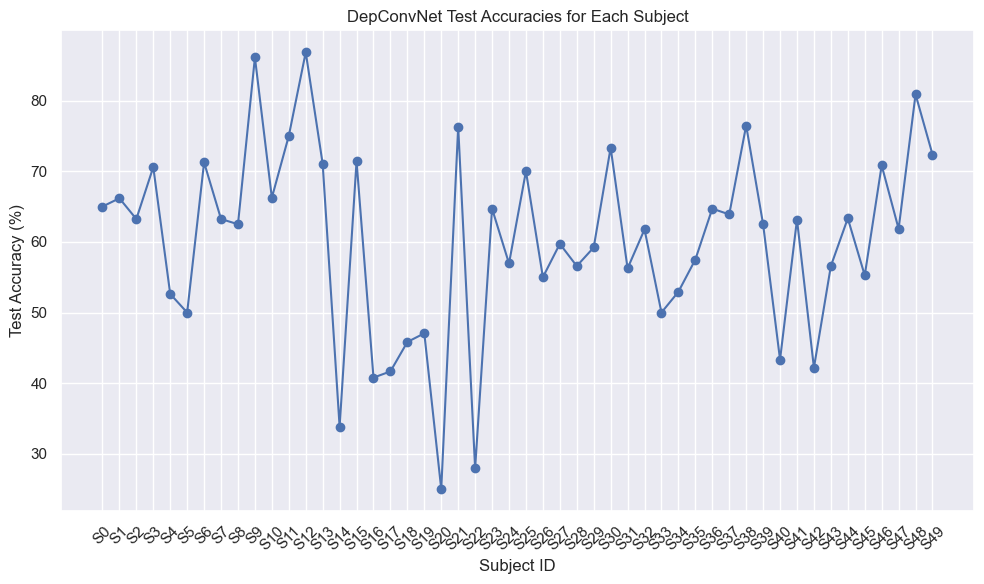

In [ ]:
# plot all test accuracies
plt.figure(figsize=(10, 6))
plt.plot(all_test_accuracies, marker='o', linestyle='-')
plt.title('DepConvNet Test Accuracies for Each Subject')
plt.xlabel('Subject ID')
plt.ylabel('Test Accuracy (%)')
plt.xticks(range(n_subjects), [f'S{i}' for i in range(n_subjects)], rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(output_path, 'DCN_test_accuracies.png'))


In [ ]:
# plot mean and std of train and val accuracies
mean_train_accuracies = np.mean(all_train_accuracies, axis=0)
mean_val_accuracies = np.mean(all_val_accuracies, axis=0)
std_train_accuracies = np.std(all_train_accuracies, axis=0)
std_val_accuracies = np.std(all_val_accuracies, axis=0)
df = pd.DataFrame({
    'Epoch': np.arange(1, len(mean_train_accuracies) + 1),
    'Train Accuracy': all_train_accuracies,
    'Val Accuracy': all_val_accuracies,
    'Train loss': all_train_losses,
    'Val loss': all_val_losses
})

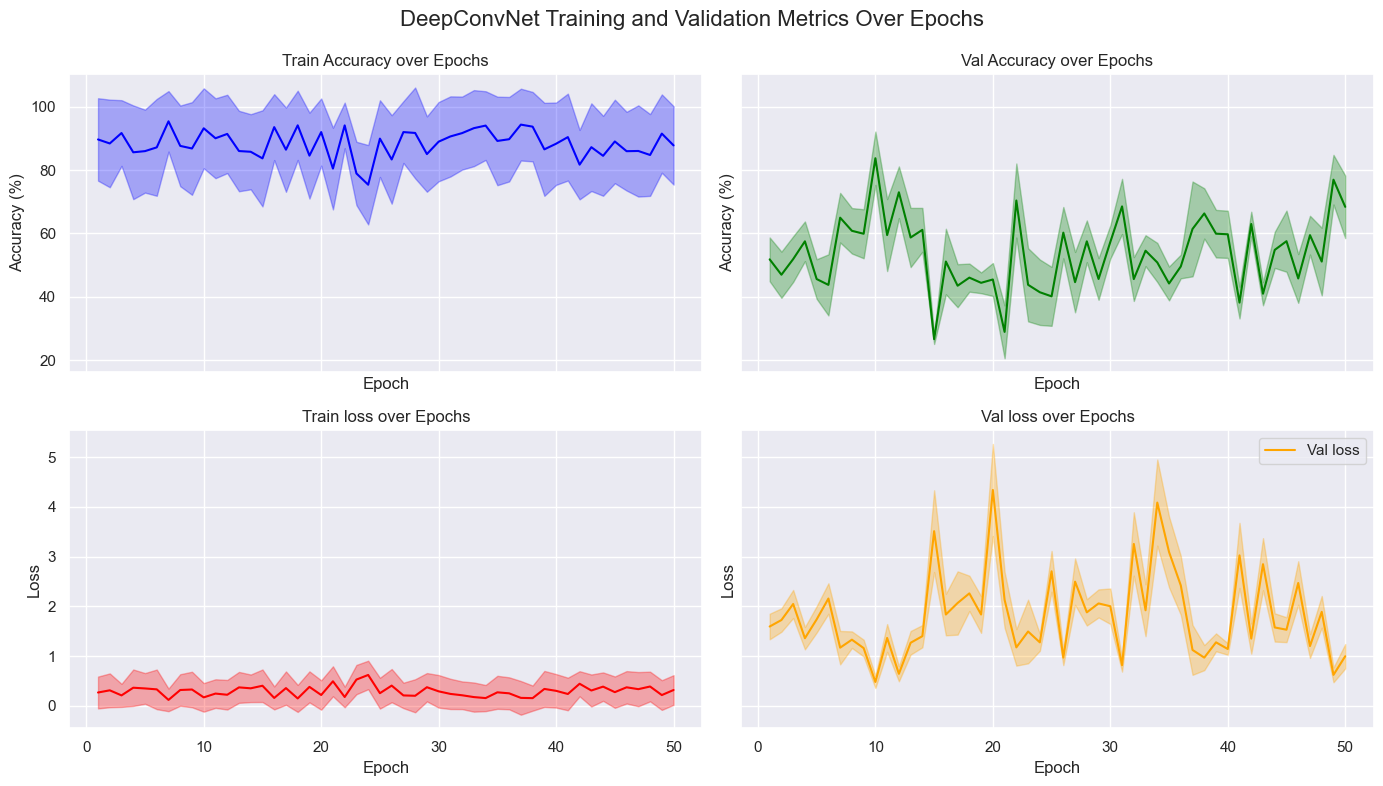

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Example structure: list of lists (n_epochs x n_subjects/runs)
# If not already, ensure each column is a list of lists
# For example:
# df['Train Accuracy'] = [ [acc1, acc2, ..., accN] at epoch 1, [...], ...]

# Compute mean and std for each metric across epochs
metrics = ['Train Accuracy', 'Val Accuracy', 'Train loss', 'Val loss']
mean_std_df = pd.DataFrame({'Epoch': df['Epoch']})

for metric in metrics:
    values = np.array(df[metric].tolist())  # shape: (n_epochs, n_subjects)
    mean_std_df[f"{metric} Mean"] = values.mean(axis=1)
    mean_std_df[f"{metric} Std"] = values.std(axis=1)

# --- Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey='row')
fig.suptitle('DeepConvNet Training and Validation Metrics Over Epochs', fontsize=16)

plot_params = [
    ("Train Accuracy", axes[0, 0], "blue"),
    ("Val Accuracy", axes[0, 1], "green"),
    ("Train loss", axes[1, 0], "red"),
    ("Val loss", axes[1, 1], "orange"),
]

for metric, ax, color in plot_params:
    mean = mean_std_df[f"{metric} Mean"]
    std = mean_std_df[f"{metric} Std"]
    epoch = mean_std_df["Epoch"]

    ax.plot(epoch, mean, label=metric, color=color)
    ax.fill_between(epoch, mean - std, mean + std, color=color, alpha=0.3)
    ax.set_title(f"{metric} over Epochs")
    ax.set_xlabel("Epoch")
    ylabel = "Accuracy (%)" if "Accuracy" in metric else "Loss"
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.savefig(os.path.join(output_path, 'DCN_training_validation_metrics.png'))
plt.legend()
plt.subplots_adjust(top=0.9)  # Adjust top to make room for the suptitle
plt.show()


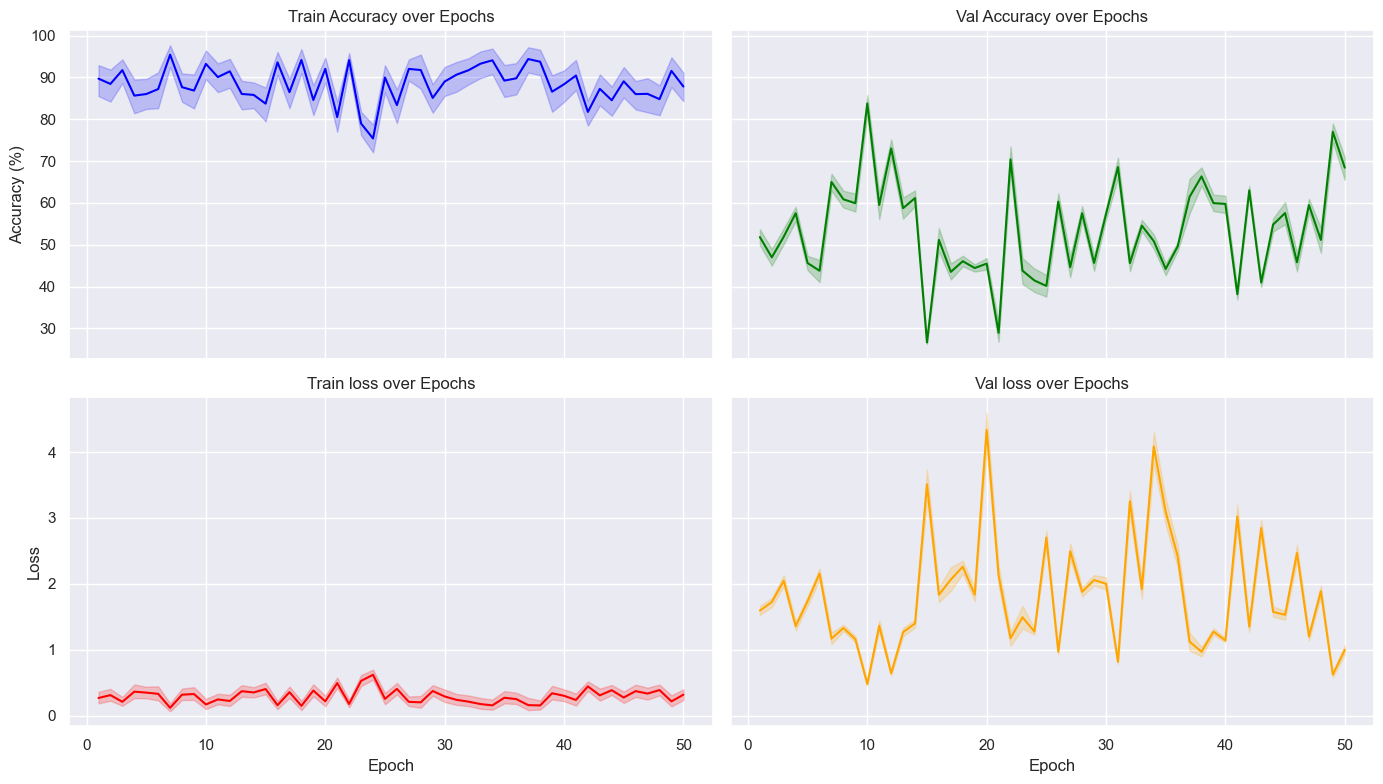

In [ ]:

metrics = ['Train Accuracy', 'Val Accuracy', 'Train loss', 'Val loss']

# Prepare flattened data per metric for CI calculation
long_dfs = {}
for metric in metrics:
    rows = []
    for epoch_idx, values in enumerate(df[metric]):
        for v in values:
            rows.append({'Epoch': epoch_idx + 1, 'Value': v})
    long_dfs[metric] = pd.DataFrame(rows)

# Set up 2x2 subplots with row-wise shared y-axis
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey='row')

plot_params = [
    ("Train Accuracy", axes[0, 0], "blue"),
    ("Val Accuracy", axes[0, 1], "green"),
    ("Train loss", axes[1, 0], "red"),
    ("Val loss", axes[1, 1], "orange"),
]

for metric, ax, color in plot_params:
    data = long_dfs[metric]
    
    # Lineplot with CI shading (default 95% CI)
    sns.lineplot(data=data, x="Epoch", y="Value", ax=ax, color=color, errorbar=('ci', 95))

    # Titles and labels
    ax.set_title(f"{metric} over Epochs")
    ax.set_xlabel("Epoch")
    ylabel = "Accuracy (%)" if "Accuracy" in metric else "Loss"
    ax.set_ylabel(ylabel)
    ax.grid(True)

plt.tight_layout()
plt.show()


# Get Microstates

In [3]:
rest_ch_ls = ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3',
                'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6',
                'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5',
                'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz',
                'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'F2']
sampling_rate = 250 # Hz

In [45]:
# all_gfp_peaks = []
# all_epochs = []
for i, data in enumerate(all_data):
    print(f"GFP subject {i}")

    eeg_data = np.array(data)

    info = mne.create_info(ch_names=rest_ch_ls, sfreq=sampling_rate, ch_types='eeg')
    montage = mne.channels.make_standard_montage('standard_1020')
    info.set_montage(montage)

    # Remove singleton dimension (if shape is (n_trials, 1, n_channels, n_times))
    eeg_data = eeg_data[:, 0, :, :]  # shape becomes (n_trials, n_channels, n_times)

    # Create MNE Epochs object
    epochs = mne.EpochsArray(eeg_data, info)
    # Extract Global Field Power (GFP) peaks to reduce number of samples
    gfp_peaks = extract_gfp_peaks(epochs)
    # all_gfp_peaks.append(gfp_peaks)
    # Save epochs to file
    if do_all:
        id_name = '_all'
    else:
        id_name = f'{i:03d}'  # Format id as three digits
    epochs_path = os.path.join(output_path, 'epochs/')
    if not os.path.exists(epochs_path):
        os.makedirs(epochs_path)

    epochs_file = os.path.join(epochs_path, f'epochs_s{id_name}.pkl')

    # pickle save all epochs
    with open(epochs_file, 'wb') as f:
        pickle.dump(epochs, f)

    gfp_path = '../Output/ica_rest_all/gfp_peaks/'
    if not os.path.exists(gfp_path):
        os.makedirs(gfp_path)

    gfp_file = os.path.join(gfp_path, f'gfp_peaks_s{id_name}.pkl')
    with open(gfp_file, 'wb') as f:
        pickle.dump(gfp_peaks, f)
    
    # all_epochs.append(epochs)

# # Save epochs to file
# output_file = os.path.join(output_path, 'all_epochs.pkl')

# # pickle save all epochs
# with open(output_file, 'wb') as f:
#     pickle.dump(all_epochs, f)


GFP subject 0
Not setting metadata
17920 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
# gfp_path = '../Output/ica_rest_all/gfp_peaks/'

# gfp = np.load(os.path.join(gfp_path, 'gfp_peaks_s001.npy'), allow_pickle=True)
# gfp

array(< ChData | 48083 samples >, dtype=object)

In [ ]:
# with open(os.path.join(gfp_path, 'gfp_peaks_s000.pkl'), 'rb') as f:
#     gfp_peaks = pickle.load(f)
# gfp_peaks

< ChData | 55728 samples >

In [ ]:
# all_gfp_peaks = np.load(os.path.join(output_path, 'all_gfp_peaks.npy'), allow_pickle=True)
# all_gfp_peaks

array([< ChData | 55728 samples >, < ChData | 48083 samples >,
       < ChData | 49132 samples >, < ChData | 62143 samples >,
       < ChData | 64289 samples >, < ChData | 51751 samples >,
       < ChData | 57615 samples >, < ChData | 54059 samples >,
       < ChData | 62974 samples >, < ChData | 60624 samples >,
       < ChData | 59839 samples >, < ChData | 49165 samples >,
       < ChData | 66062 samples >, < ChData | 58396 samples >,
       < ChData | 44017 samples >, < ChData | 38755 samples >,
       < ChData | 58163 samples >, < ChData | 62075 samples >,
       < ChData | 49297 samples >, < ChData | 52403 samples >,
       < ChData | 41037 samples >, < ChData | 43143 samples >,
       < ChData | 43557 samples >, < ChData | 37297 samples >,
       < ChData | 56420 samples >, < ChData | 52411 samples >,
       < ChData | 49193 samples >, < ChData | 66948 samples >,
       < ChData | 64265 samples >, < ChData | 61510 samples >,
       < ChData | 48938 samples >, < ChData | 52269 sam

In [ ]:
# output_path = '../Output/ica_rest_all/kmeans_results.npy'
# all_subjects = []
# all_scores = []
# all_kmeans_models = []
# all_microstate_sequences = []

# kmeans_results = {
#     'subjects_list': all_subjects,
#     'scores': all_scores,
#     'kmeans_models': all_kmeans_models,
#     'microstate_sequences': all_microstate_sequences
# }

# np.save(output_path, kmeans_results)
# print(f"Results saved to {output_path} at subject {0}")

Results saved to ../Output/ica_rest_all/kmeans_results.npy at subject 0


In [ ]:
kmeans_data

{'scores': {'GEV': np.float64(0.5908645117386971),
  'Silhouette': 0.4076607033055372,
  'Calinski-Harabasaz': 5305.147784212904,
  'Dunn': np.float64(7.892723902794189e-12),
  'Davies-Bouldin': np.float64(33.6975117343366)},
 'kmeans_model': <ModKMeans | fitted on n = 5 cluster centers>,
 'microstate_sequence': <EpochsSegmentation | n = 5 cluster centers | EpochsArray | 400 events (all good), 0 – 3.996 s (baseline off), ~186.2 MiB, data loaded,
  '1': 400>}

In [ ]:
kmeans_path = '../Output/ica_rest_all/modkmeans_results/'
# kmeans_results = np.load(output_path, allow_pickle=True).item()
kmeans_results = {
    'subjects_list': [],
    # 'scores': [],
    'kmeans_models': [],
    'microstate_sequence': []
}
for i in range(50):
    id_name = f'{i:03d}'  # Format id as three digits
    kmeans_file = os.path.join(kmeans_path, f'modkmeans_s{id_name}.npy')
    if not os.path.exists(kmeans_file):
        print(f"File {kmeans_file} does not exist. Skipping subject {id_name}.")
        continue
    print(f"Loading kmeans results for subject {id_name} from {kmeans_file}")
    kmeans_data = np.load(kmeans_file, allow_pickle=True).item()
    kmeans_results['subjects_list'].append(i)
    # kmeans_results['scores'].append(kmeans_data['scores'])
    kmeans_results['kmeans_models'].append(kmeans_data['kmeans_model'])
    kmeans_results['microstate_sequence'].append(kmeans_data['microstate_sequence'])
# Save the kmeans results
output_file = os.path.join(kmeans_path,'kmeans_results.npy')
np.save(output_file, kmeans_results)
print(f"All kmeans results saved to {output_file}")

Loading kmeans results for subject 000 from ../Output/ica_rest_all/modkmeans_results/modkmeans_s000.npy
Loading kmeans results for subject 001 from ../Output/ica_rest_all/modkmeans_results/modkmeans_s001.npy
Loading kmeans results for subject 002 from ../Output/ica_rest_all/modkmeans_results/modkmeans_s002.npy
Loading kmeans results for subject 003 from ../Output/ica_rest_all/modkmeans_results/modkmeans_s003.npy
Loading kmeans results for subject 004 from ../Output/ica_rest_all/modkmeans_results/modkmeans_s004.npy
Loading kmeans results for subject 005 from ../Output/ica_rest_all/modkmeans_results/modkmeans_s005.npy
Loading kmeans results for subject 006 from ../Output/ica_rest_all/modkmeans_results/modkmeans_s006.npy
Loading kmeans results for subject 007 from ../Output/ica_rest_all/modkmeans_results/modkmeans_s007.npy
Loading kmeans results for subject 008 from ../Output/ica_rest_all/modkmeans_results/modkmeans_s008.npy
Loading kmeans results for subject 009 from ../Output/ica_rest_a

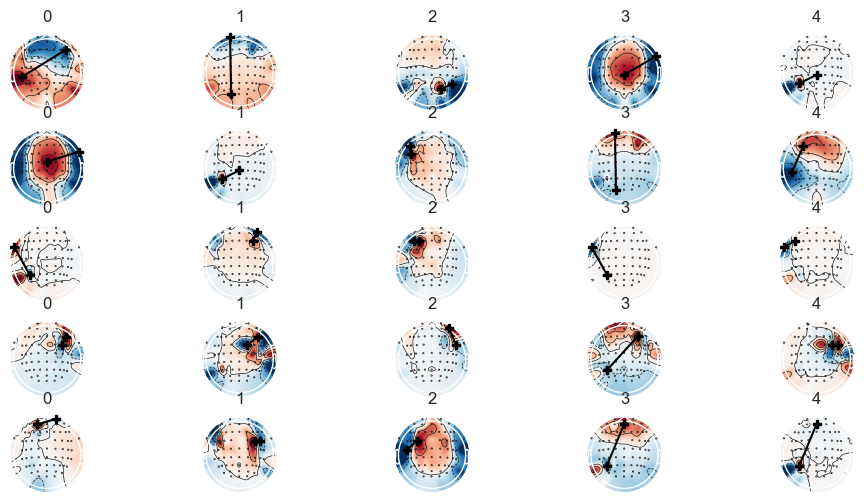

In [ ]:
fig, axes = plt.subplots(5, len(kmeans_results['subjects_list']), figsize=(12, 6))

for ax, kmeans_model in zip(axes, kmeans_results['kmeans_models']):
    kmeans_model.plot(show_gradient=True, show=False, axes=ax)

In [ ]:
# ms_ls = []
# kmeans_results_file = os.path.join(kmeans_path, 'kmeans_results.npy')
# if not os.path.exists(kmeans_results_file):
#     print(f"File {kmeans_results_file} does not exist. Skipping loading microstate sequences.")
# kmeans_results = np.load(kmeans_results_file, allow_pickle=True).item()
# ms_ls = kmeans_results['microstate_sequence']

# ms_gfp_ls = []
# for i, ms in enumerate(ms_ls):
#     print(f"Microstate sequence for subject {i}: {ms}")
#     id_name = f'{i:03d}'  # Format id as three digits
#     epochs_path = os.path.join('../output/ica_rest_all', 'epochs/')
#     epochs_file = os.path.join(epochs_path, f'epochs_s{id_name}.pkl')
#     with open(epochs_file, 'rb') as f:
#         epochs = pickle.load(f)
#     gfps = np.std(epochs.get_data(), axis=1)  # Compute standard deviation across time for each channel
#     # kmeans_model = kmeans_results['kmeans_models'][i]
# #     segmentation = kmeans_model.predict(epochs, reject_by_annotation=True, factor=10,
# #                                 half_window_size=10, min_segment_length=5,
# #                                 reject_edges=True)
#     df_ms = []
#     for j in range(len(ms.labels)):
#         df_ms.append(np.stack([ms.labels[j], gfps[j]], axis=0))
#     ms_gfp_ls.append(df_ms)
#     # segmentation.plot(show=True)
#     # plt.grid(False)
#     # plt.close()
#     # d = segmentation.compute_parameters()
#     # d['subject_id'] = id_name
#     # ms_data.append(d)



Microstate sequence for subject 0: <EpochsSegmentation | n = 5 cluster centers | EpochsArray | 400 events (all good), 0 – 3.996 s (baseline off), ~186.2 MiB, data loaded,
 '1': 400>
Microstate sequence for subject 1: <EpochsSegmentation | n = 5 cluster centers | EpochsArray | 340 events (all good), 0 – 3.996 s (baseline off), ~158.3 MiB, data loaded,
 '1': 340>
Microstate sequence for subject 2: <EpochsSegmentation | n = 5 cluster centers | EpochsArray | 340 events (all good), 0 – 3.996 s (baseline off), ~158.3 MiB, data loaded,
 '1': 340>
Microstate sequence for subject 3: <EpochsSegmentation | n = 5 cluster centers | EpochsArray | 340 events (all good), 0 – 3.996 s (baseline off), ~158.3 MiB, data loaded,
 '1': 340>
Microstate sequence for subject 4: <EpochsSegmentation | n = 5 cluster centers | EpochsArray | 380 events (all good), 0 – 3.996 s (baseline off), ~176.9 MiB, data loaded,
 '1': 380>
Microstate sequence for subject 5: <EpochsSegmentation | n = 5 cluster centers | EpochsArr

### Process data for features extraction

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# finals_ls = []
# for i, ms in enumerate(ms_gfp_ls):
#     # ms is a list of microstate sequences for subject i
#     # Convert to numpy array for easier manipulation
#     data = np.array(ms)  # Example data, shape: (n_trials, 2, timepoints)


#     # Step 1: Extract categorical values (row 1)
#     labels = data[:, 0, :]  # shape: (n_trials, timepoints)

#     # Step 2: Flatten for one-hot encoding
#     flat_labels = labels.reshape(-1, 1)

#     # Step 3: One-hot encode
#     encoder = OneHotEncoder(sparse_output=False)
#     one_hot = encoder.fit_transform(flat_labels)  # shape: (n_trials * timepoints, n_classes)

#     # Step 4: Reshape back
#     n_trials, timepoints = labels.shape
#     n_classes = one_hot.shape[1]
#     one_hot_reshaped = one_hot.reshape(n_trials, timepoints, n_classes).transpose(0, 2, 1)  # (n_trials, n_classes, timepoints)

#     # Step 5: Concatenate with first channel (row 0)
#     first_channel = data[:, [0], :]  # shape: (n_trials, 1, timepoints)
#     final = np.concatenate([first_channel, one_hot_reshaped], axis=1)  # (n_trials, 1 + n_classes, timepoints)
#     # might need to drop row of -1/ unknown microstate
#     finals_ls.append(final)

In [ ]:
# ms_timeseries_path = os.path.join(output_path, 'ms_timeseries.npy')
# with open(ms_timeseries_path, 'wb') as f:
#     # Save the list of numpy arrays
#     pickle.dump(finals_ls, f)

In [4]:
ms_timeseries_path = os.path.join(output_path, 'ms_timeseries.npy')
with open(ms_timeseries_path, 'rb') as f:
    finals_ls = pickle.load(f)

## DCN on one hot coded

In [16]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)



In [ ]:
from braindecode.models import Deep4Net
from braindecode.classifier import EEGClassifier
import torch
import torch.nn as nn

# Parameters
n_channels = len(finals_ls[0][0])
input_window_samples = finals_ls[0].shape[2]
n_classes = len(torch.unique(torch.tensor(all_y[0])))
set_seed(42)
# Build model
deep_model = Deep4Net(
    n_chans=n_channels,
    n_classes=n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto'
)
deep_model = deep_model.to('cuda' if torch.cuda.is_available() else 'cpu')
# Wrap with EEGClassifier
model = EEGClassifier(
    deep_model,
    criterion=nn.NLLLoss(),
    optimizer=torch.optim.Adam,
    optimizer__lr=1e-3,
    train_split=None,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Prepare data
x = torch.tensor(finals_ls[0], dtype=torch.float32).squeeze(1)  # shape: (n_trials, electrodes, timepoints)
y_true = torch.tensor(all_y[0], dtype=torch.long)  # shape: (n_trials,)           # (n_trials,)

# Move input to model's device
x = x.to(model.device)
y_true = y_true.to(model.device)

# Inference
model.initialize()  # Initialize the model parameters

with torch.no_grad():
    predictions = model.predict(x)               # (n_trials,)
    probabilities = model.predict_proba(x)       # (n_trials, n_classes)

# Accuracy
accuracy = (predictions == y_true.cpu()).float().mean().item()

print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 47.25%


In [ ]:
# Assuming:
# all_data[0]: (n_trials, 1, n_electrodes, timepoints)
# all_y: (1, n_trials) or (n_trials,)
from sklearn.model_selection import train_test_split
x = torch.tensor(finals_ls[0], dtype=torch.float32).squeeze(1)  # shape: (n_trials, n_electrodes, timepoints)
y = torch.tensor(all_y[0], dtype=torch.long)

# Split 80% train_val and 20% test
x_trainval, x_test, y_trainval, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

# Split train_val into 75% train and 25% val → final:
# Train: 60%, Val: 20%, Test: 20%
x_train, x_val, y_train, y_val = train_test_split(
    x_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

print(f"Train size: {len(x_train)}")
print(f"Val size: {len(x_val)}")
print(f"Test size: {len(x_test)}")

Train size: 240
Val size: 80
Test size: 80


In [ ]:


batch_size = 32

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(42)

# Build base Deep4Net model
base_model = Deep4Net(
    n_chans=x.shape[1],          # number of EEG channels
    n_classes=len(torch.unique(y)),
    input_window_samples=x.shape[2],
    final_conv_length='auto'
)

# Wrap in EEGClassifier
model = EEGClassifier(
    base_model,
    criterion=nn.NLLLoss(),
    optimizer=torch.optim.Adam,
    optimizer__lr=1e-3,
    train_split=None,
    device=device
)

# Access core PyTorch model for manual training
net = model.module.to(device)

# Manually create optimizer and criterion (don’t use model.optimizer here)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.NLLLoss()

num_epochs = 50

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Train
    net.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = net(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_x.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()
        train_total += batch_y.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validate
    net.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = net(batch_x)
            loss = criterion(outputs, batch_y)

            val_loss += loss.item() * batch_x.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == batch_y).sum().item()
            val_total += batch_y.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 1/50: Train Loss: 1.1128, Train Acc: 51.25%, Val Loss: 1.0594, Val Acc: 27.50%
Epoch 2/50: Train Loss: 0.8904, Train Acc: 59.17%, Val Loss: 1.0004, Val Acc: 48.75%
Epoch 3/50: Train Loss: 0.9404, Train Acc: 59.58%, Val Loss: 0.8299, Val Acc: 58.75%
Epoch 4/50: Train Loss: 0.8295, Train Acc: 64.58%, Val Loss: 0.9066, Val Acc: 52.50%
Epoch 5/50: Train Loss: 0.7942, Train Acc: 62.08%, Val Loss: 1.1413, Val Acc: 52.50%
Epoch 6/50: Train Loss: 0.6945, Train Acc: 65.83%, Val Loss: 1.6449, Val Acc: 50.00%
Epoch 7/50: Train Loss: 0.7370, Train Acc: 68.33%, Val Loss: 1.4096, Val Acc: 48.75%
Epoch 8/50: Train Loss: 0.8816, Train Acc: 63.75%, Val Loss: 1.5462, Val Acc: 48.75%
Epoch 9/50: Train Loss: 0.8607, Train Acc: 63.75%, Val Loss: 1.6537, Val Acc: 48.75%
Epoch 10/50: Train Loss: 0.7712, Train Acc: 65.83%, Val Loss: 1.3918, Val Acc: 48.75%
Epoch 11/50: Train Loss: 0.7223, Train Acc: 67.92%, Val Loss: 1.8421, Val Acc: 50.00%
Epoch 12/50: Train Loss: 0.7197, Train Acc: 69.17%, Val Loss: 1

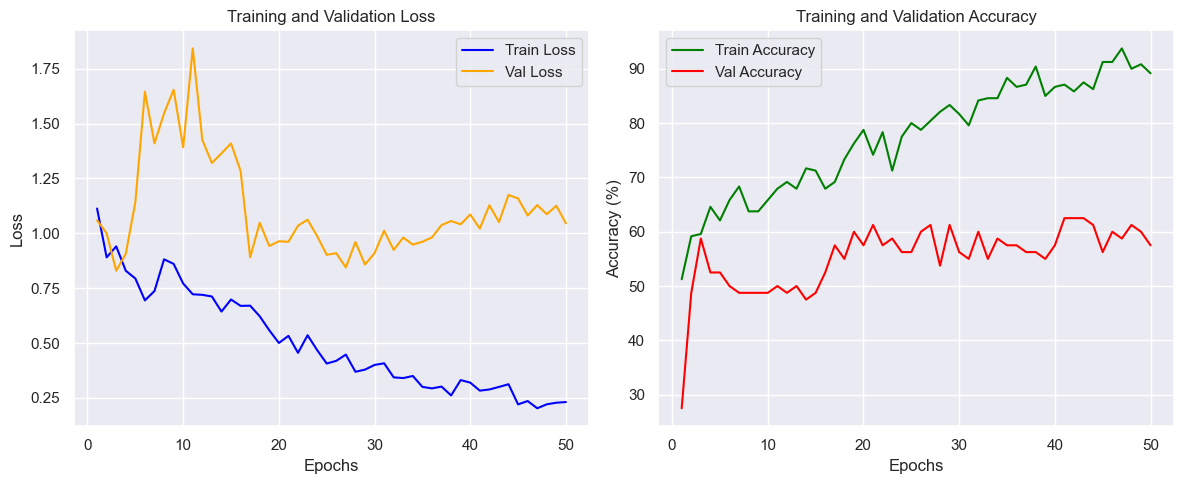

In [ ]:
# plot training and validation loss and accuracy
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Val Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy', color='green')
    plt.plot(epochs, val_accs, label='Val Accuracy', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Collect training history
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
test_correct = 0
test_total = 0
model.module.eval()  # put the underlying model in eval mode
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model.module(batch_x)  # <-- here!
        preds = outputs.argmax(dim=1)
        test_correct += (preds == batch_y).sum().item()
        test_total += batch_y.size(0)

test_acc = test_correct / test_total * 100
print(f"Test accuracy: {test_acc:.2f}%")


Test accuracy: 60.00%


### On all subjects

In [23]:
# investigating the data splits and class counts
all_split = {}
for id in range(len(finals_ls)):
    x = torch.tensor(finals_ls[id], dtype=torch.float32).squeeze(1)  # (n_trials, n_channels, timepoints)
    y = torch.tensor(all_y[id], dtype=torch.long)

    # Train/val/test split
    from sklearn.model_selection import train_test_split
    x_trainval, x_test, y_trainval, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y)
    x_train, x_val, y_train, y_val = train_test_split(
        x_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)
    all_split[id] = {
        'x_train': x_train,
        'y_train': y_train,
        'x_val': x_val,
        'y_val': y_val,
        'x_test': x_test,
        'y_test': y_test
    }
    batch_size = 32
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)
    
# get counts of all classes in all_y_test
all_y_test = []
for id in range(len(all_split)):
    all_y_test.append(all_split[id]['y_test']) 
    
all_y_test = torch.cat(all_y_test)
class_counts = torch.bincount(all_y_test)
print("Class counts in all test sets:", class_counts)
# get counts of all classes in all_y_test for each subject
for id in range(len(all_split)):
    y_test = all_split[id]['y_test']
    class_counts = torch.bincount(y_test)
    print(f"Subject {id} class counts in test set:", class_counts)

Class counts in all test sets: tensor([1792,  896,  896])
Subject 0 class counts in test set: tensor([40, 20, 20])
Subject 1 class counts in test set: tensor([34, 17, 17])
Subject 2 class counts in test set: tensor([34, 17, 17])
Subject 3 class counts in test set: tensor([34, 17, 17])
Subject 4 class counts in test set: tensor([38, 19, 19])
Subject 5 class counts in test set: tensor([34, 17, 17])
Subject 6 class counts in test set: tensor([40, 20, 20])
Subject 7 class counts in test set: tensor([34, 17, 17])
Subject 8 class counts in test set: tensor([36, 18, 18])
Subject 9 class counts in test set: tensor([36, 18, 18])
Subject 10 class counts in test set: tensor([40, 20, 20])
Subject 11 class counts in test set: tensor([36, 18, 18])
Subject 12 class counts in test set: tensor([38, 19, 19])
Subject 13 class counts in test set: tensor([38, 19, 19])
Subject 14 class counts in test set: tensor([34, 17, 17])
Subject 15 class counts in test set: tensor([28, 14, 14])
Subject 16 class counts 

Class counts in all test sets: tensor([1792,  896,  896])


Subject 0 class counts in test set: tensor([40, 20, 20])
Subject 1 class counts in test set: tensor([34, 17, 17])
Subject 2 class counts in test set: tensor([34, 17, 17])
Subject 3 class counts in test set: tensor([34, 17, 17])
Subject 4 class counts in test set: tensor([38, 19, 19])
Subject 5 class counts in test set: tensor([34, 17, 17])
Subject 6 class counts in test set: tensor([40, 20, 20])
Subject 7 class counts in test set: tensor([34, 17, 17])
Subject 8 class counts in test set: tensor([36, 18, 18])
Subject 9 class counts in test set: tensor([36, 18, 18])
Subject 10 class counts in test set: tensor([40, 20, 20])
Subject 11 class counts in test set: tensor([36, 18, 18])
Subject 12 class counts in test set: tensor([38, 19, 19])
Subject 13 class counts in test set: tensor([38, 19, 19])
Subject 14 class counts in test set: tensor([34, 17, 17])
Subject 15 class counts in test set: tensor([28, 14, 14])
Subject 16 class counts in test set: tensor([38, 19, 19])
Subject 17 class counts 

In [ ]:
set_seed(42)
all_train_accuracies = []
all_train_losses = []
all_test_accuracies = []
all_val_accuracies = []
all_val_losses = []
all_models = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for id in range(len(finals_ls)):
    x = torch.tensor(finals_ls[id], dtype=torch.float32).squeeze(1)  # (n_trials, n_channels, timepoints)
    y = torch.tensor(all_y[id], dtype=torch.long)

    # Train/val/test split
    from sklearn.model_selection import train_test_split
    x_trainval, x_test, y_trainval, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y)
    x_train, x_val, y_train, y_val = train_test_split(
        x_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

    batch_size = 32
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

    set_seed(42)
    base_model = Deep4Net(
        n_chans=x.shape[1],
        n_classes=len(torch.unique(y)),
        input_window_samples=x.shape[2],
        final_conv_length='auto'
    )
    model = EEGClassifier(
        base_model,
        criterion=nn.NLLLoss(),
        optimizer=torch.optim.Adam,
        optimizer__lr=0.001,
        train_split=None,
        device=device
    )

    # Get the underlying PyTorch model for training
    net = model.module.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    criterion = nn.NLLLoss()

    num_epochs = 100

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Train
        net.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = net(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_x.size(0)
            preds = outputs.argmax(dim=1)
            train_correct += (preds == batch_y).sum().item()
            train_total += batch_y.size(0)

        train_loss /= train_total
        train_acc = train_correct / train_total * 100
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validate
        net.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = net(batch_x)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item() * batch_x.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == batch_y).sum().item()
                val_total += batch_y.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total * 100
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Subject {id} Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Test
    net.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = net(batch_x)
            preds = outputs.argmax(dim=1)
            test_correct += (preds == batch_y).sum().item()
            test_total += batch_y.size(0)

    test_acc = test_correct / test_total * 100
    print(f"Subject {id} Test accuracy: {test_acc:.2f}%")

    all_train_accuracies.append(train_accuracies)
    all_train_losses.append(train_losses)
    all_test_accuracies.append(test_acc)
    all_val_accuracies.append(val_accuracies)
    all_val_losses.append(val_losses)
    all_models.append(model)


c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 0 Epoch 1/100: Train Loss: 1.1862, Train Acc: 51.25%, Val Loss: 0.9084, Val Acc: 50.00%
Subject 0 Epoch 2/100: Train Loss: 1.0183, Train Acc: 52.50%, Val Loss: 1.0527, Val Acc: 53.75%
Subject 0 Epoch 3/100: Train Loss: 0.9710, Train Acc: 57.08%, Val Loss: 1.2812, Val Acc: 48.75%
Subject 0 Epoch 4/100: Train Loss: 0.9697, Train Acc: 56.67%, Val Loss: 1.1819, Val Acc: 47.50%
Subject 0 Epoch 5/100: Train Loss: 0.8377, Train Acc: 66.25%, Val Loss: 1.2289, Val Acc: 52.50%
Subject 0 Epoch 6/100: Train Loss: 0.8199, Train Acc: 60.83%, Val Loss: 1.4841, Val Acc: 50.00%
Subject 0 Epoch 7/100: Train Loss: 0.8719, Train Acc: 61.67%, Val Loss: 1.6204, Val Acc: 51.25%
Subject 0 Epoch 8/100: Train Loss: 0.8302, Train Acc: 61.25%, Val Loss: 1.3041, Val Acc: 50.00%
Subject 0 Epoch 9/100: Train Loss: 0.9411, Train Acc: 56.67%, Val Loss: 1.1986, Val Acc: 51.25%
Subject 0 Epoch 10/100: Train Loss: 0.7724, Train Acc: 64.17%, Val Loss: 1.0253, Val Acc: 55.00%
Subject 0 Epoch 11/100: Train Loss: 0.8

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 1 Epoch 2/100: Train Loss: 1.0763, Train Acc: 49.02%, Val Loss: 2.0718, Val Acc: 48.53%
Subject 1 Epoch 3/100: Train Loss: 0.9779, Train Acc: 53.43%, Val Loss: 2.4976, Val Acc: 52.94%
Subject 1 Epoch 4/100: Train Loss: 1.0644, Train Acc: 57.35%, Val Loss: 2.2523, Val Acc: 52.94%
Subject 1 Epoch 5/100: Train Loss: 0.9782, Train Acc: 57.35%, Val Loss: 2.4481, Val Acc: 51.47%
Subject 1 Epoch 6/100: Train Loss: 0.8711, Train Acc: 64.22%, Val Loss: 2.0860, Val Acc: 54.41%
Subject 1 Epoch 7/100: Train Loss: 0.8931, Train Acc: 64.22%, Val Loss: 1.9256, Val Acc: 51.47%
Subject 1 Epoch 8/100: Train Loss: 0.7448, Train Acc: 65.20%, Val Loss: 1.5267, Val Acc: 51.47%
Subject 1 Epoch 9/100: Train Loss: 0.8577, Train Acc: 61.27%, Val Loss: 1.7070, Val Acc: 50.00%
Subject 1 Epoch 10/100: Train Loss: 0.7391, Train Acc: 68.14%, Val Loss: 1.3672, Val Acc: 47.06%
Subject 1 Epoch 11/100: Train Loss: 0.8462, Train Acc: 62.75%, Val Loss: 1.8791, Val Acc: 42.65%
Subject 1 Epoch 12/100: Train Loss: 0.

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 2 Epoch 1/100: Train Loss: 1.2377, Train Acc: 46.08%, Val Loss: 0.9080, Val Acc: 48.53%
Subject 2 Epoch 2/100: Train Loss: 1.2375, Train Acc: 49.51%, Val Loss: 1.4880, Val Acc: 26.47%
Subject 2 Epoch 3/100: Train Loss: 1.1583, Train Acc: 49.02%, Val Loss: 2.9085, Val Acc: 25.00%
Subject 2 Epoch 4/100: Train Loss: 1.0046, Train Acc: 57.35%, Val Loss: 2.9398, Val Acc: 25.00%
Subject 2 Epoch 5/100: Train Loss: 1.0165, Train Acc: 59.80%, Val Loss: 2.7075, Val Acc: 25.00%
Subject 2 Epoch 6/100: Train Loss: 0.9123, Train Acc: 56.37%, Val Loss: 2.0416, Val Acc: 42.65%
Subject 2 Epoch 7/100: Train Loss: 0.8741, Train Acc: 60.29%, Val Loss: 2.2020, Val Acc: 41.18%
Subject 2 Epoch 8/100: Train Loss: 0.7457, Train Acc: 63.24%, Val Loss: 2.0137, Val Acc: 36.76%
Subject 2 Epoch 9/100: Train Loss: 0.7839, Train Acc: 68.63%, Val Loss: 1.8824, Val Acc: 33.82%
Subject 2 Epoch 10/100: Train Loss: 0.7689, Train Acc: 64.71%, Val Loss: 2.2078, Val Acc: 39.71%
Subject 2 Epoch 11/100: Train Loss: 0.7

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 3 Epoch 1/100: Train Loss: 1.4144, Train Acc: 35.29%, Val Loss: 1.1131, Val Acc: 29.41%
Subject 3 Epoch 2/100: Train Loss: 1.1506, Train Acc: 46.08%, Val Loss: 1.2712, Val Acc: 29.41%
Subject 3 Epoch 3/100: Train Loss: 1.1998, Train Acc: 50.49%, Val Loss: 0.9568, Val Acc: 47.06%
Subject 3 Epoch 4/100: Train Loss: 1.0940, Train Acc: 52.94%, Val Loss: 0.9024, Val Acc: 54.41%
Subject 3 Epoch 5/100: Train Loss: 0.9986, Train Acc: 53.92%, Val Loss: 0.8718, Val Acc: 52.94%
Subject 3 Epoch 6/100: Train Loss: 1.0047, Train Acc: 58.33%, Val Loss: 0.9368, Val Acc: 50.00%
Subject 3 Epoch 7/100: Train Loss: 1.1272, Train Acc: 48.04%, Val Loss: 0.9841, Val Acc: 51.47%
Subject 3 Epoch 8/100: Train Loss: 0.9415, Train Acc: 57.35%, Val Loss: 1.2084, Val Acc: 44.12%
Subject 3 Epoch 9/100: Train Loss: 0.9122, Train Acc: 58.82%, Val Loss: 1.3582, Val Acc: 44.12%
Subject 3 Epoch 10/100: Train Loss: 0.9034, Train Acc: 61.76%, Val Loss: 1.7053, Val Acc: 45.59%
Subject 3 Epoch 11/100: Train Loss: 0.9

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 4 Epoch 1/100: Train Loss: 1.2735, Train Acc: 50.44%, Val Loss: 1.2683, Val Acc: 25.00%
Subject 4 Epoch 2/100: Train Loss: 1.0448, Train Acc: 47.37%, Val Loss: 1.0158, Val Acc: 48.68%
Subject 4 Epoch 3/100: Train Loss: 0.9966, Train Acc: 54.39%, Val Loss: 1.0166, Val Acc: 46.05%
Subject 4 Epoch 4/100: Train Loss: 0.9930, Train Acc: 58.77%, Val Loss: 1.0575, Val Acc: 50.00%
Subject 4 Epoch 5/100: Train Loss: 0.9924, Train Acc: 52.63%, Val Loss: 1.5550, Val Acc: 50.00%
Subject 4 Epoch 6/100: Train Loss: 1.0106, Train Acc: 55.70%, Val Loss: 1.2523, Val Acc: 50.00%
Subject 4 Epoch 7/100: Train Loss: 0.9311, Train Acc: 53.51%, Val Loss: 1.4738, Val Acc: 50.00%
Subject 4 Epoch 8/100: Train Loss: 0.9764, Train Acc: 52.63%, Val Loss: 1.2781, Val Acc: 46.05%
Subject 4 Epoch 9/100: Train Loss: 0.9542, Train Acc: 57.02%, Val Loss: 1.5401, Val Acc: 50.00%
Subject 4 Epoch 10/100: Train Loss: 1.0338, Train Acc: 57.46%, Val Loss: 1.4266, Val Acc: 50.00%
Subject 4 Epoch 11/100: Train Loss: 1.1

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 5 Epoch 3/100: Train Loss: 0.9639, Train Acc: 59.80%, Val Loss: 1.9339, Val Acc: 39.71%
Subject 5 Epoch 4/100: Train Loss: 1.1057, Train Acc: 60.29%, Val Loss: 2.2655, Val Acc: 25.00%
Subject 5 Epoch 5/100: Train Loss: 1.0060, Train Acc: 63.24%, Val Loss: 2.4649, Val Acc: 27.94%
Subject 5 Epoch 6/100: Train Loss: 0.7889, Train Acc: 61.76%, Val Loss: 2.4869, Val Acc: 36.76%
Subject 5 Epoch 7/100: Train Loss: 0.8822, Train Acc: 63.24%, Val Loss: 1.8179, Val Acc: 39.71%
Subject 5 Epoch 8/100: Train Loss: 0.7118, Train Acc: 73.53%, Val Loss: 1.6026, Val Acc: 50.00%
Subject 5 Epoch 9/100: Train Loss: 0.7895, Train Acc: 65.20%, Val Loss: 1.6215, Val Acc: 55.88%
Subject 5 Epoch 10/100: Train Loss: 0.7446, Train Acc: 67.16%, Val Loss: 1.3514, Val Acc: 52.94%
Subject 5 Epoch 11/100: Train Loss: 0.7530, Train Acc: 67.16%, Val Loss: 1.6325, Val Acc: 48.53%
Subject 5 Epoch 12/100: Train Loss: 0.6019, Train Acc: 70.59%, Val Loss: 1.5336, Val Acc: 47.06%
Subject 5 Epoch 13/100: Train Loss: 0

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 6 Epoch 3/100: Train Loss: 0.9472, Train Acc: 55.00%, Val Loss: 2.6702, Val Acc: 25.00%
Subject 6 Epoch 4/100: Train Loss: 0.8760, Train Acc: 61.67%, Val Loss: 2.8471, Val Acc: 40.00%
Subject 6 Epoch 5/100: Train Loss: 0.8921, Train Acc: 60.83%, Val Loss: 2.5788, Val Acc: 38.75%
Subject 6 Epoch 6/100: Train Loss: 0.7745, Train Acc: 62.92%, Val Loss: 2.6004, Val Acc: 38.75%
Subject 6 Epoch 7/100: Train Loss: 0.9140, Train Acc: 59.58%, Val Loss: 2.4884, Val Acc: 40.00%
Subject 6 Epoch 8/100: Train Loss: 0.8570, Train Acc: 61.67%, Val Loss: 2.4376, Val Acc: 38.75%
Subject 6 Epoch 9/100: Train Loss: 0.8833, Train Acc: 62.92%, Val Loss: 2.7778, Val Acc: 43.75%
Subject 6 Epoch 10/100: Train Loss: 0.8947, Train Acc: 59.58%, Val Loss: 2.2323, Val Acc: 40.00%
Subject 6 Epoch 11/100: Train Loss: 0.6856, Train Acc: 69.58%, Val Loss: 2.3642, Val Acc: 47.50%
Subject 6 Epoch 12/100: Train Loss: 0.7110, Train Acc: 69.17%, Val Loss: 2.0362, Val Acc: 45.00%
Subject 6 Epoch 13/100: Train Loss: 0

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 7 Epoch 1/100: Train Loss: 1.2549, Train Acc: 45.59%, Val Loss: 1.3403, Val Acc: 25.00%
Subject 7 Epoch 2/100: Train Loss: 1.0442, Train Acc: 52.45%, Val Loss: 1.9840, Val Acc: 25.00%
Subject 7 Epoch 3/100: Train Loss: 1.0623, Train Acc: 56.37%, Val Loss: 2.8133, Val Acc: 25.00%
Subject 7 Epoch 4/100: Train Loss: 1.0901, Train Acc: 58.82%, Val Loss: 2.6684, Val Acc: 25.00%
Subject 7 Epoch 5/100: Train Loss: 0.9858, Train Acc: 61.76%, Val Loss: 2.5995, Val Acc: 26.47%
Subject 7 Epoch 6/100: Train Loss: 1.0951, Train Acc: 54.41%, Val Loss: 1.7358, Val Acc: 36.76%
Subject 7 Epoch 7/100: Train Loss: 1.0462, Train Acc: 56.37%, Val Loss: 1.7086, Val Acc: 44.12%
Subject 7 Epoch 8/100: Train Loss: 0.8339, Train Acc: 61.27%, Val Loss: 2.1357, Val Acc: 36.76%
Subject 7 Epoch 9/100: Train Loss: 0.7685, Train Acc: 66.18%, Val Loss: 2.0995, Val Acc: 41.18%
Subject 7 Epoch 10/100: Train Loss: 0.7588, Train Acc: 64.71%, Val Loss: 2.2016, Val Acc: 42.65%
Subject 7 Epoch 11/100: Train Loss: 0.7

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 8 Epoch 1/100: Train Loss: 1.4384, Train Acc: 43.98%, Val Loss: 1.0525, Val Acc: 41.67%
Subject 8 Epoch 2/100: Train Loss: 1.0501, Train Acc: 51.39%, Val Loss: 1.1125, Val Acc: 44.44%
Subject 8 Epoch 3/100: Train Loss: 0.9558, Train Acc: 59.26%, Val Loss: 1.2915, Val Acc: 52.78%
Subject 8 Epoch 4/100: Train Loss: 0.9345, Train Acc: 61.11%, Val Loss: 1.4967, Val Acc: 52.78%
Subject 8 Epoch 5/100: Train Loss: 0.8895, Train Acc: 61.57%, Val Loss: 1.3964, Val Acc: 44.44%
Subject 8 Epoch 6/100: Train Loss: 0.8863, Train Acc: 60.19%, Val Loss: 1.4273, Val Acc: 50.00%
Subject 8 Epoch 7/100: Train Loss: 0.8426, Train Acc: 64.81%, Val Loss: 1.6994, Val Acc: 36.11%
Subject 8 Epoch 8/100: Train Loss: 0.8181, Train Acc: 63.89%, Val Loss: 1.8330, Val Acc: 36.11%
Subject 8 Epoch 9/100: Train Loss: 0.9087, Train Acc: 64.81%, Val Loss: 2.0440, Val Acc: 45.83%
Subject 8 Epoch 10/100: Train Loss: 0.8145, Train Acc: 68.98%, Val Loss: 1.8090, Val Acc: 47.22%
Subject 8 Epoch 11/100: Train Loss: 0.8

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 9 Epoch 1/100: Train Loss: 1.3667, Train Acc: 45.37%, Val Loss: 1.2308, Val Acc: 25.00%
Subject 9 Epoch 2/100: Train Loss: 1.0444, Train Acc: 52.31%, Val Loss: 1.6111, Val Acc: 29.17%
Subject 9 Epoch 3/100: Train Loss: 0.9000, Train Acc: 55.56%, Val Loss: 1.6428, Val Acc: 37.50%
Subject 9 Epoch 4/100: Train Loss: 0.8512, Train Acc: 64.81%, Val Loss: 1.5247, Val Acc: 41.67%
Subject 9 Epoch 5/100: Train Loss: 0.9559, Train Acc: 58.33%, Val Loss: 1.1825, Val Acc: 48.61%
Subject 9 Epoch 6/100: Train Loss: 0.7525, Train Acc: 67.59%, Val Loss: 0.8504, Val Acc: 52.78%
Subject 9 Epoch 7/100: Train Loss: 0.8687, Train Acc: 64.35%, Val Loss: 1.4015, Val Acc: 45.83%
Subject 9 Epoch 8/100: Train Loss: 0.7576, Train Acc: 66.67%, Val Loss: 1.0421, Val Acc: 50.00%
Subject 9 Epoch 9/100: Train Loss: 0.8477, Train Acc: 63.89%, Val Loss: 1.4784, Val Acc: 50.00%
Subject 9 Epoch 10/100: Train Loss: 0.6852, Train Acc: 65.74%, Val Loss: 1.1255, Val Acc: 50.00%
Subject 9 Epoch 11/100: Train Loss: 0.7

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 10 Epoch 1/100: Train Loss: 1.1794, Train Acc: 49.17%, Val Loss: 1.3201, Val Acc: 45.00%
Subject 10 Epoch 2/100: Train Loss: 1.0324, Train Acc: 52.92%, Val Loss: 1.2516, Val Acc: 42.50%
Subject 10 Epoch 3/100: Train Loss: 0.9563, Train Acc: 57.50%, Val Loss: 1.4439, Val Acc: 50.00%
Subject 10 Epoch 4/100: Train Loss: 0.8546, Train Acc: 59.17%, Val Loss: 1.7796, Val Acc: 50.00%
Subject 10 Epoch 5/100: Train Loss: 0.8406, Train Acc: 60.42%, Val Loss: 1.8867, Val Acc: 50.00%
Subject 10 Epoch 6/100: Train Loss: 0.7093, Train Acc: 66.67%, Val Loss: 1.8664, Val Acc: 50.00%
Subject 10 Epoch 7/100: Train Loss: 0.9040, Train Acc: 58.33%, Val Loss: 1.9037, Val Acc: 51.25%
Subject 10 Epoch 8/100: Train Loss: 0.8331, Train Acc: 63.33%, Val Loss: 1.4640, Val Acc: 50.00%
Subject 10 Epoch 9/100: Train Loss: 0.8124, Train Acc: 60.83%, Val Loss: 1.8115, Val Acc: 51.25%
Subject 10 Epoch 10/100: Train Loss: 0.8548, Train Acc: 62.08%, Val Loss: 1.7216, Val Acc: 52.50%
Subject 10 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 11 Epoch 1/100: Train Loss: 1.2852, Train Acc: 44.44%, Val Loss: 1.0196, Val Acc: 43.06%
Subject 11 Epoch 2/100: Train Loss: 1.0192, Train Acc: 59.72%, Val Loss: 0.8458, Val Acc: 52.78%
Subject 11 Epoch 3/100: Train Loss: 0.9144, Train Acc: 58.80%, Val Loss: 0.8052, Val Acc: 56.94%
Subject 11 Epoch 4/100: Train Loss: 0.8409, Train Acc: 62.96%, Val Loss: 0.9505, Val Acc: 50.00%
Subject 11 Epoch 5/100: Train Loss: 0.9838, Train Acc: 53.70%, Val Loss: 0.9037, Val Acc: 55.56%
Subject 11 Epoch 6/100: Train Loss: 0.9862, Train Acc: 57.87%, Val Loss: 1.0274, Val Acc: 48.61%
Subject 11 Epoch 7/100: Train Loss: 0.8064, Train Acc: 63.43%, Val Loss: 1.0854, Val Acc: 47.22%
Subject 11 Epoch 8/100: Train Loss: 0.8546, Train Acc: 61.11%, Val Loss: 1.3888, Val Acc: 48.61%
Subject 11 Epoch 9/100: Train Loss: 0.9572, Train Acc: 55.09%, Val Loss: 1.1876, Val Acc: 48.61%
Subject 11 Epoch 10/100: Train Loss: 0.6983, Train Acc: 68.52%, Val Loss: 1.2909, Val Acc: 51.39%
Subject 11 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 12 Epoch 3/100: Train Loss: 1.0809, Train Acc: 54.39%, Val Loss: 2.1410, Val Acc: 35.53%
Subject 12 Epoch 4/100: Train Loss: 0.9925, Train Acc: 54.82%, Val Loss: 2.3199, Val Acc: 27.63%
Subject 12 Epoch 5/100: Train Loss: 1.1116, Train Acc: 55.26%, Val Loss: 2.8073, Val Acc: 26.32%
Subject 12 Epoch 6/100: Train Loss: 0.8738, Train Acc: 59.65%, Val Loss: 2.7627, Val Acc: 27.63%
Subject 12 Epoch 7/100: Train Loss: 1.0139, Train Acc: 57.89%, Val Loss: 2.3043, Val Acc: 28.95%
Subject 12 Epoch 8/100: Train Loss: 0.9955, Train Acc: 58.33%, Val Loss: 2.0806, Val Acc: 39.47%
Subject 12 Epoch 9/100: Train Loss: 0.9772, Train Acc: 58.33%, Val Loss: 1.2319, Val Acc: 44.74%
Subject 12 Epoch 10/100: Train Loss: 0.9997, Train Acc: 59.65%, Val Loss: 1.0721, Val Acc: 52.63%
Subject 12 Epoch 11/100: Train Loss: 1.0204, Train Acc: 57.89%, Val Loss: 1.0021, Val Acc: 39.47%
Subject 12 Epoch 12/100: Train Loss: 1.0016, Train Acc: 56.58%, Val Loss: 1.5049, Val Acc: 44.74%
Subject 12 Epoch 13/100: Tr

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 13 Epoch 1/100: Train Loss: 1.2458, Train Acc: 48.68%, Val Loss: 1.9872, Val Acc: 25.00%
Subject 13 Epoch 2/100: Train Loss: 1.0751, Train Acc: 52.19%, Val Loss: 3.2752, Val Acc: 25.00%
Subject 13 Epoch 3/100: Train Loss: 1.0026, Train Acc: 56.58%, Val Loss: 3.3959, Val Acc: 25.00%
Subject 13 Epoch 4/100: Train Loss: 0.9034, Train Acc: 63.60%, Val Loss: 2.5390, Val Acc: 25.00%
Subject 13 Epoch 5/100: Train Loss: 0.8589, Train Acc: 61.40%, Val Loss: 2.3112, Val Acc: 40.79%
Subject 13 Epoch 6/100: Train Loss: 0.9498, Train Acc: 58.77%, Val Loss: 2.2288, Val Acc: 40.79%
Subject 13 Epoch 7/100: Train Loss: 0.9528, Train Acc: 61.84%, Val Loss: 1.7603, Val Acc: 47.37%
Subject 13 Epoch 8/100: Train Loss: 0.7516, Train Acc: 66.23%, Val Loss: 1.5265, Val Acc: 35.53%
Subject 13 Epoch 9/100: Train Loss: 1.0313, Train Acc: 57.02%, Val Loss: 1.4589, Val Acc: 44.74%
Subject 13 Epoch 10/100: Train Loss: 0.8691, Train Acc: 62.28%, Val Loss: 1.9061, Val Acc: 51.32%
Subject 13 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 14 Epoch 2/100: Train Loss: 1.1305, Train Acc: 52.45%, Val Loss: 1.4737, Val Acc: 38.24%
Subject 14 Epoch 3/100: Train Loss: 1.0947, Train Acc: 50.49%, Val Loss: 1.2703, Val Acc: 48.53%
Subject 14 Epoch 4/100: Train Loss: 1.0195, Train Acc: 55.39%, Val Loss: 1.2191, Val Acc: 44.12%
Subject 14 Epoch 5/100: Train Loss: 0.8622, Train Acc: 58.82%, Val Loss: 1.2881, Val Acc: 50.00%
Subject 14 Epoch 6/100: Train Loss: 0.9434, Train Acc: 57.84%, Val Loss: 1.2454, Val Acc: 50.00%
Subject 14 Epoch 7/100: Train Loss: 0.9462, Train Acc: 52.45%, Val Loss: 1.1818, Val Acc: 51.47%
Subject 14 Epoch 8/100: Train Loss: 0.7945, Train Acc: 60.29%, Val Loss: 1.2271, Val Acc: 45.59%
Subject 14 Epoch 9/100: Train Loss: 0.7867, Train Acc: 58.82%, Val Loss: 1.2528, Val Acc: 45.59%
Subject 14 Epoch 10/100: Train Loss: 0.7654, Train Acc: 59.31%, Val Loss: 1.2346, Val Acc: 48.53%
Subject 14 Epoch 11/100: Train Loss: 0.8174, Train Acc: 57.35%, Val Loss: 1.3774, Val Acc: 45.59%
Subject 14 Epoch 12/100: Tra

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 15 Epoch 1/100: Train Loss: 1.0922, Train Acc: 50.00%, Val Loss: 1.6976, Val Acc: 25.00%
Subject 15 Epoch 2/100: Train Loss: 0.9090, Train Acc: 57.74%, Val Loss: 2.6977, Val Acc: 25.00%
Subject 15 Epoch 3/100: Train Loss: 1.0324, Train Acc: 60.12%, Val Loss: 3.0633, Val Acc: 25.00%
Subject 15 Epoch 4/100: Train Loss: 1.0431, Train Acc: 59.52%, Val Loss: 3.5359, Val Acc: 25.00%
Subject 15 Epoch 5/100: Train Loss: 0.7931, Train Acc: 68.45%, Val Loss: 3.7164, Val Acc: 25.00%
Subject 15 Epoch 6/100: Train Loss: 0.9282, Train Acc: 61.31%, Val Loss: 3.7677, Val Acc: 25.00%
Subject 15 Epoch 7/100: Train Loss: 0.7438, Train Acc: 64.88%, Val Loss: 3.3702, Val Acc: 25.00%
Subject 15 Epoch 8/100: Train Loss: 0.6431, Train Acc: 68.45%, Val Loss: 2.8839, Val Acc: 25.00%
Subject 15 Epoch 9/100: Train Loss: 0.5796, Train Acc: 70.24%, Val Loss: 2.6643, Val Acc: 25.00%
Subject 15 Epoch 10/100: Train Loss: 0.5575, Train Acc: 74.40%, Val Loss: 2.5448, Val Acc: 26.79%
Subject 15 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 16 Epoch 3/100: Train Loss: 0.9889, Train Acc: 59.65%, Val Loss: 1.1709, Val Acc: 47.37%
Subject 16 Epoch 4/100: Train Loss: 0.9691, Train Acc: 55.70%, Val Loss: 0.9140, Val Acc: 52.63%
Subject 16 Epoch 5/100: Train Loss: 1.0660, Train Acc: 57.46%, Val Loss: 1.3322, Val Acc: 47.37%
Subject 16 Epoch 6/100: Train Loss: 0.8526, Train Acc: 60.53%, Val Loss: 1.5045, Val Acc: 50.00%
Subject 16 Epoch 7/100: Train Loss: 0.8919, Train Acc: 57.02%, Val Loss: 1.1656, Val Acc: 53.95%
Subject 16 Epoch 8/100: Train Loss: 1.0055, Train Acc: 64.91%, Val Loss: 1.1150, Val Acc: 57.89%
Subject 16 Epoch 9/100: Train Loss: 0.9463, Train Acc: 56.58%, Val Loss: 0.8362, Val Acc: 56.58%
Subject 16 Epoch 10/100: Train Loss: 0.8444, Train Acc: 61.84%, Val Loss: 0.9082, Val Acc: 61.84%
Subject 16 Epoch 11/100: Train Loss: 0.8458, Train Acc: 62.28%, Val Loss: 0.8021, Val Acc: 61.84%
Subject 16 Epoch 12/100: Train Loss: 0.7998, Train Acc: 60.53%, Val Loss: 0.9283, Val Acc: 53.95%
Subject 16 Epoch 13/100: Tr

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 17 Epoch 1/100: Train Loss: 1.3182, Train Acc: 47.69%, Val Loss: 0.8765, Val Acc: 51.39%
Subject 17 Epoch 2/100: Train Loss: 0.9294, Train Acc: 60.19%, Val Loss: 0.9300, Val Acc: 51.39%
Subject 17 Epoch 3/100: Train Loss: 0.8340, Train Acc: 60.65%, Val Loss: 1.5925, Val Acc: 52.78%
Subject 17 Epoch 4/100: Train Loss: 0.8749, Train Acc: 59.26%, Val Loss: 1.4919, Val Acc: 51.39%
Subject 17 Epoch 5/100: Train Loss: 0.9500, Train Acc: 58.33%, Val Loss: 2.0414, Val Acc: 51.39%
Subject 17 Epoch 6/100: Train Loss: 0.8483, Train Acc: 67.13%, Val Loss: 1.6216, Val Acc: 48.61%
Subject 17 Epoch 7/100: Train Loss: 0.6452, Train Acc: 72.22%, Val Loss: 1.4217, Val Acc: 48.61%
Subject 17 Epoch 8/100: Train Loss: 0.7260, Train Acc: 68.06%, Val Loss: 1.3777, Val Acc: 50.00%
Subject 17 Epoch 9/100: Train Loss: 0.7742, Train Acc: 64.35%, Val Loss: 1.2472, Val Acc: 50.00%
Subject 17 Epoch 10/100: Train Loss: 0.7417, Train Acc: 71.76%, Val Loss: 1.2884, Val Acc: 47.22%
Subject 17 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 18 Epoch 1/100: Train Loss: 1.2525, Train Acc: 44.91%, Val Loss: 1.0883, Val Acc: 44.44%
Subject 18 Epoch 2/100: Train Loss: 0.9110, Train Acc: 58.33%, Val Loss: 1.4362, Val Acc: 48.61%
Subject 18 Epoch 3/100: Train Loss: 0.9181, Train Acc: 59.26%, Val Loss: 1.4670, Val Acc: 44.44%
Subject 18 Epoch 4/100: Train Loss: 0.8661, Train Acc: 61.11%, Val Loss: 1.5950, Val Acc: 45.83%
Subject 18 Epoch 5/100: Train Loss: 0.8779, Train Acc: 62.50%, Val Loss: 1.2190, Val Acc: 44.44%
Subject 18 Epoch 6/100: Train Loss: 0.8450, Train Acc: 64.81%, Val Loss: 1.1062, Val Acc: 48.61%
Subject 18 Epoch 7/100: Train Loss: 0.7515, Train Acc: 62.96%, Val Loss: 1.3085, Val Acc: 50.00%
Subject 18 Epoch 8/100: Train Loss: 0.9398, Train Acc: 63.43%, Val Loss: 0.8974, Val Acc: 55.56%
Subject 18 Epoch 9/100: Train Loss: 0.9199, Train Acc: 61.11%, Val Loss: 1.1573, Val Acc: 48.61%
Subject 18 Epoch 10/100: Train Loss: 0.7975, Train Acc: 66.67%, Val Loss: 1.0730, Val Acc: 44.44%
Subject 18 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 19 Epoch 1/100: Train Loss: 1.1901, Train Acc: 47.06%, Val Loss: 1.2328, Val Acc: 42.65%
Subject 19 Epoch 2/100: Train Loss: 1.0429, Train Acc: 53.92%, Val Loss: 1.9567, Val Acc: 27.94%
Subject 19 Epoch 3/100: Train Loss: 1.0406, Train Acc: 55.39%, Val Loss: 2.8150, Val Acc: 25.00%
Subject 19 Epoch 4/100: Train Loss: 0.9886, Train Acc: 63.24%, Val Loss: 2.7817, Val Acc: 26.47%
Subject 19 Epoch 5/100: Train Loss: 0.8774, Train Acc: 61.76%, Val Loss: 3.2279, Val Acc: 26.47%
Subject 19 Epoch 6/100: Train Loss: 0.9247, Train Acc: 62.75%, Val Loss: 2.6672, Val Acc: 27.94%
Subject 19 Epoch 7/100: Train Loss: 0.8526, Train Acc: 63.73%, Val Loss: 2.8964, Val Acc: 36.76%
Subject 19 Epoch 8/100: Train Loss: 0.8042, Train Acc: 65.20%, Val Loss: 2.5501, Val Acc: 38.24%
Subject 19 Epoch 9/100: Train Loss: 0.9385, Train Acc: 61.76%, Val Loss: 2.1036, Val Acc: 42.65%
Subject 19 Epoch 10/100: Train Loss: 0.9137, Train Acc: 63.24%, Val Loss: 2.0700, Val Acc: 44.12%
Subject 19 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 20 Epoch 2/100: Train Loss: 1.2430, Train Acc: 52.78%, Val Loss: 3.2999, Val Acc: 25.00%
Subject 20 Epoch 3/100: Train Loss: 1.1461, Train Acc: 52.31%, Val Loss: 3.4362, Val Acc: 25.00%
Subject 20 Epoch 4/100: Train Loss: 1.0940, Train Acc: 56.48%, Val Loss: 4.0208, Val Acc: 25.00%
Subject 20 Epoch 5/100: Train Loss: 0.8565, Train Acc: 62.50%, Val Loss: 3.5388, Val Acc: 25.00%
Subject 20 Epoch 6/100: Train Loss: 0.9543, Train Acc: 60.19%, Val Loss: 2.9368, Val Acc: 27.78%
Subject 20 Epoch 7/100: Train Loss: 0.8905, Train Acc: 60.65%, Val Loss: 2.8854, Val Acc: 26.39%
Subject 20 Epoch 8/100: Train Loss: 0.8774, Train Acc: 62.04%, Val Loss: 2.7383, Val Acc: 29.17%
Subject 20 Epoch 9/100: Train Loss: 0.9693, Train Acc: 56.48%, Val Loss: 2.1855, Val Acc: 34.72%
Subject 20 Epoch 10/100: Train Loss: 0.9019, Train Acc: 60.19%, Val Loss: 2.3335, Val Acc: 31.94%
Subject 20 Epoch 11/100: Train Loss: 0.8592, Train Acc: 59.26%, Val Loss: 2.1155, Val Acc: 34.72%
Subject 20 Epoch 12/100: Tra

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 21 Epoch 1/100: Train Loss: 0.8713, Train Acc: 69.74%, Val Loss: 0.9377, Val Acc: 56.58%
Subject 21 Epoch 2/100: Train Loss: 0.5427, Train Acc: 82.46%, Val Loss: 0.9391, Val Acc: 60.53%
Subject 21 Epoch 3/100: Train Loss: 0.4657, Train Acc: 84.21%, Val Loss: 1.4655, Val Acc: 63.16%
Subject 21 Epoch 4/100: Train Loss: 0.4087, Train Acc: 85.53%, Val Loss: 0.6479, Val Acc: 80.26%
Subject 21 Epoch 5/100: Train Loss: 0.3588, Train Acc: 87.28%, Val Loss: 0.6774, Val Acc: 84.21%
Subject 21 Epoch 6/100: Train Loss: 0.4735, Train Acc: 78.95%, Val Loss: 0.7095, Val Acc: 81.58%
Subject 21 Epoch 7/100: Train Loss: 0.5213, Train Acc: 84.65%, Val Loss: 0.7724, Val Acc: 81.58%
Subject 21 Epoch 8/100: Train Loss: 0.4717, Train Acc: 87.28%, Val Loss: 0.6822, Val Acc: 81.58%
Subject 21 Epoch 9/100: Train Loss: 0.3987, Train Acc: 89.04%, Val Loss: 0.8611, Val Acc: 71.05%
Subject 21 Epoch 10/100: Train Loss: 0.4152, Train Acc: 85.09%, Val Loss: 0.7827, Val Acc: 82.89%
Subject 21 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 22 Epoch 3/100: Train Loss: 0.8964, Train Acc: 67.65%, Val Loss: 1.6208, Val Acc: 41.18%
Subject 22 Epoch 4/100: Train Loss: 0.7989, Train Acc: 68.63%, Val Loss: 1.5662, Val Acc: 42.65%
Subject 22 Epoch 5/100: Train Loss: 0.7341, Train Acc: 71.08%, Val Loss: 1.7479, Val Acc: 45.59%
Subject 22 Epoch 6/100: Train Loss: 0.6384, Train Acc: 75.98%, Val Loss: 1.3049, Val Acc: 57.35%
Subject 22 Epoch 7/100: Train Loss: 0.6428, Train Acc: 76.96%, Val Loss: 1.7855, Val Acc: 50.00%
Subject 22 Epoch 8/100: Train Loss: 0.7634, Train Acc: 73.53%, Val Loss: 1.8837, Val Acc: 50.00%
Subject 22 Epoch 9/100: Train Loss: 0.6508, Train Acc: 75.49%, Val Loss: 1.5679, Val Acc: 51.47%
Subject 22 Epoch 10/100: Train Loss: 0.6057, Train Acc: 76.96%, Val Loss: 1.3158, Val Acc: 51.47%
Subject 22 Epoch 11/100: Train Loss: 0.6948, Train Acc: 72.06%, Val Loss: 1.9502, Val Acc: 47.06%
Subject 22 Epoch 12/100: Train Loss: 0.6219, Train Acc: 77.94%, Val Loss: 1.2847, Val Acc: 54.41%
Subject 22 Epoch 13/100: Tr

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 23 Epoch 1/100: Train Loss: 1.2144, Train Acc: 49.02%, Val Loss: 1.2041, Val Acc: 47.06%
Subject 23 Epoch 2/100: Train Loss: 0.9968, Train Acc: 56.37%, Val Loss: 1.6316, Val Acc: 45.59%
Subject 23 Epoch 3/100: Train Loss: 0.9708, Train Acc: 60.29%, Val Loss: 1.8632, Val Acc: 42.65%
Subject 23 Epoch 4/100: Train Loss: 0.8919, Train Acc: 62.75%, Val Loss: 2.2859, Val Acc: 33.82%
Subject 23 Epoch 5/100: Train Loss: 0.7492, Train Acc: 67.16%, Val Loss: 2.1607, Val Acc: 38.24%
Subject 23 Epoch 6/100: Train Loss: 0.7513, Train Acc: 64.22%, Val Loss: 1.6102, Val Acc: 38.24%
Subject 23 Epoch 7/100: Train Loss: 0.7676, Train Acc: 69.12%, Val Loss: 1.4847, Val Acc: 38.24%
Subject 23 Epoch 8/100: Train Loss: 0.6625, Train Acc: 72.06%, Val Loss: 1.5519, Val Acc: 44.12%
Subject 23 Epoch 9/100: Train Loss: 0.5777, Train Acc: 76.96%, Val Loss: 1.3883, Val Acc: 48.53%
Subject 23 Epoch 10/100: Train Loss: 0.6122, Train Acc: 73.04%, Val Loss: 1.4475, Val Acc: 48.53%
Subject 23 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 24 Epoch 2/100: Train Loss: 1.0122, Train Acc: 55.09%, Val Loss: 2.8366, Val Acc: 25.00%
Subject 24 Epoch 3/100: Train Loss: 0.8671, Train Acc: 60.65%, Val Loss: 2.8974, Val Acc: 30.56%
Subject 24 Epoch 4/100: Train Loss: 0.9571, Train Acc: 59.26%, Val Loss: 2.5145, Val Acc: 43.06%
Subject 24 Epoch 5/100: Train Loss: 0.8557, Train Acc: 58.33%, Val Loss: 2.0922, Val Acc: 45.83%
Subject 24 Epoch 6/100: Train Loss: 0.7853, Train Acc: 65.28%, Val Loss: 1.9894, Val Acc: 45.83%
Subject 24 Epoch 7/100: Train Loss: 0.8028, Train Acc: 64.81%, Val Loss: 2.0249, Val Acc: 45.83%
Subject 24 Epoch 8/100: Train Loss: 0.6758, Train Acc: 72.22%, Val Loss: 1.9304, Val Acc: 47.22%
Subject 24 Epoch 9/100: Train Loss: 0.7463, Train Acc: 65.74%, Val Loss: 2.1418, Val Acc: 47.22%
Subject 24 Epoch 10/100: Train Loss: 0.7173, Train Acc: 69.44%, Val Loss: 2.2839, Val Acc: 45.83%
Subject 24 Epoch 11/100: Train Loss: 0.8006, Train Acc: 62.50%, Val Loss: 2.2484, Val Acc: 45.83%
Subject 24 Epoch 12/100: Tra

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 25 Epoch 2/100: Train Loss: 1.0937, Train Acc: 52.08%, Val Loss: 1.3093, Val Acc: 47.50%
Subject 25 Epoch 3/100: Train Loss: 1.0239, Train Acc: 50.83%, Val Loss: 1.3149, Val Acc: 48.75%
Subject 25 Epoch 4/100: Train Loss: 0.9094, Train Acc: 54.58%, Val Loss: 1.4807, Val Acc: 48.75%
Subject 25 Epoch 5/100: Train Loss: 1.0148, Train Acc: 53.33%, Val Loss: 1.2323, Val Acc: 48.75%
Subject 25 Epoch 6/100: Train Loss: 0.8824, Train Acc: 56.25%, Val Loss: 1.4652, Val Acc: 47.50%
Subject 25 Epoch 7/100: Train Loss: 0.8370, Train Acc: 59.58%, Val Loss: 1.6383, Val Acc: 47.50%
Subject 25 Epoch 8/100: Train Loss: 0.8995, Train Acc: 56.67%, Val Loss: 1.7264, Val Acc: 45.00%
Subject 25 Epoch 9/100: Train Loss: 1.0068, Train Acc: 57.92%, Val Loss: 2.2952, Val Acc: 51.25%
Subject 25 Epoch 10/100: Train Loss: 0.8502, Train Acc: 58.33%, Val Loss: 1.8666, Val Acc: 50.00%
Subject 25 Epoch 11/100: Train Loss: 0.7998, Train Acc: 60.00%, Val Loss: 2.1995, Val Acc: 50.00%
Subject 25 Epoch 12/100: Tra

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 26 Epoch 1/100: Train Loss: 1.2663, Train Acc: 50.00%, Val Loss: 1.3719, Val Acc: 47.50%
Subject 26 Epoch 2/100: Train Loss: 1.0770, Train Acc: 55.42%, Val Loss: 1.5550, Val Acc: 35.00%
Subject 26 Epoch 3/100: Train Loss: 0.9503, Train Acc: 56.67%, Val Loss: 1.7186, Val Acc: 38.75%
Subject 26 Epoch 4/100: Train Loss: 0.8754, Train Acc: 56.67%, Val Loss: 1.8979, Val Acc: 41.25%
Subject 26 Epoch 5/100: Train Loss: 0.8292, Train Acc: 60.42%, Val Loss: 1.5199, Val Acc: 51.25%
Subject 26 Epoch 6/100: Train Loss: 0.8606, Train Acc: 63.33%, Val Loss: 1.4269, Val Acc: 53.75%
Subject 26 Epoch 7/100: Train Loss: 0.9468, Train Acc: 59.17%, Val Loss: 1.4845, Val Acc: 48.75%
Subject 26 Epoch 8/100: Train Loss: 0.8850, Train Acc: 60.00%, Val Loss: 1.0632, Val Acc: 60.00%
Subject 26 Epoch 9/100: Train Loss: 0.9104, Train Acc: 64.17%, Val Loss: 1.4369, Val Acc: 52.50%
Subject 26 Epoch 10/100: Train Loss: 0.8406, Train Acc: 65.83%, Val Loss: 0.9470, Val Acc: 60.00%
Subject 26 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 27 Epoch 2/100: Train Loss: 1.3652, Train Acc: 45.83%, Val Loss: 1.8819, Val Acc: 29.17%
Subject 27 Epoch 3/100: Train Loss: 1.2713, Train Acc: 51.85%, Val Loss: 1.8023, Val Acc: 29.17%
Subject 27 Epoch 4/100: Train Loss: 1.2363, Train Acc: 49.07%, Val Loss: 1.4926, Val Acc: 30.56%
Subject 27 Epoch 5/100: Train Loss: 1.2999, Train Acc: 48.61%, Val Loss: 1.1221, Val Acc: 40.28%
Subject 27 Epoch 6/100: Train Loss: 1.0526, Train Acc: 58.33%, Val Loss: 1.1097, Val Acc: 50.00%
Subject 27 Epoch 7/100: Train Loss: 1.1994, Train Acc: 51.85%, Val Loss: 1.2009, Val Acc: 47.22%
Subject 27 Epoch 8/100: Train Loss: 1.1159, Train Acc: 52.31%, Val Loss: 1.2335, Val Acc: 43.06%
Subject 27 Epoch 9/100: Train Loss: 1.1146, Train Acc: 57.41%, Val Loss: 1.2572, Val Acc: 40.28%
Subject 27 Epoch 10/100: Train Loss: 1.1764, Train Acc: 54.17%, Val Loss: 1.2097, Val Acc: 43.06%
Subject 27 Epoch 11/100: Train Loss: 1.0228, Train Acc: 57.87%, Val Loss: 1.1063, Val Acc: 44.44%
Subject 27 Epoch 12/100: Tra

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 28 Epoch 2/100: Train Loss: 1.1360, Train Acc: 47.37%, Val Loss: 1.0908, Val Acc: 46.05%
Subject 28 Epoch 3/100: Train Loss: 1.0171, Train Acc: 57.02%, Val Loss: 1.3393, Val Acc: 47.37%
Subject 28 Epoch 4/100: Train Loss: 0.9678, Train Acc: 59.65%, Val Loss: 1.3695, Val Acc: 47.37%
Subject 28 Epoch 5/100: Train Loss: 1.1126, Train Acc: 56.58%, Val Loss: 1.2829, Val Acc: 47.37%
Subject 28 Epoch 6/100: Train Loss: 1.0209, Train Acc: 56.58%, Val Loss: 1.1829, Val Acc: 51.32%
Subject 28 Epoch 7/100: Train Loss: 0.9699, Train Acc: 58.33%, Val Loss: 1.3073, Val Acc: 47.37%
Subject 28 Epoch 8/100: Train Loss: 0.9877, Train Acc: 55.26%, Val Loss: 1.2485, Val Acc: 51.32%
Subject 28 Epoch 9/100: Train Loss: 1.0327, Train Acc: 56.14%, Val Loss: 1.4811, Val Acc: 53.95%
Subject 28 Epoch 10/100: Train Loss: 1.0238, Train Acc: 55.70%, Val Loss: 1.3200, Val Acc: 55.26%
Subject 28 Epoch 11/100: Train Loss: 1.0203, Train Acc: 57.02%, Val Loss: 1.5039, Val Acc: 52.63%
Subject 28 Epoch 12/100: Tra

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 29 Epoch 2/100: Train Loss: 0.9023, Train Acc: 58.33%, Val Loss: 2.1729, Val Acc: 25.00%
Subject 29 Epoch 3/100: Train Loss: 0.8768, Train Acc: 63.60%, Val Loss: 2.5029, Val Acc: 31.58%
Subject 29 Epoch 4/100: Train Loss: 1.0255, Train Acc: 57.02%, Val Loss: 1.9562, Val Acc: 43.42%
Subject 29 Epoch 5/100: Train Loss: 0.8539, Train Acc: 59.65%, Val Loss: 1.8608, Val Acc: 50.00%
Subject 29 Epoch 6/100: Train Loss: 1.0310, Train Acc: 55.70%, Val Loss: 1.5497, Val Acc: 48.68%
Subject 29 Epoch 7/100: Train Loss: 0.7021, Train Acc: 63.60%, Val Loss: 1.8873, Val Acc: 43.42%
Subject 29 Epoch 8/100: Train Loss: 0.7118, Train Acc: 68.86%, Val Loss: 1.4094, Val Acc: 43.42%
Subject 29 Epoch 9/100: Train Loss: 0.6926, Train Acc: 74.12%, Val Loss: 1.3856, Val Acc: 52.63%
Subject 29 Epoch 10/100: Train Loss: 0.9289, Train Acc: 67.11%, Val Loss: 1.4557, Val Acc: 56.58%
Subject 29 Epoch 11/100: Train Loss: 0.7147, Train Acc: 69.30%, Val Loss: 1.2214, Val Acc: 52.63%
Subject 29 Epoch 12/100: Tra

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 30 Epoch 1/100: Train Loss: 1.4035, Train Acc: 46.11%, Val Loss: 1.2739, Val Acc: 26.67%
Subject 30 Epoch 2/100: Train Loss: 1.0591, Train Acc: 58.33%, Val Loss: 2.5167, Val Acc: 25.00%
Subject 30 Epoch 3/100: Train Loss: 0.8756, Train Acc: 68.89%, Val Loss: 2.5571, Val Acc: 25.00%
Subject 30 Epoch 4/100: Train Loss: 0.8438, Train Acc: 61.67%, Val Loss: 2.3587, Val Acc: 25.00%
Subject 30 Epoch 5/100: Train Loss: 1.1012, Train Acc: 59.44%, Val Loss: 2.1248, Val Acc: 28.33%
Subject 30 Epoch 6/100: Train Loss: 0.9331, Train Acc: 60.00%, Val Loss: 1.8653, Val Acc: 53.33%
Subject 30 Epoch 7/100: Train Loss: 0.9081, Train Acc: 61.11%, Val Loss: 1.6877, Val Acc: 45.00%
Subject 30 Epoch 8/100: Train Loss: 0.7740, Train Acc: 69.44%, Val Loss: 1.5390, Val Acc: 48.33%
Subject 30 Epoch 9/100: Train Loss: 0.8737, Train Acc: 65.00%, Val Loss: 1.5764, Val Acc: 50.00%
Subject 30 Epoch 10/100: Train Loss: 0.8561, Train Acc: 63.33%, Val Loss: 1.4944, Val Acc: 50.00%
Subject 30 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 31 Epoch 2/100: Train Loss: 1.0755, Train Acc: 52.50%, Val Loss: 0.8082, Val Acc: 51.25%
Subject 31 Epoch 3/100: Train Loss: 0.9820, Train Acc: 53.33%, Val Loss: 0.7771, Val Acc: 51.25%
Subject 31 Epoch 4/100: Train Loss: 0.8865, Train Acc: 58.75%, Val Loss: 0.9482, Val Acc: 50.00%
Subject 31 Epoch 5/100: Train Loss: 0.7741, Train Acc: 63.75%, Val Loss: 0.9549, Val Acc: 55.00%
Subject 31 Epoch 6/100: Train Loss: 0.7813, Train Acc: 63.33%, Val Loss: 1.0341, Val Acc: 51.25%
Subject 31 Epoch 7/100: Train Loss: 0.7508, Train Acc: 67.50%, Val Loss: 1.3285, Val Acc: 50.00%
Subject 31 Epoch 8/100: Train Loss: 0.8063, Train Acc: 61.67%, Val Loss: 1.3779, Val Acc: 52.50%
Subject 31 Epoch 9/100: Train Loss: 0.8452, Train Acc: 65.00%, Val Loss: 1.3956, Val Acc: 51.25%
Subject 31 Epoch 10/100: Train Loss: 0.8092, Train Acc: 65.00%, Val Loss: 1.0302, Val Acc: 48.75%
Subject 31 Epoch 11/100: Train Loss: 0.8144, Train Acc: 65.00%, Val Loss: 1.0107, Val Acc: 48.75%
Subject 31 Epoch 12/100: Tra

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 32 Epoch 3/100: Train Loss: 0.8696, Train Acc: 64.22%, Val Loss: 0.8676, Val Acc: 64.71%
Subject 32 Epoch 4/100: Train Loss: 0.8641, Train Acc: 63.73%, Val Loss: 0.6838, Val Acc: 64.71%
Subject 32 Epoch 5/100: Train Loss: 0.7333, Train Acc: 68.63%, Val Loss: 0.8430, Val Acc: 64.71%
Subject 32 Epoch 6/100: Train Loss: 0.7731, Train Acc: 66.67%, Val Loss: 0.8755, Val Acc: 58.82%
Subject 32 Epoch 7/100: Train Loss: 0.6736, Train Acc: 76.96%, Val Loss: 0.9260, Val Acc: 61.76%
Subject 32 Epoch 8/100: Train Loss: 0.6732, Train Acc: 76.47%, Val Loss: 1.1856, Val Acc: 60.29%
Subject 32 Epoch 9/100: Train Loss: 0.6262, Train Acc: 70.10%, Val Loss: 1.0255, Val Acc: 55.88%
Subject 32 Epoch 10/100: Train Loss: 0.5963, Train Acc: 75.98%, Val Loss: 1.2970, Val Acc: 58.82%
Subject 32 Epoch 11/100: Train Loss: 0.6378, Train Acc: 71.08%, Val Loss: 0.9001, Val Acc: 55.88%
Subject 32 Epoch 12/100: Train Loss: 0.7167, Train Acc: 73.04%, Val Loss: 1.2239, Val Acc: 57.35%
Subject 32 Epoch 13/100: Tr

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 33 Epoch 1/100: Train Loss: 1.2268, Train Acc: 49.02%, Val Loss: 1.7409, Val Acc: 25.00%
Subject 33 Epoch 2/100: Train Loss: 1.1520, Train Acc: 50.49%, Val Loss: 2.5446, Val Acc: 25.00%
Subject 33 Epoch 3/100: Train Loss: 0.8165, Train Acc: 62.25%, Val Loss: 3.4577, Val Acc: 25.00%
Subject 33 Epoch 4/100: Train Loss: 0.8629, Train Acc: 59.31%, Val Loss: 3.4569, Val Acc: 25.00%
Subject 33 Epoch 5/100: Train Loss: 0.8533, Train Acc: 67.65%, Val Loss: 3.5691, Val Acc: 26.47%
Subject 33 Epoch 6/100: Train Loss: 0.7926, Train Acc: 67.16%, Val Loss: 2.3035, Val Acc: 29.41%
Subject 33 Epoch 7/100: Train Loss: 0.9189, Train Acc: 63.24%, Val Loss: 2.0190, Val Acc: 39.71%
Subject 33 Epoch 8/100: Train Loss: 0.7545, Train Acc: 66.18%, Val Loss: 2.1134, Val Acc: 39.71%
Subject 33 Epoch 9/100: Train Loss: 0.7883, Train Acc: 68.63%, Val Loss: 2.3463, Val Acc: 36.76%
Subject 33 Epoch 10/100: Train Loss: 0.8234, Train Acc: 66.18%, Val Loss: 2.2984, Val Acc: 44.12%
Subject 33 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 34 Epoch 2/100: Train Loss: 1.3730, Train Acc: 44.61%, Val Loss: 1.4607, Val Acc: 26.47%
Subject 34 Epoch 3/100: Train Loss: 1.3168, Train Acc: 46.08%, Val Loss: 1.6911, Val Acc: 26.47%
Subject 34 Epoch 4/100: Train Loss: 1.2845, Train Acc: 53.43%, Val Loss: 1.6386, Val Acc: 27.94%
Subject 34 Epoch 5/100: Train Loss: 1.1448, Train Acc: 54.41%, Val Loss: 1.5932, Val Acc: 26.47%
Subject 34 Epoch 6/100: Train Loss: 1.2130, Train Acc: 54.90%, Val Loss: 1.5906, Val Acc: 32.35%
Subject 34 Epoch 7/100: Train Loss: 1.1767, Train Acc: 50.49%, Val Loss: 1.4407, Val Acc: 41.18%
Subject 34 Epoch 8/100: Train Loss: 1.0343, Train Acc: 57.35%, Val Loss: 1.2730, Val Acc: 41.18%
Subject 34 Epoch 9/100: Train Loss: 1.0439, Train Acc: 56.37%, Val Loss: 1.2211, Val Acc: 42.65%
Subject 34 Epoch 10/100: Train Loss: 1.0620, Train Acc: 55.39%, Val Loss: 1.3511, Val Acc: 45.59%
Subject 34 Epoch 11/100: Train Loss: 0.9001, Train Acc: 59.31%, Val Loss: 1.3621, Val Acc: 44.12%
Subject 34 Epoch 12/100: Tra

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 35 Epoch 1/100: Train Loss: 1.2054, Train Acc: 52.92%, Val Loss: 2.0995, Val Acc: 25.00%
Subject 35 Epoch 2/100: Train Loss: 1.1114, Train Acc: 54.58%, Val Loss: 3.1496, Val Acc: 25.00%
Subject 35 Epoch 3/100: Train Loss: 1.0211, Train Acc: 57.92%, Val Loss: 3.3245, Val Acc: 25.00%
Subject 35 Epoch 4/100: Train Loss: 0.9433, Train Acc: 54.58%, Val Loss: 2.4681, Val Acc: 25.00%
Subject 35 Epoch 5/100: Train Loss: 0.8376, Train Acc: 62.92%, Val Loss: 2.0792, Val Acc: 26.25%
Subject 35 Epoch 6/100: Train Loss: 0.8786, Train Acc: 62.08%, Val Loss: 1.7377, Val Acc: 36.25%
Subject 35 Epoch 7/100: Train Loss: 0.9470, Train Acc: 60.00%, Val Loss: 1.6565, Val Acc: 42.50%
Subject 35 Epoch 8/100: Train Loss: 0.8557, Train Acc: 63.33%, Val Loss: 1.9207, Val Acc: 33.75%
Subject 35 Epoch 9/100: Train Loss: 0.8966, Train Acc: 62.08%, Val Loss: 1.8175, Val Acc: 38.75%
Subject 35 Epoch 10/100: Train Loss: 0.8562, Train Acc: 58.75%, Val Loss: 1.5418, Val Acc: 33.75%
Subject 35 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 36 Epoch 1/100: Train Loss: 1.2096, Train Acc: 47.06%, Val Loss: 0.9678, Val Acc: 48.53%
Subject 36 Epoch 2/100: Train Loss: 1.0135, Train Acc: 57.35%, Val Loss: 1.0811, Val Acc: 50.00%
Subject 36 Epoch 3/100: Train Loss: 0.9912, Train Acc: 56.86%, Val Loss: 1.4580, Val Acc: 50.00%
Subject 36 Epoch 4/100: Train Loss: 1.0591, Train Acc: 57.84%, Val Loss: 1.9366, Val Acc: 47.06%
Subject 36 Epoch 5/100: Train Loss: 1.0039, Train Acc: 63.73%, Val Loss: 0.9113, Val Acc: 52.94%
Subject 36 Epoch 6/100: Train Loss: 0.9268, Train Acc: 64.22%, Val Loss: 1.2255, Val Acc: 50.00%
Subject 36 Epoch 7/100: Train Loss: 0.8048, Train Acc: 64.71%, Val Loss: 0.8331, Val Acc: 50.00%
Subject 36 Epoch 8/100: Train Loss: 0.7488, Train Acc: 70.59%, Val Loss: 0.8508, Val Acc: 50.00%
Subject 36 Epoch 9/100: Train Loss: 0.7865, Train Acc: 66.18%, Val Loss: 0.8479, Val Acc: 57.35%
Subject 36 Epoch 10/100: Train Loss: 0.7151, Train Acc: 68.14%, Val Loss: 0.9388, Val Acc: 52.94%
Subject 36 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 37 Epoch 3/100: Train Loss: 0.8749, Train Acc: 57.87%, Val Loss: 1.4981, Val Acc: 48.61%
Subject 37 Epoch 4/100: Train Loss: 0.8891, Train Acc: 57.41%, Val Loss: 1.1816, Val Acc: 48.61%
Subject 37 Epoch 5/100: Train Loss: 0.8893, Train Acc: 59.26%, Val Loss: 1.0117, Val Acc: 48.61%
Subject 37 Epoch 6/100: Train Loss: 0.9526, Train Acc: 59.72%, Val Loss: 0.8158, Val Acc: 45.83%
Subject 37 Epoch 7/100: Train Loss: 0.8291, Train Acc: 59.72%, Val Loss: 0.8372, Val Acc: 48.61%
Subject 37 Epoch 8/100: Train Loss: 0.7922, Train Acc: 62.96%, Val Loss: 0.8494, Val Acc: 44.44%
Subject 37 Epoch 9/100: Train Loss: 0.8588, Train Acc: 61.57%, Val Loss: 1.0218, Val Acc: 50.00%
Subject 37 Epoch 10/100: Train Loss: 0.7808, Train Acc: 65.74%, Val Loss: 0.9894, Val Acc: 51.39%
Subject 37 Epoch 11/100: Train Loss: 0.7560, Train Acc: 62.50%, Val Loss: 0.9373, Val Acc: 47.22%
Subject 37 Epoch 12/100: Train Loss: 0.7320, Train Acc: 63.89%, Val Loss: 1.0841, Val Acc: 47.22%
Subject 37 Epoch 13/100: Tr

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 38 Epoch 2/100: Train Loss: 1.2924, Train Acc: 49.51%, Val Loss: 1.3553, Val Acc: 26.47%
Subject 38 Epoch 3/100: Train Loss: 1.1756, Train Acc: 53.43%, Val Loss: 2.0467, Val Acc: 27.94%
Subject 38 Epoch 4/100: Train Loss: 1.2521, Train Acc: 49.51%, Val Loss: 1.6845, Val Acc: 29.41%
Subject 38 Epoch 5/100: Train Loss: 0.9824, Train Acc: 57.84%, Val Loss: 1.6630, Val Acc: 29.41%
Subject 38 Epoch 6/100: Train Loss: 0.9994, Train Acc: 52.45%, Val Loss: 1.7223, Val Acc: 42.65%
Subject 38 Epoch 7/100: Train Loss: 1.0474, Train Acc: 51.47%, Val Loss: 1.9334, Val Acc: 36.76%
Subject 38 Epoch 8/100: Train Loss: 0.9743, Train Acc: 56.86%, Val Loss: 2.0091, Val Acc: 42.65%
Subject 38 Epoch 9/100: Train Loss: 0.9555, Train Acc: 57.84%, Val Loss: 2.0469, Val Acc: 42.65%
Subject 38 Epoch 10/100: Train Loss: 0.8290, Train Acc: 59.31%, Val Loss: 1.8353, Val Acc: 45.59%
Subject 38 Epoch 11/100: Train Loss: 0.9031, Train Acc: 58.33%, Val Loss: 1.5986, Val Acc: 45.59%
Subject 38 Epoch 12/100: Tra

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 39 Epoch 3/100: Train Loss: 1.1240, Train Acc: 52.31%, Val Loss: 0.9165, Val Acc: 58.33%
Subject 39 Epoch 4/100: Train Loss: 0.9657, Train Acc: 60.19%, Val Loss: 0.8524, Val Acc: 56.94%
Subject 39 Epoch 5/100: Train Loss: 1.0369, Train Acc: 53.70%, Val Loss: 0.8811, Val Acc: 54.17%
Subject 39 Epoch 6/100: Train Loss: 0.9782, Train Acc: 59.72%, Val Loss: 1.1321, Val Acc: 54.17%
Subject 39 Epoch 7/100: Train Loss: 1.0061, Train Acc: 56.94%, Val Loss: 1.4481, Val Acc: 50.00%
Subject 39 Epoch 8/100: Train Loss: 0.8234, Train Acc: 62.50%, Val Loss: 1.2682, Val Acc: 51.39%
Subject 39 Epoch 9/100: Train Loss: 0.9156, Train Acc: 62.04%, Val Loss: 1.1114, Val Acc: 52.78%
Subject 39 Epoch 10/100: Train Loss: 0.8438, Train Acc: 60.19%, Val Loss: 1.0865, Val Acc: 58.33%
Subject 39 Epoch 11/100: Train Loss: 0.7805, Train Acc: 68.06%, Val Loss: 1.1583, Val Acc: 55.56%
Subject 39 Epoch 12/100: Train Loss: 0.7623, Train Acc: 64.81%, Val Loss: 1.0875, Val Acc: 56.94%
Subject 39 Epoch 13/100: Tr

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 40 Epoch 1/100: Train Loss: 1.3134, Train Acc: 47.78%, Val Loss: 0.9789, Val Acc: 51.67%
Subject 40 Epoch 2/100: Train Loss: 1.1055, Train Acc: 56.67%, Val Loss: 0.9966, Val Acc: 53.33%
Subject 40 Epoch 3/100: Train Loss: 1.0564, Train Acc: 58.89%, Val Loss: 1.0579, Val Acc: 50.00%
Subject 40 Epoch 4/100: Train Loss: 0.9159, Train Acc: 59.44%, Val Loss: 1.2289, Val Acc: 48.33%
Subject 40 Epoch 5/100: Train Loss: 1.0117, Train Acc: 58.33%, Val Loss: 1.1919, Val Acc: 40.00%
Subject 40 Epoch 6/100: Train Loss: 0.9880, Train Acc: 57.22%, Val Loss: 1.2019, Val Acc: 53.33%
Subject 40 Epoch 7/100: Train Loss: 0.7840, Train Acc: 64.44%, Val Loss: 1.1147, Val Acc: 58.33%
Subject 40 Epoch 8/100: Train Loss: 0.8210, Train Acc: 64.44%, Val Loss: 1.0589, Val Acc: 50.00%
Subject 40 Epoch 9/100: Train Loss: 0.9089, Train Acc: 60.00%, Val Loss: 1.0326, Val Acc: 53.33%
Subject 40 Epoch 10/100: Train Loss: 0.9012, Train Acc: 66.67%, Val Loss: 0.7900, Val Acc: 60.00%
Subject 40 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 41 Epoch 3/100: Train Loss: 1.1332, Train Acc: 53.07%, Val Loss: 1.6782, Val Acc: 38.16%
Subject 41 Epoch 4/100: Train Loss: 1.0294, Train Acc: 55.70%, Val Loss: 1.0952, Val Acc: 50.00%
Subject 41 Epoch 5/100: Train Loss: 1.0103, Train Acc: 52.63%, Val Loss: 0.9900, Val Acc: 47.37%
Subject 41 Epoch 6/100: Train Loss: 1.0733, Train Acc: 53.07%, Val Loss: 0.9182, Val Acc: 51.32%
Subject 41 Epoch 7/100: Train Loss: 1.0484, Train Acc: 52.63%, Val Loss: 1.3481, Val Acc: 47.37%
Subject 41 Epoch 8/100: Train Loss: 0.9504, Train Acc: 56.58%, Val Loss: 1.1983, Val Acc: 46.05%
Subject 41 Epoch 9/100: Train Loss: 1.0900, Train Acc: 57.46%, Val Loss: 1.3432, Val Acc: 46.05%
Subject 41 Epoch 10/100: Train Loss: 1.0217, Train Acc: 59.65%, Val Loss: 1.0773, Val Acc: 51.32%
Subject 41 Epoch 11/100: Train Loss: 1.1057, Train Acc: 48.68%, Val Loss: 1.1534, Val Acc: 44.74%
Subject 41 Epoch 12/100: Train Loss: 0.9995, Train Acc: 57.02%, Val Loss: 0.9701, Val Acc: 51.32%
Subject 41 Epoch 13/100: Tr

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 42 Epoch 1/100: Train Loss: 1.3187, Train Acc: 45.31%, Val Loss: 1.1738, Val Acc: 35.94%
Subject 42 Epoch 2/100: Train Loss: 0.9007, Train Acc: 54.69%, Val Loss: 1.9239, Val Acc: 35.94%
Subject 42 Epoch 3/100: Train Loss: 0.9413, Train Acc: 54.69%, Val Loss: 2.2012, Val Acc: 37.50%
Subject 42 Epoch 4/100: Train Loss: 0.8227, Train Acc: 63.54%, Val Loss: 2.8363, Val Acc: 35.94%
Subject 42 Epoch 5/100: Train Loss: 0.7961, Train Acc: 63.02%, Val Loss: 2.6717, Val Acc: 29.69%
Subject 42 Epoch 6/100: Train Loss: 0.6762, Train Acc: 65.62%, Val Loss: 2.7547, Val Acc: 32.81%
Subject 42 Epoch 7/100: Train Loss: 1.0480, Train Acc: 64.06%, Val Loss: 3.0968, Val Acc: 35.94%
Subject 42 Epoch 8/100: Train Loss: 0.7040, Train Acc: 72.40%, Val Loss: 2.7002, Val Acc: 35.94%
Subject 42 Epoch 9/100: Train Loss: 0.7826, Train Acc: 63.02%, Val Loss: 2.8995, Val Acc: 35.94%
Subject 42 Epoch 10/100: Train Loss: 0.7304, Train Acc: 68.23%, Val Loss: 2.6724, Val Acc: 35.94%
Subject 42 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 43 Epoch 1/100: Train Loss: 1.3702, Train Acc: 43.86%, Val Loss: 1.1531, Val Acc: 50.00%
Subject 43 Epoch 2/100: Train Loss: 1.0806, Train Acc: 53.95%, Val Loss: 1.5431, Val Acc: 50.00%
Subject 43 Epoch 3/100: Train Loss: 0.8921, Train Acc: 62.72%, Val Loss: 1.5119, Val Acc: 52.63%
Subject 43 Epoch 4/100: Train Loss: 0.9358, Train Acc: 60.96%, Val Loss: 1.4686, Val Acc: 50.00%
Subject 43 Epoch 5/100: Train Loss: 1.0565, Train Acc: 53.07%, Val Loss: 1.0744, Val Acc: 43.42%
Subject 43 Epoch 6/100: Train Loss: 1.1018, Train Acc: 52.19%, Val Loss: 1.1850, Val Acc: 47.37%
Subject 43 Epoch 7/100: Train Loss: 0.9063, Train Acc: 60.96%, Val Loss: 1.0621, Val Acc: 48.68%
Subject 43 Epoch 8/100: Train Loss: 0.9684, Train Acc: 62.72%, Val Loss: 1.4215, Val Acc: 38.16%
Subject 43 Epoch 9/100: Train Loss: 0.8508, Train Acc: 65.35%, Val Loss: 1.5992, Val Acc: 47.37%
Subject 43 Epoch 10/100: Train Loss: 0.9586, Train Acc: 66.23%, Val Loss: 1.2643, Val Acc: 50.00%
Subject 43 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 44 Epoch 1/100: Train Loss: 1.3702, Train Acc: 46.67%, Val Loss: 1.1490, Val Acc: 50.00%
Subject 44 Epoch 2/100: Train Loss: 1.1864, Train Acc: 53.89%, Val Loss: 1.5111, Val Acc: 50.00%
Subject 44 Epoch 3/100: Train Loss: 1.0111, Train Acc: 62.78%, Val Loss: 1.9901, Val Acc: 51.67%
Subject 44 Epoch 4/100: Train Loss: 0.9255, Train Acc: 63.89%, Val Loss: 2.1252, Val Acc: 56.67%
Subject 44 Epoch 5/100: Train Loss: 0.9111, Train Acc: 65.00%, Val Loss: 1.6669, Val Acc: 58.33%
Subject 44 Epoch 6/100: Train Loss: 0.8308, Train Acc: 65.56%, Val Loss: 1.6965, Val Acc: 61.67%
Subject 44 Epoch 7/100: Train Loss: 0.6372, Train Acc: 72.78%, Val Loss: 1.3708, Val Acc: 60.00%
Subject 44 Epoch 8/100: Train Loss: 0.6902, Train Acc: 66.67%, Val Loss: 1.4099, Val Acc: 60.00%
Subject 44 Epoch 9/100: Train Loss: 0.6791, Train Acc: 67.22%, Val Loss: 1.3785, Val Acc: 56.67%
Subject 44 Epoch 10/100: Train Loss: 0.7283, Train Acc: 70.00%, Val Loss: 1.3455, Val Acc: 56.67%
Subject 44 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 45 Epoch 1/100: Train Loss: 1.3050, Train Acc: 50.00%, Val Loss: 1.2967, Val Acc: 25.00%
Subject 45 Epoch 2/100: Train Loss: 0.9895, Train Acc: 56.14%, Val Loss: 2.2779, Val Acc: 25.00%
Subject 45 Epoch 3/100: Train Loss: 1.0529, Train Acc: 53.95%, Val Loss: 2.7727, Val Acc: 46.05%
Subject 45 Epoch 4/100: Train Loss: 0.9133, Train Acc: 57.89%, Val Loss: 1.9961, Val Acc: 50.00%
Subject 45 Epoch 5/100: Train Loss: 0.8435, Train Acc: 58.33%, Val Loss: 1.6068, Val Acc: 50.00%
Subject 45 Epoch 6/100: Train Loss: 0.8829, Train Acc: 64.04%, Val Loss: 1.1512, Val Acc: 52.63%
Subject 45 Epoch 7/100: Train Loss: 0.8001, Train Acc: 60.96%, Val Loss: 1.0661, Val Acc: 50.00%
Subject 45 Epoch 8/100: Train Loss: 0.9228, Train Acc: 59.21%, Val Loss: 1.1933, Val Acc: 50.00%
Subject 45 Epoch 9/100: Train Loss: 0.9303, Train Acc: 62.28%, Val Loss: 1.2170, Val Acc: 46.05%
Subject 45 Epoch 10/100: Train Loss: 0.8493, Train Acc: 65.35%, Val Loss: 1.0425, Val Acc: 44.74%
Subject 45 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 46 Epoch 2/100: Train Loss: 1.1937, Train Acc: 52.31%, Val Loss: 1.4922, Val Acc: 25.00%
Subject 46 Epoch 3/100: Train Loss: 1.0390, Train Acc: 53.24%, Val Loss: 1.6622, Val Acc: 26.39%
Subject 46 Epoch 4/100: Train Loss: 1.0235, Train Acc: 54.17%, Val Loss: 2.1611, Val Acc: 25.00%
Subject 46 Epoch 5/100: Train Loss: 1.0705, Train Acc: 57.87%, Val Loss: 1.8732, Val Acc: 27.78%
Subject 46 Epoch 6/100: Train Loss: 0.9041, Train Acc: 61.57%, Val Loss: 1.8143, Val Acc: 31.94%
Subject 46 Epoch 7/100: Train Loss: 0.9161, Train Acc: 60.19%, Val Loss: 2.2583, Val Acc: 33.33%
Subject 46 Epoch 8/100: Train Loss: 0.9135, Train Acc: 62.04%, Val Loss: 2.0221, Val Acc: 33.33%
Subject 46 Epoch 9/100: Train Loss: 0.8430, Train Acc: 62.96%, Val Loss: 2.1708, Val Acc: 34.72%
Subject 46 Epoch 10/100: Train Loss: 1.0365, Train Acc: 52.31%, Val Loss: 1.9988, Val Acc: 40.28%
Subject 46 Epoch 11/100: Train Loss: 0.8897, Train Acc: 61.57%, Val Loss: 2.1920, Val Acc: 31.94%
Subject 46 Epoch 12/100: Tra

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 47 Epoch 1/100: Train Loss: 1.1702, Train Acc: 50.44%, Val Loss: 1.0881, Val Acc: 48.68%
Subject 47 Epoch 2/100: Train Loss: 1.0350, Train Acc: 53.07%, Val Loss: 1.3901, Val Acc: 50.00%
Subject 47 Epoch 3/100: Train Loss: 1.0659, Train Acc: 54.82%, Val Loss: 1.3218, Val Acc: 50.00%
Subject 47 Epoch 4/100: Train Loss: 1.0182, Train Acc: 55.26%, Val Loss: 1.3478, Val Acc: 50.00%
Subject 47 Epoch 5/100: Train Loss: 0.8529, Train Acc: 63.16%, Val Loss: 1.5370, Val Acc: 51.32%
Subject 47 Epoch 6/100: Train Loss: 0.9899, Train Acc: 57.02%, Val Loss: 1.3839, Val Acc: 47.37%
Subject 47 Epoch 7/100: Train Loss: 0.8913, Train Acc: 59.65%, Val Loss: 1.0408, Val Acc: 51.32%
Subject 47 Epoch 8/100: Train Loss: 0.8804, Train Acc: 59.65%, Val Loss: 1.0320, Val Acc: 53.95%
Subject 47 Epoch 9/100: Train Loss: 1.1051, Train Acc: 55.26%, Val Loss: 1.4433, Val Acc: 48.68%
Subject 47 Epoch 10/100: Train Loss: 0.8581, Train Acc: 63.60%, Val Loss: 1.8132, Val Acc: 50.00%
Subject 47 Epoch 11/100: Trai

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 48 Epoch 2/100: Train Loss: 1.1225, Train Acc: 56.86%, Val Loss: 1.0154, Val Acc: 55.88%
Subject 48 Epoch 3/100: Train Loss: 0.9070, Train Acc: 63.24%, Val Loss: 0.8352, Val Acc: 52.94%
Subject 48 Epoch 4/100: Train Loss: 0.9254, Train Acc: 61.76%, Val Loss: 0.7444, Val Acc: 60.29%
Subject 48 Epoch 5/100: Train Loss: 0.7922, Train Acc: 69.12%, Val Loss: 0.8650, Val Acc: 58.82%
Subject 48 Epoch 6/100: Train Loss: 0.8948, Train Acc: 59.31%, Val Loss: 0.8846, Val Acc: 52.94%
Subject 48 Epoch 7/100: Train Loss: 0.8785, Train Acc: 58.33%, Val Loss: 0.8105, Val Acc: 61.76%
Subject 48 Epoch 8/100: Train Loss: 0.7006, Train Acc: 70.10%, Val Loss: 0.9014, Val Acc: 61.76%
Subject 48 Epoch 9/100: Train Loss: 0.7011, Train Acc: 70.59%, Val Loss: 0.7605, Val Acc: 58.82%
Subject 48 Epoch 10/100: Train Loss: 0.6311, Train Acc: 72.55%, Val Loss: 0.8848, Val Acc: 60.29%
Subject 48 Epoch 11/100: Train Loss: 0.7409, Train Acc: 69.12%, Val Loss: 0.7851, Val Acc: 63.24%
Subject 48 Epoch 12/100: Tra

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Subject 49 Epoch 1/100: Train Loss: 1.2121, Train Acc: 52.63%, Val Loss: 1.4811, Val Acc: 25.00%
Subject 49 Epoch 2/100: Train Loss: 1.0776, Train Acc: 53.95%, Val Loss: 1.1649, Val Acc: 42.11%
Subject 49 Epoch 3/100: Train Loss: 1.0123, Train Acc: 58.77%, Val Loss: 1.0924, Val Acc: 50.00%
Subject 49 Epoch 4/100: Train Loss: 0.9978, Train Acc: 55.26%, Val Loss: 0.8083, Val Acc: 57.89%
Subject 49 Epoch 5/100: Train Loss: 0.9618, Train Acc: 54.82%, Val Loss: 0.7262, Val Acc: 56.58%
Subject 49 Epoch 6/100: Train Loss: 0.9944, Train Acc: 53.51%, Val Loss: 0.8753, Val Acc: 53.95%
Subject 49 Epoch 7/100: Train Loss: 0.9643, Train Acc: 58.33%, Val Loss: 0.7603, Val Acc: 60.53%
Subject 49 Epoch 8/100: Train Loss: 0.9191, Train Acc: 60.53%, Val Loss: 0.7333, Val Acc: 60.53%
Subject 49 Epoch 9/100: Train Loss: 0.8691, Train Acc: 62.72%, Val Loss: 0.8481, Val Acc: 56.58%
Subject 49 Epoch 10/100: Train Loss: 0.8360, Train Acc: 63.60%, Val Loss: 0.9849, Val Acc: 52.63%
Subject 49 Epoch 11/100: Trai

In [ ]:
# set_seed(42)
# from sklearn.model_selection import train_test_split

# all_train_accuracies = []
# all_train_losses = []
# all_test_accuracies = []
# all_val_accuracies = []
# all_val_losses = []
# all_models = []

# for id in range(0, len(finals_ls)):
#     x = torch.tensor(finals_ls[id], dtype=torch.float32).squeeze(1)  # shape: (n_trials, n_electrodes, timepoints)
#     y = torch.tensor(all_y[id], dtype=torch.long)

#     # Split 80% train_val and 20% test
#     x_trainval, x_test, y_trainval, y_test = train_test_split(
#         x, y, test_size=0.2, random_state=42, stratify=y)

#     # Split train_val into 75% train and 25% val → final:
#     # Train: 60%, Val: 20%, Test: 20%
#     x_train, x_val, y_train, y_val = train_test_split(
#         x_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)


#     batch_size = 32

#     train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
#     test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)


#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     set_seed(42)
#     model = Deep4Net(
#         n_chans=x.shape[1],        # 1 (channel dim)
#         n_classes=len(torch.unique(y)),
#         input_window_samples=x.shape[2],
#         final_conv_length='auto'
#     ).to(device)

#     criterion = nn.NLLLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)

#     num_epochs = 50

#     # collecting training and validation losses and accuracies
#     train_losses = []
#     val_losses = []
#     train_accuracies = []
#     val_accuracies = []

#     for epoch in range(num_epochs):
#         # Train
#         model.train()
#         train_loss = 0
#         train_correct = 0
#         train_total = 0
#         for batch_x, batch_y in train_loader:
#             batch_x, batch_y = batch_x.to(device), batch_y.to(device)
#             optimizer.zero_grad()
#             outputs = model(batch_x)
#             loss = criterion(outputs, batch_y)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item() * batch_x.size(0)
#             preds = outputs.argmax(dim=1)
#             train_correct += (preds == batch_y).sum().item()
#             train_total += batch_y.size(0)

#         train_loss /= train_total
#         train_acc = train_correct / train_total * 100
#         train_losses.append(train_loss)
#         train_accuracies.append(train_acc)

#         # Validate
#         model.eval()
#         val_loss = 0
#         val_correct = 0
#         val_total = 0
#         with torch.no_grad():
#             for batch_x, batch_y in val_loader:
#                 batch_x, batch_y = batch_x.to(device), batch_y.to(device)
#                 outputs = model(batch_x)
#                 loss = criterion(outputs, batch_y)

#                 val_loss += loss.item() * batch_x.size(0)
#                 preds = outputs.argmax(dim=1)
#                 val_correct += (preds == batch_y).sum().item()
#                 val_total += batch_y.size(0)

#         val_loss /= val_total
#         val_acc = val_correct / val_total * 100
#         val_losses.append(val_loss)
#         val_accuracies.append(val_acc)

#         print(f"Epoch {epoch+1}/{num_epochs}: "
#             f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
#             f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


#     model.eval()
#     test_correct = 0
#     test_total = 0
#     with torch.no_grad():
#         for batch_x, batch_y in test_loader:
#             batch_x, batch_y = batch_x.to(device), batch_y.to(device)
#             outputs = model(batch_x)
#             preds = outputs.argmax(dim=1)
#             test_correct += (preds == batch_y).sum().item()
#             test_total += batch_y.size(0)

#     test_acc = test_correct / test_total * 100
#     print(f"Test accuracy: {test_acc:.2f}%")

#     all_train_accuracies.append(train_accuracies)
#     all_train_losses.append(train_losses)
#     all_test_accuracies.append(test_acc)
#     all_val_accuracies.append(val_accuracies)
#     all_val_losses.append(val_losses)
#     all_models.append(model)

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 1/50: Train Loss: 1.1128, Train Acc: 51.25%, Val Loss: 1.0594, Val Acc: 27.50%
Epoch 2/50: Train Loss: 0.8904, Train Acc: 59.17%, Val Loss: 1.0004, Val Acc: 48.75%
Epoch 3/50: Train Loss: 0.9404, Train Acc: 59.58%, Val Loss: 0.8299, Val Acc: 58.75%
Epoch 4/50: Train Loss: 0.8295, Train Acc: 64.58%, Val Loss: 0.9066, Val Acc: 52.50%
Epoch 5/50: Train Loss: 0.7942, Train Acc: 62.08%, Val Loss: 1.1413, Val Acc: 52.50%
Epoch 6/50: Train Loss: 0.6945, Train Acc: 65.83%, Val Loss: 1.6449, Val Acc: 50.00%
Epoch 7/50: Train Loss: 0.7370, Train Acc: 68.33%, Val Loss: 1.4096, Val Acc: 48.75%
Epoch 8/50: Train Loss: 0.8816, Train Acc: 63.75%, Val Loss: 1.5462, Val Acc: 48.75%
Epoch 9/50: Train Loss: 0.8607, Train Acc: 63.75%, Val Loss: 1.6537, Val Acc: 48.75%
Epoch 10/50: Train Loss: 0.7712, Train Acc: 65.83%, Val Loss: 1.3918, Val Acc: 48.75%
Epoch 11/50: Train Loss: 0.7223, Train Acc: 67.92%, Val Loss: 1.8421, Val Acc: 50.00%
Epoch 12/50: Train Loss: 0.7197, Train Acc: 69.17%, Val Loss: 1

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 1/50: Train Loss: 1.2100, Train Acc: 49.51%, Val Loss: 0.9552, Val Acc: 48.53%
Epoch 2/50: Train Loss: 0.9053, Train Acc: 57.84%, Val Loss: 1.1722, Val Acc: 50.00%
Epoch 3/50: Train Loss: 1.0370, Train Acc: 53.43%, Val Loss: 1.7012, Val Acc: 51.47%
Epoch 4/50: Train Loss: 1.1577, Train Acc: 55.88%, Val Loss: 1.3049, Val Acc: 51.47%
Epoch 5/50: Train Loss: 0.8882, Train Acc: 62.25%, Val Loss: 1.2760, Val Acc: 52.94%
Epoch 6/50: Train Loss: 0.8862, Train Acc: 61.76%, Val Loss: 1.1872, Val Acc: 54.41%
Epoch 7/50: Train Loss: 0.9417, Train Acc: 66.18%, Val Loss: 1.0224, Val Acc: 52.94%
Epoch 8/50: Train Loss: 0.8935, Train Acc: 66.18%, Val Loss: 1.0422, Val Acc: 52.94%
Epoch 9/50: Train Loss: 0.8757, Train Acc: 64.22%, Val Loss: 1.0259, Val Acc: 52.94%
Epoch 10/50: Train Loss: 0.7528, Train Acc: 66.67%, Val Loss: 1.1187, Val Acc: 52.94%
Epoch 11/50: Train Loss: 0.8485, Train Acc: 65.69%, Val Loss: 1.1232, Val Acc: 48.53%
Epoch 12/50: Train Loss: 0.7621, Train Acc: 68.14%, Val Loss: 0

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 1/50: Train Loss: 1.1970, Train Acc: 48.53%, Val Loss: 1.2875, Val Acc: 26.47%
Epoch 2/50: Train Loss: 1.1877, Train Acc: 46.57%, Val Loss: 1.7331, Val Acc: 25.00%
Epoch 3/50: Train Loss: 1.2470, Train Acc: 50.49%, Val Loss: 1.8888, Val Acc: 41.18%
Epoch 4/50: Train Loss: 1.2728, Train Acc: 54.41%, Val Loss: 2.0407, Val Acc: 39.71%
Epoch 5/50: Train Loss: 1.0461, Train Acc: 55.39%, Val Loss: 1.6464, Val Acc: 45.59%
Epoch 6/50: Train Loss: 0.8771, Train Acc: 63.73%, Val Loss: 1.7663, Val Acc: 41.18%
Epoch 7/50: Train Loss: 0.9226, Train Acc: 60.78%, Val Loss: 1.8279, Val Acc: 39.71%
Epoch 8/50: Train Loss: 0.7332, Train Acc: 70.10%, Val Loss: 1.7526, Val Acc: 42.65%
Epoch 9/50: Train Loss: 0.8337, Train Acc: 61.76%, Val Loss: 1.5441, Val Acc: 44.12%
Epoch 10/50: Train Loss: 0.8969, Train Acc: 63.24%, Val Loss: 1.6263, Val Acc: 48.53%
Epoch 11/50: Train Loss: 0.7960, Train Acc: 64.22%, Val Loss: 1.4472, Val Acc: 48.53%
Epoch 12/50: Train Loss: 0.7558, Train Acc: 66.18%, Val Loss: 1

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 2/50: Train Loss: 1.1590, Train Acc: 49.02%, Val Loss: 0.8603, Val Acc: 50.00%
Epoch 3/50: Train Loss: 1.0759, Train Acc: 49.51%, Val Loss: 1.0414, Val Acc: 50.00%
Epoch 4/50: Train Loss: 1.1875, Train Acc: 51.96%, Val Loss: 1.0446, Val Acc: 51.47%
Epoch 5/50: Train Loss: 1.0092, Train Acc: 56.37%, Val Loss: 0.9883, Val Acc: 52.94%
Epoch 6/50: Train Loss: 1.0118, Train Acc: 57.35%, Val Loss: 1.0157, Val Acc: 51.47%
Epoch 7/50: Train Loss: 1.0063, Train Acc: 58.33%, Val Loss: 1.0849, Val Acc: 52.94%
Epoch 8/50: Train Loss: 0.8723, Train Acc: 64.22%, Val Loss: 1.0280, Val Acc: 52.94%
Epoch 9/50: Train Loss: 0.9117, Train Acc: 61.27%, Val Loss: 0.9435, Val Acc: 50.00%
Epoch 10/50: Train Loss: 0.7067, Train Acc: 70.10%, Val Loss: 0.9852, Val Acc: 57.35%
Epoch 11/50: Train Loss: 0.7883, Train Acc: 63.24%, Val Loss: 1.0257, Val Acc: 51.47%
Epoch 12/50: Train Loss: 0.7666, Train Acc: 64.71%, Val Loss: 1.0137, Val Acc: 51.47%
Epoch 13/50: Train Loss: 0.8408, Train Acc: 61.76%, Val Loss: 

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch 2/50: Train Loss: 1.0952, Train Acc: 46.49%, Val Loss: 1.2267, Val Acc: 38.16%
Epoch 3/50: Train Loss: 0.9813, Train Acc: 56.14%, Val Loss: 1.5354, Val Acc: 35.53%
Epoch 4/50: Train Loss: 0.9688, Train Acc: 62.28%, Val Loss: 1.6765, Val Acc: 36.84%
Epoch 5/50: Train Loss: 0.9934, Train Acc: 52.63%, Val Loss: 1.5840, Val Acc: 39.47%
Epoch 6/50: Train Loss: 0.9347, Train Acc: 58.77%, Val Loss: 1.4805, Val Acc: 39.47%
Epoch 7/50: Train Loss: 0.9791, Train Acc: 57.02%, Val Loss: 2.0013, Val Acc: 48.68%
Epoch 8/50: Train Loss: 1.0341, Train Acc: 60.53%, Val Loss: 1.1816, Val Acc: 44.74%
Epoch 9/50: Train Loss: 1.0704, Train Acc: 55.26%, Val Loss: 1.4875, Val Acc: 44.74%
Epoch 10/50: Train Loss: 1.0804, Train Acc: 55.26%, Val Loss: 1.2731, Val Acc: 50.00%
Epoch 11/50: Train Loss: 1.1255, Train Acc: 56.58%, Val Loss: 1.4441, Val Acc: 50.00%
Epoch 12/50: Train Loss: 0.8413, Train Acc: 59.65%, Val Loss: 1.1184, Val Acc: 47.37%
Epoch 13/50: Train Loss: 0.8494, Train Acc: 60.96%, Val Loss: 

In [ ]:
ms_results = {
    'train_accuracies': all_train_accuracies,
    'train_losses': all_train_losses,
    'test_accuracies': all_test_accuracies,
    'val_accuracies': all_val_accuracies,
    'val_losses': all_val_losses,
    'models': all_models
}
output_path = '../Output/ica_rest_all/'
output_file = os.path.join(output_path, 'ms_results_ica_rest_all.npy')
np.save(output_file, ms_results)

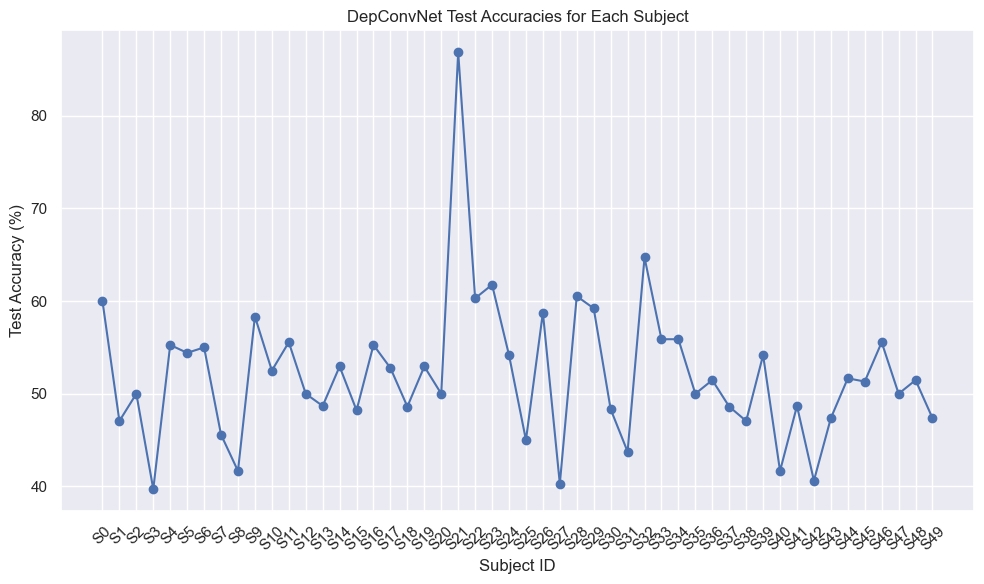

In [ ]:
# plot all test accuracies
plt.figure(figsize=(10, 6))
plt.plot(all_test_accuracies, marker='o', linestyle='-')
plt.title('DepConvNet Test Accuracies for Each Subject')
plt.xlabel('Subject ID')
plt.ylabel('Test Accuracy (%)')
plt.xticks(range(len(finals_ls)), [f'S{i}' for i in range(len(finals_ls))], rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(output_path, 'MS_test_accuracies.png'))


In [ ]:
# plot mean and std of train and val accuracies
mean_train_accuracies = np.mean(all_train_accuracies, axis=0)
mean_val_accuracies = np.mean(all_val_accuracies, axis=0)
std_train_accuracies = np.std(all_train_accuracies, axis=0)
std_val_accuracies = np.std(all_val_accuracies, axis=0)
df = pd.DataFrame({
    'Train Accuracy': all_train_accuracies,
    'Val Accuracy': all_val_accuracies,
    'Train loss': all_train_losses,
    'Val loss': all_val_losses
})

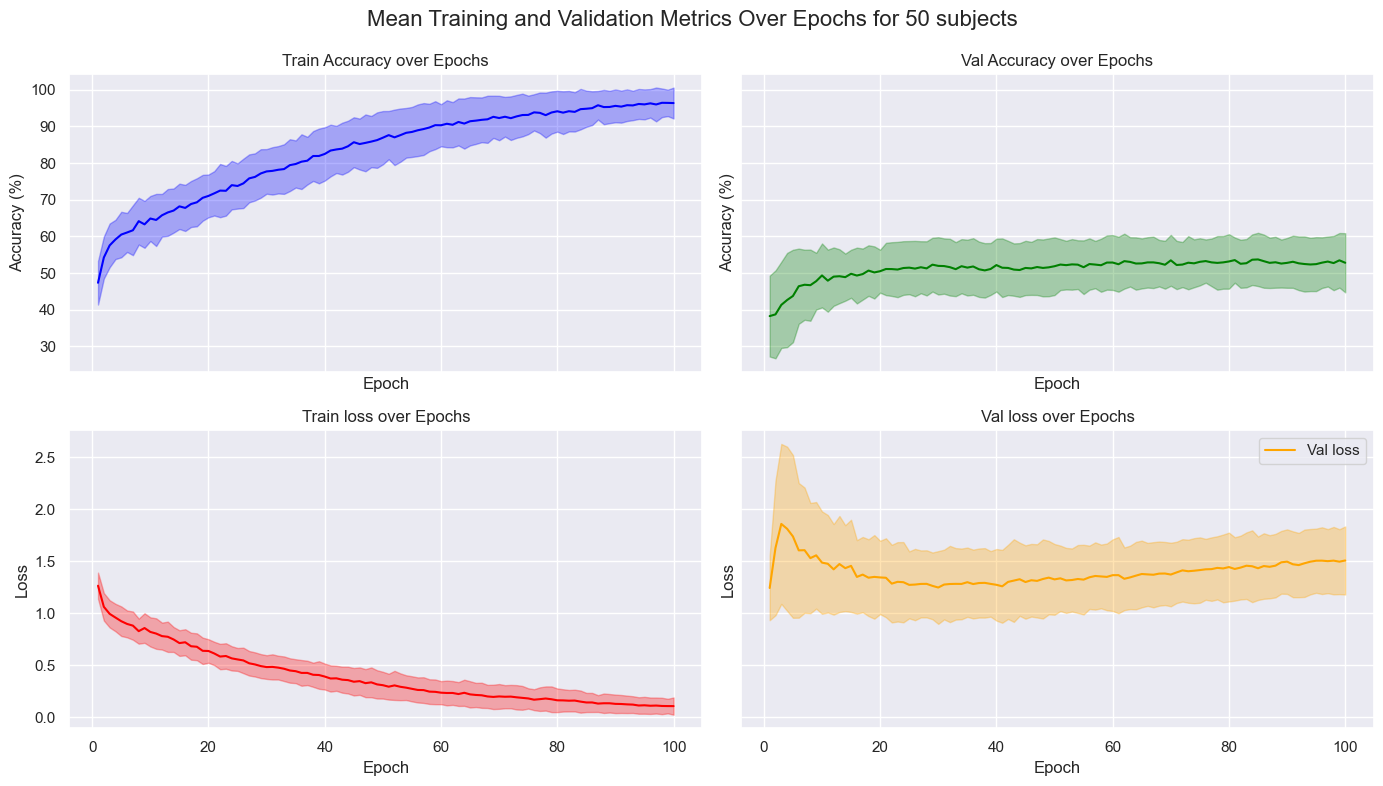

In [ ]:
# Example structure: list of lists (n_epochs x n_subjects/runs)
# If not already, ensure each column is a list of lists
# For example:
# df['Train Accuracy'] = [ [acc1, acc2, ..., accN] at epoch 1, [...], ...]

# Compute mean and std for each metric across epochs
metrics = ['Train Accuracy', 'Val Accuracy', 'Train loss', 'Val loss']
mean_std_df = pd.DataFrame()

for metric in metrics:
    values = np.array(df[metric].tolist())  # shape: (n_epochs, n_subjects)
    mean_std_df[f"{metric} Mean"] = values.mean(axis=0)
    mean_std_df[f"{metric} Std"] = values.std(axis=0)

# --- Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey='row')
fig.suptitle(f'Mean Training and Validation Metrics Over Epochs for {len(df)} subjects', fontsize=16)

plot_params = [
    ("Train Accuracy", axes[0, 0], "blue"),
    ("Val Accuracy", axes[0, 1], "green"),
    ("Train loss", axes[1, 0], "red"),
    ("Val loss", axes[1, 1], "orange"),
]

for metric, ax, color in plot_params:
    mean = mean_std_df[f"{metric} Mean"]
    std = mean_std_df[f"{metric} Std"]
    epoch = np.arange(1, len(mean) + 1)

    ax.plot(epoch, mean, label=metric, color=color)
    ax.fill_between(epoch, mean - std, mean + std, color=color, alpha=0.3)
    ax.set_title(f"{metric} over Epochs")
    ax.set_xlabel("Epoch")
    ylabel = "Accuracy (%)" if "Accuracy" in metric else "Loss"
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.savefig(os.path.join(output_path, 'MS_training_validation_metrics.png'))
plt.legend()
plt.subplots_adjust(top=0.9)  # Adjust top to make room for the suptitle
plt.show()


# Combine pipeline

In [2]:

output_path = '../Output/ica_rest_all/'
results = np.load(os.path.join(output_path, 'results_ica_rest_all.npy'), allow_pickle=True).item()
ms_results = np.load(os.path.join(output_path, 'ms_microsnet_results_ica_rest_all.npy'), allow_pickle=True).item()
print(f'N_models in results: {len(results["models"])}')
print(f'N_models in ms_results: {len(ms_results["models"])}')
ms_timeseries_path = os.path.join(output_path, 'ms_timeseries.npy')
with open(ms_timeseries_path, 'rb') as f:
    finals_ls = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../Output/ica_rest_all/ms_microsnet_results_ica_rest_all.npy'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from collections import defaultdict

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# class FeatureExtractor(nn.Module):
#     """Extracts features from pre-trained models by intercepting before the final classifier"""
    
#     def __init__(self, pretrained_model):
#         super().__init__()
#         self.pretrained_model = pretrained_model
        
#         # Get the backbone model
#         if hasattr(pretrained_model, 'module'):
#             self.backbone = pretrained_model.module
#         else:
#             self.backbone = pretrained_model
            
#         # Freeze all parameters
#         for param in self.backbone.parameters():
#             param.requires_grad = False
        
#         # Set up feature extraction based on model type
#         self.setup_feature_extraction()
            
#     def setup_feature_extraction(self):
#         """Setup feature extraction strategy based on model architecture"""
        
#         # Check if this is a MicroSNet model
#         if hasattr(self.backbone, 'classifier') and hasattr(self.backbone, 'global_pool'):
#             print("  Detected MicroSNet architecture")
#             self.model_type = 'microsnet'
            
#             # For MicroSNet, we want features right after global pooling, before classifier
#             self.features = None
            
#             def hook_fn(module, input, output):
#                 # This hook captures the output of global_pool
#                 self.features = output.squeeze(-1) if len(output.shape) > 2 else output
            
#             # Register hook on global_pool layer
#             self.backbone.global_pool.register_forward_hook(hook_fn)
            
#         elif hasattr(self.backbone, 'final_layer') or 'Deep4Net' in str(type(self.backbone)):
#             print("  Detected Deep4Net architecture")
#             self.model_type = 'deep4net'
            
#             # For Deep4Net, remove the final classification layer
#             if hasattr(self.backbone, 'final_layer'):
#                 modules = list(self.backbone.children())[:-1]
#             else:
#                 modules = list(self.backbone.children())[:-1]
            
#             self.feature_extractor = nn.Sequential(*modules)
            
#         else:
#             print("  Unknown architecture, using generic approach")
#             self.model_type = 'generic'
            
#             # Generic approach: remove last layer
#             modules = list(self.backbone.children())[:-1]
#             self.feature_extractor = nn.Sequential(*modules)
            
#     def forward(self, x):
#         with torch.no_grad():
#             if self.model_type == 'microsnet':
#                 # For MicroSNet, run full forward pass and capture features via hook
#                 self.features = None
#                 _ = self.backbone(x)  # This triggers the hook
                
#                 if self.features is None:
#                     raise RuntimeError("Failed to capture features from MicroSNet. Hook may not have fired.")
                
#                 features = self.features
#                 print(f"    MicroSNet features shape: {features.shape}")
#                 return features
                
#             else:
#                 # For other models, use the feature extractor
#                 features = self.feature_extractor(x)
                
#                 # Handle different output shapes
#                 if len(features.shape) > 2:
#                     # Apply global pooling if needed
#                     if features.shape[-1] > 1:  # Has time dimension
#                         features = F.adaptive_avg_pool1d(features.flatten(1, 2), 1).squeeze(-1)
#                     else:
#                         features = features.flatten(1)
                
#                 print(f"    {self.model_type} features shape: {features.shape}")
#                 return features

# class MultiModalClassifier(nn.Module):
#     """Classifier that takes features from multiple modalities"""
    
#     def __init__(self, raw_feature_dim, ms_feature_dim, n_classes, dropout=0.5):
#         super().__init__()
        
#         self.raw_feature_dim = raw_feature_dim
#         self.ms_feature_dim = ms_feature_dim
#         self.n_classes = n_classes
        
#         # Feature fusion layer
#         total_features = raw_feature_dim + ms_feature_dim
        
#         self.classifier = nn.Sequential(
#             nn.Linear(total_features, 512),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(256, n_classes)
#         )
        
#     def forward(self, raw_features, ms_features):
#         # Concatenate features from both modalities
#         combined_features = torch.cat([raw_features, ms_features], dim=1)
#         return self.classifier(combined_features)

def extract_features_from_single_model(model, data, device):
    """Extract features from a single model for one subject's data"""
    
    # Convert to tensor if needed
    if not isinstance(data, torch.Tensor):
        x = torch.tensor(data, dtype=torch.float32)
    else:
        x = data.clone()
    
    print(f"  Original data shape: {x.shape}")
    
    # Handle different data formats based on the expected input
    if len(x.shape) == 4:
        # Could be (n_trials, 1, n_channels, timepoints) or (n_trials, n_channels, 1, timepoints)
        if x.shape[1] == 1:  # (n_trials, 1, n_channels, timepoints) - raw EEG format
            x = x.squeeze(1)  # Remove singleton dimension -> (n_trials, n_channels, timepoints)
            print(f"  Raw EEG format detected, shape after squeeze: {x.shape}")
        elif x.shape[2] == 1:  # (n_trials, n_channels, 1, timepoints)
            x = x.squeeze(2)  # Remove singleton dimension -> (n_trials, n_channels, timepoints)
            print(f"  Format with singleton at dim 2, shape after squeeze: {x.shape}")
        else:
            print(f"  4D format without singleton, keeping as is: {x.shape}")
    elif len(x.shape) == 3:
        # Could be (n_trials, n_channels, timepoints) - microstate format
        print(f"  3D format (likely microstate), shape: {x.shape}")
    else:
        print(f"  Unexpected shape: {x.shape}")
    
    # Create feature extractor
    feature_extractor = FeatureExtractor(model).to(device)
    feature_extractor.eval()
    
    # Extract features
    features_list = []
    batch_size = 32
    
    with torch.no_grad():
        for i in range(0, len(x), batch_size):
            batch_x = x[i:i+batch_size].to(device)
            batch_features = feature_extractor(batch_x)
            features_list.append(batch_features.cpu())
    
    subject_features = torch.cat(features_list, dim=0)
    print(f"  Extracted features shape: {subject_features.shape}")
    
    return subject_features

def train_single_multimodal_classifier(raw_features, ms_features, labels, n_classes, 
                                     subject_id, test_size=0.2, val_size=0.25, 
                                     device='cuda', num_epochs=100, lr=0.001):
    """Train a classifier on combined features for a single subject"""
    
    print(f"\nTraining multimodal classifier for Subject {subject_id}")
    print(f"Raw features shape: {raw_features.shape}")
    print(f"MS features shape: {ms_features.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Unique labels: {torch.unique(labels)}")
    
    # set_seed(42 + subject_id)  # Different seed for each subject
    set_seed(42)  # Use a fixed seed for reproducibility
    
    # Check if we have enough samples for splitting
    if len(labels) < 10:
        print(f"Warning: Only {len(labels)} samples for subject {subject_id}. Using simple train/test split.")
        test_size = 0.3
        val_size = 0.0  # No validation set for small datasets
    
    # Split data
    indices = np.arange(len(labels))
    
    if val_size > 0:
        train_val_idx, test_idx = train_test_split(
            indices, test_size=test_size, random_state=42, 
            stratify=labels.numpy() if len(np.unique(labels.numpy())) > 1 else None
        )
        
        train_idx, val_idx = train_test_split(
            train_val_idx, test_size=val_size, random_state=42,
            stratify=labels[train_val_idx].numpy() if len(np.unique(labels[train_val_idx].numpy())) > 1 else None
        )
    else:
        train_idx, test_idx = train_test_split(
            indices, test_size=test_size, random_state=42,
            stratify=labels.numpy() if len(np.unique(labels.numpy())) > 1 else None
        )
        val_idx = []
    
    # Create datasets
    train_dataset = TensorDataset(
        raw_features[train_idx], ms_features[train_idx], labels[train_idx]
    )
    test_dataset = TensorDataset(
        raw_features[test_idx], ms_features[test_idx], labels[test_idx]
    )
    
    # Create data loaders
    batch_size = min(32, len(train_idx) // 2)  # Adjust batch size for small datasets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    if val_idx.any():
        val_dataset = TensorDataset(
            raw_features[val_idx], ms_features[val_idx], labels[val_idx]
        )
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    else:
        val_loader = None
    
    # Initialize model
    raw_feature_dim = raw_features.shape[1]
    ms_feature_dim = ms_features.shape[1]
    
    model = MultiModalClassifier(
        raw_feature_dim, ms_feature_dim, n_classes
    ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    if val_loader:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=10
        )
    
    # Training loop
    best_val_acc = 0
    best_model_state = None
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for raw_batch, ms_batch, label_batch in train_loader:
            raw_batch = raw_batch.to(device)
            ms_batch = ms_batch.to(device)
            label_batch = label_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(raw_batch, ms_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * raw_batch.size(0)
            preds = outputs.argmax(dim=1)
            train_correct += (preds == label_batch).sum().item()
            train_total += label_batch.size(0)
        
        train_loss /= train_total
        train_acc = train_correct / train_total * 100
        
        # Validation (if available)
        val_acc = 0
        val_loss = 0
        if val_loader:
            model.eval()
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for raw_batch, ms_batch, label_batch in val_loader:
                    raw_batch = raw_batch.to(device)
                    ms_batch = ms_batch.to(device)
                    label_batch = label_batch.to(device)
                    
                    outputs = model(raw_batch, ms_batch)
                    loss = criterion(outputs, label_batch)
                    
                    val_loss += loss.item() * raw_batch.size(0)
                    preds = outputs.argmax(dim=1)
                    val_correct += (preds == label_batch).sum().item()
                    val_total += label_batch.size(0)
            
            val_loss /= val_total
            val_acc = val_correct / val_total * 100
            scheduler.step(val_acc)
        else:
            val_acc = train_acc  # Use training accuracy as proxy
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        if epoch % 20 == 0:
            print(f"  Epoch {epoch}/{num_epochs}: "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Val Acc: {val_acc:.2f}%")
    
    # Load best model and test
    model.load_state_dict(best_model_state)
    model.eval()
    
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for raw_batch, ms_batch, label_batch in test_loader:
            raw_batch = raw_batch.to(device)
            ms_batch = ms_batch.to(device)
            label_batch = label_batch.to(device)
            
            outputs = model(raw_batch, ms_batch)
            preds = outputs.argmax(dim=1)
            
            test_correct += (preds == label_batch).sum().item()
            test_total += label_batch.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label_batch.cpu().numpy())
    
    test_acc = test_correct / test_total * 100
    
    print(f"  Subject {subject_id} Results:")
    print(f"    Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"    Test Accuracy: {test_acc:.2f}%")
    
    return {
        'model': model,
        'test_accuracy': test_acc,
        'best_val_accuracy': best_val_acc,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accs,
        'val_accuracies': val_accs,
        'predictions': all_preds,
        'true_labels': all_labels,
        'subject_id': subject_id
    }

def run_subject_specific_multimodal_pipeline(results, ms_results, all_data, finals_ls, all_y, 
                                           n_subjects=5, device='cuda'):
    """
    Main function to run subject-specific multimodal classifiers
    
    Args:
        results: Dictionary containing 'models' key with raw EEG models
        ms_results: Dictionary containing 'models' key with microstate models (first 5 subjects)
        all_data: List of arrays for raw EEG, shape (n_subjects, n_trials, 1, n_channels, timepoints)
        finals_ls: List of arrays for microstate timeseries, shape (n_subjects, n_trials, n_channels, timepoints)
        all_y: List of arrays, shape (n_subjects, n_trials)
        n_subjects: Number of subjects to process (default 5)
        device: Device to run computations on
    """
    
    print(f"Starting subject-specific multimodal pipeline for {n_subjects} subjects...")
    
    # Ensure we have enough models
    assert len(ms_results['models']) >= n_subjects, f"ms_results has only {len(ms_results['models'])} models, need {n_subjects}"
    assert len(results['models']) >= n_subjects, f"results has only {len(results['models'])} models, need {n_subjects}"
    
    all_subject_results = []
    
    for subject_id in range(n_subjects):
        print(f"\n{'='*60}")
        print(f"Processing Subject {subject_id}")
        print(f"{'='*60}")
        
        # Get data for this subject
        raw_data = all_data[subject_id]
        ms_data = finals_ls[subject_id]
        labels = torch.tensor(all_y[subject_id], dtype=torch.long)
        
        print(f"Raw data shape: {np.array(raw_data).shape}")
        print(f"MS data shape: {np.array(ms_data).shape}")
        print(f"Labels shape: {labels.shape}")
        
        # Extract features from raw EEG model
        print(f"Extracting features from raw EEG model...")
        raw_features = extract_features_from_single_model(
            results['models'][subject_id], raw_data, device
        )
        
        # Extract features from microstate model
        print(f"Extracting features from microstate model...")
        ms_features = extract_features_from_single_model(
            ms_results['models'][subject_id], ms_data, device
        )
        
        # Get number of classes for this subject
        n_classes = len(torch.unique(labels))
        print(f"Number of classes: {n_classes}")
        
        # Print data distribution
        print(f"Total samples: {len(labels)}")
        for class_id in range(n_classes):
            count = (labels == class_id).sum().item()
            print(f"  Class {class_id}: {count} samples ({count/len(labels)*100:.1f}%)")
        
        # Train subject-specific multimodal classifier
        subject_results = train_single_multimodal_classifier(
            raw_features, ms_features, labels, n_classes, subject_id, device=device
        )
        
        all_subject_results.append(subject_results)
    
    # Print summary
    print(f"\n{'='*60}")
    print("SUMMARY OF ALL SUBJECTS")
    print(f"{'='*60}")
    
    test_accuracies = [res['test_accuracy'] for res in all_subject_results]
    val_accuracies = [res['best_val_accuracy'] for res in all_subject_results]
    
    print(f"Test Accuracies:")
    for i, acc in enumerate(test_accuracies):
        print(f"  Subject {i}: {acc:.2f}%")
    
    print(f"\nAverage Test Accuracy: {np.mean(test_accuracies):.2f}% ± {np.std(test_accuracies):.2f}%")
    print(f"Average Validation Accuracy: {np.mean(val_accuracies):.2f}% ± {np.std(val_accuracies):.2f}%")
    
    return {
        'subject_results': all_subject_results,
        'summary': {
            'test_accuracies': test_accuracies,
            'val_accuracies': val_accuracies,
            'mean_test_acc': np.mean(test_accuracies),
            'std_test_acc': np.std(test_accuracies),
            'mean_val_acc': np.mean(val_accuracies),
            'std_val_acc': np.std(val_accuracies)
        }
    }


In [13]:

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run the subject-specific multimodal pipeline for first 5 subjects
multimodal_results = run_subject_specific_multimodal_pipeline(
    results, ms_results, all_data, finals_ls, all_y, 
    n_subjects=len(ms_results['models']), device=device
)

print(f"\nMultimodal pipeline completed!")
print(f"Average performance across 50 subjects: {multimodal_results['summary']['mean_test_acc']:.2f}%")

# Access individual subject results
for i, subject_result in enumerate(multimodal_results['subject_results']):
    print(f"Subject {i}: {subject_result['test_accuracy']:.2f}% test accuracy")
    # Access the trained model: subject_result['model']

Starting subject-specific multimodal pipeline for 50 subjects...

Processing Subject 0
Raw data shape: (400, 1, 61, 1000)
MS data shape: (400, 7, 1000)
Labels shape: torch.Size([400])
Extracting features from raw EEG model...
  Original data shape: torch.Size([400, 1, 61, 1000])
  Raw EEG format detected, shape after squeeze: torch.Size([400, 61, 1000])
  Detected Deep4Net architecture
    deep4net features shape: torch.Size([32, 1400])
    deep4net features shape: torch.Size([32, 1400])
    deep4net features shape: torch.Size([32, 1400])
    deep4net features shape: torch.Size([32, 1400])
    deep4net features shape: torch.Size([32, 1400])
    deep4net features shape: torch.Size([32, 1400])
    deep4net features shape: torch.Size([32, 1400])
    deep4net features shape: torch.Size([32, 1400])
    deep4net features shape: torch.Size([32, 1400])
    deep4net features shape: torch.Size([32, 1400])
    deep4net features shape: torch.Size([32, 1400])
    deep4net features shape: torch.Size

In [14]:
# Save the multimodal results
output_path = '../Output/ica_rest_all/'
output_file = os.path.join(output_path, 'multimodal_results_ica_rest_all.npy')
np.save(output_file, multimodal_results)

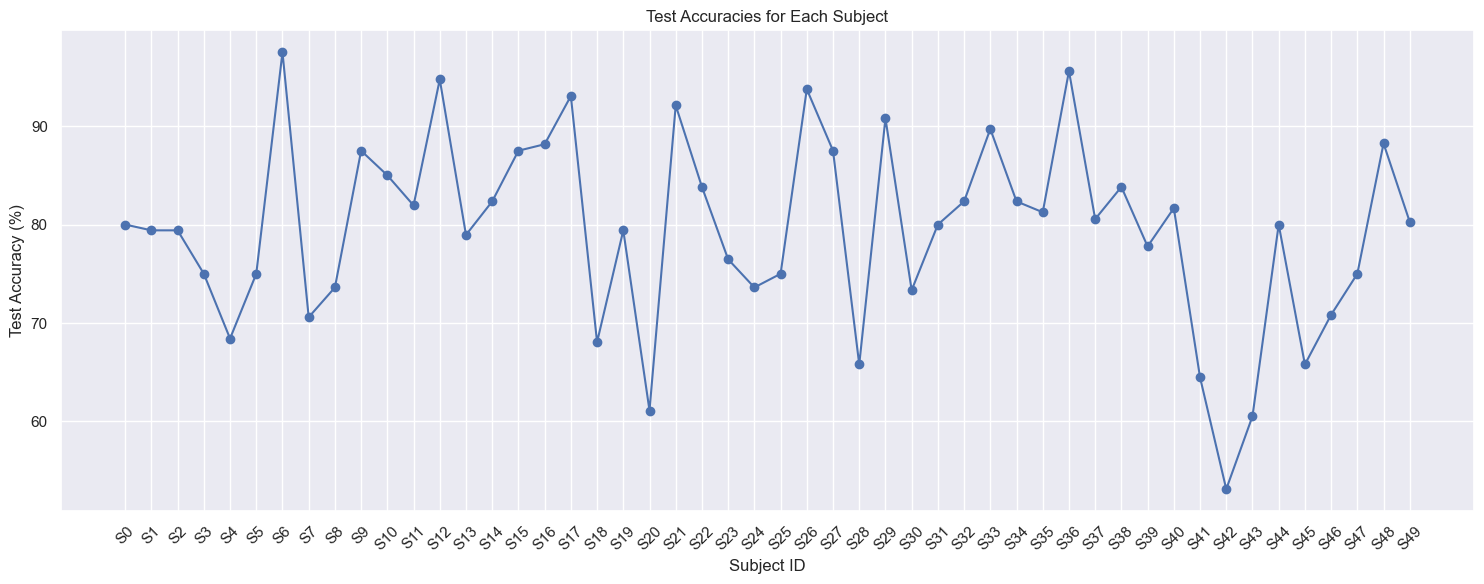

In [15]:
accuracy_list = [res['test_accuracy'] for res in multimodal_results['subject_results']]

plt.figure(figsize=(15, 6))
plt.plot(range(len(accuracy_list)), accuracy_list, marker='o', linestyle='-')
plt.title('Test Accuracies for Each Subject')
plt.xlabel('Subject ID')
plt.ylabel('Test Accuracy (%)')
plt.xticks(range(len(accuracy_list)), [f'S{i}' for i in range(len(accuracy_list))], rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_path, 'multimodal_test_accuracies.png'))
plt.show()

# Compare all models


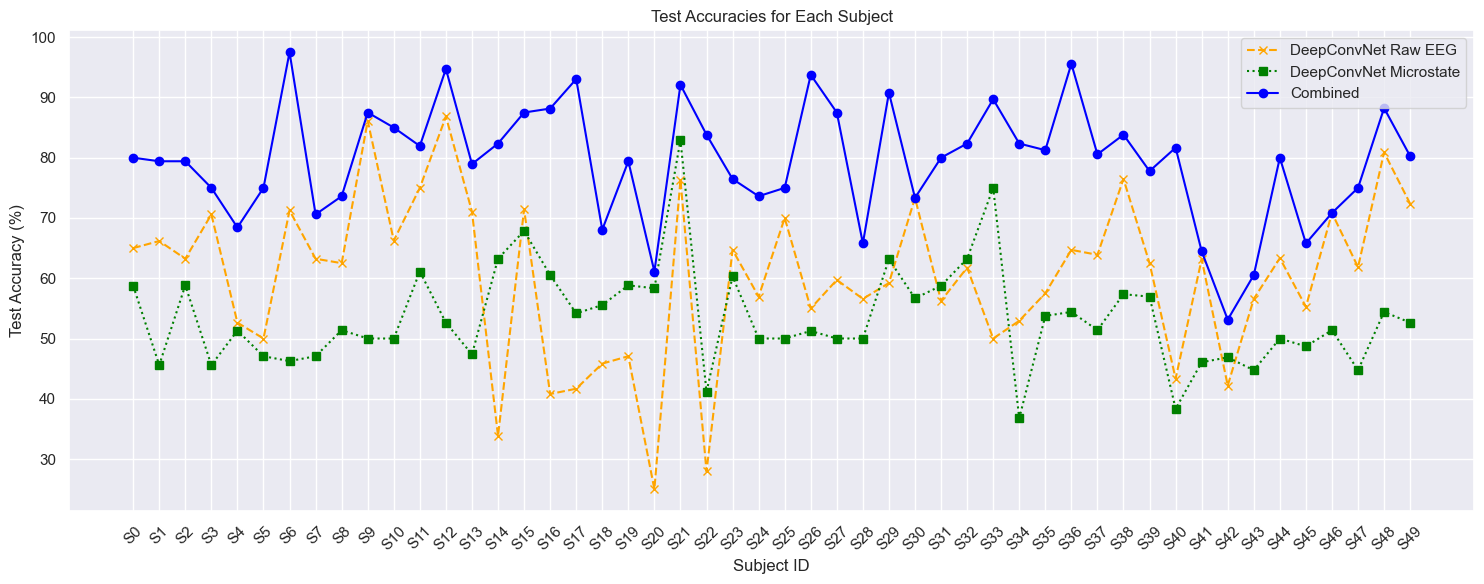

In [16]:
plt.figure(figsize=(15, 6))
plt.plot(results['test_accuracies'], marker='x', linestyle='--', label='DeepConvNet Raw EEG', color='orange')
plt.plot(ms_results['test_accuracies'], marker='s', linestyle=':', label='DeepConvNet Microstate', color='green')
plt.plot(accuracy_list, marker='o', linestyle='-', label='Combined', color='blue')
plt.xlabel('Subject ID')
plt.ylabel('Test Accuracy (%)')
plt.xticks(range(50), [f'S{i}' for i in range(50)], rotation=45)
plt.title('Test Accuracies for Each Subject')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_path, 'multimodal_vs_individual_test_accuracies.png'))
plt.show()

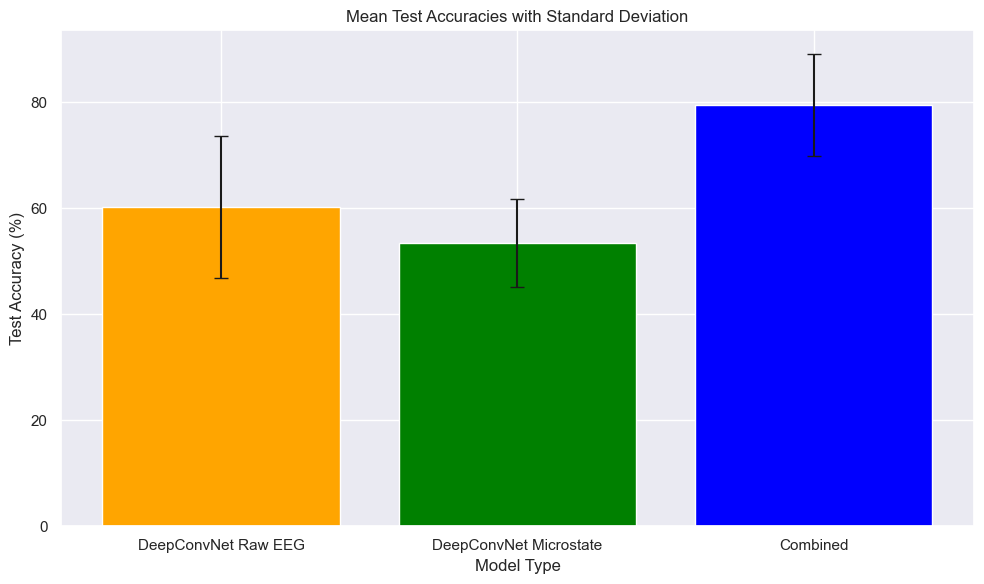

DeepConvNet Raw EEG - Mean Test Accuracy: 60.22% +/- 13.32
DeepConvNet Microstate - Mean Test Accuracy: 53.45% +/- 8.36
Combined - Mean Test Accuracy: 79.44% +/- 9.64


In [17]:

# bar plot of mean accuracies
mean_accuracies = {
    'DeepConvNet Raw EEG': np.mean(results['test_accuracies']),
    'DeepConvNet Microstate': np.mean(ms_results['test_accuracies']),
        'Combined': np.mean(accuracy_list)
}
std_accuracies = {
    'DeepConvNet Raw EEG': np.std(results['test_accuracies']),
    'DeepConvNet Microstate': np.std(ms_results['test_accuracies']),
    'Combined': np.std(accuracy_list)
}

plt.figure(figsize=(10, 6))
plt.bar(mean_accuracies.keys(), mean_accuracies.values(), yerr=std_accuracies.values(), capsize=5, color=['orange', 'green', 'blue'])
plt.title('Mean Test Accuracies with Standard Deviation')  
plt.ylabel('Test Accuracy (%)')
plt.xlabel('Model Type')
plt.tight_layout()
plt.savefig(os.path.join(output_path, 'mean_test_accuracies.png'))
plt.show()

for key in mean_accuracies.keys():
    print(f"{key} - Mean Test Accuracy: {mean_accuracies[key]:.2f}% +/- {std_accuracies[key]:.2f}") 


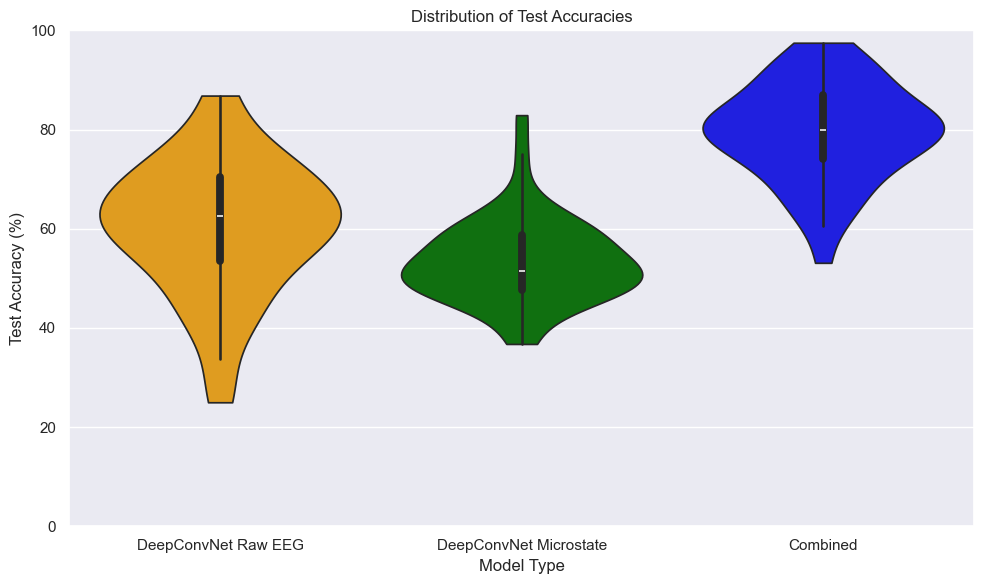

In [18]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=[results['test_accuracies'], ms_results['test_accuracies'], accuracy_list],
               palette=['orange', 'green', 'blue'], cut=0)
plt.xticks([0, 1, 2], ['DeepConvNet Raw EEG', 'DeepConvNet Microstate', 'Combined'])
plt.title('Distribution of Test Accuracies')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('Model Type')
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig(os.path.join(output_path, 'test_accuracy_distribution.png'))
plt.show()

# Comparing all type of studies

In [75]:
subject_types = ['', 'independent_', 'independent_clean_', 'adaptive_', 'adaptive_clean_']

# Save the multimodal results
output_path = '../Output/ica_rest_all/'
ms_timeseries_path = os.path.join(output_path, 'ms_timeseries.npy')
with open(ms_timeseries_path, 'rb') as f:
    finals_ls = pickle.load(f)
results = {}
for subject_type in subject_types:
    print(f"Loading results for {subject_type}subjects...")
    if subject_type == '':
        output_path = '../Output/ica_rest_all/'
    else:
        # subject_type = subject_type.replace('_', '')
        folder_name = subject_type[:-1] if subject_type.endswith('_') else subject_type
        output_path = f'../Output/ica_rest_all/{folder_name}/'
    results_raw = np.load(os.path.join(output_path, f'{subject_type}results_ica_rest_all.npy'), allow_pickle=True).item()
    results_combine = np.load(os.path.join(output_path, f'{subject_type}multimodal_results_ica_rest_all.npy'), allow_pickle=True).item()
    results_ms = np.load(os.path.join(output_path, f'{subject_type}ms_results_ica_rest_all.npy'), allow_pickle=True).item()
    # if subject_type contains 'clean'
    if 'adaptive' in subject_type:
        accuracy_list = results_combine['summary']['finetuned_test_accuracies']
    else:
        accuracy_list = [res['test_accuracy'] for res in results_combine['subject_results']]
    if subject_type == '':
        subject_type = 'dependent_'
    subject_type = subject_type[:-1] if subject_type.endswith('_') else subject_type
    results[f'subject_{subject_type}'] = {
            'DeepConvNet' : results_raw['test_accuracies'],
            'microstate': results_ms['test_accuracies'],
            'multimodal': accuracy_list
        }
    
    output_path = '../Output/ica_rest_all/results_all/plots/'
    if not os.path.exists(output_path):
        os.makedirs(output_path)

Loading results for subjects...
Loading results for independent_subjects...
Loading results for independent_clean_subjects...
Loading results for adaptive_subjects...
Loading results for adaptive_clean_subjects...


In [76]:
n_colors = len(subject_types)
palette_blue = sns.color_palette(palette='Blues_d', n_colors=n_colors)
palette_green = sns.color_palette(palette='Greens_d', n_colors=n_colors)
palette_orange = sns.color_palette(palette='Oranges_d', n_colors=n_colors)

In [77]:
n_colors = len(subject_types) + 1
palette_blue = sns.color_palette(palette='Blues_d', n_colors= n_colors)[:-1]
palette_green = sns.color_palette(palette='summer_r', n_colors=n_colors)[:-1]
palette_orange = sns.color_palette(palette='flare_r', n_colors=n_colors)[1:]

# color_subject_type = ['independent_subject', 'independent_clean_subject', 'dependent_subject', 'adaptive_subject', 'adaptive_clean_subject']
color_subject_type = ['subject_independent', 'subject_independent_clean', 'subject_dependent', 'subject_adaptive', 'subject_adaptive_clean']
results_types = ['DeepConvNet', 'microstate', 'multimodal']
colors = {}
for result_type in results_types:
    colors[result_type] = {}
    for i, subject_type in enumerate(color_subject_type):
        if result_type == 'DeepConvNet':
            colors[result_type][subject_type] = palette_blue[i]
        elif result_type == 'microstate':
            colors[result_type][subject_type] = palette_green[i]
        elif result_type == 'multimodal':
            colors[result_type][subject_type] = palette_orange[i]
# colors = {
#     'raw': {
#         'independent_subject': palette[,  
#         'independent_clean_subject': palette[7],
#         'subject': palette[5],  
#     },
#     'microstate': {
#         'independent_subject': palette[2], 
#         'independent_clean_subject': palette[6],
#         'subject': palette[3],
#     },
#     'multimodal': {
#         'independent_subject': palette[0], 
#         'independent_clean_subject': palette[9],
#         'subject': palette[1], 
#     }
# }

line_types = ['--', '-', '--']

### Line plot of results

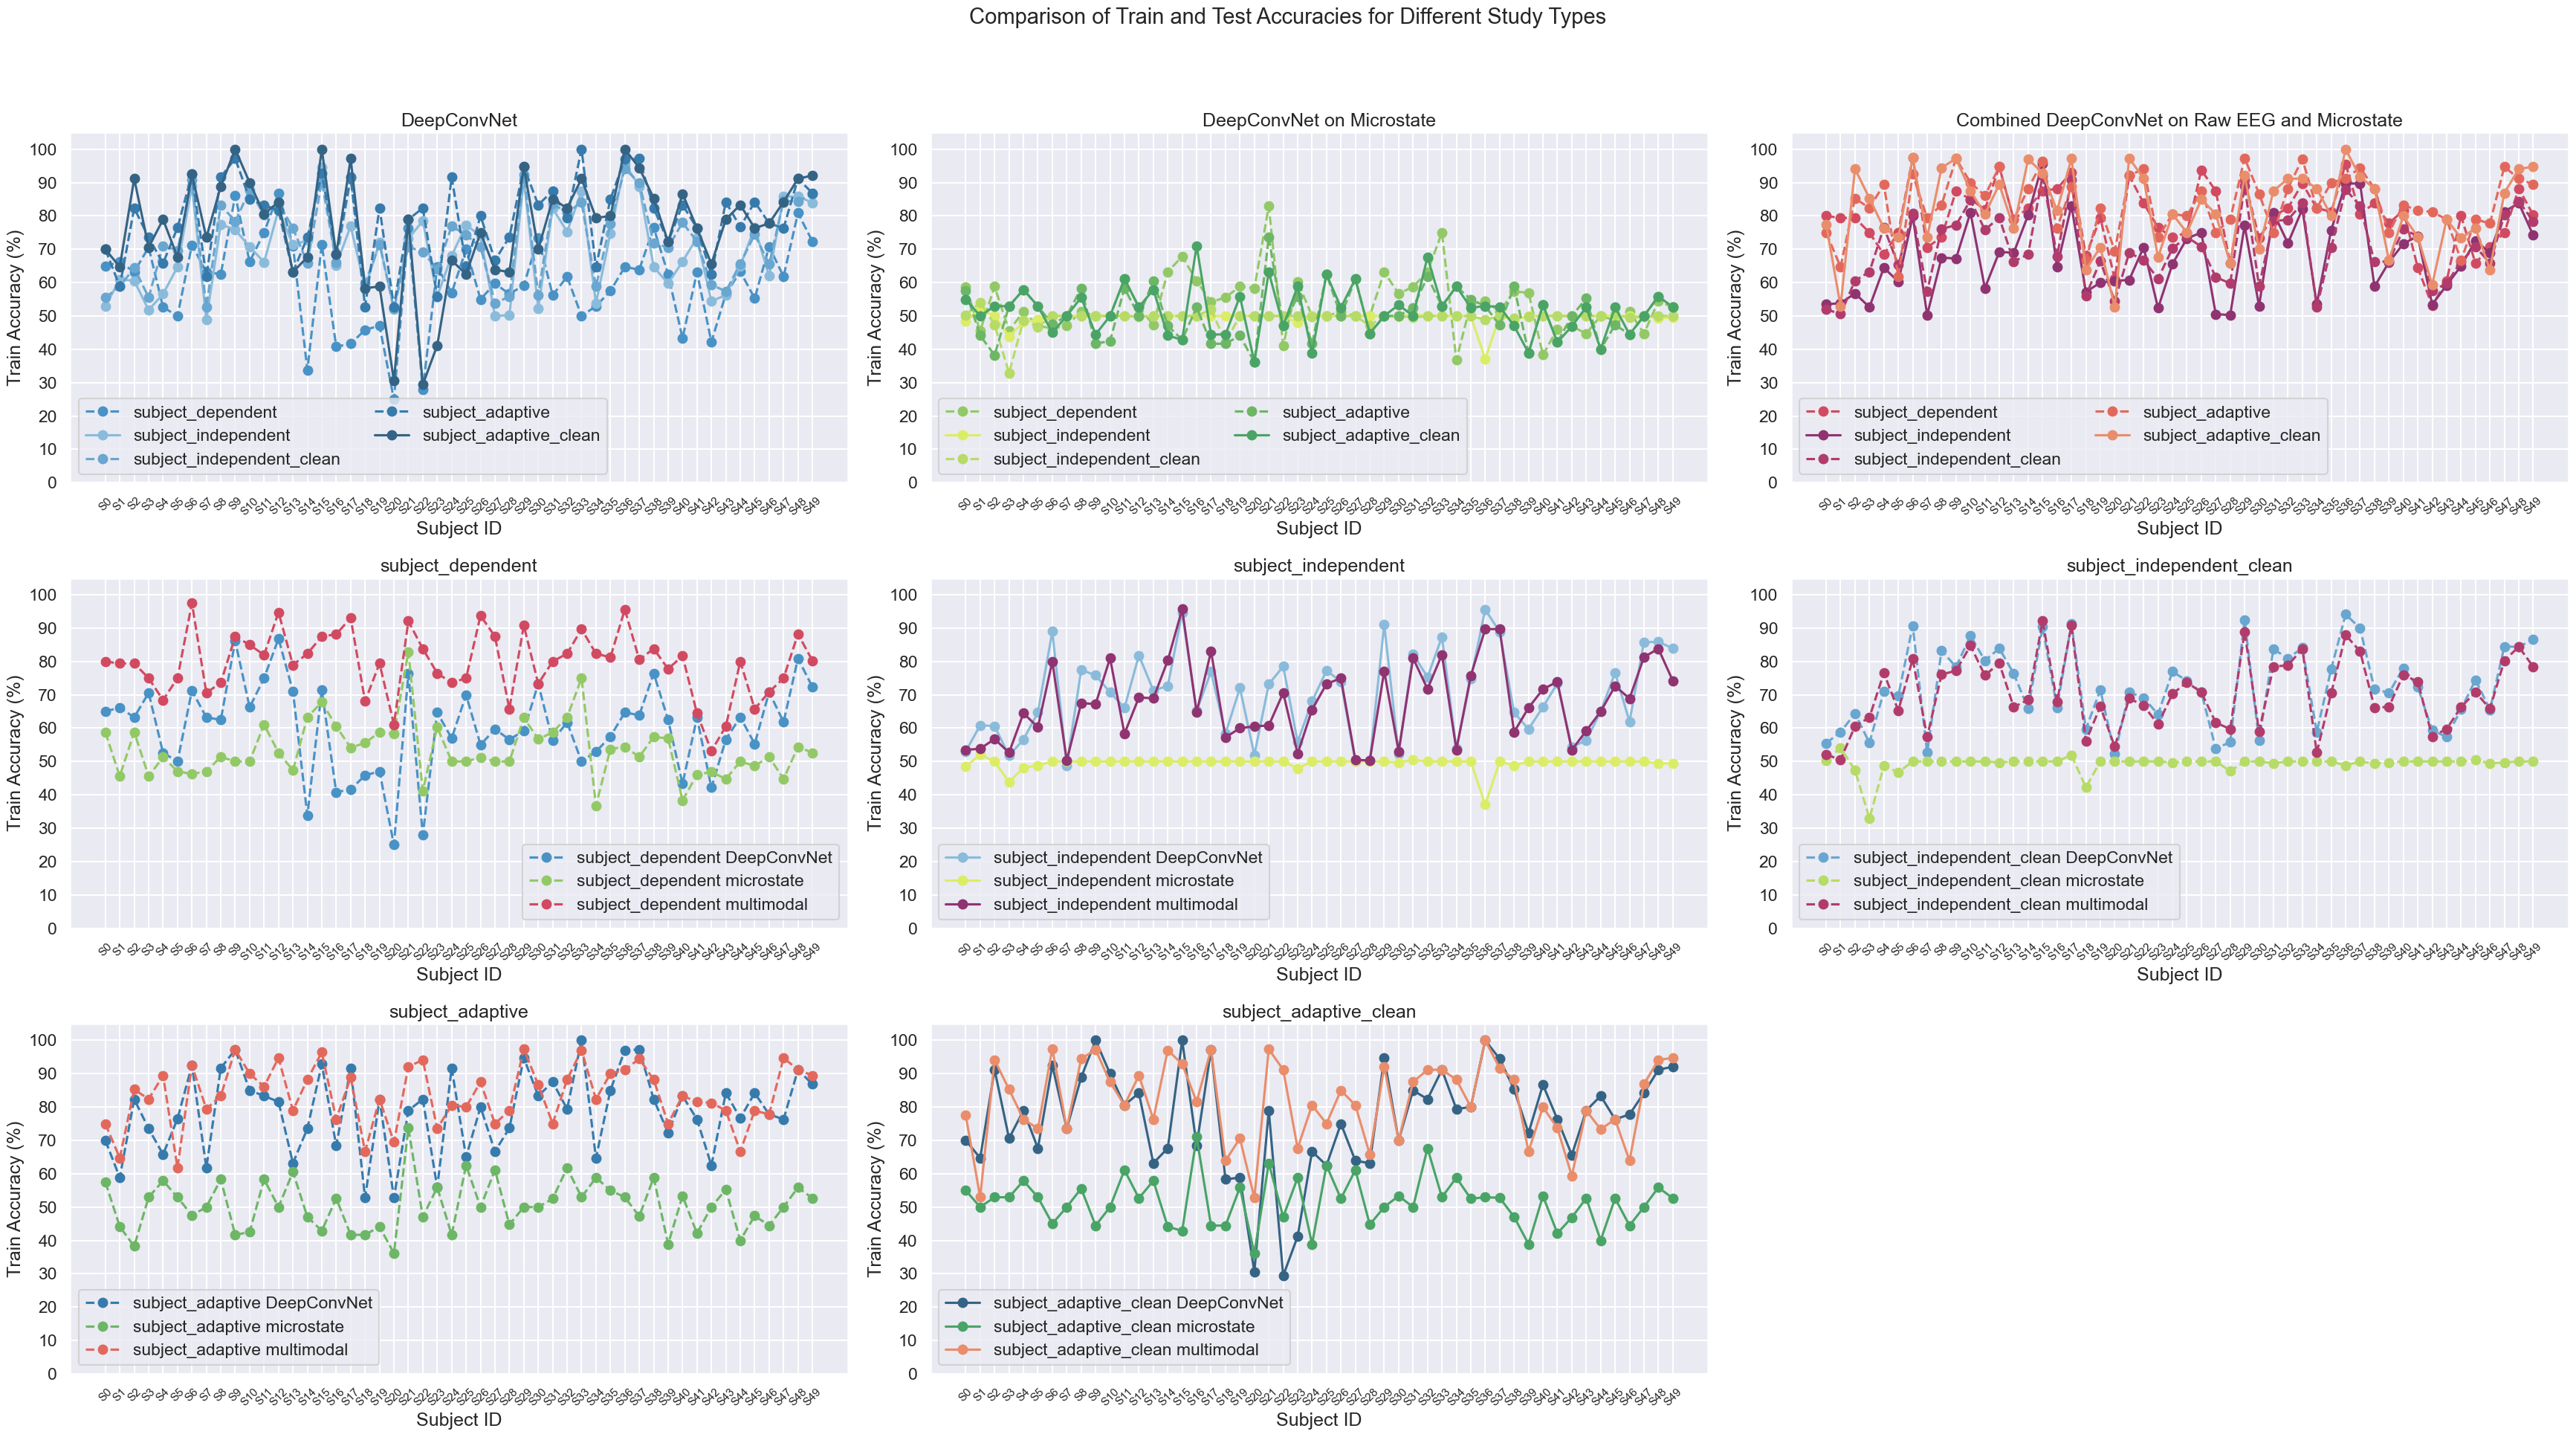

In [82]:
font_size= 11
sns.set_theme(context="talk", style="darkgrid")
fig, axes = plt.subplots(3,3, figsize=(35, 20))
axs = axes.flatten()
for ax, result_type in zip(axs[0:3], colors.keys()):
    if result_type == 'raw':
        result_type_ = 'DeepConvNet on Raw EEG'
    elif result_type == 'microstate':
        result_type_ = 'DeepConvNet on Microstate'
    elif result_type == 'multimodal':
        result_type_ = 'Combined DeepConvNet on Raw EEG and Microstate'
    else:
        result_type_ = result_type
    ax.set_title(f'{result_type_}')
    for i, (key, acc_list) in enumerate(results.items()):
        # if key == 'subject_independent' or key =='subject_adaptive':
        #     continue
        if key == 'subject':
            key_ = 'subject_dependent'
        else:
            key_ = key
        ax.plot(acc_list[result_type], marker='o', linestyle=line_types[i % len(line_types)], 
                 color=colors[result_type][key], label=f'{key_}')
        ax.legend(ncol=2)
        ax.set_xlabel('Subject ID')
        ax.set_ylabel('Train Accuracy (%)')
        ax.set_ylim(0, 105)
        ax.set_yticks(np.arange(0, 101, 10))
        ax.set_xticks(range(len(accuracy_list)), [f'S{i}' for i in range(len(accuracy_list))], rotation=45, fontsize=font_size)
        
for ax, (i, (key, acc_list)) in zip(axs[3:9], enumerate(results.items())):
    ax.set_title(f'{key}')
    ax.set_xlabel('Subject ID')
    ax.set_ylabel('Test Accuracy (%)')
    ax.set_xticks(range(len(accuracy_list)))
    ax.set_xticklabels([f'S{i}' for i in range(len(accuracy_list))], rotation=45)
    for j, (model_type, accuracies) in enumerate(acc_list.items()):
        ax.plot(accuracies, marker='o', linestyle=line_types[i % len(line_types)], 
                 color=colors[model_type][key], label=f'{key} {model_type}')
        ax.legend()
        ax.set_xlabel('Subject ID')
        ax.set_ylabel('Train Accuracy (%)')
        ax.set_ylim(0, 105)
        ax.set_yticks(np.arange(0, 101, 10))
        ax.set_xticks(range(len(accuracy_list)), [f'S{i}' for i in range(len(accuracy_list))], rotation=45, fontsize=font_size)

fig.delaxes(axs[-1])  # Remove the last empty subplot
# for i, (key, acc_list) in enumerate(results.items()):
#     for j, (model_type, accuracies) in enumerate(acc_list.items()):
#         axs[-1].plot(accuracies, marker='o', linestyle=line_types[i % len(line_types)], 
#                  color=colors[model_type][key], label=f'{key} {model_type}')
#         axs[-1].legend(ncol=2)
#         axs[-1].set_title(f'Train Accuracies for all Subjects and Study Types')
#         axs[-1].set_xlabel('Subject ID')
#         axs[-1].set_ylabel('Train Accuracy (%)')
#         axs[-1].set_ylim(0, 100)
#         axs[-1].set_yticks(np.arange(0, 101, 10))
#         axs[-1].set_xticks(range(len(accuracy_list)), [f'S{i}' for i in range(len(accuracy_list))], rotation=45, fontsize=font_size)
        
fig.suptitle('Comparison of Train and Test Accuracies for Different Study Types', fontsize=21)
plt.tight_layout(rect=[0, 0.01, 1, 0.95])

plt.savefig(os.path.join(output_path, 'test_accuracies_comparison.png'))

### Bar plots

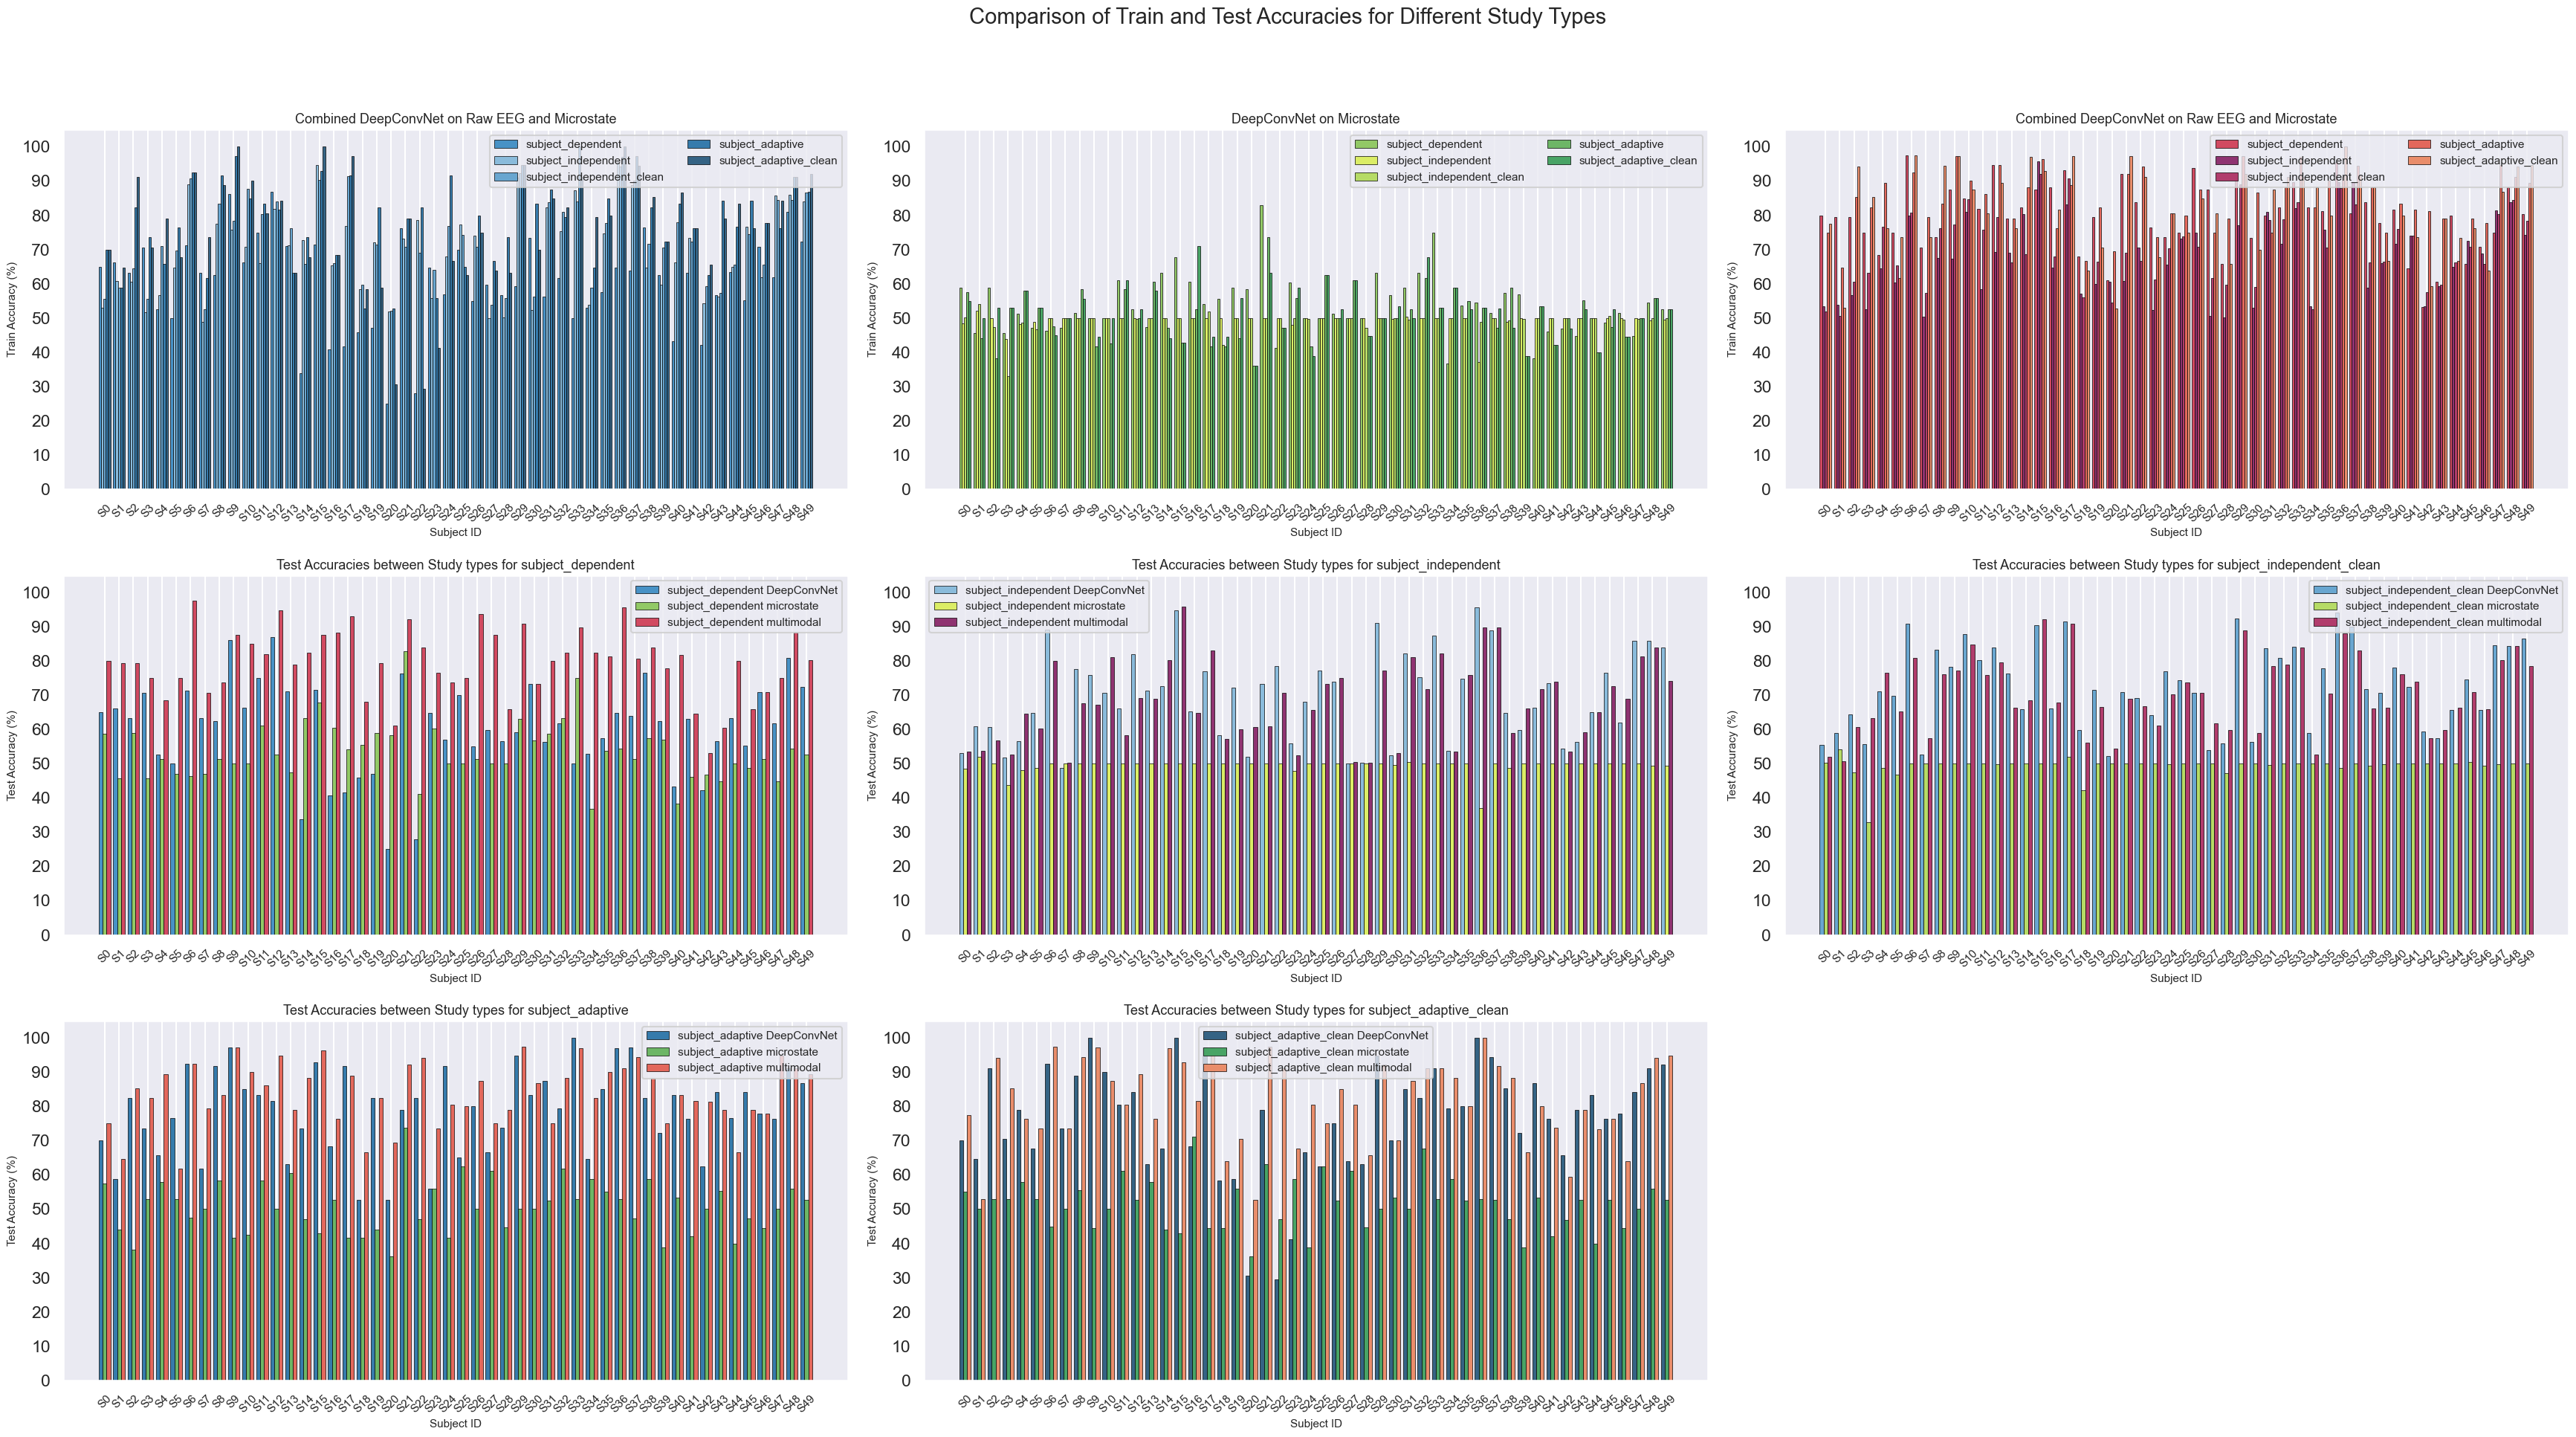

In [79]:
font_size = 11
sns.set_theme(context="talk", style="darkgrid")
fig, axes = plt.subplots(3, 3, figsize=(35, 20))
axs = axes.flatten()

# Create bar width for grouped bars
bar_width = 0.8 / len(results.keys())  # Adjust based on number of groups
x_positions = np.arange(len(accuracy_list))

# First row: Train accuracies for each result type
for ax, result_type in zip(axs[0:3], colors.keys()):
    if result_type == 'raw':
        result_type_ = 'DeepConvNet on Raw EEG'
    elif result_type == 'microstate':
        result_type_ = 'DeepConvNet on Microstate'
    elif result_type == 'multimodal':
        result_type_ = 'Combined DeepConvNet on Raw EEG and Microstate'
    
    ax.set_title(f'{result_type_}', fontsize=font_size+2)
    
    # Create grouped bars
    for i, (key, acc_list) in enumerate(results.items()):
        if key == 'subject':
            key_ = 'subject_dependent'
        else:
            key_ = key
        
        # Calculate x position for this group of bars
        x_pos = x_positions + i * bar_width
        
        ax.bar(x_pos, acc_list[result_type], 
               width=bar_width, 
               color=colors[result_type][key], 
               label=f'{key_}',
               edgecolor='black',
               linewidth=0.5)
    
    ax.legend(ncol=2, fontsize=font_size)
    ax.set_xlabel('Subject ID', fontsize=font_size)
    ax.set_ylabel('Train Accuracy (%)', fontsize=font_size)
    ax.set_ylim(0, 105)
    ax.set_yticks(np.arange(0, 101, 10))
    ax.set_xticks(x_positions + bar_width * (len(results.keys()) - 1) / 2)
    ax.set_xticklabels([f'S{i}' for i in range(len(accuracy_list))], 
                       rotation=45, fontsize=font_size)
    ax.grid(axis='y')

# Second row: Test accuracies for each study type
for ax, (i, (key, acc_list)) in zip(axs[3:9], enumerate(results.items())):
    ax.set_title(f'Test Accuracies between Study types for {key}', fontsize=font_size+2)
    ax.set_xlabel('Subject ID', fontsize=font_size)
    ax.set_ylabel('Test Accuracy (%)', fontsize=font_size)
    
    # Create grouped bars for different model types
    model_types = list(acc_list.keys())
    bar_width_model = 0.8 / len(model_types)
    
    for j, (model_type, accuracies) in enumerate(acc_list.items()):
        x_pos = x_positions + j * bar_width_model
        
        ax.bar(x_pos, accuracies, 
               width=bar_width_model, 
               color=colors[model_type][key], 
               label=f'{key} {model_type}',
               edgecolor='black',
               linewidth=0.5)
    
    ax.legend(fontsize=font_size)
    ax.set_ylim(0, 105)
    ax.set_yticks(np.arange(0, 101, 10))
    ax.set_xticks(x_positions + bar_width_model * (len(model_types) - 1) / 2)
    ax.set_xticklabels([f'S{i}' for i in range(len(accuracy_list))], 
                       rotation=45, fontsize=font_size)
    ax.grid(axis='y')
fig.delaxes(axs[-1])  # Remove the last empty subplot
# Optional: Overall comparison in the last subplot (uncomment if needed)
# for i, (key, acc_list) in enumerate(results.items()):
#     for j, (model_type, accuracies) in enumerate(acc_list.items()):
#         # Calculate position for grouped bars
#         group_pos = i * len(acc_list.keys()) + j
#         bar_width_all = 0.8 / (len(results.keys()) * len(acc_list.keys()))
#         x_pos = x_positions + group_pos * bar_width_all
#         
#         axs[-1].bar(x_pos, accuracies, 
#                    width=bar_width_all, 
#                    color=colors[model_type][key], 
#                    label=f'{key} {model_type}',
#                    alpha=0.8,
#                    edgecolor='black',
#                    linewidth=0.5)
# 
# axs[-1].legend(ncol=2, fontsize=font_size-1)
# axs[-1].set_title(f'Train Accuracies for all Subjects and Study Types', fontsize=font_size+2)
# axs[-1].set_xlabel('Subject ID', fontsize=font_size)
# axs[-1].set_ylabel('Train Accuracy (%)', fontsize=font_size)
# axs[-1].set_ylim(0, 100)
# axs[-1].set_yticks(np.arange(0, 101, 10))
# axs[-1].set_xticks(x_positions + bar_width_all * (len(results.keys()) * len(acc_list.keys()) - 1) / 2)
# axs[-1].set_xticklabels([f'S{i}' for i in range(len(accuracy_list))], 
#                        rotation=45, fontsize=font_size)
# axs[-1].grid(axis='y', alpha=0.3)

fig.suptitle('Comparison of Train and Test Accuracies for Different Study Types', fontsize=21)
plt.tight_layout(rect=[0, 0.01, 1, 0.95])

plt.savefig(os.path.join(output_path, 'test_accuracies_comparison_barplot.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

C:\Users\josan\AppData\Local\Temp\ipykernel_26264\794027205.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Study_Type', y='Accuracy', ax=ax,
C:\Users\josan\AppData\Local\Temp\ipykernel_26264\794027205.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Study_Type', y='Accuracy', ax=ax,
C:\Users\josan\AppData\Local\Temp\ipykernel_26264\794027205.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Study_Type', y='Accuracy', ax=ax,
C:\Users\josan\AppData\Local\Temp\ipykernel_26264\794027205.p

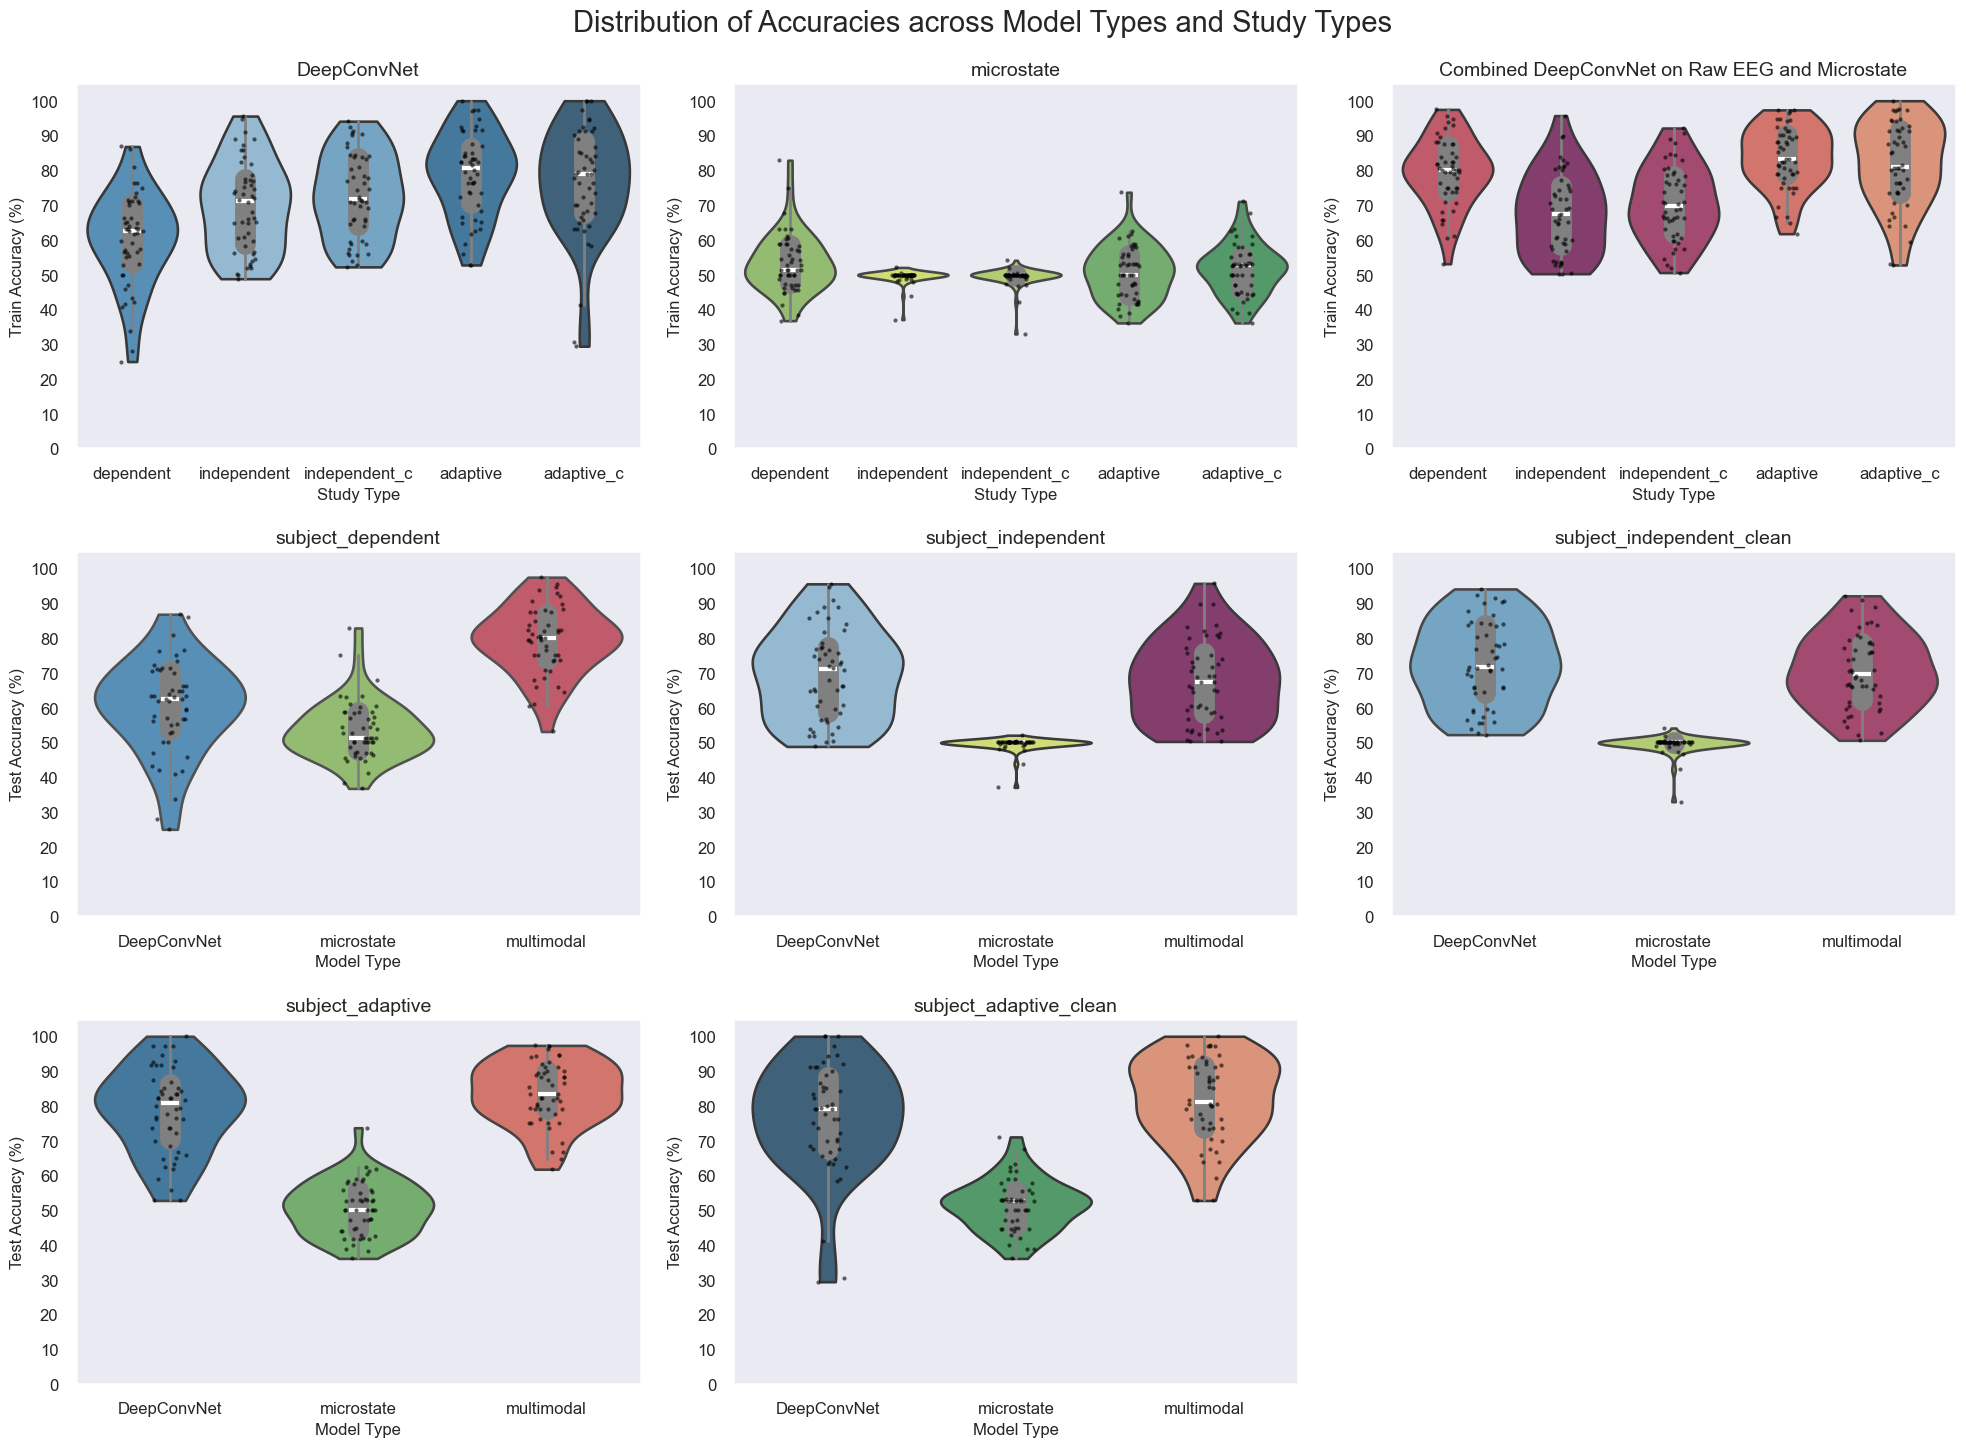

In [80]:
font_size = 12
sns.set_theme(context="talk", style="darkgrid")
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axs = axes.flatten()

# Prepare data for violin plots
def prepare_violin_data(results, result_type):
    """Prepare data in long format for violin plots"""
    data = []
    for key, acc_list in results.items():
        if key == 'subject':
            key_ = 'dependent_subject'
        else:
            key_ = key
        key_ = key_.replace('subject_', '')
        if "clean" in key_:
            key_ = key_.replace('clean', 'c')
        accuracies = acc_list[result_type]
        for i, acc in enumerate(accuracies):
            data.append({
                'Subject': f'S{i}',
                'Study_Type': key_,
                'Accuracy': acc,
                'Model_Type': result_type
            })
    return pd.DataFrame(data)

# First row: Train accuracies for each result type (violin plots)
for ax, result_type in zip(axs[0:3], colors.keys()):
    if result_type == 'raw':
        result_type_ = 'DeepConvNet'
    elif result_type == 'multimodal':
        result_type_ = 'Combined DeepConvNet on Raw EEG and Microstate'
    else:
        result_type_ = result_type
    
    ax.set_title(f'{result_type_}', fontsize=font_size+2)
    
    # Prepare data for this result type
    df = prepare_violin_data(results, result_type)
    
    # Create violin plot
    sns.violinplot(data=df, x='Study_Type', y='Accuracy', ax=ax, 
                   palette=[colors[result_type][key] for key in results.keys()],
                   inner_kws=dict(box_width=15, whis_width=2, color = '.5'), cut=0)
    
    # Add individual points
    sns.stripplot(data=df, x='Study_Type', y='Accuracy', ax=ax, 
                  color='black', alpha=0.6, size=3)
    
    ax.set_xlabel('Study Type', fontsize=font_size)
    ax.set_ylabel('Train Accuracy (%)', fontsize=font_size)
    ax.set_ylim(0, 105)
    ax.set_yticks(np.arange(0, 101, 10))
    ax.tick_params(axis='x', rotation=00, labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)
    ax.grid(axis='y')

# Second row: Test accuracies comparison across model types for each study type
for ax, (i, (key, acc_list)) in zip(axs[3:9], enumerate(results.items())):
    if key == 'subject':
        key_ = 'dependent_subject'
    else:
        key_ = key
    # remove "_subject"
    
    ax.set_title(f'{key_}', fontsize=font_size+2)
    
    # Prepare data for this study type across all model types
    data = []
    for model_type, accuracies in acc_list.items():
        for j, acc in enumerate(accuracies):
            data.append({
                'Subject': f'S{j}',
                'Model_Type': model_type,
                'Accuracy': acc,
                'Study_Type': key_
            })
    
    df = pd.DataFrame(data)
    
    # Create violin plot with model types on x-axis
    model_colors = [colors[model_type][key] for model_type in acc_list.keys()]
    sns.violinplot(data=df, x='Model_Type', y='Accuracy', ax=ax, 
                   palette=model_colors, inner_kws=dict(box_width=15, whis_width=2, color = '.5'), cut=0)
    
    # Add individual points
    sns.stripplot(data=df, x='Model_Type', y='Accuracy', ax=ax, 
                  color='black', alpha=0.6, size=3)
    
    ax.set_xlabel('Model Type', fontsize=font_size)
    ax.set_ylabel('Test Accuracy (%)', fontsize=font_size)
    ax.set_ylim(0, 105)
    ax.set_yticks(np.arange(0, 101, 10))
    ax.tick_params(axis='x', rotation=0, labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)
    ax.grid(axis='y')
fig.delaxes(axs[-1])  # Remove the last empty subplot
# Optional: Overall comparison violin plot (uncomment if needed)
# # Prepare data for overall comparison
# all_data = []
# for key, acc_list in results.items():
#     if key == 'subject':
#         key_ = 'subject_dependent'
#     else:
#         key_ = key
#     
#     for model_type, accuracies in acc_list.items():
#         for j, acc in enumerate(accuracies):
#             all_data.append({
#                 'Subject': f'S{j}',
#                 'Model_Type': model_type,
#                 'Study_Type': key_,
#                 'Accuracy': acc,
#                 'Combined_Label': f'{key_}_{model_type}'
#             })
# 
# df_all = pd.DataFrame(all_data)
# 
# # Create comprehensive violin plot
# sns.violinplot(data=df_all, x='Combined_Label', y='Accuracy', ax=axs[-1], 
#                inner='box', cut=0)
# sns.stripplot(data=df_all, x='Combined_Label', y='Accuracy', ax=axs[-1], 
#               color='black', alpha=0.4, size=2)
# 
# axs[-1].set_title('Train Accuracies for all Study Types and Model Types', fontsize=font_size+2)
# axs[-1].set_xlabel('Study Type - Model Type', fontsize=font_size)
# axs[-1].set_ylabel('Train Accuracy (%)', fontsize=font_size)
# axs[-1].set_ylim(0, 100)
# axs[-1].set_yticks(np.arange(0, 101, 10))
# axs[-1].tick_params(axis='x', rotation=45, labelsize=font_size-1)
# axs[-1].tick_params(axis='y', labelsize=font_size)
# axs[-1].grid(axis='y', alpha=0.3)

fig.suptitle('Distribution of Accuracies across Model Types and Study Types', fontsize=21)
plt.tight_layout(rect=[0, 0.01, 1, 1])

plt.savefig(os.path.join(output_path, 'accuracies_violin_plots.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

## Checking for statistical significance comparing model types within each study type

In [63]:
from scipy import stats
from scipy.stats import f_oneway, ttest_rel, shapiro, levene
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
output_path = '../Output/ica_rest_all/results_all/statistical_analysis/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
def perform_statistical_tests(results):
    """
    Perform statistical tests comparing model types within each study type
    """
    
    # Store results
    statistical_results = {}
    
    # For each study type, compare model types
    for study_type, model_accuracies in results.items():
        if study_type == 'subject':
            study_type_name = 'subject_dependent'
        else:
            study_type_name = study_type
            
        print(f"\n{'='*60}")
        print(f"STATISTICAL ANALYSIS FOR: {study_type_name.upper()}")
        print(f"{'='*60}")
        
        # Prepare data for statistical tests
        model_types = list(model_accuracies.keys())
        n_subjects = len(model_accuracies[model_types[0]])
        
        # Create DataFrame for repeated measures ANOVA
        data_for_anova = []
        for subject_id in range(n_subjects):
            for model_type in model_types:
                data_for_anova.append({
                    'Subject': f'S{subject_id}',
                    'Model_Type': model_type,
                    'Accuracy': model_accuracies[model_type][subject_id]
                })
        
        df_anova = pd.DataFrame(data_for_anova)
        
        # 1. Descriptive Statistics
        print(f"\n1. DESCRIPTIVE STATISTICS:")
        print("-" * 40)
        desc_stats = df_anova.groupby('Model_Type')['Accuracy'].agg([
            'count', 'mean', 'std', 'min', 'max'
        ]).round(2)
        print(desc_stats)
        
        # 2. Check assumptions
        print(f"\n2. ASSUMPTION CHECKS:")
        print("-" * 40)
        
        # Normality test for each model type
        normality_results = {}
        for model_type in model_types:
            model_data = df_anova[df_anova['Model_Type'] == model_type]['Accuracy']
            stat, p_value = shapiro(model_data)
            normality_results[model_type] = {'statistic': stat, 'p_value': p_value}
            print(f"Normality test ({model_type}): W={stat:.4f}, p={p_value:.4f}")
        
        # Homogeneity of variance (Levene's test)
        model_data_list = [df_anova[df_anova['Model_Type'] == mt]['Accuracy'] 
                          for mt in model_types]
        levene_stat, levene_p = levene(*model_data_list)
        print(f"Levene's test (homogeneity): W={levene_stat:.4f}, p={levene_p:.4f}")
        
        # 3. Repeated Measures ANOVA
        print(f"\n3. REPEATED MEASURES ANOVA:")
        print("-" * 40)
        
        try:
            # Perform repeated measures ANOVA
            anova_results = AnovaRM(df_anova, 'Accuracy', 'Subject', within=['Model_Type'])
            anova_table = anova_results.fit()
            print(anova_table.summary())
            
            # Extract F-statistic and p-value
            f_stat = anova_table.anova_table['F Value']['Model_Type']
            p_value = anova_table.anova_table['Pr > F']['Model_Type']
            
            # Effect size (eta-squared)
            ss_between = anova_table.anova_table['SS']['Model_Type']
            ss_total = anova_table.anova_table['SS'].sum()
            eta_squared = ss_between / ss_total
            
            print(f"\nANOVA Results:")
            print(f"F({len(model_types)-1}, {(len(model_types)-1)*(n_subjects-1)}) = {f_stat:.4f}")
            print(f"p-value = {p_value:.4f}")
            print(f"Effect size (η²) = {eta_squared:.4f}")
            
            # Interpretation
            if p_value < 0.05:
                print("✓ SIGNIFICANT difference between model types!")
            else:
                print("✗ No significant difference between model types")
                
        except Exception as e:
            print(f"ANOVA failed: {e}")
            print("Falling back to alternative tests...")
            
            # Alternative: One-way ANOVA (less appropriate but workable)
            f_stat, p_value = f_oneway(*model_data_list)
            print(f"One-way ANOVA: F={f_stat:.4f}, p={p_value:.4f}")
        
        # 4. Post-hoc tests (if significant)
        if p_value < 0.05:
            print(f"\n4. POST-HOC TESTS (Pairwise Comparisons):")
            print("-" * 40)
            
            # Tukey's HSD
            tukey_results = pairwise_tukeyhsd(df_anova['Accuracy'], 
                                            df_anova['Model_Type'], 
                                            alpha=0.05)
            print("Tukey's HSD Results:")
            print(tukey_results.summary())
            
            # Pairwise t-tests with Bonferroni correction
            print(f"\nPairwise t-tests with Bonferroni correction:")
            from itertools import combinations
            
            n_comparisons = len(list(combinations(model_types, 2)))
            alpha_bonferroni = 0.05 / n_comparisons
            
            for i, (model1, model2) in enumerate(combinations(model_types, 2)):
                data1 = model_accuracies[model1]
                data2 = model_accuracies[model2]
                
                t_stat, p_val = ttest_rel(data1, data2)
                
                # Cohen's d for effect size
                pooled_std = np.sqrt(((np.std(data1, ddof=1)**2 + np.std(data2, ddof=1)**2) / 2))
                cohens_d = (np.mean(data1) - np.mean(data2)) / pooled_std
                
                print(f"{model1} vs {model2}:")
                print(f"  t({n_subjects-1}) = {t_stat:.4f}, p = {p_val:.4f}")
                print(f"  Bonferroni-corrected α = {alpha_bonferroni:.4f}")
                print(f"  Cohen's d = {cohens_d:.4f}")
                
                if p_val < alpha_bonferroni:
                    print(f"  ✓ SIGNIFICANT after Bonferroni correction")
                else:
                    print(f"  ✗ Not significant after correction")
                print()
        
        # Store results
        statistical_results[study_type_name] = {
            'descriptive_stats': desc_stats,
            'normality_tests': normality_results,
            'levene_test': {'statistic': levene_stat, 'p_value': levene_p},
            'anova_f_stat': f_stat,
            'anova_p_value': p_value,
            'significant': p_value < 0.05
        }
    
    return statistical_results

# Run the statistical tests
print("STATISTICAL ANALYSIS OF MODEL TYPE COMPARISONS")
print("=" * 60)
print("Testing whether there are significant differences between model types")
print("within each study type using repeated measures ANOVA.")
print()

# Perform tests
results_stats = perform_statistical_tests(results)

# Summary
print(f"\n{'='*60}")
print("SUMMARY OF STATISTICAL TESTS")
print(f"{'='*60}")

for study_type, stats in results_stats.items():
    significance = "SIGNIFICANT" if stats['significant'] else "NOT SIGNIFICANT"
    print(f"{study_type}: F = {stats['anova_f_stat']:.4f}, p = {stats['anova_p_value']:.4f} ({significance})")

print(f"\n{'='*60}")
print("INTERPRETATION GUIDE:")
print("- p < 0.05: Significant difference between model types")
print("- Effect size (η²): 0.01=small, 0.06=medium, 0.14=large")
print("- Cohen's d: 0.2=small, 0.5=medium, 0.8=large effect")
print(f"{'='*60}")

STATISTICAL ANALYSIS OF MODEL TYPE COMPARISONS
Testing whether there are significant differences between model types
within each study type using repeated measures ANOVA.


STATISTICAL ANALYSIS FOR: SUBJECT_DEPENDENT

1. DESCRIPTIVE STATISTICS:
----------------------------------------
             count   mean    std    min    max
Model_Type                                    
DeepConvNet     50  60.22  13.46  25.00  86.84
microstate      50  53.45   8.44  36.76  82.89
multimodal      50  79.44   9.74  53.12  97.50

2. ASSUMPTION CHECKS:
----------------------------------------
Normality test (DeepConvNet): W=0.9725, p=0.2927
Normality test (microstate): W=0.9395, p=0.0129
Normality test (multimodal): W=0.9799, p=0.5483
Levene's test (homogeneity): W=3.8789, p=0.0228

3. REPEATED MEASURES ANOVA:
----------------------------------------
                  Anova
           F Value  Num DF  Den DF Pr > F
-----------------------------------------
Model_Type 100.4385 2.0000 98.0000 0.0000

A

Creating three separate statistical analysis plots...
Repeated measures ANOVA failed for subject_dependent: 'SS'
Falling back to one-way ANOVA...
Repeated measures ANOVA failed for subject_independent: 'SS'
Falling back to one-way ANOVA...
Repeated measures ANOVA failed for subject_independent_clean: 'SS'
Falling back to one-way ANOVA...
Repeated measures ANOVA failed for subject_adaptive: 'SS'
Falling back to one-way ANOVA...
Repeated measures ANOVA failed for subject_adaptive_clean: 'SS'
Falling back to one-way ANOVA...


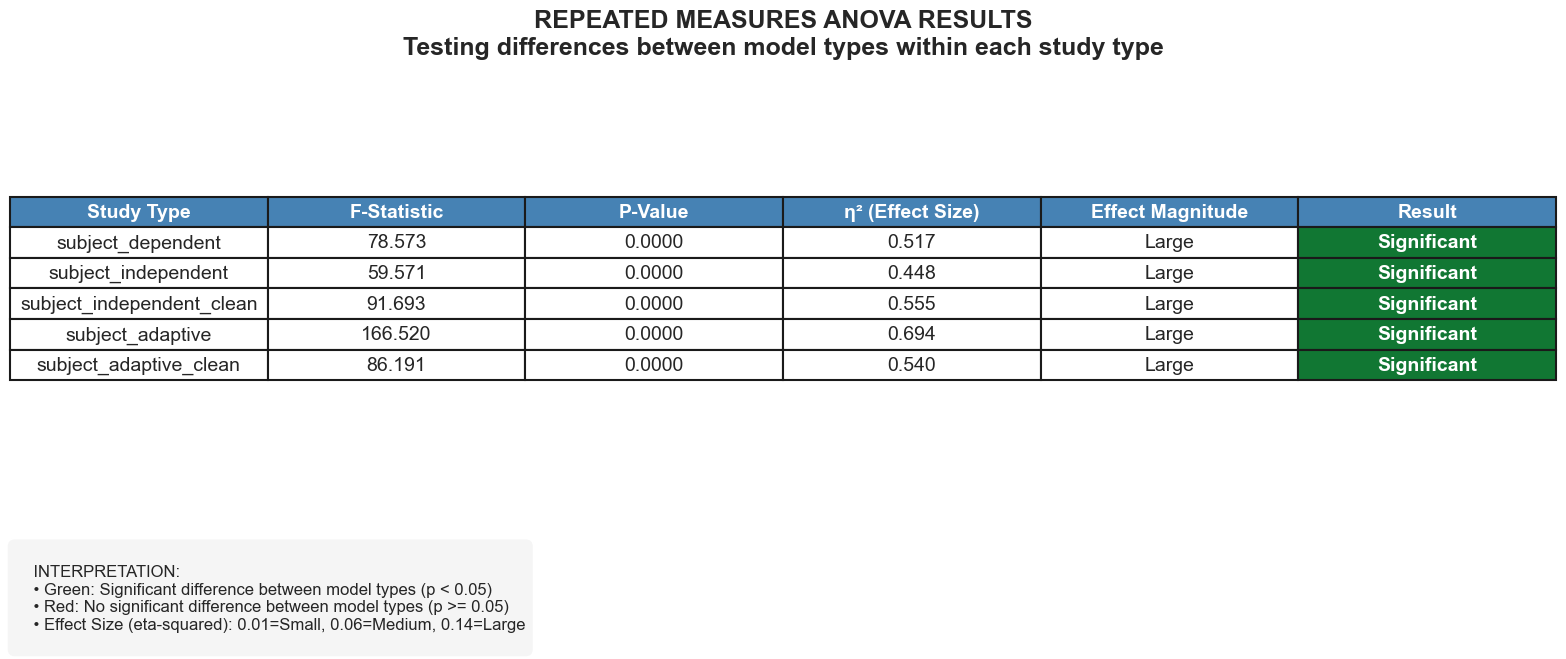

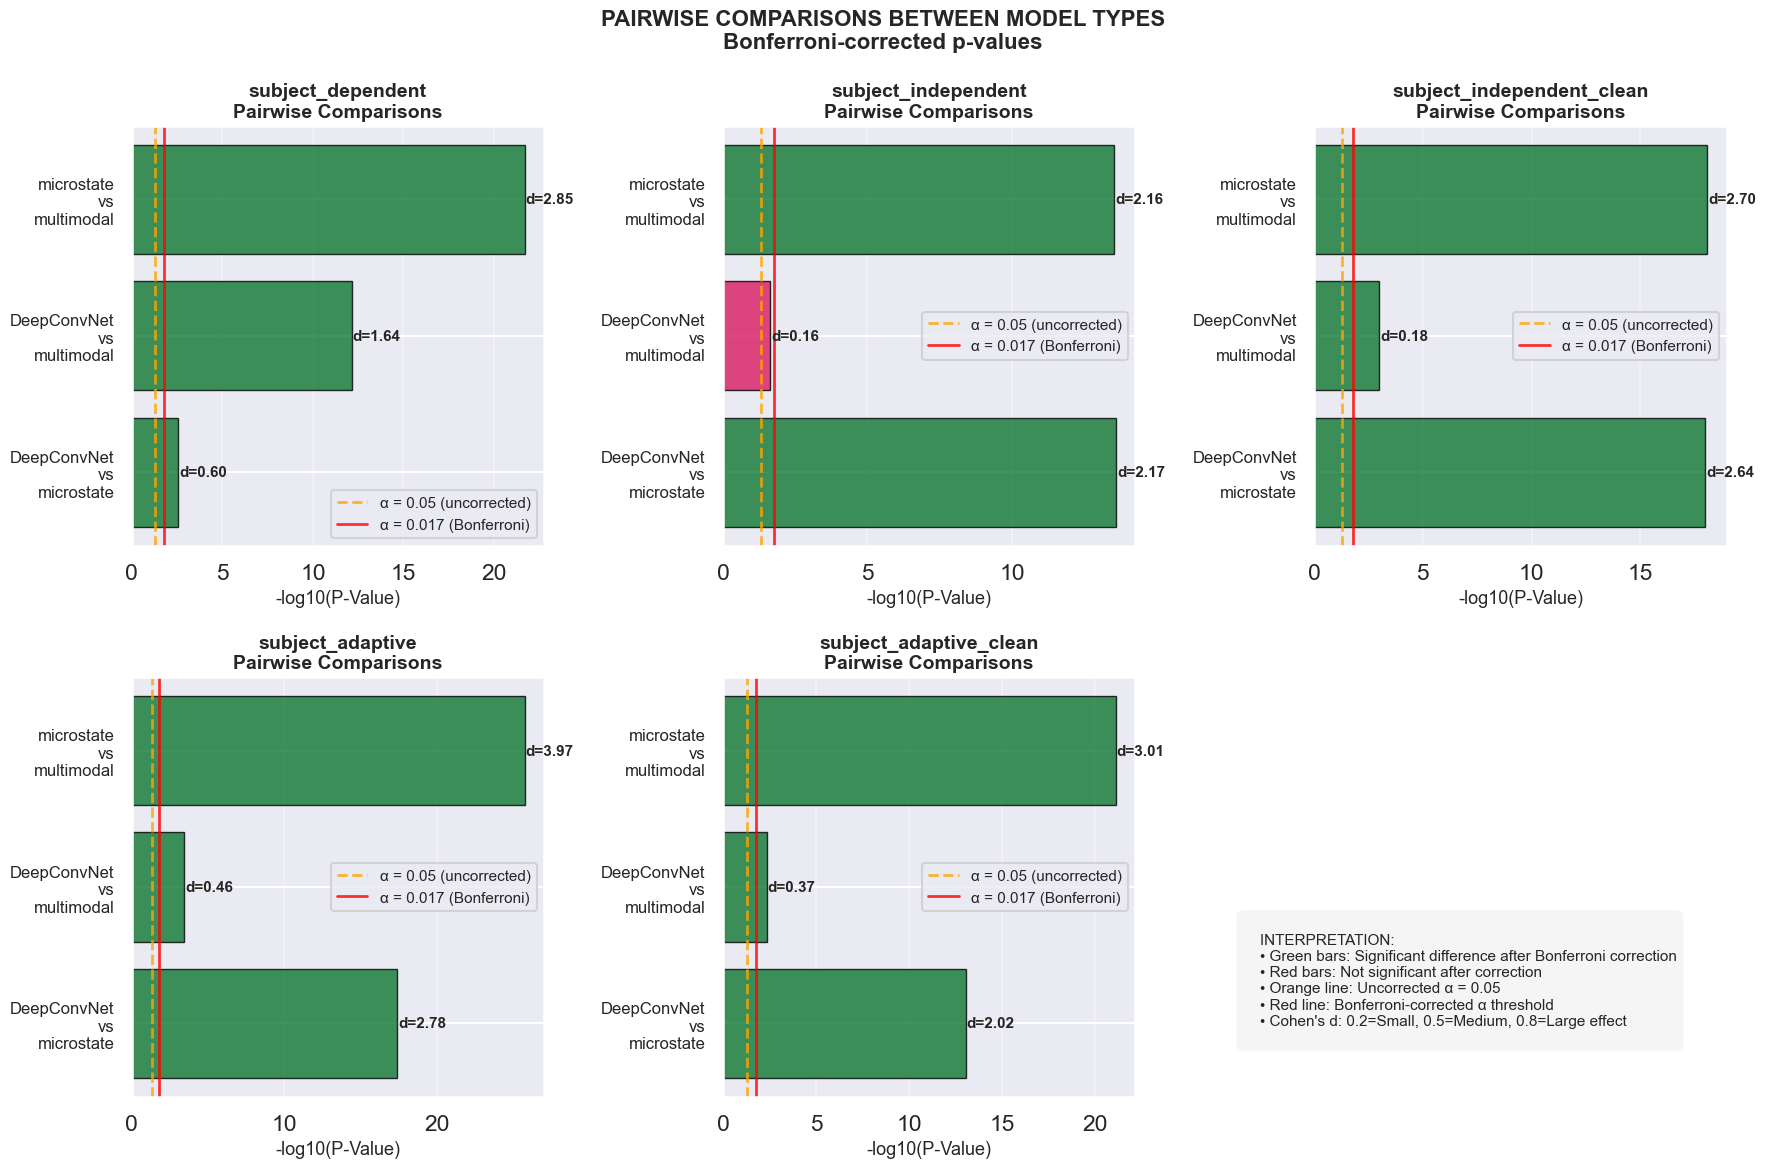

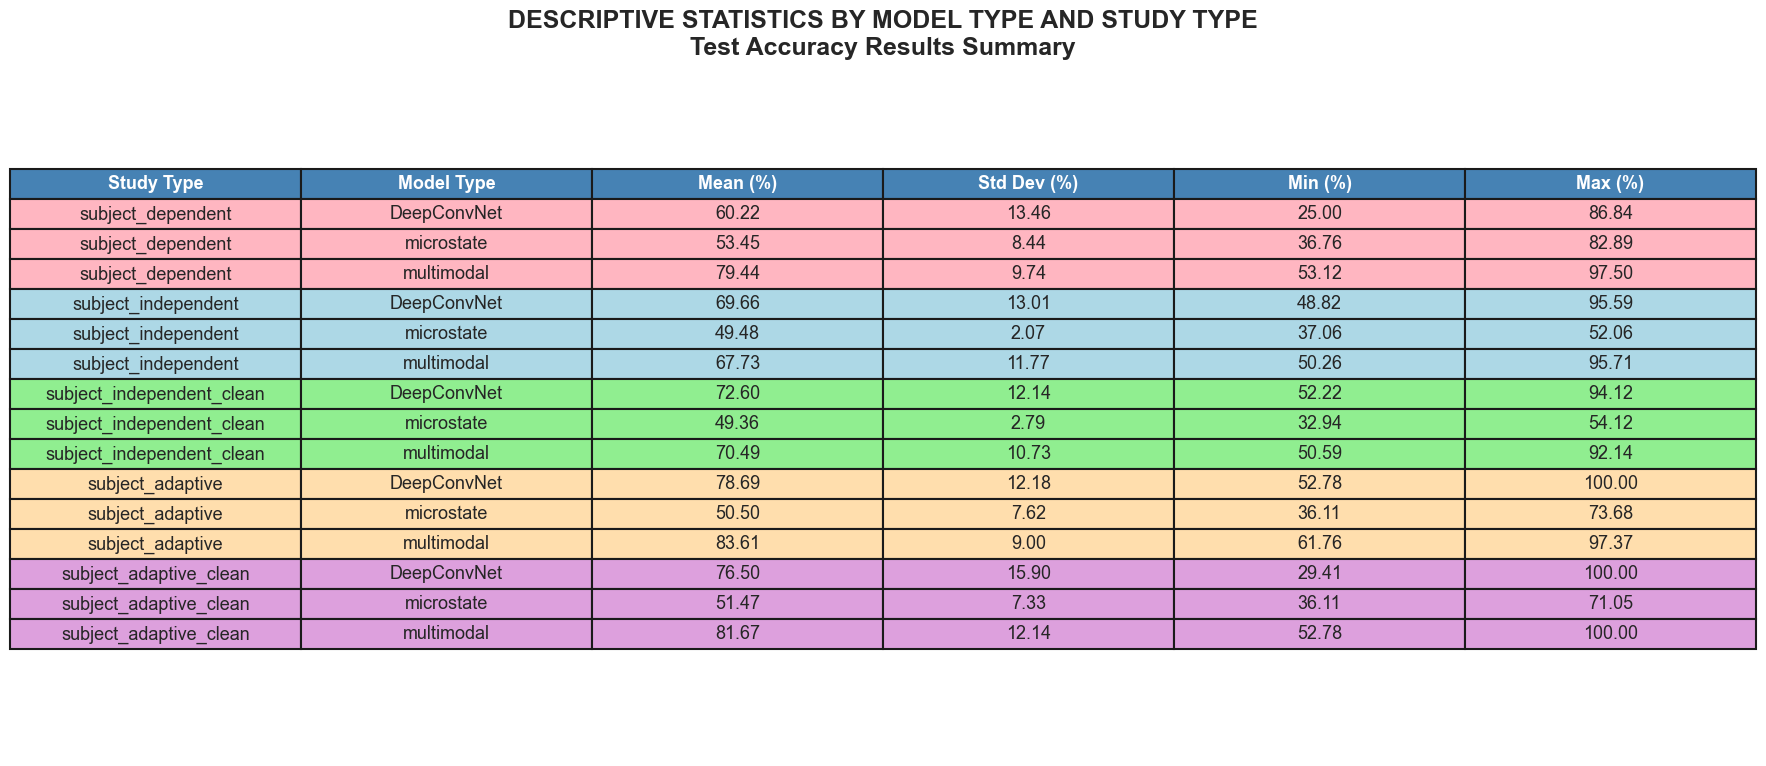

✓ Statistical analysis plots saved:
  - statistical_analysis_1_anova.png
  - statistical_analysis_2_pairwise.png
  - statistical_analysis_3_descriptive.png


In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import f_oneway, ttest_rel, shapiro, levene
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
from itertools import combinations
import os

def create_three_statistical_plots(results, output_path):
    """
    Create 3 separate plots for statistical analysis results
    """
    
    # Define color schemes
    colors_stat = {
        'significant': '#117733',     # green
        'not_significant': '#d81b60',  # Magenta
        'neutral': '#4682B4',         # Steel blue
        'background': '#F5F5F5'       # White smoke
    }
    
    # Store all results
    all_results = {}
    
    
    # Process each study type
    for study_type, model_accuracies in results.items():
        if study_type == 'subject':
            study_type_name = 'subject_dependent'
        else:
            study_type_name = study_type
            
        model_types = list(model_accuracies.keys())
        n_subjects = len(model_accuracies[model_types[0]])
        
        # Prepare data for ANOVA
        data_for_anova = []
        for subject_id in range(n_subjects):
            for model_type in model_types:
                data_for_anova.append({
                    'Subject': f'S{subject_id}',
                    'Model_Type': model_type,
                    'Accuracy': model_accuracies[model_type][subject_id]
                })
        
        df_anova = pd.DataFrame(data_for_anova)
        
        # Descriptive statistics
        desc_stats = df_anova.groupby('Model_Type')['Accuracy'].agg([
            'mean', 'std', 'min', 'max'
        ]).round(2)
        
        # Perform ANOVA
        try:
            anova_results = AnovaRM(df_anova, 'Accuracy', 'Subject', within=['Model_Type'])
            anova_table = anova_results.fit()
            f_stat = anova_table.anova_table['F Value']['Model_Type']
            p_value = anova_table.anova_table['Pr > F']['Model_Type']
            
            # Effect size
            ss_between = anova_table.anova_table['SS']['Model_Type']
            ss_total = anova_table.anova_table['SS'].sum()
            eta_squared = ss_between / ss_total
            
        except Exception as e:
            print(f"Repeated measures ANOVA failed for {study_type_name}: {e}")
            print("Falling back to one-way ANOVA...")
            
            # Fallback to one-way ANOVA with effect size calculation
            model_data_list = [df_anova[df_anova['Model_Type'] == mt]['Accuracy'] 
                              for mt in model_types]
            f_stat, p_value = f_oneway(*model_data_list)
            
            # Calculate eta-squared for one-way ANOVA
            # eta² = SS_between / SS_total
            grand_mean = df_anova['Accuracy'].mean()
            
            # Calculate SS_between (sum of squares between groups)
            ss_between = 0
            for mt in model_types:
                group_data = df_anova[df_anova['Model_Type'] == mt]['Accuracy']
                group_mean = group_data.mean()
                n_group = len(group_data)
                ss_between += n_group * (group_mean - grand_mean) ** 2
            
            # Calculate SS_total (total sum of squares)
            ss_total = ((df_anova['Accuracy'] - grand_mean) ** 2).sum()
            
            # Calculate eta-squared
            eta_squared = ss_between / ss_total if ss_total > 0 else 0
        
        # Pairwise comparisons
        pairwise_results = []
        n_comparisons = len(list(combinations(model_types, 2)))
        alpha_bonferroni = 0.05 / n_comparisons

        for model1, model2 in combinations(model_types, 2):
            data1 = model_accuracies[model1]
            data2 = model_accuracies[model2]
            
            t_stat, p_val = ttest_rel(data1, data2)
            
            # Cohen's d
            pooled_std = np.sqrt(((np.std(data1, ddof=1)**2 + np.std(data2, ddof=1)**2) / 2))
            cohens_d = (np.mean(data1) - np.mean(data2)) / pooled_std
            
            pairwise_results.append({
                'Comparison': f'{model1} vs {model2}',
                'Mean_Diff': np.mean(data1) - np.mean(data2),
                'T_Stat': t_stat,
                'P_Value': p_val,
                'Cohens_D': cohens_d,
                'Significant': p_val < alpha_bonferroni,
                'Alpha_Bonferroni': alpha_bonferroni
            })
        
        all_results[study_type_name] = {
            'descriptive': desc_stats,
            'anova_f': f_stat,
            'anova_p': p_value,
            'eta_squared': eta_squared,
            'pairwise': pairwise_results
        }
    
    # =============================================================================
    # PLOT 1: ANOVA RESULTS TABLE
    # =============================================================================
    
    fig1, ax1 = plt.subplots(figsize=(16, 8))
    ax1.axis('off')
    
    # Prepare ANOVA summary table
    anova_summary = []
    for study_type, res in all_results.items():
        significance = "Significant" if res['anova_p'] < 0.05 else "Not Significant"
        
        # Handle effect size display
        if np.isnan(res['eta_squared']) or res['eta_squared'] is None:
            eta_squared_str = "N/A"
            effect_size = "N/A"
        else:
            eta_squared_str = f"{res['eta_squared']:.3f}"
            if res['eta_squared'] > 0.14:
                effect_size = "Large"
            elif res['eta_squared'] > 0.06:
                effect_size = "Medium"
            else:
                effect_size = "Small"
        
        anova_summary.append([
            study_type,
            f"{res['anova_f']:.3f}",
            f"{res['anova_p']:.4f}",
            eta_squared_str,
            effect_size,
            significance
        ])
    
    # Create ANOVA table
    anova_df = pd.DataFrame(anova_summary, columns=[
        'Study Type', 'F-Statistic', 'P-Value', 'η² (Effect Size)', 'Effect Magnitude', 'Result'
    ])
    
    # Plot ANOVA table
    table1 = ax1.table(cellText=anova_df.values, colLabels=anova_df.columns,
                      cellLoc='center', loc='center')
    table1.auto_set_font_size(False)
    table1.set_fontsize(14)
    table1.scale(1, 2.5)
    
    # Color code the results
    try:
        for i in range(len(anova_summary)):
            result_col = len(anova_df.columns) - 1
            if "Significant" in anova_summary[i][-1] and "Not" not in anova_summary[i][-1]:
                table1[(i+1, result_col)].set_facecolor(colors_stat['significant'])
                table1[(i+1, result_col)].set_text_props(weight='bold', color='white')
            else:
                table1[(i+1, result_col)].set_facecolor(colors_stat['not_significant'])
                table1[(i+1, result_col)].set_text_props(weight='bold', color='white')
        
        # Header styling
        for j in range(len(anova_df.columns)):
            table1[(0, j)].set_facecolor(colors_stat['neutral'])
            table1[(0, j)].set_text_props(weight='bold', color='white')
    except Exception as e:
        print(f"Warning: ANOVA table formatting error: {e}")
    
    ax1.set_title('REPEATED MEASURES ANOVA RESULTS\nTesting differences between model types within each study type', 
                  fontsize=18, fontweight='bold')
    
    # Add interpretation
    interpretation_text = """
    INTERPRETATION:
    • Green: Significant difference between model types (p < 0.05)
    • Red: No significant difference between model types (p >= 0.05)
    • Effect Size (eta-squared): 0.01=Small, 0.06=Medium, 0.14=Large
    """
    
    plt.figtext(0.02, 0.02, interpretation_text, fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.5", facecolor=colors_stat['background']))
    
    plt.tight_layout(rect=[0, 0.15, 1, 0.85])  # Lower the title position
    plt.savefig(os.path.join(output_path, 'statistical_analysis_1_anova.png'), 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # =============================================================================
    # PLOT 2: PAIRWISE COMPARISONS
    # =============================================================================
    
    study_types = list(all_results.keys())
    n_studies = len(study_types)
    
    # Create subplots for pairwise comparisons
    if n_studies <= 3:
        ncols = n_studies
        nrows = 1
    else:
        ncols = 3
        nrows = (n_studies + 2) // 3
    
    fig2, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 6*nrows))
    if n_studies == 1:
        axes = [axes]
    elif nrows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    for idx, study_type in enumerate(study_types):
        ax = axes[idx]
        
        pairwise_data = all_results[study_type]['pairwise']

        if not pairwise_data:
            ax.text(0.5, 0.5, f'No pairwise comparisons\navailable for {study_type}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title(f'{study_type}: Pairwise Comparisons', fontsize=16, fontweight='bold')
            continue
        
        # Get the Bonferroni-corrected alpha for this model
        alpha_bonferroni = pairwise_data[0]['Alpha_Bonferroni']
        
        # Create pairwise comparison visualization
        comparisons = [p['Comparison'] for p in pairwise_data]
        # replace raw with DeepConvNet on Raw EEG
        comparisons = [c.replace('raw', 'DeepConvNet') for c in comparisons]
        p_values = [p['P_Value'] for p in pairwise_data]
        effect_sizes = [abs(p['Cohens_D']) for p in pairwise_data]
        significant = [p['Significant'] for p in pairwise_data]
        
        # Create horizontal bar plot
        colors_bars = [colors_stat['significant'] if sig else colors_stat['not_significant'] 
                      for sig in significant]
        
        bars = ax.barh(range(len(comparisons)), [-np.log10(p) for p in p_values], 
                      color=colors_bars, edgecolor='black', alpha=0.8, linewidth=1)
        
        # Add significance line
        ax.axvline(x=-np.log10(0.05), color='orange', linestyle='--', alpha=0.8, 
                  label='α = 0.05 (uncorrected)', linewidth=2)
        ax.axvline(x=-np.log10(alpha_bonferroni), color='red', linestyle='-', alpha=0.8, 
                  label=f'α = {alpha_bonferroni:.3f} (Bonferroni)', linewidth=2)
        
        # Add effect size annotations
        for i, (bar, effect) in enumerate(zip(bars, effect_sizes)):
            if bar.get_width() > 0:
                ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, 
                       f'd={effect:.2f}', va='center', fontsize=11, fontweight='bold')
        
        ax.set_yticks(range(len(comparisons)))
        ax.set_yticklabels([c.replace(' vs ', '\nvs\n') for c in comparisons], fontsize=12)
        ax.set_xlabel('-log10(P-Value)', fontsize=13)
        ax.set_title(f'{study_type}\nPairwise Comparisons', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(axis='x', alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_studies, len(axes)):
        axes[idx].set_visible(False)
    
    fig2.suptitle('PAIRWISE COMPARISONS BETWEEN MODEL TYPES\nBonferroni-corrected p-values', 
                  fontsize=16, fontweight='bold')
    
    # Add interpretation
    interpretation_text2 = """
    INTERPRETATION:
    • Green bars: Significant difference after Bonferroni correction
    • Red bars: Not significant after correction
    • Orange line: Uncorrected α = 0.05
    • Red line: Bonferroni-corrected α threshold
    • Cohen's d: 0.2=Small, 0.5=Medium, 0.8=Large effect
    """
    
    plt.figtext(0.7, 0.12, interpretation_text2, fontsize=11, 
                bbox=dict(boxstyle="round,pad=0.5", facecolor=colors_stat['background']))
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'statistical_analysis_2_pairwise.png'), 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # =============================================================================
    # PLOT 3: DESCRIPTIVE STATISTICS
    # =============================================================================
    
    fig3, ax3 = plt.subplots(figsize=(18, 10))
    ax3.axis('off')
    
    # Create descriptive statistics table
    desc_summary = []
    for study_type, res in all_results.items():
        for model_type, stats in res['descriptive'].iterrows():
            if model_type == 'raw':
                model_type = 'DeepConvNet'
            desc_summary.append([
                study_type,
                model_type,
                f"{stats['mean']:.2f}",
                f"{stats['std']:.2f}",
                f"{stats['min']:.2f}",
                f"{stats['max']:.2f}"
            ])
    
    desc_df = pd.DataFrame(desc_summary, columns=[
        'Study Type', 'Model Type', 'Mean (%)', 'Std Dev (%)', 'Min (%)', 'Max (%)'
    ])
    
    # Plot descriptive table
    table3 = ax3.table(cellText=desc_df.values, colLabels=desc_df.columns,
                      cellLoc='center', loc='center')
    table3.auto_set_font_size(False)
    table3.set_fontsize(13)
    table3.scale(1, 2)
    
    # Color coding for study types
    try:
        study_types_list = list(all_results.keys())
        study_colors = ['#E6F3FF', '#F0F8E6', '#FFF0E6', '#FFE6F3', '#F3E6FF']  # Light colors
        # pastel colors for study types
        study_colors = ['#FFB6C1', '#ADD8E6', '#90EE90', '#FFDEAD', '#DDA0DD']  # Pastel colors
        for i, row in desc_df.iterrows():
            study_idx = study_types_list.index(row['Study Type'])
            color = study_colors[study_idx % len(study_colors)]
            for j in range(len(desc_df.columns)):
                table3[(i+1, j)].set_facecolor(color)
        
        # Header styling
        for j in range(len(desc_df.columns)):
            table3[(0, j)].set_facecolor(colors_stat['neutral'])
            table3[(0, j)].set_text_props(weight='bold', color='white')
    except Exception as e:
        print(f"Warning: Descriptive table formatting error: {e}")
    
    ax3.set_title('DESCRIPTIVE STATISTICS BY MODEL TYPE AND STUDY TYPE\nTest Accuracy Results Summary', 
                  fontsize=18, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.85])  # Lower the title position
    plt.savefig(os.path.join(output_path, 'statistical_analysis_3_descriptive.png'), 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return all_results

# Run the analysis and create the three plots
print("Creating three separate statistical analysis plots...")
statistical_results = create_three_statistical_plots(results, output_path)
print("✓ Statistical analysis plots saved:")
print("  - statistical_analysis_1_anova.png")
print("  - statistical_analysis_2_pairwise.png") 
print("  - statistical_analysis_3_descriptive.png")

## Checking for significant differences between model types across all study types

In [65]:
from scipy import stats
from scipy.stats import f_oneway, ttest_rel, shapiro, levene
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd
import numpy as np

def perform_statistical_tests(results):
    """
    Perform statistical tests comparing study types within each model type
    """
    
    # Store results
    statistical_results = {}
    
    # First, reorganize data by model type
    model_types = set()
    study_types = list(results.keys())
    
    # Get all model types
    for study_type, model_accuracies in results.items():
        model_types.update(model_accuracies.keys())
    
    model_types = list(model_types)
    
    # For each model type, compare study types
    for model_type in model_types:
        print(f"\n{'='*60}")
        print(f"STATISTICAL ANALYSIS FOR: {model_type.upper()}")
        print(f"{'='*60}")
        
        # Prepare data for this model type across study types
        study_accuracies = {}
        n_subjects = None
        
        for study_type in study_types:
            if model_type in results[study_type]:
                study_name = 'subject_dependent' if study_type == 'subject' else study_type
                study_accuracies[study_name] = results[study_type][model_type]
                if n_subjects is None:
                    n_subjects = len(results[study_type][model_type])
        
        # Skip if not enough study types have this model
        if len(study_accuracies) < 2:
            print(f"Insufficient data for {model_type} (found in {len(study_accuracies)} study types)")
            continue
            
        # Create DataFrame for repeated measures ANOVA
        data_for_anova = []
        for subject_id in range(n_subjects):
            for study_name in study_accuracies.keys():
                data_for_anova.append({
                    'Subject': f'S{subject_id}',
                    'Study_Type': study_name,
                    'Accuracy': study_accuracies[study_name][subject_id]
                })
        
        df_anova = pd.DataFrame(data_for_anova)
        
        # 1. Descriptive Statistics
        print(f"\n1. DESCRIPTIVE STATISTICS:")
        print("-" * 40)
        desc_stats = df_anova.groupby('Study_Type')['Accuracy'].agg([
            'count', 'mean', 'std', 'min', 'max'
        ]).round(2)
        print(desc_stats)
        
        # 2. Check assumptions
        print(f"\n2. ASSUMPTION CHECKS:")
        print("-" * 40)
        
        # Normality test for each study type
        normality_results = {}
        study_type_names = list(study_accuracies.keys())
        for study_name in study_type_names:
            study_data = df_anova[df_anova['Study_Type'] == study_name]['Accuracy']
            stat, p_value = shapiro(study_data)
            normality_results[study_name] = {'statistic': stat, 'p_value': p_value}
            print(f"Normality test ({study_name}): W={stat:.4f}, p={p_value:.4f}")
        
        # Homogeneity of variance (Levene's test)
        study_data_list = [df_anova[df_anova['Study_Type'] == st]['Accuracy'] 
                          for st in study_type_names]
        levene_stat, levene_p = levene(*study_data_list)
        print(f"Levene's test (homogeneity): W={levene_stat:.4f}, p={levene_p:.4f}")
        
        # 3. Repeated Measures ANOVA
        print(f"\n3. REPEATED MEASURES ANOVA:")
        print("-" * 40)
        
        try:
            # Perform repeated measures ANOVA
            anova_results = AnovaRM(df_anova, 'Accuracy', 'Subject', within=['Study_Type'])
            anova_table = anova_results.fit()
            print(anova_table.summary())
            
            # Extract F-statistic and p-value
            f_stat = anova_table.anova_table['F Value']['Study_Type']
            p_value = anova_table.anova_table['Pr > F']['Study_Type']
            
            # Effect size (eta-squared)
            ss_between = anova_table.anova_table['SS']['Study_Type']
            ss_total = anova_table.anova_table['SS'].sum()
            eta_squared = ss_between / ss_total
            
            print(f"\nANOVA Results:")
            print(f"F({len(study_type_names)-1}, {(len(study_type_names)-1)*(n_subjects-1)}) = {f_stat:.4f}")
            print(f"p-value = {p_value:.4f}")
            print(f"Effect size (η²) = {eta_squared:.4f}")
            
            # Interpretation
            if p_value < 0.05:
                print("✓ SIGNIFICANT difference between study types!")
            else:
                print("✗ No significant difference between study types")
                
        except Exception as e:
            print(f"ANOVA failed: {e}")
            print("Falling back to alternative tests...")
            
            # Alternative: One-way ANOVA (less appropriate but workable)
            f_stat, p_value = f_oneway(*study_data_list)
            print(f"One-way ANOVA: F={f_stat:.4f}, p={p_value:.4f}")
        
        # 4. Post-hoc tests (if significant)
        if p_value < 0.05:
            print(f"\n4. POST-HOC TESTS (Pairwise Comparisons):")
            print("-" * 40)
            
            # Tukey's HSD
            tukey_results = pairwise_tukeyhsd(df_anova['Accuracy'], 
                                            df_anova['Study_Type'], 
                                            alpha=0.05)
            print("Tukey's HSD Results:")
            print(tukey_results.summary())
            
            # Pairwise t-tests with Bonferroni correction
            print(f"\nPairwise t-tests with Bonferroni correction:")
            from itertools import combinations
            
            n_comparisons = len(list(combinations(study_type_names, 2)))
            alpha_bonferroni = 0.05 / n_comparisons
            
            for i, (study1, study2) in enumerate(combinations(study_type_names, 2)):
                data1 = study_accuracies[study1]
                data2 = study_accuracies[study2]
                
                t_stat, p_val = ttest_rel(data1, data2)
                
                # Cohen's d for effect size
                pooled_std = np.sqrt(((np.std(data1, ddof=1)**2 + np.std(data2, ddof=1)**2) / 2))
                cohens_d = (np.mean(data1) - np.mean(data2)) / pooled_std
                
                print(f"{study1} vs {study2}:")
                print(f"  t({n_subjects-1}) = {t_stat:.4f}, p = {p_val:.4f}")
                print(f"  Bonferroni-corrected α = {alpha_bonferroni:.4f}")
                print(f"  Cohen's d = {cohens_d:.4f}")
                
                if p_val < alpha_bonferroni:
                    print(f"  ✓ SIGNIFICANT after Bonferroni correction")
                else:
                    print(f"  ✗ Not significant after correction")
                print()
        
        # Store results
        statistical_results[model_type] = {
            'descriptive_stats': desc_stats,
            'normality_tests': normality_results,
            'levene_test': {'statistic': levene_stat, 'p_value': levene_p},
            'anova_f_stat': f_stat,
            'anova_p_value': p_value,
            'significant': p_value < 0.05
        }
    
    return statistical_results

# Run the statistical tests
print("STATISTICAL ANALYSIS OF STUDY TYPE COMPARISONS")
print("=" * 60)
print("Testing whether there are significant differences between study types")
print("within each model type using repeated measures ANOVA.")
print()

# Perform tests
results_stats = perform_statistical_tests(results)

# Summary
print(f"\n{'='*60}")
print("SUMMARY OF STATISTICAL TESTS")
print(f"{'='*60}")

for model_type, stats in results_stats.items():
    significance = "SIGNIFICANT" if stats['significant'] else "NOT SIGNIFICANT"
    print(f"{model_type}: F = {stats['anova_f_stat']:.4f}, p = {stats['anova_p_value']:.4f} ({significance})")

print(f"\n{'='*60}")
print("INTERPRETATION GUIDE:")
print("- p < 0.05: Significant difference between study types")
print("- Effect size (η²): 0.01=small, 0.06=medium, 0.14=large")
print("- Cohen's d: 0.2=small, 0.5=medium, 0.8=large effect")
print(f"{'='*60}")

STATISTICAL ANALYSIS OF STUDY TYPE COMPARISONS
Testing whether there are significant differences between study types
within each model type using repeated measures ANOVA.


STATISTICAL ANALYSIS FOR: MICROSTATE

1. DESCRIPTIVE STATISTICS:
----------------------------------------
                           count   mean   std    min    max
Study_Type                                                 
subject_adaptive              50  50.50  7.62  36.11  73.68
subject_adaptive_clean        50  51.47  7.33  36.11  71.05
subject_dependent             50  53.45  8.44  36.76  82.89
subject_independent           50  49.48  2.07  37.06  52.06
subject_independent_clean     50  49.36  2.79  32.94  54.12

2. ASSUMPTION CHECKS:
----------------------------------------
Normality test (subject_dependent): W=0.9395, p=0.0129
Normality test (subject_independent): W=0.3655, p=0.0000
Normality test (subject_independent_clean): W=0.4272, p=0.0000
Normality test (subject_adaptive): W=0.9730, p=0.3050
Normalit

Creating three separate statistical analysis plots for study type comparisons...
Repeated measures ANOVA failed for microstate: 'SS'
Falling back to one-way ANOVA...
Repeated measures ANOVA failed for multimodal: 'SS'
Falling back to one-way ANOVA...
Repeated measures ANOVA failed for DeepConvNet: 'SS'
Falling back to one-way ANOVA...


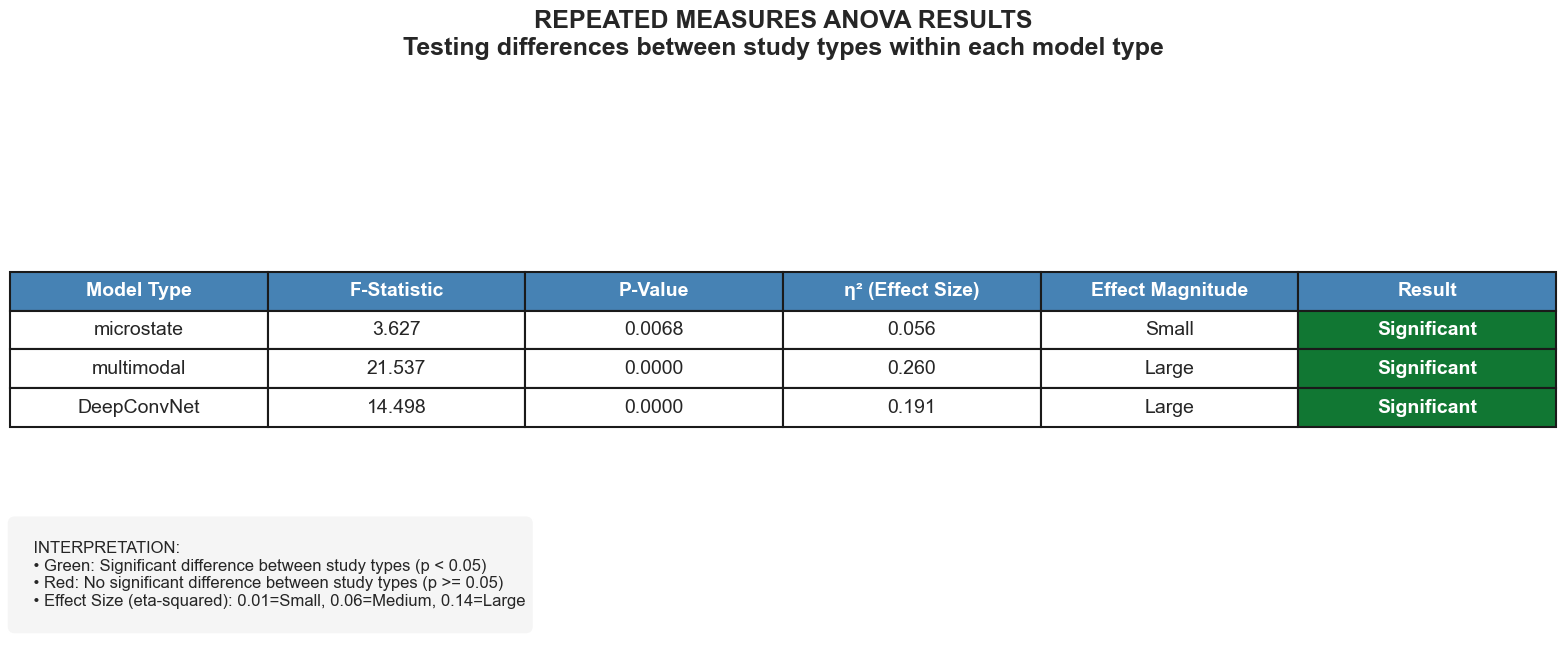

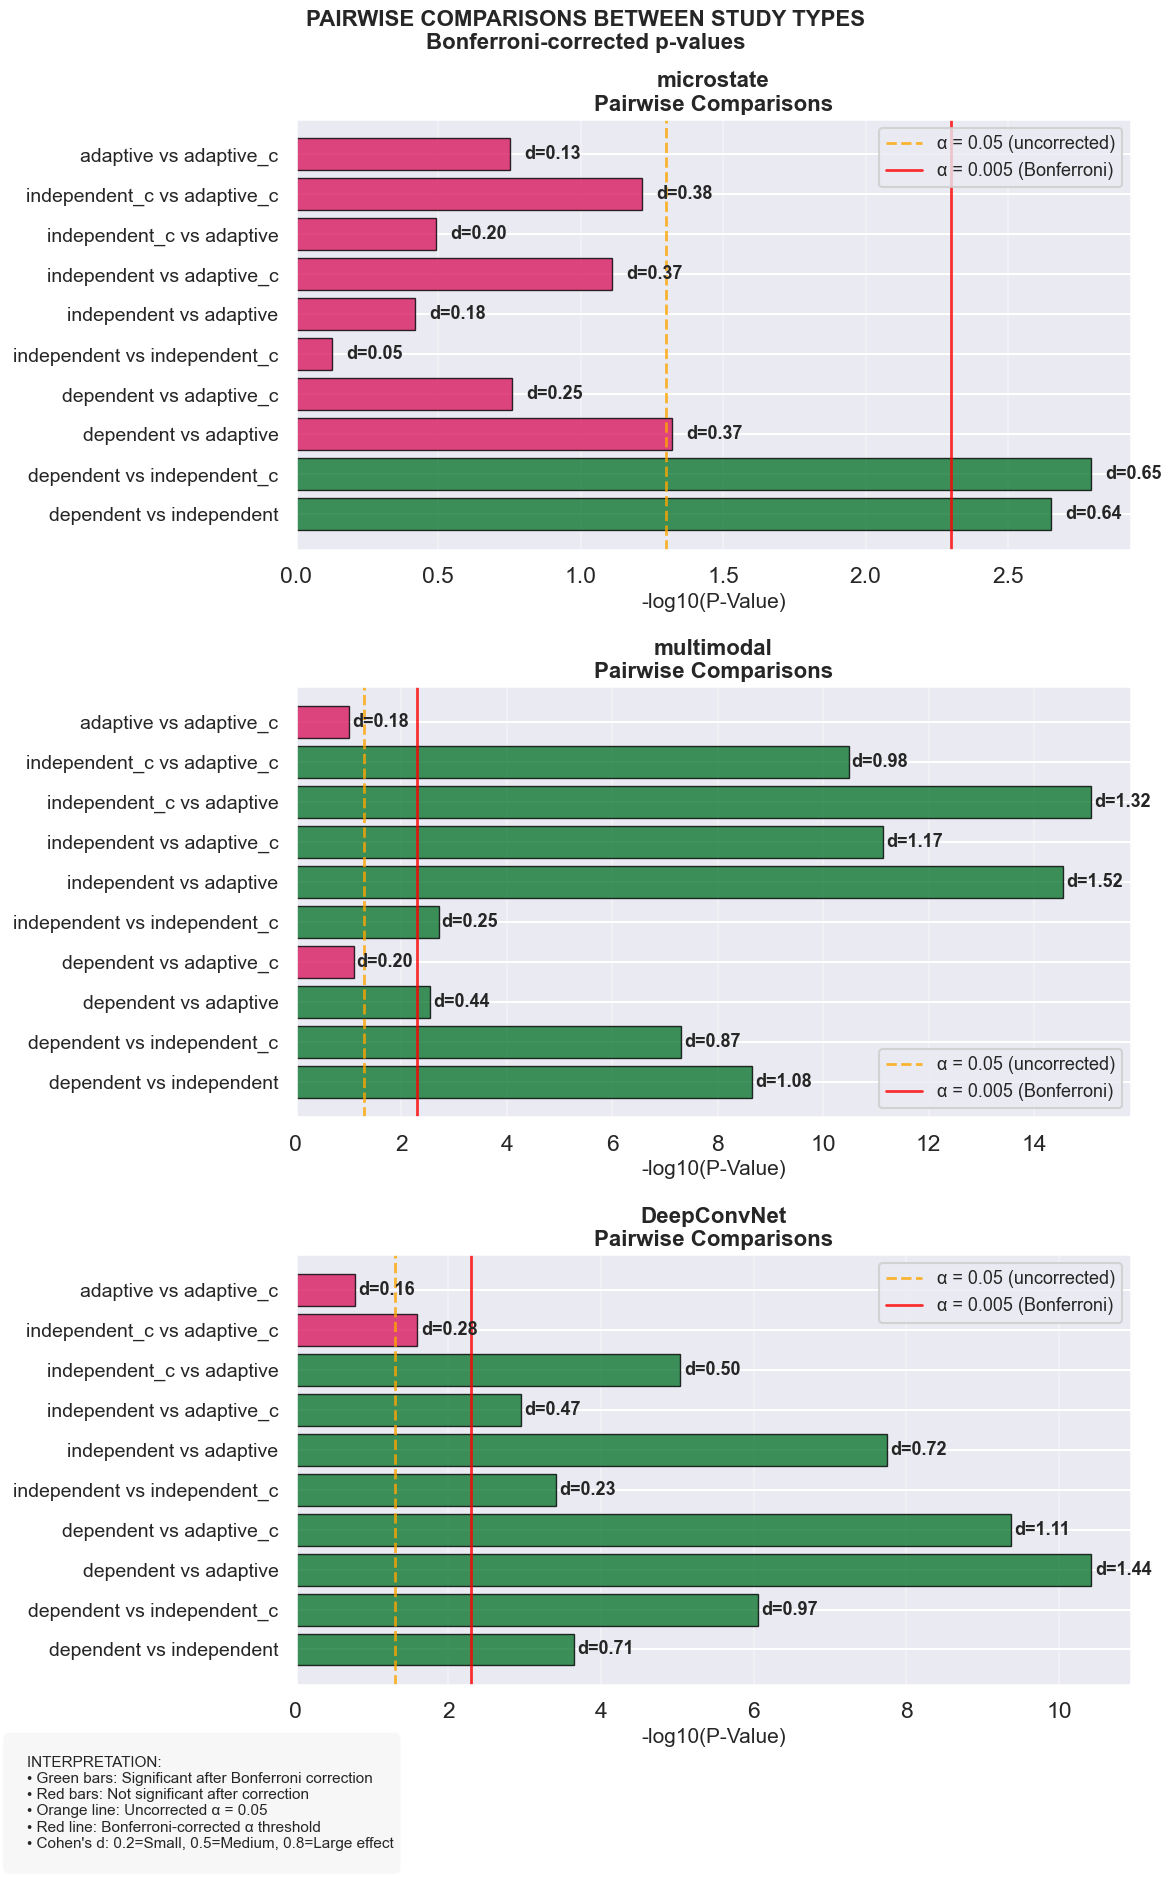

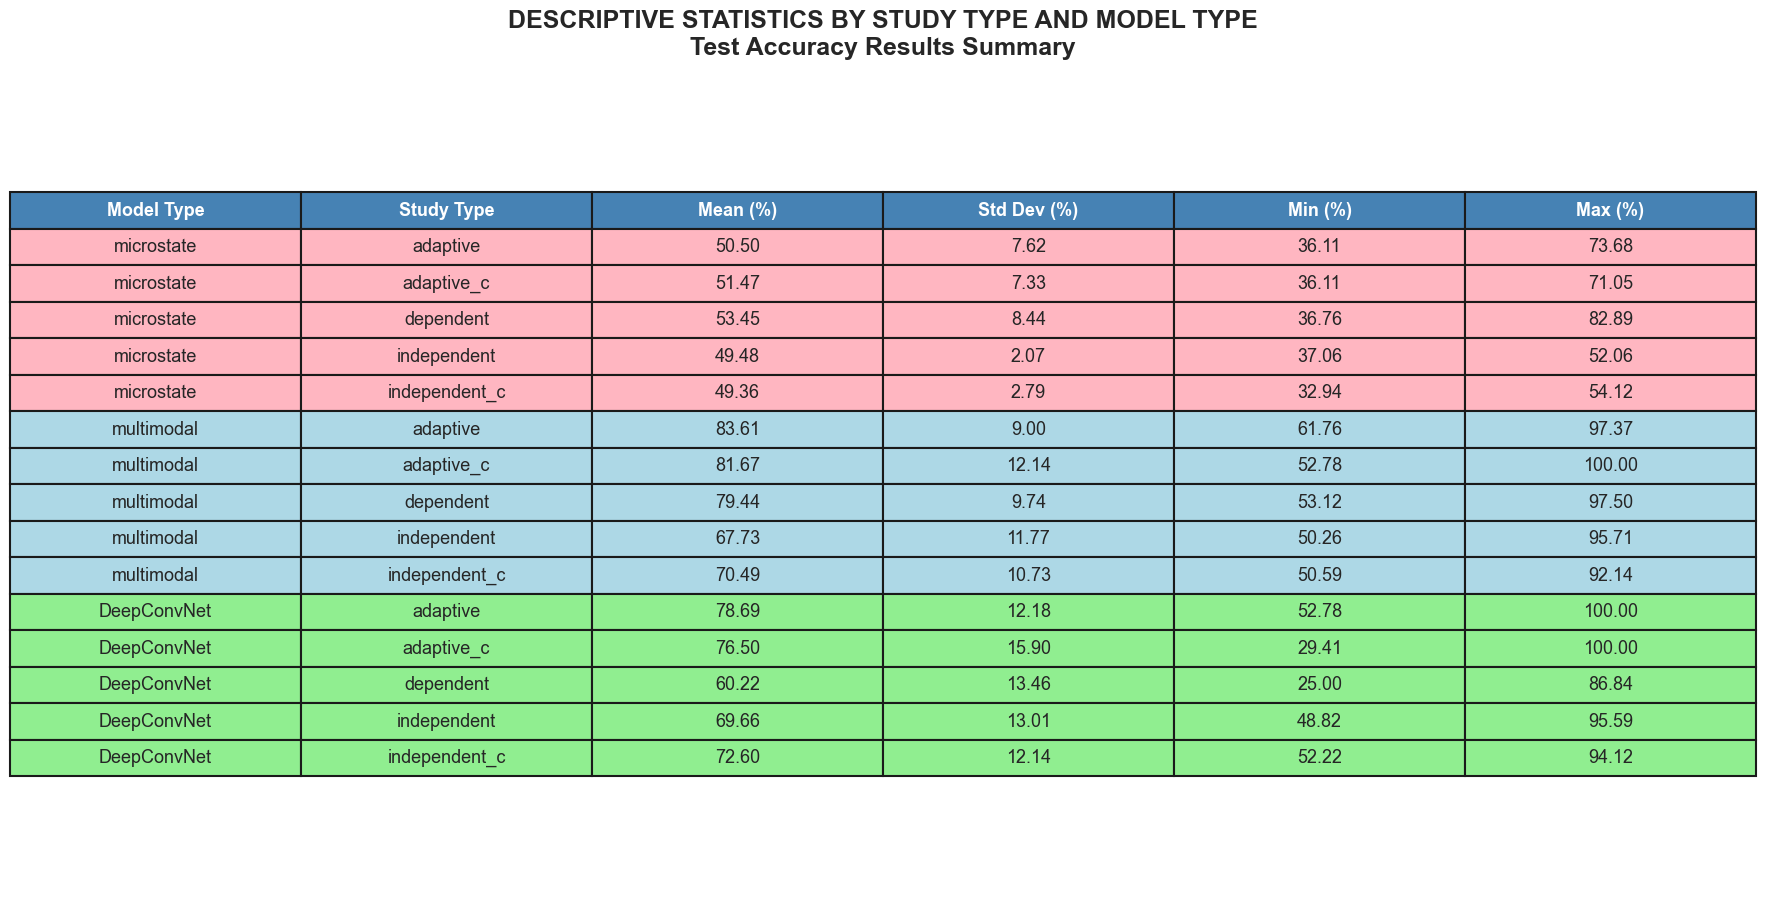

✓ Statistical analysis plots saved:
  - statistical_analysis_1_anova_study_types.png
  - statistical_analysis_2_pairwise_study_types.png
  - statistical_analysis_3_descriptive_study_types.png


In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import f_oneway, ttest_rel, shapiro, levene
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
from itertools import combinations
import os

def create_three_statistical_plots(results, output_path):
    """
    Create 3 separate plots for statistical analysis results comparing study types within each model type
    """
    
    # Define color schemes
    colors_stat = {
        'significant': '#117733',     # green
        'not_significant': '#d81b60',  # Magenta
        'neutral': '#4682B4',         # Steel blue
        'background': '#F5F5F5'       # White smoke
    }
    
    # Store all results
    all_results = {}
    
    # First, reorganize data by model type
    model_types = set()
    study_types = list(results.keys())
    
    # Get all model types
    for study_type, model_accuracies in results.items():
        model_types.update(model_accuracies.keys())
    
    model_types = list(model_types)
    
    # Process each model type
    for model_type in model_types:
        
        # Prepare data for this model type across study types
        study_accuracies = {}
        n_subjects = None
        
        for study_type in study_types:
            if model_type in results[study_type]:
                study_name = 'subject_dependent' if study_type == 'subject' else study_type
                # Clean study names for display: remove "subject_", "_subject", and replace "clean" with "c"
                study_name_clean = study_name.replace('subject_', '').replace('_subject', '').replace('clean', 'c')
                study_accuracies[study_name_clean] = results[study_type][model_type]
                if n_subjects is None:
                    n_subjects = len(results[study_type][model_type])
        
        # Skip if not enough study types have this model
        if len(study_accuracies) < 2:
            print(f"Insufficient data for {model_type} (found in {len(study_accuracies)} study types)")
            continue
            
        study_type_names = list(study_accuracies.keys())
        
        # Create DataFrame for ANOVA
        data_for_anova = []
        for subject_id in range(n_subjects):
            for study_name in study_accuracies.keys():
                data_for_anova.append({
                    'Subject': f'S{subject_id}',
                    'Study_Type': study_name,
                    'Accuracy': study_accuracies[study_name][subject_id]
                })
        
        df_anova = pd.DataFrame(data_for_anova)
        
        # Descriptive statistics
        desc_stats = df_anova.groupby('Study_Type')['Accuracy'].agg([
            'mean', 'std', 'min', 'max'
        ]).round(2)
        
        # Perform ANOVA
        try:
            anova_results = AnovaRM(df_anova, 'Accuracy', 'Subject', within=['Study_Type'])
            anova_table = anova_results.fit()
            f_stat = anova_table.anova_table['F Value']['Study_Type']
            p_value = anova_table.anova_table['Pr > F']['Study_Type']
            
            # Effect size
            ss_between = anova_table.anova_table['SS']['Study_Type']
            ss_total = anova_table.anova_table['SS'].sum()
            eta_squared = ss_between / ss_total
            
        except Exception as e:
            print(f"Repeated measures ANOVA failed for {model_type}: {e}")
            print("Falling back to one-way ANOVA...")
            
            # Fallback to one-way ANOVA with effect size calculation
            study_data_list = [df_anova[df_anova['Study_Type'] == st]['Accuracy'] 
                              for st in study_type_names]
            f_stat, p_value = f_oneway(*study_data_list)
            
            # Calculate eta-squared for one-way ANOVA
            grand_mean = df_anova['Accuracy'].mean()
            
            # Calculate SS_between (sum of squares between groups)
            ss_between = 0
            for st in study_type_names:
                group_data = df_anova[df_anova['Study_Type'] == st]['Accuracy']
                group_mean = group_data.mean()
                n_group = len(group_data)
                ss_between += n_group * (group_mean - grand_mean) ** 2
            
            # Calculate SS_total (total sum of squares)
            ss_total = ((df_anova['Accuracy'] - grand_mean) ** 2).sum()
            
            # Calculate eta-squared
            eta_squared = ss_between / ss_total if ss_total > 0 else 0
        
        # Pairwise comparisons
        pairwise_results = []
        n_comparisons = len(list(combinations(study_type_names, 2)))
        alpha_bonferroni = 0.05 / n_comparisons
        
        for study1, study2 in combinations(study_type_names, 2):
            data1 = study_accuracies[study1]
            data2 = study_accuracies[study2]
            
            t_stat, p_val = ttest_rel(data1, data2)
            
            # Cohen's d
            pooled_std = np.sqrt(((np.std(data1, ddof=1)**2 + np.std(data2, ddof=1)**2) / 2))
            cohens_d = (np.mean(data1) - np.mean(data2)) / pooled_std
            
            pairwise_results.append({
                'Comparison': f'{study1} vs {study2}',
                'Mean_Diff': np.mean(data1) - np.mean(data2),
                'T_Stat': t_stat,
                'P_Value': p_val,
                'Cohens_D': cohens_d,
                'Significant': p_val < alpha_bonferroni,
                'Alpha_Bonferroni': alpha_bonferroni
            })
        
        all_results[model_type] = {
            'descriptive': desc_stats,
            'anova_f': f_stat,
            'anova_p': p_value,
            'eta_squared': eta_squared,
            'pairwise': pairwise_results
        }
    
    # =============================================================================
    # PLOT 1: ANOVA RESULTS TABLE
    # =============================================================================
    
    fig1, ax1 = plt.subplots(figsize=(16, 8))
    ax1.axis('off')
    
    # Prepare ANOVA summary table
    anova_summary = []
    for model_type, res in all_results.items():
        significance = "Significant" if res['anova_p'] < 0.05 else "Not Significant"
        
        # Handle effect size display
        if np.isnan(res['eta_squared']) or res['eta_squared'] is None:
            eta_squared_str = "N/A"
            effect_size = "N/A"
        else:
            eta_squared_str = f"{res['eta_squared']:.3f}"
            if res['eta_squared'] > 0.14:
                effect_size = "Large"
            elif res['eta_squared'] > 0.06:
                effect_size = "Medium"
            else:
                effect_size = "Small"
        if model_type == 'raw':
            model_type = 'DeepConvNet'
            
        anova_summary.append([
            model_type,
            f"{res['anova_f']:.3f}",
            f"{res['anova_p']:.4f}",
            eta_squared_str,
            effect_size,
            significance
        ])
    
    # Create ANOVA table
    anova_df = pd.DataFrame(anova_summary, columns=[
        'Model Type', 'F-Statistic', 'P-Value', 'η² (Effect Size)', 'Effect Magnitude', 'Result'
    ])
    
    # Plot ANOVA table
    table1 = ax1.table(cellText=anova_df.values, colLabels=anova_df.columns,
                      cellLoc='center', loc='center')
    table1.auto_set_font_size(False)
    table1.set_fontsize(14)
    table1.scale(1, 2.5)
    
    # Color code the results
    try:
        for i in range(len(anova_summary)):
            result_col = len(anova_df.columns) - 1
            if "Significant" in anova_summary[i][-1] and "Not" not in anova_summary[i][-1]:
                table1[(i+1, result_col)].set_facecolor(colors_stat['significant'])
                table1[(i+1, result_col)].set_text_props(weight='bold', color='white')
            else:
                table1[(i+1, result_col)].set_facecolor(colors_stat['not_significant'])
                table1[(i+1, result_col)].set_text_props(weight='bold', color='white')
        
        # Header styling
        for j in range(len(anova_df.columns)):
            table1[(0, j)].set_facecolor(colors_stat['neutral'])
            table1[(0, j)].set_text_props(weight='bold', color='white')
    except Exception as e:
        print(f"Warning: ANOVA table formatting error: {e}")
    
    ax1.set_title('REPEATED MEASURES ANOVA RESULTS\nTesting differences between study types within each model type', 
                  fontsize=18, fontweight='bold')
    
    # Add interpretation
    interpretation_text = """
    INTERPRETATION:
    • Green: Significant difference between study types (p < 0.05)
    • Red: No significant difference between study types (p >= 0.05)
    • Effect Size (eta-squared): 0.01=Small, 0.06=Medium, 0.14=Large
    """
    
    plt.figtext(0.02, 0.2, interpretation_text, fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.5", facecolor=colors_stat['background']))
    
    plt.tight_layout(rect=[0, 0.15, 1, 1])
    plt.savefig(os.path.join(output_path, 'statistical_analysis_1_anova_study_types.png'), 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # =============================================================================
    # PLOT 2: PAIRWISE COMPARISONS
    # =============================================================================
    
    model_types_list = list(all_results.keys())
    n_models = len(model_types_list)
    
    # Create subplots for pairwise comparisons - force 1 column layout to avoid text squeezing
    ncols = 1
    nrows = n_models
    
    fig2, axes = plt.subplots(nrows, ncols, figsize=(12, 6*nrows))
    if n_models == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for idx, model_type in enumerate(model_types_list):
        ax = axes[idx]
        
        pairwise_data = all_results[model_type]['pairwise']
        if model_type == 'raw':
            model_type = 'DeepConvNet'
        if not pairwise_data:
            ax.text(0.5, 0.5, f'No pairwise comparisons\navailable for {model_type}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title(f'{model_type}: Pairwise Comparisons', fontsize=16, fontweight='bold')
            continue
        
        # Get the Bonferroni-corrected alpha for this model
        alpha_bonferroni = pairwise_data[0]['Alpha_Bonferroni']
        
        # Create pairwise comparison visualization
        comparisons = [p['Comparison'] for p in pairwise_data]
        p_values = [p['P_Value'] for p in pairwise_data]
        effect_sizes = [abs(p['Cohens_D']) for p in pairwise_data]
        significant = [p['Significant'] for p in pairwise_data]
        
        # Create horizontal bar plot
        colors_bars = [colors_stat['significant'] if sig else colors_stat['not_significant'] 
                      for sig in significant]
        
        bars = ax.barh(range(len(comparisons)), [-np.log10(p) for p in p_values], 
                      color=colors_bars, alpha=0.8, edgecolor='black', linewidth=1)
        
        # Add significance lines - both uncorrected and Bonferroni-corrected
        ax.axvline(x=-np.log10(0.05), color='orange', linestyle='--', alpha=0.8, 
                  label='α = 0.05 (uncorrected)', linewidth=2)
        ax.axvline(x=-np.log10(alpha_bonferroni), color='red', linestyle='-', alpha=0.8, 
                  label=f'α = {alpha_bonferroni:.3f} (Bonferroni)', linewidth=2)
        
        # Add effect size annotations
        for i, (bar, effect) in enumerate(zip(bars, effect_sizes)):
            if bar.get_width() > 0:
                ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, 
                       f'd={effect:.2f}', va='center', fontsize=13, fontweight='bold')
        
        ax.set_yticks(range(len(comparisons)))
        ax.set_yticklabels(comparisons, fontsize=14)
        ax.set_xlabel('-log10(P-Value)', fontsize=15)
        ax.set_title(f'{model_type}\nPairwise Comparisons', fontsize=16, fontweight='bold')
        ax.legend(fontsize=13)
        ax.grid(axis='x', alpha=0.3)
    
    # Hide unused subplots (not needed with 1 column layout)
    # for idx in range(n_models, len(axes)):
    #     axes[idx].set_visible(False)
    
    fig2.suptitle('PAIRWISE COMPARISONS BETWEEN STUDY TYPES\nBonferroni-corrected p-values', 
                  fontsize=16, fontweight='bold')
    
    # Add interpretation
    interpretation_text2 = """
    INTERPRETATION:
    • Green bars: Significant after Bonferroni correction
    • Red bars: Not significant after correction
    • Orange line: Uncorrected α = 0.05
    • Red line: Bonferroni-corrected α threshold
    • Cohen's d: 0.2=Small, 0.5=Medium, 0.8=Large effect
    """
    
    plt.figtext(0.02, -0.05, interpretation_text2, fontsize=11, 
                bbox=dict(boxstyle="round,pad=0.5", facecolor=colors_stat['background'], alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'statistical_analysis_2_pairwise_study_types.png'), 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # =============================================================================
    # PLOT 3: DESCRIPTIVE STATISTICS
    # =============================================================================
    
    fig3, ax3 = plt.subplots(figsize=(18, 10))
    ax3.axis('off')
    
    # Create descriptive statistics table
    desc_summary = []
    for model_type, res in all_results.items():
        for study_type, stats in res['descriptive'].iterrows():
            desc_summary.append([
                model_type,
                study_type,
                f"{stats['mean']:.2f}",
                f"{stats['std']:.2f}",
                f"{stats['min']:.2f}",
                f"{stats['max']:.2f}"
            ])
    
    desc_df = pd.DataFrame(desc_summary, columns=[
        'Model Type', 'Study Type', 'Mean (%)', 'Std Dev (%)', 'Min (%)', 'Max (%)'
    ])
    
    # Plot descriptive table
    table3 = ax3.table(cellText=desc_df.values, colLabels=desc_df.columns,
                      cellLoc='center', loc='center')
    table3.auto_set_font_size(False)
    table3.set_fontsize(13)
    table3.scale(1, 2)
    
    # Color coding for model types
    try:
        model_types_list = list(all_results.keys())
        model_colors = ['#E6F3FF', '#F0F8E6', '#FFF0E6', '#FFE6F3', '#F3E6FF']  # Light colors
        model_colors = ['#FFB6C1', '#ADD8E6', '#90EE90', '#FFDEAD', '#DDA0DD']  # Pastel colors
        for i, row in desc_df.iterrows():
            model_idx = model_types_list.index(row['Model Type'])
            color = model_colors[model_idx % len(model_colors)]
            for j in range(len(desc_df.columns)):
                table3[(i+1, j)].set_facecolor(color)
        
        # Header styling
        for j in range(len(desc_df.columns)):
            table3[(0, j)].set_facecolor(colors_stat['neutral'])
            table3[(0, j)].set_text_props(weight='bold', color='white')
    except Exception as e:
        print(f"Warning: Descriptive table formatting error: {e}")
    
    ax3.set_title('DESCRIPTIVE STATISTICS BY STUDY TYPE AND MODEL TYPE\nTest Accuracy Results Summary', 
                  fontsize=18, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(os.path.join(output_path, 'statistical_analysis_3_descriptive_study_types.png'), 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return all_results

# Run the analysis and create the three plots
print("Creating three separate statistical analysis plots for study type comparisons...")
statistical_results = create_three_statistical_plots(results, output_path)
print("✓ Statistical analysis plots saved:")
print("  - statistical_analysis_1_anova_study_types.png")
print("  - statistical_analysis_2_pairwise_study_types.png") 
print("  - statistical_analysis_3_descriptive_study_types.png")

### Power analysis

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_rel, wilcoxon, friedmanchisquare
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.multitest import multipletests
import seaborn as sns
from itertools import combinations
import os

def improved_statistical_analysis(results, output_path):
    """
    More appropriate statistical analysis with better power considerations
    """
    
    # Store all results
    all_results = {}
    
    # Reorganize data by model type
    model_types = set()
    study_types = list(results.keys())
    
    for study_type, model_accuracies in results.items():
        model_types.update(model_accuracies.keys())
    
    model_types = list(model_types)
    
    print("IMPROVED STATISTICAL ANALYSIS")
    print("=" * 60)
    print("Using more appropriate tests with better statistical power")
    print()
    
    for model_type in model_types:
        print(f"\n{'='*50}")
        print(f"ANALYSIS FOR: {model_type.upper()}")
        print(f"{'='*50}")
        
        # Prepare data
        study_accuracies = {}
        n_subjects = None
        
        for study_type in study_types:
            if model_type in results[study_type]:
                study_name = 'subject_dependent' if study_type == 'subject' else study_type
                study_name_clean = study_name.replace('subject_', '').replace('_subject', '').replace('clean', 'c')
                study_accuracies[study_name_clean] = results[study_type][model_type]
                if n_subjects is None:
                    n_subjects = len(results[study_type][model_type])
        
        if len(study_accuracies) < 2:
            print(f"Insufficient data for {model_type}")
            continue
            
        study_names = list(study_accuracies.keys())
        
        print(f"Comparing {len(study_names)} study types: {', '.join(study_names)}")
        print(f"Sample size: {n_subjects} subjects")
        
        # =================================================================
        # APPROACH 1: PLANNED COMPARISONS (Much better power)
        # =================================================================
        print(f"\n1. PLANNED COMPARISONS (Recommended)")
        print("-" * 40)
        
        # Define meaningful planned comparisons based on research questions
        planned_comparisons = []
        
        # Common planned comparisons in ML studies:
        if 'dependent' in study_names and 'independent' in study_names:
            planned_comparisons.append(('dependent', 'independent', 'Subject Dependency Effect'))
        
        if 'c' in study_names:
            # Compare clean vs each other condition
            for study in study_names:
                if study != 'c':
                    planned_comparisons.append(('c', study, f'Clean vs {study.title()}'))
        
        # If we have multiple independent types, compare them
        independent_types = [s for s in study_names if 'independent' in s]
        if len(independent_types) > 1:
            for i, study1 in enumerate(independent_types):
                for study2 in independent_types[i+1:]:
                    planned_comparisons.append((study1, study2, f'{study1} vs {study2}'))
        
        # Perform planned comparisons with Bonferroni correction
        if planned_comparisons:
            alpha_planned = 0.05 / len(planned_comparisons)
            print(f"Number of planned comparisons: {len(planned_comparisons)}")
            print(f"Bonferroni-corrected α = {alpha_planned:.4f}")
            print()
            
            planned_results = []
            for study1, study2, description in planned_comparisons:
                if study1 in study_accuracies and study2 in study_accuracies:
                    data1 = study_accuracies[study1]
                    data2 = study_accuracies[study2]
                    
                    # Paired t-test
                    t_stat, p_val = ttest_rel(data1, data2)
                    
                    # Effect size (Cohen's d for paired samples)
                    diff = np.array(data1) - np.array(data2)
                    cohens_d = np.mean(diff) / np.std(diff, ddof=1)
                    
                    # Confidence interval for the difference
                    se_diff = np.std(diff, ddof=1) / np.sqrt(len(diff))
                    t_crit = stats.t.ppf(0.975, len(diff) - 1)
                    ci_lower = np.mean(diff) - t_crit * se_diff
                    ci_upper = np.mean(diff) + t_crit * se_diff
                    
                    significant = p_val < alpha_planned
                    
                    planned_results.append({
                        'comparison': description,
                        'mean_diff': np.mean(diff),
                        'ci_lower': ci_lower,
                        'ci_upper': ci_upper,
                        't_stat': t_stat,
                        'p_value': p_val,
                        'cohens_d': cohens_d,
                        'significant': significant
                    })
                    
                    print(f"{description}:")
                    print(f"  Mean difference: {np.mean(diff):.3f} ({ci_lower:.3f} to {ci_upper:.3f})")
                    print(f"  t({len(diff)-1}) = {t_stat:.3f}, p = {p_val:.4f}")
                    print(f"  Cohen's d = {cohens_d:.3f}")
                    print(f"  {'✓ SIGNIFICANT' if significant else '✗ Not significant'} (α = {alpha_planned:.4f})")
                    print()
        
        # =================================================================
        # APPROACH 2: NON-PARAMETRIC ALTERNATIVE (Robust to assumptions)
        # =================================================================
        print(f"\n2. NON-PARAMETRIC ANALYSIS")
        print("-" * 40)
        
        if len(study_names) > 2:
            # Friedman test (non-parametric alternative to repeated measures ANOVA)
            study_data_array = np.array([study_accuracies[name] for name in study_names]).T
            friedman_stat, friedman_p = friedmanchisquare(*study_data_array.T)
            
            print(f"Friedman test (non-parametric ANOVA alternative):")
            print(f"χ²({len(study_names)-1}) = {friedman_stat:.3f}, p = {friedman_p:.4f}")
            
            if friedman_p < 0.05:
                print("✓ SIGNIFICANT differences detected")
                
                # Post-hoc Wilcoxon signed-rank tests
                print(f"\nPost-hoc Wilcoxon signed-rank tests:")
                wilcoxon_results = []
                comparisons = list(combinations(study_names, 2))
                alpha_wilcoxon = 0.05 / len(comparisons)
                
                for study1, study2 in comparisons:
                    data1 = study_accuracies[study1]
                    data2 = study_accuracies[study2]
                    
                    w_stat, w_p = wilcoxon(data1, data2)
                    significant = w_p < alpha_wilcoxon
                    
                    # Effect size (r = Z / sqrt(N))
                    z_score = stats.norm.ppf(w_p/2)  # approximate
                    effect_r = abs(z_score) / np.sqrt(n_subjects)
                    
                    wilcoxon_results.append({
                        'comparison': f'{study1} vs {study2}',
                        'w_stat': w_stat,
                        'p_value': w_p,
                        'effect_r': effect_r,
                        'significant': significant
                    })
                    
                    print(f"  {study1} vs {study2}: W = {w_stat:.1f}, p = {w_p:.4f} {'✓' if significant else '✗'}")
            else:
                print("✗ No significant differences detected")
        
        # =================================================================
        # APPROACH 3: EFFECT SIZE FOCUS (Clinical significance)
        # =================================================================
        print(f"\n3. EFFECT SIZE ANALYSIS (Clinical Significance)")
        print("-" * 40)
        
        print("Effect sizes for all pairwise comparisons:")
        print("(Regardless of statistical significance)")
        print()
        
        effect_summary = []
        for study1, study2 in combinations(study_names, 2):
            data1 = study_accuracies[study1]
            data2 = study_accuracies[study2]
            
            diff = np.array(data1) - np.array(data2)
            cohens_d = np.mean(diff) / np.std(diff, ddof=1)
            mean_diff = np.mean(diff)
            
            # Interpret effect size
            if abs(cohens_d) >= 0.8:
                magnitude = "Large"
            elif abs(cohens_d) >= 0.5:
                magnitude = "Medium"
            elif abs(cohens_d) >= 0.2:
                magnitude = "Small"
            else:
                magnitude = "Negligible"
            
            effect_summary.append({
                'comparison': f'{study1} vs {study2}',
                'mean_diff': mean_diff,
                'cohens_d': cohens_d,
                'magnitude': magnitude
            })
            
            print(f"{study1} vs {study2}:")
            print(f"  Mean difference: {mean_diff:.3f}%")
            print(f"  Cohen's d: {cohens_d:.3f} ({magnitude})")
            print()
        
        # =================================================================
        # APPROACH 4: POWER ANALYSIS
        # =================================================================
        print(f"\n4. POWER ANALYSIS")
        print("-" * 40)
        
        # Calculate achieved power for detecting medium effects
        from statsmodels.stats.power import ttest_power
        
        medium_effect = 0.5  # Cohen's d = 0.5
        alpha = 0.05
        
        achieved_power = ttest_power(medium_effect, n_subjects, alpha, alternative='two-sided')
        
        print(f"Sample size: {n_subjects}")
        print(f"Power to detect medium effect (d=0.5): {achieved_power:.3f}")
        
        if achieved_power < 0.8:
            print("⚠️  WARNING: Low power to detect medium effects!")
            # Calculate required sample size
            from statsmodels.stats.power import tt_solve_power
            required_n = tt_solve_power(medium_effect, power=0.8, alpha=alpha)
            print(f"   Recommended sample size for 80% power: {int(np.ceil(required_n))}")
        else:
            print("✓ Adequate power to detect medium effects")
        
        # Store results
        all_results[model_type] = {
            'planned_comparisons': planned_results if 'planned_results' in locals() else [],
            'friedman_test': {'statistic': friedman_stat, 'p_value': friedman_p} if 'friedman_stat' in locals() else None,
            'wilcoxon_results': wilcoxon_results if 'wilcoxon_results' in locals() else [],
            'effect_sizes': effect_summary,
            'achieved_power': achieved_power,
            'sample_size': n_subjects
        }
    
    return all_results

# Run the improved analysis
improved_results = improved_statistical_analysis(results, output_path)

print(f"\n{'='*60}")
print("STATISTICAL RECOMMENDATIONS")
print(f"{'='*60}")
print("1. PLANNED COMPARISONS are most powerful - focus on specific hypotheses")
print("2. Use NON-PARAMETRIC tests if normality assumptions are violated") 
print("3. Report EFFECT SIZES regardless of p-values")
print("4. Consider POWER ANALYSIS for future studies")
print("5. Avoid exploratory multiple testing when possible")
print(f"{'='*60}")

IMPROVED STATISTICAL ANALYSIS
Using more appropriate tests with better statistical power


ANALYSIS FOR: MICROSTATE
Comparing 5 study types: dependent, independent, independent_c, adaptive, adaptive_c
Sample size: 50 subjects

1. PLANNED COMPARISONS (Recommended)
----------------------------------------
Number of planned comparisons: 2
Bonferroni-corrected α = 0.0250

Subject Dependency Effect:
  Mean difference: 3.962 (1.495 to 6.428)
  t(49) = 3.227, p = 0.0022
  Cohen's d = 0.456
  ✓ SIGNIFICANT (α = 0.0250)

independent vs independent_c:
  Mean difference: 0.125 (-0.640 to 0.889)
  t(49) = 0.328, p = 0.7446
  Cohen's d = 0.046
  ✗ Not significant (α = 0.0250)


2. NON-PARAMETRIC ANALYSIS
----------------------------------------
Friedman test (non-parametric ANOVA alternative):
χ²(4) = 14.358, p = 0.0062
✓ SIGNIFICANT differences detected

Post-hoc Wilcoxon signed-rank tests:
  dependent vs independent: W = 231.0, p = 0.0035 ✓
  dependent vs independent_c: W = 254.5, p = 0.0030 ✓
  

Creating improved statistical analysis plots...


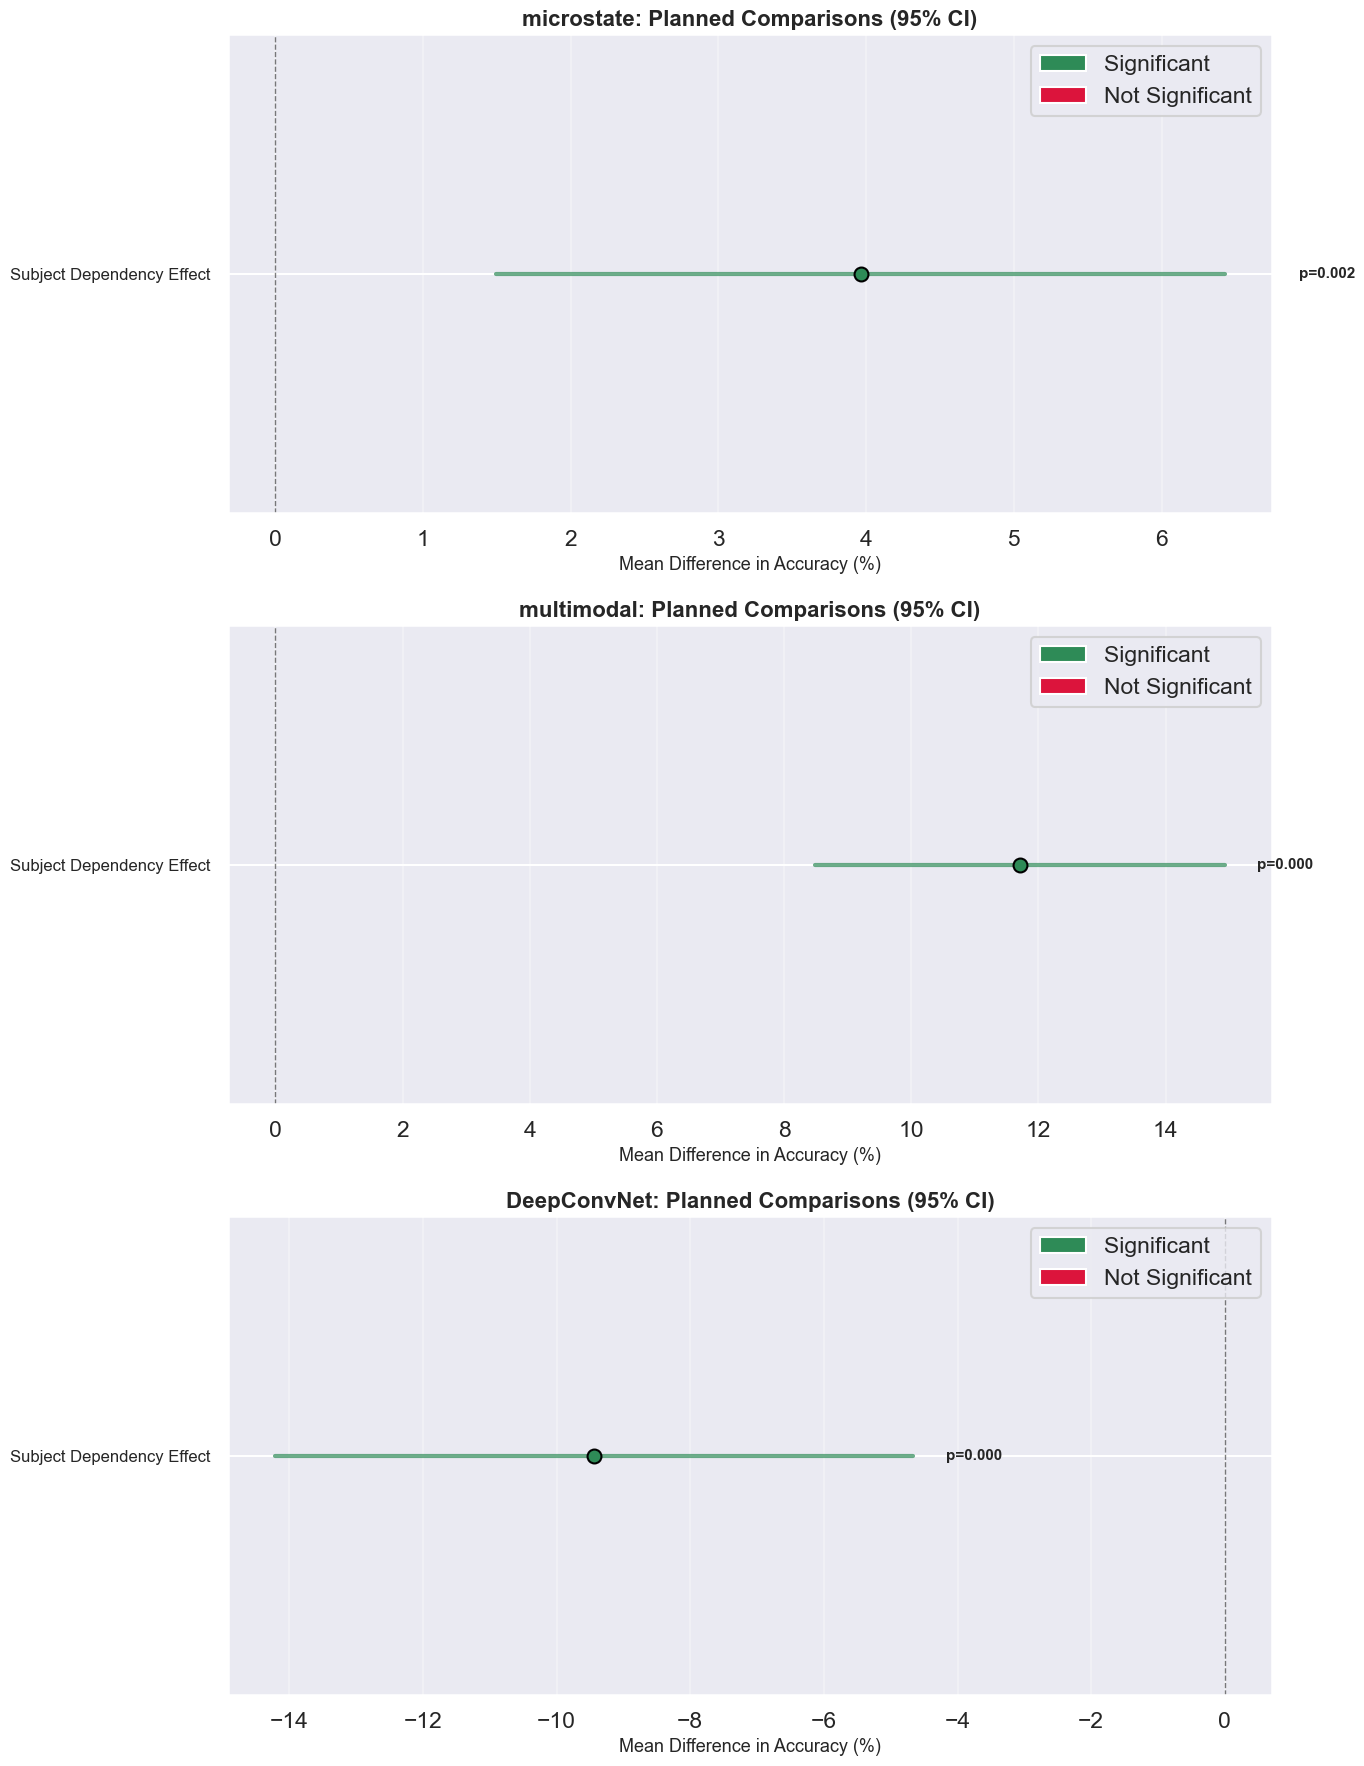

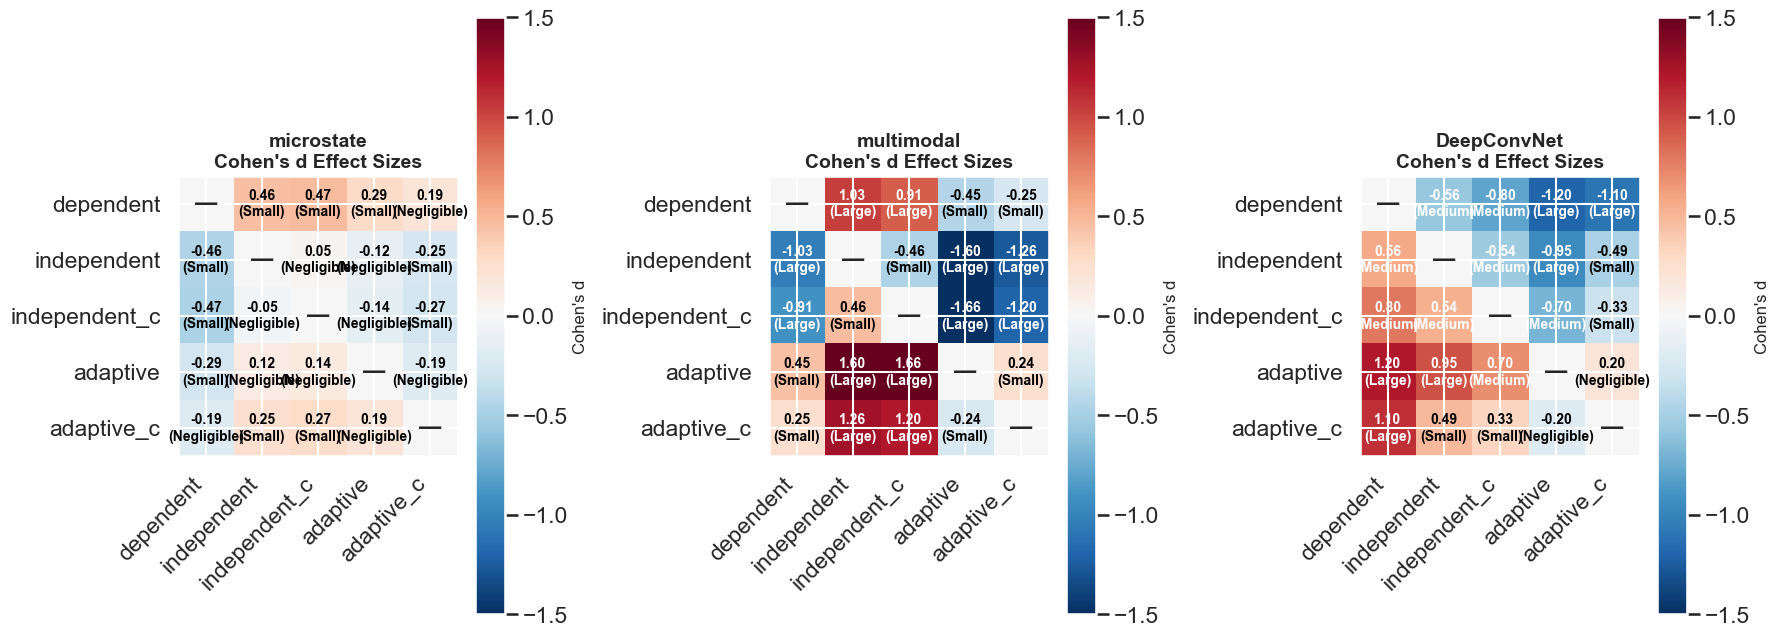

C:\Users\josan\AppData\Local\Temp\ipykernel_26264\1532814905.py:347: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(os.path.join(output_path, 'improved_stats_3_power_summary.png'),
c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


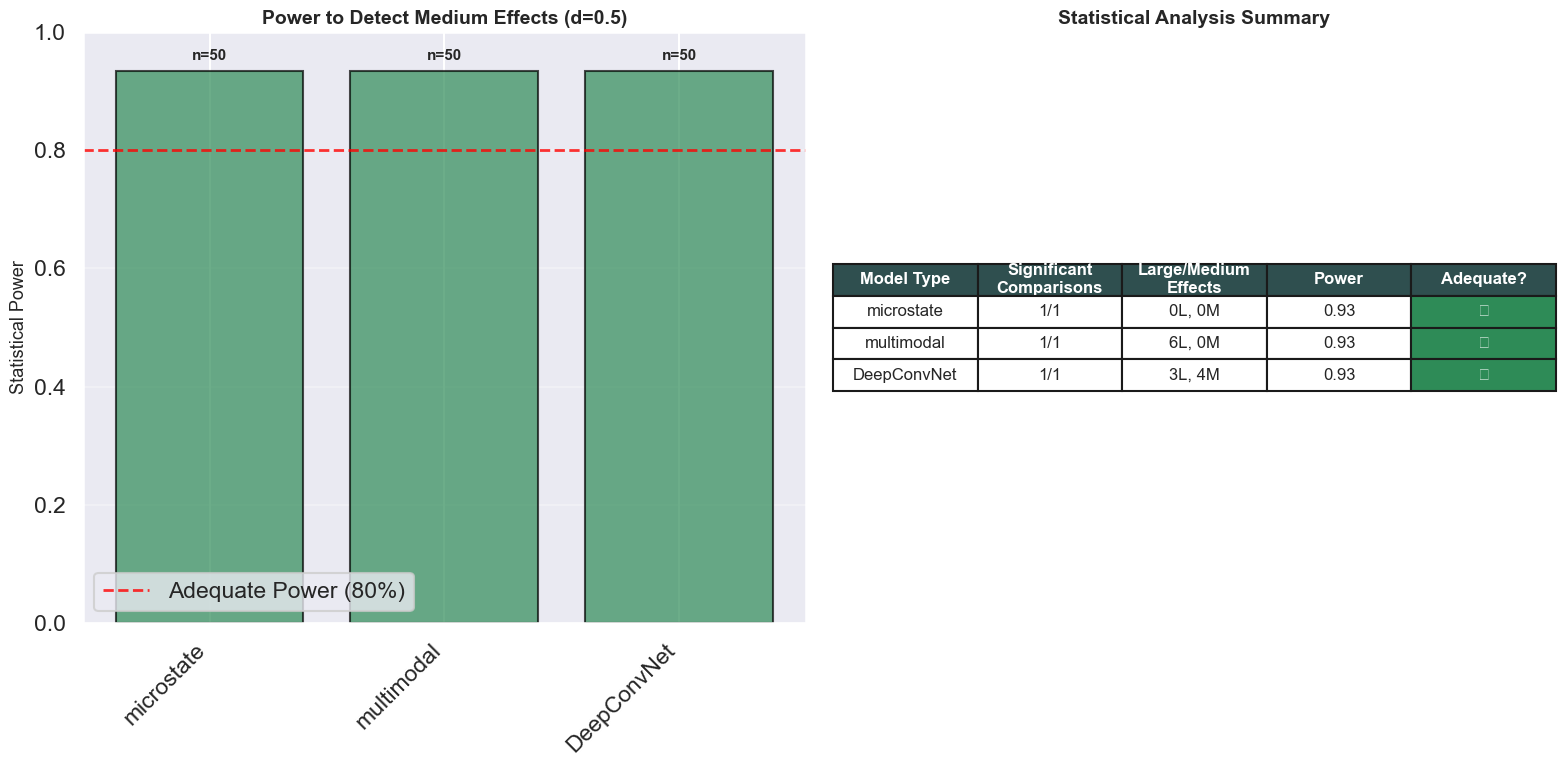

✓ Improved statistical plots saved:
  - improved_stats_1_planned_comparisons.png
  - improved_stats_2_effect_sizes.png
  - improved_stats_3_power_summary.png


In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_rel, wilcoxon, friedmanchisquare
import statsmodels.api as sm
from statsmodels.stats.power import ttest_power, tt_solve_power
from statsmodels.stats.multitest import multipletests
import seaborn as sns
from itertools import combinations
import os

def create_improved_statistical_plots(results, output_path):
    """
    Create comprehensive plots for the improved statistical analysis
    """
    
    # Define color schemes
    colors = {
        'significant': '#2E8B57',     # Sea green
        'not_significant': '#DC143C',  # Crimson
        'medium_effect': '#FF8C00',    # Dark orange
        'large_effect': '#8B0000',     # Dark red
        'small_effect': '#4682B4',     # Steel blue
        'negligible': '#808080',       # Gray
        'background': '#F5F5F5',       # White smoke
        'header': '#2F4F4F'           # Dark slate gray
    }
    
    # Process data and run analysis
    model_types = set()
    study_types = list(results.keys())
    
    for study_type, model_accuracies in results.items():
        model_types.update(model_accuracies.keys())
    
    model_types = list(model_types)
    all_results = {}
    
    # Run the statistical analysis for each model type
    for model_type in model_types:
        study_accuracies = {}
        n_subjects = None
        
        for study_type in study_types:
            if model_type in results[study_type]:
                study_name = 'subject_dependent' if study_type == 'subject' else study_type
                study_name_clean = study_name.replace('subject_', '').replace('_subject', '').replace('clean', 'c')
                study_accuracies[study_name_clean] = results[study_type][model_type]
                if n_subjects is None:
                    n_subjects = len(results[study_type][model_type])
        
        if len(study_accuracies) < 2:
            continue
            
        study_names = list(study_accuracies.keys())
        
        # Planned comparisons
        planned_results = []
        planned_comparisons = []
        
        # Define meaningful planned comparisons
        if 'dependent' in study_names and 'independent' in study_names:
            planned_comparisons.append(('dependent', 'independent', 'Subject Dependency Effect'))
        
        if 'c' in study_names:
            for study in study_names:
                if study != 'c':
                    planned_comparisons.append(('c', study, f'Clean vs {study.title()}'))
        
        # Perform planned comparisons
        if planned_comparisons:
            alpha_planned = 0.05 / len(planned_comparisons)
            
            for study1, study2, description in planned_comparisons:
                if study1 in study_accuracies and study2 in study_accuracies:
                    data1 = study_accuracies[study1]
                    data2 = study_accuracies[study2]
                    
                    t_stat, p_val = ttest_rel(data1, data2)
                    diff = np.array(data1) - np.array(data2)
                    cohens_d = np.mean(diff) / np.std(diff, ddof=1)
                    
                    se_diff = np.std(diff, ddof=1) / np.sqrt(len(diff))
                    t_crit = stats.t.ppf(0.975, len(diff) - 1)
                    ci_lower = np.mean(diff) - t_crit * se_diff
                    ci_upper = np.mean(diff) + t_crit * se_diff
                    
                    planned_results.append({
                        'comparison': description,
                        'mean_diff': np.mean(diff),
                        'ci_lower': ci_lower,
                        'ci_upper': ci_upper,
                        't_stat': t_stat,
                        'p_value': p_val,
                        'cohens_d': cohens_d,
                        'significant': p_val < alpha_planned
                    })
        
        # Effect sizes for all comparisons
        effect_summary = []
        for study1, study2 in combinations(study_names, 2):
            data1 = study_accuracies[study1]
            data2 = study_accuracies[study2]
            
            diff = np.array(data1) - np.array(data2)
            cohens_d = np.mean(diff) / np.std(diff, ddof=1)
            mean_diff = np.mean(diff)
            
            if abs(cohens_d) >= 0.8:
                magnitude = "Large"
            elif abs(cohens_d) >= 0.5:
                magnitude = "Medium"
            elif abs(cohens_d) >= 0.2:
                magnitude = "Small"
            else:
                magnitude = "Negligible"
            
            effect_summary.append({
                'comparison': f'{study1} vs {study2}',
                'mean_diff': mean_diff,
                'cohens_d': cohens_d,
                'magnitude': magnitude
            })
        
        # Power analysis
        medium_effect = 0.5
        alpha = 0.05
        achieved_power = ttest_power(medium_effect, n_subjects, alpha, alternative='two-sided')
        
        all_results[model_type] = {
            'planned_comparisons': planned_results,
            'effect_sizes': effect_summary,
            'achieved_power': achieved_power,
            'sample_size': n_subjects,
            'study_names': study_names
        }
    
    # =============================================================================
    # PLOT 1: PLANNED COMPARISONS RESULTS
    # =============================================================================
    
    fig1, axes = plt.subplots(len(model_types), 1, figsize=(14, 6*len(model_types)))
    if len(model_types) == 1:
        axes = [axes]
    
    for idx, model_type in enumerate(model_types):
        ax = axes[idx]
        results_data = all_results[model_type]
        planned_comps = results_data['planned_comparisons']
        
        if not planned_comps:
            ax.text(0.5, 0.5, f'No planned comparisons\navailable for {model_type}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title(f'{model_type}: Planned Comparisons', fontsize=16, fontweight='bold')
            continue
        
        # Create forest plot style visualization
        comparisons = [p['comparison'] for p in planned_comps]
        mean_diffs = [p['mean_diff'] for p in planned_comps]
        ci_lowers = [p['ci_lower'] for p in planned_comps]
        ci_uppers = [p['ci_upper'] for p in planned_comps]
        p_values = [p['p_value'] for p in planned_comps]
        significant = [p['significant'] for p in planned_comps]
        
        # Plot confidence intervals
        y_positions = range(len(comparisons))
        
        for i, (mean_diff, ci_low, ci_up, sig) in enumerate(zip(mean_diffs, ci_lowers, ci_uppers, significant)):
            color = colors['significant'] if sig else colors['not_significant']
            
            # Plot CI line
            ax.plot([ci_low, ci_up], [i, i], color=color, linewidth=3, alpha=0.7)
            
            # Plot mean point
            ax.scatter([mean_diff], [i], color=color, s=100, zorder=5, edgecolor='black')
            
            # Add p-value annotation
            ax.text(max(ci_up, mean_diff) + 0.5, i, f'p={p_values[i]:.3f}', 
                   va='center', fontsize=11, fontweight='bold')
        
        # Add reference line at 0
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
        
        # Formatting
        ax.set_yticks(y_positions)
        ax.set_yticklabels([c.replace(' vs ', '\nvs ') for c in comparisons], fontsize=12)
        ax.set_xlabel('Mean Difference in Accuracy (%)', fontsize=13)
        ax.set_title(f'{model_type}: Planned Comparisons (95% CI)', fontsize=16, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        # Add legend
        sig_patch = plt.Rectangle((0,0),1,1, facecolor=colors['significant'], label='Significant')
        nonsig_patch = plt.Rectangle((0,0),1,1, facecolor=colors['not_significant'], label='Not Significant')
        ax.legend(handles=[sig_patch, nonsig_patch], loc='upper right')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'improved_stats_1_planned_comparisons.png'), 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # =============================================================================
    # PLOT 2: EFFECT SIZES HEATMAP
    # =============================================================================
    
    fig2, axes = plt.subplots(1, len(model_types), figsize=(6*len(model_types), 8))
    if len(model_types) == 1:
        axes = [axes]
    
    for idx, model_type in enumerate(model_types):
        ax = axes[idx]
        results_data = all_results[model_type]
        effect_data = results_data['effect_sizes']
        study_names = results_data['study_names']
        
        if not effect_data:
            ax.text(0.5, 0.5, f'No effect size data\navailable for {model_type}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title(f'{model_type}: Effect Sizes', fontsize=16, fontweight='bold')
            continue
        
        # Create effect size matrix
        n_studies = len(study_names)
        effect_matrix = np.zeros((n_studies, n_studies))
        magnitude_matrix = np.full((n_studies, n_studies), '', dtype=object)
        
        for effect in effect_data:
            comp = effect['comparison']
            study1, study2 = comp.split(' vs ')
            i, j = study_names.index(study1), study_names.index(study2)
            
            effect_matrix[i, j] = effect['cohens_d']
            effect_matrix[j, i] = -effect['cohens_d']  # Symmetric with opposite sign
            
            magnitude_matrix[i, j] = effect['magnitude']
            magnitude_matrix[j, i] = effect['magnitude']
        
        # Create heatmap
        im = ax.imshow(effect_matrix, cmap='RdBu_r', vmin=-1.5, vmax=1.5, aspect='equal')
        
        # Add text annotations
        for i in range(n_studies):
            for j in range(n_studies):
                if i != j:
                    text_color = 'white' if abs(effect_matrix[i, j]) > 0.5 else 'black'
                    ax.text(j, i, f'{effect_matrix[i, j]:.2f}\n({magnitude_matrix[i, j]})', 
                           ha='center', va='center', fontsize=10, fontweight='bold',
                           color=text_color)
                else:
                    ax.text(j, i, '—', ha='center', va='center', fontsize=16, fontweight='bold')
        
        # Formatting
        ax.set_xticks(range(n_studies))
        ax.set_yticks(range(n_studies))
        ax.set_xticklabels(study_names, rotation=45, ha='right')
        ax.set_yticklabels(study_names)
        ax.set_title(f'{model_type}\nCohen\'s d Effect Sizes', fontsize=14, fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=0.8)
        cbar.set_label('Cohen\'s d', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'improved_stats_2_effect_sizes.png'), 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # =============================================================================
    # PLOT 3: POWER ANALYSIS AND SUMMARY
    # =============================================================================
    
    fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Power analysis plot
    model_names = list(all_results.keys())
    powers = [all_results[m]['achieved_power'] for m in model_names]
    sample_sizes = [all_results[m]['sample_size'] for m in model_names]
    
    colors_power = [colors['significant'] if p >= 0.8 else colors['not_significant'] for p in powers]
    
    bars = ax1.bar(range(len(model_names)), powers, color=colors_power, alpha=0.7, edgecolor='black')
    ax1.axhline(y=0.8, color='red', linestyle='--', alpha=0.8, linewidth=2, label='Adequate Power (80%)')
    
    # Add sample size annotations
    for i, (bar, n) in enumerate(zip(bars, sample_sizes)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'n={n}', ha='center', fontsize=11, fontweight='bold')
    
    ax1.set_xticks(range(len(model_names)))
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.set_ylabel('Statistical Power', fontsize=13)
    ax1.set_title('Power to Detect Medium Effects (d=0.5)', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, 1)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Summary table
    ax2.axis('off')
    
    summary_data = []
    for model_type in model_names:
        results_data = all_results[model_type]
        n_planned = len(results_data['planned_comparisons'])
        n_significant = sum(1 for p in results_data['planned_comparisons'] if p['significant'])
        power = results_data['achieved_power']
        
        # Count effect sizes
        large_effects = sum(1 for e in results_data['effect_sizes'] if e['magnitude'] == 'Large')
        medium_effects = sum(1 for e in results_data['effect_sizes'] if e['magnitude'] == 'Medium')
        
        summary_data.append([
            model_type,
            f"{n_significant}/{n_planned}",
            f"{large_effects}L, {medium_effects}M",
            f"{power:.2f}",
            "✓" if power >= 0.8 else "⚠️"
        ])
    
    summary_df = pd.DataFrame(summary_data, columns=[
        'Model Type', 'Significant\nComparisons', 'Large/Medium\nEffects', 'Power', 'Adequate?'
    ])
    
    table = ax2.table(cellText=summary_df.values, colLabels=summary_df.columns,
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Color code the table
    for i in range(len(summary_data)):
        for j in range(len(summary_df.columns)):
            if j == len(summary_df.columns) - 1:  # Adequate power column
                if "✓" in summary_data[i][j]:
                    table[(i+1, j)].set_facecolor(colors['significant'])
                else:
                    table[(i+1, j)].set_facecolor(colors['not_significant'])
                table[(i+1, j)].set_text_props(weight='bold', color='white')
    
    # Header styling
    for j in range(len(summary_df.columns)):
        table[(0, j)].set_facecolor(colors['header'])
        table[(0, j)].set_text_props(weight='bold', color='white')
    
    ax2.set_title('Statistical Analysis Summary', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'improved_stats_3_power_summary.png'), 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return all_results

# Run the improved plotting
print("Creating improved statistical analysis plots...")
improved_plot_results = create_improved_statistical_plots(results, output_path)
print("✓ Improved statistical plots saved:")
print("  - improved_stats_1_planned_comparisons.png")
print("  - improved_stats_2_effect_sizes.png") 
print("  - improved_stats_3_power_summary.png")

# Others test

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# EEGNet-like path
class EEGNetBlock(nn.Module):
    def __init__(self, in_ch=1, F1=8, D=2, F2=16, num_channels=61, num_timepoints=1000):
        super(EEGNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, F1, kernel_size=(1, 64), padding=(0, 32), bias=False)
        self.bn1 = nn.BatchNorm2d(F1)

        self.depthwiseConv = nn.Conv2d(F1, F1 * D, kernel_size=(num_channels, 1), groups=F1, bias=False)
        self.bn2 = nn.BatchNorm2d(F1 * D)

        self.separableConv = nn.Conv2d(F1 * D, F2, kernel_size=(1, 16), padding=(0, 8), bias=False)
        self.bn3 = nn.BatchNorm2d(F2)
        self.pool = nn.AvgPool2d(kernel_size=(1, 4))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.elu(x)

        x = self.depthwiseConv(x)
        x = self.bn2(x)
        x = F.elu(x)

        x = self.separableConv(x)
        x = self.bn3(x)
        x = F.elu(x)
        x = self.pool(x)

        return x.view(x.size(0), -1)  # flatten

# Microstate-like embedding path using Conv1D to learn temporal motifs
class MicrostateEmbeddingBlock(nn.Module):
    def __init__(self, in_channels=61, timepoints=1000):
        super(MicrostateEmbeddingBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=25, stride=1, padding=12)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=15, stride=1, padding=7)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool = nn.AdaptiveAvgPool1d(1)  # summarize over time

    def forward(self, x):  # x: (batch, 1, channels, time)
        x = x.squeeze(1)  # -> (batch, channels, time)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # -> (batch, channels, 1)
        return x.view(x.size(0), -1)  # flatten

# Final classifier
class EEGMicrostateClassifier(nn.Module):
    def __init__(self, eeg_shape=(1, 61, 1000), num_classes=3):
        super(EEGMicrostateClassifier, self).__init__()
        self.eegnet = EEGNetBlock(in_ch=1, num_channels=eeg_shape[1], num_timepoints=eeg_shape[2])
        self.micro_block = MicrostateEmbeddingBlock(in_channels=eeg_shape[1], timepoints=eeg_shape[2])

        self.eegnet_out_dim = self._get_flattened_size()
        self.micro_out_dim = 128  # Output of final conv layer in MicrostateEmbeddingBlock

        self.classifier = nn.Sequential(
            nn.Linear(self.eegnet_out_dim + self.micro_out_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def _get_flattened_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 61, 1000)
            out = self.eegnet(dummy_input)
            return out.shape[1]

    def forward(self, eeg_input):
        eeg_feat = self.eegnet(eeg_input)
        micro_feat = self.micro_block(eeg_input)
        x = torch.cat([eeg_feat, micro_feat], dim=1)
        return self.classifier(x)

# Example usage:
# all_data: (n_trials, 1, 61, 1000)
# all_y: (n_trials,) with labels 0 (rest), 1 (open), 2 (close)
# model = EEGMicrostateClassifier()
# output = model(all_data)  # shape: (n_trials, 3)
# loss = F.cross_entropy(output, all_y)


##  1. Wrap Data in PyTorch Dataset and DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)  # shape: (n_trials, 1, 61, 1000)
        self.labels = torch.tensor(labels, dtype=torch.long)  # shape: (n_trials,)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [ ]:
id = 0

data_path = '../Data/'
folder_path = 'ica_rest_close/'
output_path = '../Output/' + folder_path
if not os.path.exists(output_path):
    os.makedirs(output_path)

id_name = f'{id:03d}'  # Format id as three digits
# id_name ='_all'
file_name = f's{id_name}.npy'

# load all data from rest_close
n_subjects = 1
all_data_close = []
all_y_close = []
for i in range(0, n_subjects):
    id_name = f'{i:03d}'  # Format id as three digits
    file_name = f's{id_name}.npy'
    data = mf.get_file_path(data_path, folder_path, file_name)
    all_data_close.append(data)
    file_name_y = f'y{id_name}.npy'
    data_y = mf.get_file_path(data_path, folder_path, file_name_y)
    for i in range(len(data_y)):
        if data_y[i] == 1:
            data_y[i] = 2
    all_y_close.append(data_y)

In [ ]:
id = 0

data_path = '../Data/'
folder_path = 'ica_rest_open/'
output_path = '../Output/' + folder_path
if not os.path.exists(output_path):
    os.makedirs(output_path)

id_name = f'{id:03d}'  # Format id as three digits
# id_name ='_all'
file_name = f's{id_name}.npy'

# load all data from rest_open
n_subjects = 1
all_data_open = []
all_y_open = []
for i in range(0, n_subjects):
    id_name = f'{i:03d}'  # Format id as three digits
    file_name = f's{id_name}.npy'
    data = mf.get_file_path(data_path, folder_path, file_name)
    all_data_open.append(data)
    file_name_y = f'y{id_name}.npy'
    data_y = mf.get_file_path(data_path, folder_path, file_name_y)
    all_y_open.append(data_y)

In [ ]:
output_path = '../Output/ica_rest_all/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
# concatenate all data
# into one list
all_data = []
all_y = []
for i in range(0, n_subjects):
    data_close = all_data_close[i]
    data_open = all_data_open[i]
    data = np.concatenate((data_close, data_open), axis=0)
    all_data.append(data)
    data_y_close = all_y_close[i]
    data_y_open = all_y_open[i]
    data_y = np.concatenate((data_y_close, data_y_open), axis=0)
    all_y.append(data_y)


In [ ]:
np.array(all_y).shape

(1, 400)

In [ ]:
# Split dataset
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(all_data[id], all_y[id], test_size=0.2, stratify=all_y[id])

train_dataset = EEGDataset(train_x, train_y)
val_dataset = EEGDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


## 2. Training the model

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = EEGMicrostateClassifier().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.CrossEntropyLoss()

# num_epochs = 30

# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0
#     correct = 0

#     for x_batch, y_batch in train_loader:
#         x_batch, y_batch = x_batch.to(device), y_batch.to(device)

#         optimizer.zero_grad()
#         output = model(x_batch)
#         loss = criterion(output, y_batch)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         pred = output.argmax(dim=1)
#         correct += (pred == y_batch).sum().item()

#     train_acc = correct / len(train_dataset)
#     print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Train Accuracy: {train_acc:.4f}")

#     # Validation
#     model.eval()
#     correct = 0
#     with torch.no_grad():
#         for x_batch, y_batch in val_loader:
#             x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#             output = model(x_batch)
#             pred = output.argmax(dim=1)
#             correct += (pred == y_batch).sum().item()

#     val_acc = correct / len(val_dataset)
#     print(f"           Validation Accuracy: {val_acc:.4f}")


Epoch 1: Loss=8.5332, Train Acc=0.5656, Val Acc=0.7875
Epoch 2: Loss=2.4094, Train Acc=0.9437, Val Acc=0.8750
Epoch 3: Loss=0.8181, Train Acc=0.9812, Val Acc=0.9000
Epoch 4: Loss=0.2646, Train Acc=1.0000, Val Acc=0.9250
Epoch 5: Loss=0.2512, Train Acc=0.9969, Val Acc=0.9000
Epoch 6: Loss=0.1302, Train Acc=0.9969, Val Acc=0.8875
Epoch 7: Loss=0.0831, Train Acc=1.0000, Val Acc=0.9000
Epoch 8: Loss=0.0364, Train Acc=1.0000, Val Acc=0.9250
Epoch 9: Loss=0.0495, Train Acc=1.0000, Val Acc=0.9125
Epoch 10: Loss=0.0219, Train Acc=1.0000, Val Acc=0.9250
Epoch 11: Loss=0.0151, Train Acc=1.0000, Val Acc=0.9250
Epoch 12: Loss=0.0154, Train Acc=1.0000, Val Acc=0.9250
Epoch 13: Loss=0.0117, Train Acc=1.0000, Val Acc=0.9250
Epoch 14: Loss=0.0121, Train Acc=1.0000, Val Acc=0.9375
Epoch 15: Loss=0.0108, Train Acc=1.0000, Val Acc=0.9125
Epoch 16: Loss=0.0217, Train Acc=1.0000, Val Acc=0.9250
Epoch 17: Loss=0.0125, Train Acc=1.0000, Val Acc=0.9375
Epoch 18: Loss=0.0092, Train Acc=1.0000, Val Acc=0.9375
E

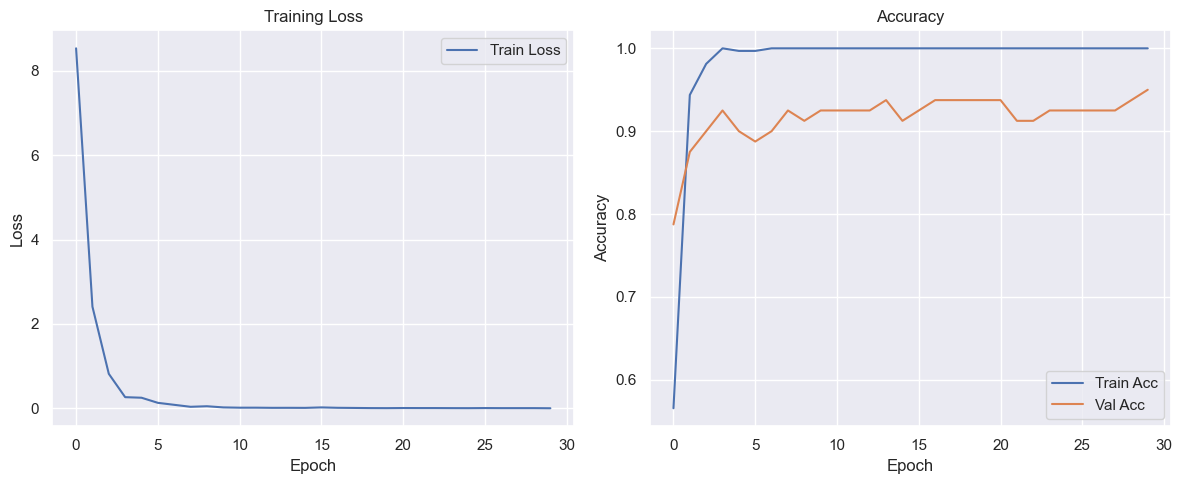

Final Validation Accuracy: 0.9500


In [ ]:
train_losses = []
val_accuracies = []
train_accuracies = []
set_seed(42)  # For reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGMicrostateClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == y_batch).sum().item()

    train_acc = correct / len(train_dataset)
    train_losses.append(running_loss)
    train_accuracies.append(train_acc)

    model.eval()
    correct = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            pred = output.argmax(dim=1)
            correct += (pred == y_batch).sum().item()

    val_acc = correct / len(val_dataset)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}: Loss={running_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

# ✅ Plot learning curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# ✅ Final accuracy
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")
